In [1]:
from tools import * 
import torch 
import pandas as pd

n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are',torch.cuda.device_count(),'GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


dict_cl=dict()
dict_cl[0]="support"
dict_cl[1]="denying"
dict_cl[2]="questioning"
dict_cl[3]="commenting"

#sdqc
d_lab=dict()
d_lab["support"]=0
d_lab["denying"]=1
d_lab["questioning"]=2
d_lab["commenting"]=3

path="../Datasets/CSV_Stance/"
train =pd.read_csv(path + "train_semeval_raw.csv")
val=pd.read_csv(path + "dev_semeval_raw.csv")
test=pd.read_csv(path + "test_semeval_raw.csv")

stoplist = stopwords.words("english")
puntos='!?."()[´]“<>¡¿-/;:=_”@#.'

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060 6GB


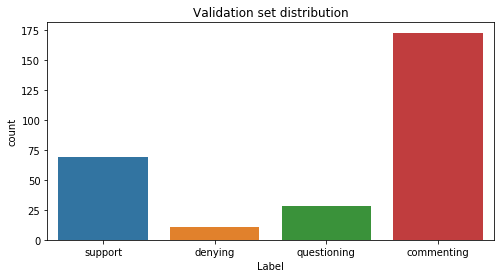

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.countplot(val['Label'], order=['support', 'denying', 'questioning', 'commenting'])
plt.title('Validation set distribution')
plt.show()

In [3]:
def det_samples(df, dict_class, c_weights=None): #None o diccionario de fracciones a aum.
    conteos= Counter(df)
    aumentos= dict()
    maxi= max(conteos.values())
            
    if c_weights is None:        # uniform class weights
        for tipo in conteos:
            actual= conteos[tipo]
            if actual<maxi:
                aumentos[tipo]=int(maxi-actual)
            else:
                aumentos[tipo]=0
        return aumentos   
    else:
        try:
            for clase in c_weights.keys():
                aumentos[clase]=int(c_weights[clase]*conteos[clase])
            for key in conteos.keys():
                if key not in aumentos.keys():
                    aumentos[key]=0
            return aumentos
        except:
            print ("No se ha especificado el diccionario de tasas de aumento de datos (por clase)")
    

In [4]:
def just_tag_word(sentence, tags_all, tag):  #wd en el vocab pues es la palabra que más pesa en el reemplazo
    n_sentence=[]
    indices=[]
    valid=[]
    i=0
    for wd in sentence:
        if wd in puntos or wd[0]=='#':
            i+=1
            continue
        else:
            if (tags_all[i] not in tag) or (wd not in token_2_idx.keys()):
                i+=1
                continue
            else:
                n_sentence.append(wd)
                indices.append(i)
                valid.append(tags_all[i])
            i+=1
    return np.asarray(n_sentence), np.asarray(indices), np.asarray(valid)

def re_generar(texto, tags_all, tag, f):
    sent, indices, tags = just_tag_word(texto, tags_all, tag)
    noise_mask = bernoulli.rvs(f, size=sent.shape)
    bool_list=list(map(bool,noise_mask))
    to_replace=sent[bool_list]
    indix=indices[bool_list]  
    tagx=tags[bool_list] 
    return to_replace , indix, tagx

In [5]:
def find_negative(target, not_sent, window=4):
    cleaned = cleaner(not_sent)[1]
    ide = cleaned.index(target)
    wind_neg=find_window(cleaned, target, ide, window=window)   
    return wind_neg
      
def predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, name_model):
    etiq = etiq.astype("int")
    trainPredict = trained.predict(x_train, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq, trainPredict)  
    f1=f1_score(etiq, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq, trainPredict))
    print ("")
    print ("Accuracy sobre Train", name_model, ":",acc)  
    print ("F1-score None sobre Train", name_model, ":",f1)
    print ("F1-score macro sobre Train", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_val, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq_v, trainPredict)  
    f1=f1_score(etiq_v, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq_v, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq_v, trainPredict))
    print ("")
    print ("Accuracy sobre Val", name_model, ":",acc)  
    print ("F1-score None sobre Val", name_model, ":",f1)
    print ("F1-score macro sobre Val", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_test, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc_t= accuracy_score(etiq_t, trainPredict)  
    f1_t=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma_t=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    matriz_t=normalize(confusion_matrix(etiq_t, trainPredict))
    print ("")
    print ("Accuracy sobre Test", name_model, ":",acc_t)  
    print ("F1-score None sobre Test", name_model, ":",f1_t)
    print ("F1-score macro sobre Test", name_model, ":",f1_ma_t)
    
    return f1_ma_t, f1_t, acc_t, matriz_t

In [6]:
def most_similar_cosmul(space, EMB_matrix, bias, positive=None, negative=None, topn=1 ): #agregar space de vpcab
    if isinstance(topn, int) and topn < 1:
        return []
    if positive is None:
        positive = []
    if negative is None:
        negative = []
    if isinstance(positive, str) and not negative:
        positive = [positive]
  
    ids_pos = [
        token_2_idx[word] if isinstance(word, string_types) else 'Tipo positivo no admitido'
        for word in positive
    ]
    
    positive = [EMB_matrix[idx] for idx in ids_pos]  #space de vocab
    ids_nega= [
        token_2_idx[word] if isinstance(word, string_types) else 'Tipo negativo no admitido'
        for word in negative
    ]
    negative = [EMB_matrix[idx] for idx in ids_nega] #space de vocab

    if not positive:
        raise ValueError("cannot compute similarity with no input")
    
    pos_dists = [((1 + dot(space, term))/2) for term in positive]    
    pos_dists[0]=pos_dists[0] + bias
    neg_dists = [((1 + dot(space, term))/2) for term in negative]
    dists = prod(pos_dists, axis=0) / (prod(neg_dists, axis=0) + 0.000001)
    
    if not topn:
        return dists
    best = matutils.argsort(dists, topn=topn + len(positive + negative), reverse=True)  #ordena en vocab used

    return best, dists[best] #retorna indices y distancias asociadas

def most_similar_cos(space, EMB_matrix, bias, positive=None, negative=None, topn=1 ): 
    if isinstance(topn, int) and topn < 1:
        return []
    if positive is None:
        positive = []
    if negative is None:
        negative = []
    if isinstance(positive, str) and not negative:
        positive = [positive]
  
    ids_pos = [
        token_2_idx[word] if isinstance(word, string_types) else 'Tipo positivo no admitido'
        for word in positive
    ]
    
    positive = [EMB_matrix[idx] for idx in ids_pos]  #space de vocab
    ids_nega= [
        token_2_idx[word] if isinstance(word, string_types) else 'Tipo negativo no admitido'
        for word in negative
    ]
    negative = [EMB_matrix[idx] for idx in ids_nega] #space de vocab

    if not positive:
        raise ValueError("cannot compute similarity with no input")
    
    
    len_all=len(positive + negative)-1 
    pos_dists = []
    i=0
    for term in positive:
        if i==0:
            pos_dists.append(((1 + dot(space, term))/2))
        else:
            pos_dists.append(((1 + dot(space, term))/(2*len_all)))

    neg_dists = []
    i=0
    for term in negative:
        if i==0:
            neg_dists.append(((1 + dot(space, term))/2))
        else:
            neg_dists.append(((1 + dot(space, term))/(2*len_all)))
    
    
    dists = prod(pos_dists, axis=0) / (prod(neg_dists, axis=0) + 0.000001)
    
    if not topn:
        return dists
    best = matutils.argsort(dists, topn=topn + len(positive + negative), reverse=True)  #ordena en vocab used


    return best, dists[best] #retorna indices y distancias asociadas



In [114]:
def aumentar_clase(clase, num_ejem, tags_all, prob, topn=1, BERT=False, pond=False):
    dict_resumen=dict()
    new_sample=[]
    indx=train['Label']==clase
    print ("Consultando por la clase", clase)
    label=d_lab[clase]    
    print ("Entrega label", label)
    contador=1
    
    no_modificados=0
    modificados=0
    terms_modif=0  
    terms_supuestos=0  
    totales=0
    largos=0
    SENT_LEN=0
    #TOPE_LEN=0
    
    if num_ejem>0:
        while (len(new_sample)<num_ejem):
            muestras=train['Tweet'][indx]
            tw_ids=train['Tw_id'][indx]
            for muestra in muestras:  
                if len(new_sample)<num_ejem:
                    #pre=np.asarray(tokenizer_loaded.tokenize(my_cleaner(muestra)[0]))
                    pre=np.asarray(cleaner(muestra)[1]) #fiel a texto original (return pre modificado en indxs)
                    tags_pre= [nltk.pos_tag([wd])[0][-1] for wd in pre]
                    terms, indxs, tagx = re_generar(pre, tags_pre, tags_all, prob)  #terms to replace
                    terms_supuestos+=len(terms)

                    news=[]
                    #TOPE_LEN+=tope_replace
                    SENT_LEN+=len(terms)
                    
                    if len(terms)>0:     
                        
                        for term, ind, tag in list(zip(terms, indxs, tagx)):  
                            if BERT:
                                mask_words = valid & np.asarray(d_posTg[tag])     
                            else:
                                mask_words = np.asarray(d_vocab[clase]) & np.asarray(d_posTg[tag])
                            vocab_used_pos = np.arange(len(mask_words))[mask_words]
                            space= EMB_matrix[mask_words] #espacio BERT de clase y tag solicitado
                            
                            if term!='user' and term!='hashtag' and term!='html':
                                not_clase, used_classes = sample_neg_class(clase) #definir clases a buscar
                                
                                valid_pos=[]
                                pos = find_positive(list(pre), term, ind, bias=1, window=4) #se puede cambiar la ventana! 
                                valid_pos=check_valid(pos, tags_all)

                                id_need = 999999999 #simbolo de que no encontró tweet
                                neg = []
                                while(id_need == 999999999):
                                    try:
                                        id_need = np.random.choice(dic_IdxI[not_clase][term]) #sample id
                                    except:
                                        if len(used_classes) == len(d_lab.keys()): 
                                            break #ya revisó todas las clases
                                        not_clase, used_classes = sample_neg_class(used_classes) # change class 

                                valid_neg=[]
                                if id_need != 999999999: #si encontró tweet
                                    not_sent = train["Tweet"][id_need]
                                    neg = find_negative(term, not_sent, window=4)  
                                    valid_neg=check_valid(neg, tags_all)

                                
                                """Modificar acá posible, obligatorio, positivos"""
                                if len(valid_neg)<1 or len(valid_pos)<1:
                                    continue #obligatorio ambos :)
                                    #pass para solo casos negativos pifeados <1

                                if pond:
                                    best, dists_best = most_similar_cos(space, EMB_matrix, 0.0, positive=valid_pos, negative=valid_neg)
                                else:
                                    best, dists_best = most_similar_cosmul(space, EMB_matrix, 0.0, positive=valid_pos, negative=valid_neg)#, topn=TOPN)
                                

                                todo_words = {
                                    token_2_idx[word] for word in valid_pos + valid_neg
                                    if not isinstance(word, ndarray) and word in token_2_idx
                                    }
                                result = []
                                for sim, dist_sim in list(zip(best, dists_best)):
                                    n_sim = vocab_used_pos[sim]
                                    if n_sim not in todo_words:
                                        result.append((idx_2_token[n_sim], float(dist_sim)))
                                        
                                if len(result)>0:
                                    candidatos = result[:topn] #+2
                                    print ("Original:",term ," \tReemplazo: ", candidatos)
                                else:
                                    continue

                                new = choose_replace(candidatos, ind, term)  
                                news.append(new) 
                                if tag in dict_resumen.keys():
                                    dict_resumen[tag]+=1
                                else:
                                    dict_resumen[tag]=1
                                
                        cambia=False
                        news= Sort_Tuple(news) 
                        
                        if len(news)<1:
                            no_modificados+=1
                            continue
                        else:
                            x=np.asarray(news)[:,1]
                            y=np.asarray(news)[:,0]
                            n_news=np.asarray(np.vstack((x,y))).T

                            nueva_sent=[]
                            cont_new=0
                            for i in range(len(pre)):
                                try:
                                    if int(n_news[cont_new][0])==i:
                                        nueva_sent.append(n_news[cont_new][1])                 
                                        cont_new+=1
                                    else: 
                                        nueva_sent.append(pre[i])
                                except: 
                                    nueva_sent.append(pre[i])
                       
                            totales+=cont_new

                            
                            print ("Sentencia original:")
                            print (pre)
                            print ("Sentencia final:" , label)
                            print (nueva_sent)
                            print ("")
                            print ("")
                            
                            new_sample.append(["Gen_"+str(contador), nueva_sent, label])
                            modificados+=1
                            terms_modif+=len(news)
                            largos+=len(pre)
                            contador+=1
                               

                else:
                    count= Counter(train['Label'])   
                    for muestra, twid in list(zip(muestras,tw_ids)) :
                        pre=np.asarray(cleaner(muestra)[1])
                        new_sample.append([twid, pre, label])
                    break
                    
    else:
        count= Counter(train['Label'])
        news= train[indx].sample(count[clase]+num_ejem)
        news_tw=news['Tweet'].values
        news_id=news['Tw_id'].values
        for muestra, twid in list(zip(news_tw, news_id)):
            pre=cleaner(muestra)[0]  #np.asarray
            new_sample.append([twid, pre, label])

    try:
        print ("# terms modificados promedio", terms_modif/modificados ,"términos por sentencia")
        print ("Largo de sentencia promedio", largos/modificados ,"términos por sentencia")
        print ("para esta ejecución se debiesen reemplazar", SENT_LEN, " de" ,TOPE_LEN, "terminos")

    except: 
        print ("No se generan ejemplos")

    print ("new_sample shpe", np.asarray(new_sample).shape)
    return new_sample, dict_resumen

In [8]:
tokenizer_loaded = BertTokenizer.from_pretrained("bert-base-uncased")
model_loaded = BertForSequenceClassification.from_pretrained("bert-base-uncased",  num_labels=4) 
idx_2_token = tokenizer_loaded.ids_to_tokens
token_2_idx = {value : key for (key, value) in idx_2_token.items()}

import os 
embeddings_index = {}
f = open(os.path.join("../Datasets/glove.twitter.27B.200d.txt"))#'glove.twitter.27B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Se encontraron %s terminos con sus vectores de embedding.' % len(embeddings_index))

In [9]:
def cleaner(post): 
    s= re.sub(r"http\S+", " html ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " hashtag ", s) ########3
    s= re.sub(r'@\w+ ?', " user ", s)##############    
    s= s.lower()
    s=emoji_pattern.sub(r'', s)
    s=re.sub(r"'\b", " ' ", s)
    s=re.sub(r"\b'\b", " ' ", s)
    s=re.sub(r"“\b", " “ ", s)
    s=re.sub(r"\b’", " ’ ", s)
    s=re.sub(r"‘\b", " ‘ ", s)
    s=re.sub(r"\b’\b", " ‘ ", s)
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " number ",  s)
    s=re.sub(r'\b[0-9]*[0-9]\b', " number ",  s)    
    s=re.sub(r'\b”', ' " ', s)
    sl= list(s.split())
    sl_2=[]
    for wd in sl:
        try: 
            q=token_2_idx[wd]
            sl_2.append(wd)
        except:
            try: 
                if stemmer.stem(wd) in token_2_idx.keys():
                    sl_2.append(stemmer.stem(wd))
                elif lemmatizer.lemmatize(wd) in token_2_idx.keys():
                    sl_2.append(lemmatizer.lemmatize(wd))
                else:
                    sl_2.append(wd)
            except:
                sl_2.append(wd)
    sl=sl_2
    s=' '.join([word for word in sl])# if word not in stoplist])
    return s, sl

In [10]:
keys=["support", "denying", "questioning", "commenting"]

dict_clases={}
for key in keys: 
    tr_k=train.loc[train["Label"]==key]
    tr_k=tr_k["Tweet"].values    
    trs_k=[]
    for tw in tr_k:
        #tokenizer_loaded.tokenize(cleaner(tw)[0]))
        cleaned = cleaner(tw)[1]
        trs_k+=cleaned
        #print ("Result tokenizer: ", encoded_sent)
    dict_clases[key]=trs_k  

In [11]:
vocabulary={}
for key in keys: 
    temp=list(set(dict_clases[key]))
    print ("#Tweets",key,":",len(temp))
    vocabulary[key]=temp

#Tweets support : 2089
#Tweets denying : 1397
#Tweets questioning : 1165
#Tweets commenting : 4806


In [12]:
dic_IdxI = {value: {} for value in d_lab.keys()}
for i, (muestra, label) in enumerate(list(zip(train["Tweet"],train["Label"]))):
    pre=np.asarray(cleaner(muestra)[1])
    for token in pre:
        if token not in dic_IdxI[label]:
            dic_IdxI[label][token] = [i]
        else:
            dic_IdxI[label][token].append(i)

In [13]:
def check_vocab(token, clase):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or  token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if token in vocabulary[clase]:
            return True
        else: 
            return False
        
        
def check_tag(token, tag):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if nltk.pos_tag([token])[0][-1]==tag and token in token_2_idx.keys():
            return True
        else: 
            return False
            
def check_valid(lista, tags):
    keep=[]
    lista_tag= [nltk.pos_tag([wd])[0][-1] for wd in lista] 
    for tag, word in list(zip(lista_tag , lista)):
        if tag in tags and word in token_2_idx.keys():
            keep.append(word)
    return keep

In [14]:
tags=['NN','NNS', 'JJ', 'JJR', 'JJS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
clases=['support', 'denying', 'questioning', 'commenting']
MAX_LEN = 50

d_posTg= dict()
for tag in tags:
    d_posTg[tag]= [check_tag(k, tag) for k in idx_2_token.values()]
    
d_vocab=dict()
for clase in clases:
    d_vocab[clase]= [check_vocab(k, clase) for k in idx_2_token.values()]
    

In [15]:
data_2_idx=dict()

corpus=[]
not_found=[]
found=[]
pos_tag_nf=[]
pos_tag=[]
    
for vocab_clase in vocabulary.keys():
    corpus+=vocabulary[vocab_clase]

corpus=list(set(corpus))
for term in corpus:
    try:
        if term not in data_2_idx.keys():
            found.append(term)
            pos_tag.append(nltk.pos_tag([term])[0][-1])
            data_2_idx[term]=token_2_idx[term]
    except:
        not_found.append(term)
        pos_tag_nf.append(nltk.pos_tag([term])[0][-1])
        continue

In [16]:
original=len(set(corpus))
matched=len(data_2_idx.keys())
print ("Se distinguen", original, "términos en el dataset. Reconociendo a", matched, "de estos (%.2f" % (matched/original) + "%)")
print ("\nExisten", len(not_found), "términos no encontrados:")
for term in not_found[:20]:
    print ("-",term)

Se distinguen 5846 términos en el dataset. Reconociendo a 4466 de estos (0.76%)

Existen 1380 términos no encontrados:
- mooi
- policement
- debunk
- tweet
- rwnj
- hashtag
- blks
- montréal
- booby
- oswald'
- outpouring
- mazaltov
- erupts
- umdlali
- swoop
- tesco
- vids
- kkk
- mongrel
- allot


In [17]:
print ("Distribución en POS tag entre términos encontrados:\n",  Counter(pos_tag))
print ("\nDistribución en POS tag entre términos NO encontrados:\n",  Counter(pos_tag_nf))

Distribución en POS tag entre términos encontrados:
 Counter({'NN': 3449, 'NNS': 772, 'JJ': 383, 'VBN': 352, 'VBG': 330, 'RB': 230, 'VBD': 65, 'IN': 55, 'VB': 48, 'CD': 45, 'VBZ': 20, 'DT': 16, 'PRP': 15, 'JJS': 10, 'MD': 9, 'JJR': 8, 'PRP$': 7, 'CC': 5, 'RBR': 4, 'WRB': 4, 'WP': 3, '.': 3, ':': 3, 'WDT': 2, 'VBP': 2, 'TO': 1, '#': 1, "''": 1, ',': 1, '$': 1, 'WP$': 1})

Distribución en POS tag entre términos NO encontrados:
 Counter({'NN': 1001, 'NNS': 144, 'VBG': 66, 'JJ': 59, 'VBN': 44, 'CD': 30, 'RB': 27, 'VB': 4, 'VBD': 3, 'JJS': 1, 'IN': 1})


#### POS tags 

- JJ adjective 'big'
- JJR adjective, comparative 'bigger'
- JJS adjective, superlative 'biggest'

- NN noun, singular 'desk'
- NNS noun plural 'desks'
- NNP proper noun, singular 'Harrison'
- NNPS proper noun, plural 'Americans'

- RB adverb very, silently,   (no considerado) 
- RBR adverb, comparative better  (no considerado)
- RBS adverb, superlative best  (no considerado)

- VB verb, base form take    
- VBD verb, past tense took
- VBG verb, gerund/present participle taking
- VBN verb, past participle taken
- VBP verb, sing. present, non-3d take
- VBZ verb, 3rd person sing. present takes



In [18]:
EMB_matrix= model_loaded.bert.embeddings.word_embeddings.weight.detach().cpu().numpy()
transformer = Normalizer().fit(EMB_matrix) 
EMB_matrix=transformer.transform(EMB_matrix)
EMB_matrix.shape

(30522, 768)

In [19]:
def valid_token(token):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        exceptions=['[CLS]', '[SEP]', '[MASK]', '[PAD]']
        if token not in exceptions:       
            return True
        else: 
            return False
        
valid=np.asarray([valid_token(k) for k in idx_2_token.values()])


## Análisis de espacio embedding

max len: 37


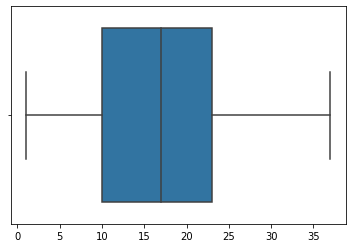

In [73]:
lens=[]
for tweet in train["Tweet"].values:
    tw=cleaner(tweet)[1]
    lens.append(len(tw))

print ("max len:", max(lens))
sns.boxplot(lens)

In [74]:
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE 

import numpy as np 
import pandas as pd
from collections import Counter 
from bert_serving.client import BertClient

bc = BertClient()  

data_bas=[]
for tweet in train["Tweet"].values:
    h=cleaner(tweet)[0]
    vector=bc.encode([h])[0]
    data_bas.append(vector)

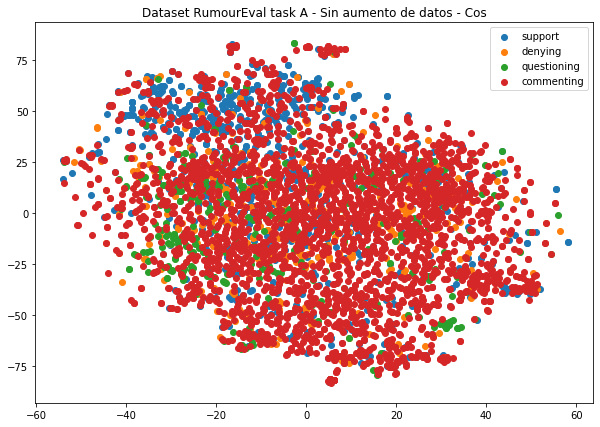

In [76]:
model = TSNE(2, metric='cosine')
to_plot_tsne = model.fit_transform(data_bas)    
plt.figure(figsize=(10,7))
for key in keys:
    mask = train["Label"]==key
    plt.scatter(to_plot_tsne[:,0][mask],to_plot_tsne[:,1][mask], label=str(key))

plt.legend()
plt.title("Dataset RumourEval task A - Sin aumento de datos - Cos")
plt.show()

# Generación Varias

In [146]:
prob= 0.15
topn = 1

aum_weight=det_samples(train['Label'], dict_cl, c_weights={"support":1, "questioning":2, "denying":2})
print ("--------------------------------------------------------")
print ("\nGenerando ejemplos en base a probabilidad --> ", prob)
print ("--------------------------------------------------------") 
print (aum_weight)

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.15
--------------------------------------------------------
{'support': 841, 'questioning': 660, 'denying': 666, 'commenting': 0}


### Sujeto a clase no ponderando target

In [147]:
macro_augmented=[]
for clase in aum_weight:
    start_time=time.time()
    print ("\n\nGenerando", aum_weight[clase], "ejemplos para", clase)
    muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob)
    macro_augmented+=muestras
    print ("Resumen de modificaciones:", dict_aumentos)
    elapsed_time= time.time() - start_time
    print ("Este proceso tomó", elapsed_time, "seg")   



Generando 841 ejemplos para support
Consultando por la clase support
Entrega label 0
Original: evidence  	Reemplazo:  [('assassinate', 1.0490922927856445)]
Original: police  	Reemplazo:  [('cops', 1.4641178846359253)]
Sentencia original:
['shoot' 'unarmed' 'kid' '.' 'conceal' 'evidence' '.' 'impose' 'martial'
 'law' '.' 'harass' 'reporters' '.' 'smear' 'the' 'victim' '.' 'worst' '.'
 'police' '.' 'ever' '.' 'hashtag' 'hashtag']
Sentencia final: 0
['shoot', 'unarmed', 'kid', '.', 'conceal', 'assassinate', '.', 'impose', 'martial', 'law', '.', 'harass', 'reporters', '.', 'smear', 'the', 'victim', '.', 'worst', '.', 'cops', '.', 'ever', '.', 'hashtag', 'hashtag']


Original: hostages  	Reemplazo:  [('perpetrators', 0.5931347608566284)]
Original: jewish  	Reemplazo:  [('jew', 0.8173867464065552)]
Sentencia original:
['“' 'user' ':' 'several' 'hostages' 'freed' 'at' 'jewish' 'supermarket'
 'in' 'paris' '.' 'photo' 'thomas' 'samson' 'hashtag' 'html' 'schaut'
 'genau' 'hin' '!']
Sentencia f

Original: cigar  	Reemplazo:  [('comedic', 0.36435744166374207)]
Original: defense  	Reemplazo:  [('destructive', 0.42531952261924744)]
Sentencia original:
['user' 'because' 'jaywalking' 'and' 'stealing' 'cigar' 'are' 'capital'
 'crimes' '.' 'it' "'" 's' 'the' 'classic' '"' 'blame' 'the' 'victim' '"'
 'defense' '.']
Sentencia final: 0
['user', 'because', 'jaywalking', 'and', 'stealing', 'comedic', 'are', 'capital', 'crimes', '.', 'it', "'", 's', 'the', 'classic', '"', 'blame', 'the', 'victim', '"', 'destructive', '.']


Original: s  	Reemplazo:  [('compelling', 0.32862842082977295)]
Sentencia original:
['breaking' ':' 'at' 'least' 'number' 'killed' 'in' 'shooting' 'at'
 'french' 'satirical' 'newspaper' 'charlie' 'hebdo' ',' 'paris'
 'prosecutor' "'" 's' 'office' 'says' '.' 'html']
Sentencia final: 0
['breaking', ':', 'at', 'least', 'number', 'killed', 'in', 'shooting', 'at', 'french', 'satirical', 'newspaper', 'charlie', 'hebdo', ',', 'paris', 'prosecutor', "'", 'compelling', 'office',

Original: charlie  	Reemplazo:  [('suspect', 1.3481148481369019)]
Original: police  	Reemplazo:  [('buildings', 0.5284773111343384)]
Sentencia original:
['user' '“' 'user' ':' 'hashtag' ':' 'both' 'charlie' 'hebdo' 'suspects'
 'killed' 'as' 'police' 'storm' 'building' 'police' 'sources' 'html'
 'http']
Sentencia final: 0
['user', '“', 'user', ':', 'hashtag', ':', 'both', 'suspect', 'hebdo', 'suspects', 'killed', 'as', 'buildings', 'storm', 'building', 'police', 'sources', 'html', 'http']


Original: soldier  	Reemplazo:  [('everyday', 0.5791074633598328)]
Original: shooting  	Reemplazo:  [('killing', 0.6953213214874268)]
Sentencia original:
['these' 'are' 'not' 'timid' 'colours' ';' 'soldiers' 'back' 'guarding'
 'tomb' 'of' 'unknown' 'soldier' 'after' 'today' "'" 's' 'shooting'
 'hashtag' 'html']
Sentencia final: 0
['these', 'are', 'not', 'timid', 'colours', ';', 'soldiers', 'back', 'guarding', 'tomb', 'of', 'unknown', 'everyday', 'after', 'today', "'", 's', 'killing', 'hashtag', 'html

Original: cartoonist  	Reemplazo:  [('qaeda', 1.2386062145233154)]
Sentencia original:
['“' 'user' ':' '“' 'user' ':' 'hashtag' ':' '“' 'the' 'cartoonist'
 'charb' '&amp' ';' 'cabu' 'are' 'dead' '.' '”' 'html' 'html' 'user']
Sentencia final: 0
['“', 'user', ':', '“', 'user', ':', 'hashtag', ':', '“', 'the', 'qaeda', 'charb', '&amp', ';', 'cabu', 'are', 'dead', '.', '”', 'html', 'html', 'user']


Original: come  	Reemplazo:  [('go', 1.2674484252929688)]
Sentencia original:
['user' 'user' 'user' 'user' 'not' 'everything' 'will' 'come' 'out' '.'
 'but' 'we' 'will' 'get' 'details' ',' 'especially' 'these' 'days' '.']
Sentencia final: 0
['user', 'user', 'user', 'user', 'not', 'everything', 'will', 'go', 'out', '.', 'but', 'we', 'will', 'get', 'details', ',', 'especially', 'these', 'days', '.']


Original: witness  	Reemplazo:  [('victim', 0.7685299515724182)]
Original: existent  	Reemplazo:  [('islam', 1.4720951318740845)]
Sentencia original:
['user' 'user' 'user' 'a' 'jehovah' "'" 's' 'wit

Original: s  	Reemplazo:  [('thought', 0.8406470417976379)]
Sentencia original:
['user' 'user' 'imagine' 'if' 'ferguson' 'folks' 'were' 'strutting'
 'around' 'with' 'ar' "'" 's' '.' 'think' 'perry&amp' ';' 'hannity'
 'would' 'be' 'hunkered' 'down' 'in' 'solidarity' '?']
Sentencia final: 0
['user', 'user', 'horrific', 'if', 'horrific', 'folks', 'were', 'strutting', 'around', 'with', 'ar', "'", 'thought', '.', 'think', 'perry&amp', ';', 'hannity', 'would', 'be', 'hunkered', 'down', 'in', 'solidarity', '?']


Original: s  	Reemplazo:  [('left', 0.8020864725112915)]
Original: t  	Reemplazo:  [('work', 0.7090672254562378)]
Sentencia original:
['user' 'user' 'i' 'know' 'that' "'" 's' 'right' '.' 'hoping' 'to' 'god'
 'hashtag' 'captured' 'on' 'phone' '+hasn' "'" 't' 'came' 'forward' '-'
 'yet' '.' 'video' 'shooting']
Sentencia final: 0
['user', 'user', 'i', 'know', 'that', "'", 'left', 'right', '.', 'hoping', 'to', 'god', 'hashtag', 'captured', 'on', 'phone', '+hasn', "'", 'work', 'came', 'fo

Original: don  	Reemplazo:  [('didn', 1.4201183319091797)]
Original: ’  	Reemplazo:  [('wanna', 1.565720558166504)]
Original: gonna  	Reemplazo:  [('terminate', 0.48642849922180176)]
Sentencia original:
['user' 'hope' 'the' 'baddies' 'don' '’' 't' 'have' 'social' 'media' 'or'
 'they' '’' 're' 'gonna' 'start' 'locking' 'the' 'side' 'doors' 'people'
 'escaped' 'from' '.']
Sentencia final: 0
['user', 'hope', 'the', 'baddies', 'didn', '’', 't', 'have', 'social', 'media', 'or', 'they', 'wanna', 're', 'terminate', 'start', 'locking', 'the', 'side', 'doors', 'people', 'escaped', 'from', '.']


Original: religions  	Reemplazo:  [('jews', 2.173880100250244)]
Sentencia original:
['.' 'user' 'user' 'user' 'duh' ',' 'of' 'course' 'it' "'" 's' '"' 'part'
 'of' 'a' 'larger' 'plot' '"' ',' 'hashtag' 'hashtag' 'hate' 'ppl' 'of'
 'all' 'religions']
Sentencia final: 0
['.', 'user', 'user', 'user', 'duh', ',', 'of', 'course', 'it', "'", 's', '"', 'part', 'of', 'a', 'larger', 'plot', '"', ',', 'hashtag', 

Original: showing  	Reemplazo:  [('guarding', 0.6803823113441467)]
Sentencia original:
['update' ':' 'hashtag' 'police' 'release' 'stills' 'from' 'convenience'
 'store' 'footage' 'showing' 'robbery' 'html' 'html']
Sentencia final: 0
['update', ':', 'hashtag', 'police', 'release', 'stills', 'from', 'convenience', 'store', 'footage', 'guarding', 'robbery', 'html', 'html']


Original: dead  	Reemplazo:  [('uniformed', 0.39906197786331177)]
Original: has  	Reemplazo:  [('is', 0.3179306089878082)]
Sentencia original:
['the' 'soldier' 'shot' 'dead' 'in' 'wednesday' "'" 's' 'ottawa' 'attacks'
 'has' 'been' 'named' 'as' 'cpl' '.' 'nathan' 'cirillo' 'of' 'hashtag'
 'hashtag' 'html']
Sentencia final: 0
['the', 'soldier', 'shot', 'uniformed', 'in', 'wednesday', "'", 's', 'ottawa', 'attacks', 'is', 'been', 'named', 'as', 'cpl', '.', 'nathan', 'cirillo', 'of', 'hashtag', 'hashtag', 'html']


Original: oh  	Reemplazo:  [('eh', 1.1856871843338013)]
Sentencia original:
['user' 'oh' 'my' 'gosh']
Senten

Original: tells  	Reemplazo:  [('witnesses', 0.8212928771972656)]
Sentencia original:
['witness' 'tells' 'hashtag' 'suspected' 'shooter' 'of' 'uniformed'
 'soldier' 'at' 'hashtag' "'" 's' 'war' 'memorial' 'was' 'carrying'
 'rifle' '.']
Sentencia final: 0
['witness', 'witnesses', 'hashtag', 'suspected', 'shooter', 'of', 'uniformed', 'soldier', 'at', 'hashtag', "'", 's', 'war', 'memorial', 'was', 'carrying', 'rifle', '.']


Original: i  	Reemplazo:  [('obama', 1.1682982444763184)]
Original: agree  	Reemplazo:  [('understand', 1.1436567306518555)]
Sentencia original:
['user' 'user' 'i' 'totally' 'agree' 'with' 'you' '!']
Sentencia final: 0
['user', 'user', 'obama', 'totally', 'understand', 'with', 'you', '!']


Original: murdered  	Reemplazo:  [('assassinated', 0.5393376350402832)]
Original: other  	Reemplazo:  [('black', 1.3378289937973022)]
Sentencia original:
['nearly' '7k' 'blacks' 'were' 'murdered' 'last' 'yr' '-' '-' 'almost'
 'all' 'by' 'other' 'blacks' '.' 'a' 'tiny' '%' 'were' 'u

Original: samson  	Reemplazo:  [('carnage', 0.7702668309211731)]
Sentencia original:
['rt' '"' 'user' ':' 'several' 'hostages' 'freed' 'at' 'jewish'
 'supermarket' 'in' 'paris' '.' 'photo' 'thomas' 'samson' 'hashtag' 'html']
Sentencia final: 0
['rt', '"', 'user', ':', 'several', 'hostages', 'freed', 'at', 'jewish', 'supermarket', 'in', 'paris', '.', 'photo', 'thomas', 'carnage', 'hashtag', 'html']


Original: released  	Reemplazo:  [('issued', 0.4786200523376465)]
Sentencia original:
['name' 'of' 'hashtag' 'cop' 'is' 'expected' 'to' 'be' 'released' 'by'
 'number' 'et' ',' 'police' 'chief' 'says' ':' 'html' 'j' '.' 'b' '.'
 'forbes' ',' 'ap' 'html']
Sentencia final: 0
['name', 'of', 'hashtag', 'cop', 'is', 'expected', 'to', 'be', 'issued', 'by', 'number', 'et', ',', 'police', 'chief', 'says', ':', 'html', 'j', '.', 'b', '.', 'forbes', ',', 'ap', 'html']


Original: police  	Reemplazo:  [('buildings', 0.5833251476287842)]
Sentencia original:
['hashtag' ':' 'both' 'charlie' 'hebdo' 'suspe

Original: news  	Reemplazo:  [('work', 0.7999005317687988)]
Original: was  	Reemplazo:  [('had', 1.227871298789978)]
Original: died  	Reemplazo:  [('had', 0.8788739442825317)]
Sentencia original:
['breaking' 'news' ':' 'new' 'york' 'times' 'is' 'reporting' 'the'
 'canadian' 'soldier' 'who' 'was' 'shot' 'has' 'died' 'from' 'their'
 'injuries' '.' 'heartbreak' '.' 'hashtag' 'hashtag']
Sentencia final: 0
['breaking', 'work', ':', 'new', 'york', 'times', 'is', 'reporting', 'the', 'canadian', 'soldier', 'who', 'had', 'shot', 'has', 'had', 'from', 'their', 'injuries', '.', 'heartbreak', '.', 'hashtag', 'hashtag']


Original: matt  	Reemplazo:  [('horrific', 0.7386419177055359)]
Sentencia original:
['user' 'stay' 'safe' ',' 'matt' '.']
Sentencia final: 0
['user', 'stay', 'safe', ',', 'horrific', '.']


Original: handed  	Reemplazo:  [('given', 3.0563793182373047)]
Original: puts  	Reemplazo:  [('knees', 3.37789249420166)]
Sentencia original:
['user' 'and' 'to' 'be' 'even' '-' 'handed' ',' 'it

Original: staying  	Reemplazo:  [('wearing', 1.2174886465072632)]
Sentencia original:
['mike' 'brown' 'was' 'staying' 'with' 'his' 'grandmother' 'for' 'the'
 'summer' ',' 'who' 'lived' 'in' 'the' 'community' '.' 'hashtag']
Sentencia final: 0
['mike', 'stay', 'was', 'wearing', 'with', 'his', 'grandmother', 'for', 'the', 'summer', ',', 'who', 'lived', 'in', 'the', 'community', '.', 'hashtag']


Original: shooting  	Reemplazo:  [('protesting', 0.5452674627304077)]
Sentencia original:
['breaking' 'news' ':' 'shooting' ',' 'hostage' '-' 'taking' 'at' 'kosher'
 'market' 'in' 'paris' ';' 'several' 'reported' 'wounded' ':' 'html'
 'user']
Sentencia final: 0
['breaking', 'news', ':', 'protesting', ',', 'hostage', '-', 'taking', 'at', 'kosher', 'market', 'in', 'paris', ';', 'several', 'reported', 'wounded', ':', 'html', 'user']


Original: member  	Reemplazo:  [('held', 1.177857756614685)]
Sentencia original:
['breaking' ':' 'a' 'source' 'confirms' 'to' 'cp24' 'that' 'the'
 'deceased' 'soldier' 

Original: flag  	Reemplazo:  [('brown', 0.7785962820053101)]
Sentencia original:
['user' 'user' 'user' 'yes' '"' 'islamic' '"' 'flag' '.' 'black' 'a'
 'traditional' 'colour' 'of' 'islam' 'and' 'i' 'presume' 'a' 'koranic'
 'verse' 'also' '.']
Sentencia final: 0
['user', 'user', 'user', 'yes', '"', 'islamic', '"', 'brown', '.', 'black', 'a', 'traditional', 'colour', 'of', 'islam', 'and', 'i', 'presume', 'a', 'koranic', 'verse', 'also', '.']


Original: lord  	Reemplazo:  [('prince', 0.7269240617752075)]
Original: sydney  	Reemplazo:  [('hostage', 1.1981854438781738)]
Original: militants  	Reemplazo:  [('terrorists', 0.8745684623718262)]
Original: number  	Reemplazo:  [('time', 3.4467108249664307)]
Sentencia original:
['user' 'user' 'user' 'o' 'lord' 'user' 'save' 'all' 'hostages' 'in'
 'sydney' '&amp' ';' 'turn' 'militants' 'number' 'righteous' 'ways' 'user'
 'hashtag' 'number']
Sentencia final: 0
['user', 'user', 'user', 'o', 'prince', 'user', 'save', 'all', 'hostages', 'in', 'hostage',

Original: are  	Reemplazo:  [('am', 0.780246913433075)]
Sentencia original:
['map' 'shows' 'industrial' 'estate' 'where' 'number' 'hashtag' 'suspects'
 'are' 'hole' 'up' ',' 'surrounded' 'by' 'police' 'html' 'html']
Sentencia final: 0
['map', 'shows', 'industrial', 'estate', 'where', 'number', 'hashtag', 'suspects', 'am', 'hole', 'up', ',', 'surrounded', 'by', 'police', 'html', 'html']


Original: name  	Reemplazo:  [('title', 1.2540589570999146)]
Sentencia original:
['user' 'if' 'we' 'know' 'the' 'name' 'of' 'the' 'maniac' ',' 'but' 'not'
 'the' 'name' 'of' 'its' 'victim' ',' 'we' 'are' 'failing' '.' 'failing'
 '.' 'utterly' '.' 'user']
Sentencia final: 0
['user', 'if', 'we', 'know', 'the', 'name', 'of', 'the', 'maniac', ',', 'but', 'not', 'the', 'title', 'of', 'its', 'victim', ',', 'we', 'are', 'failing', '.', 'failing', '.', 'utterly', '.', 'user']


Original: killed  	Reemplazo:  [('murdered', 0.48009851574897766)]
Original: nathan  	Reemplazo:  [('percent', 1.8806861639022827)]
Se

Original: t  	Reemplazo:  [('didn', 0.7841828465461731)]
Sentencia original:
['user' 'yep' ',' 'don' "'" 't' 'as' 'me' 'how' 'i' 'know' ',' 'but' 'yep']
Sentencia final: 0
['user', 'yep', ',', 'don', "'", 'didn', 'as', 'me', 'how', 'i', 'know', ',', 'but', 'yep']


Original: same  	Reemplazo:  [('similar', 0.4322320818901062)]
Original: right  	Reemplazo:  [('left', 0.8153115510940552)]
Original: kill  	Reemplazo:  [('left', 0.7804802060127258)]
Sentencia original:
['user' 'that' 'is' 'him' 'same' 'hat' 'and' 'outfit' 'at' 'sceen' 'still'
 'gave' 'no' 'right' 'to' 'kill' 'him']
Sentencia final: 0
['user', 'that', 'is', 'him', 'similar', 'hat', 'and', 'outfit', 'at', 'sceen', 'still', 'gave', 'no', 'left', 'to', 'left', 'him']


Original: shots  	Reemplazo:  [('viewers', 1.0136291980743408)]
Sentencia original:
['“' 'user' ':' 'here' "'" 's' 'that' 'dramatic' 'video' 'via' 'user' 'of'
 'shots' 'fired' 'inside' 'parliament' 'building' ':' 'html']
Sentencia final: 0
['“', 'user', ':', 'he

Original: had  	Reemplazo:  [('did', 2.010786533355713)]
Original: share  	Reemplazo:  [('house', 0.7168852090835571)]
Sentencia original:
['user' 'that' 'prehistoric' 'evil' 'cult' ',' 'murdered' 'ppl' 'on' 'the'
 'trains' '&amp' ';' 'buses' ',' 'you' "'" 've' 'had' 'more' 'then' 'your'
 'share' 'x']
Sentencia final: 0
['user', 'that', 'prehistoric', 'evil', 'cult', ',', 'murdered', 'ppl', 'on', 'the', 'trains', '&amp', ';', 'buses', ',', 'you', "'", 've', 'did', 'more', 'then', 'your', 'house', 'x']


Original: kill  	Reemplazo:  [('assassinate', 1.140018343925476)]
Original: terrorist  	Reemplazo:  [('horrific', 0.3840373456478119)]
Sentencia original:
['who' 'buys' 'kosher' '?' 'mt' 'user' ':' 'breaking' ':' 'gunman' 'at'
 'kosher' 'grocery' 'store' 'threatens' 'to' 'kill' 'hostages' 'if'
 'police' 'storm' 'terrorist' 'brothers' '.']
Sentencia final: 0
['who', 'buys', 'kosher', '?', 'mt', 'user', ':', 'breaking', ':', 'gunman', 'at', 'kosher', 'grocery', 'store', 'threatens', 'to',

Original: escape  	Reemplazo:  [('work', 1.1758153438568115)]
Original: place  	Reemplazo:  [('location', 0.4647698402404785)]
Sentencia original:
['mt' 'user' ':' 'three' 'people' 'appear' 'to' 'escape' 'from' 'martin'
 'place' ',' 'sydney' ',' 'café' ',' 'amid' 'hostage' 'situation' '-'
 'user' 'html']
Sentencia final: 0
['mt', 'user', ':', 'three', 'people', 'appear', 'to', 'work', 'from', 'martin', 'location', ',', 'sydney', ',', 'café', ',', 'amid', 'hostage', 'situation', '-', 'user', 'html']


Original: sad  	Reemplazo:  [('press', 1.1250742673873901)]
Sentencia original:
['user' 'reporting' 'soldier' 'shot' 'in' 'ottawa' '.' 'very' 'sad' 'news'
 '.']
Sentencia final: 0
['user', 'reporting', 'soldier', 'shot', 'in', 'ottawa', '.', 'very', 'press', 'news', '.']


Original: parliament  	Reemplazo:  [('shoot', 0.8341779112815857)]
Sentencia original:
['breaking' '-' 'shooting' 'on' 'parliament' 'hill' '.' 'rcmp' 'have'
 'weapons' 'drawn' 'hashtag' 'html']
Sentencia final: 0
['break

Original: reported  	Reemplazo:  [('responded', 1.0766096115112305)]
Sentencia original:
['user' 'as' 'reported' 'by' 'user' 'user' ';' 'injured' 'in' 'a' 'random'
 'drive' '-' 'by' 'shooting' 'per' 'lt' '.' 'col' 'w' 'user' 'html']
Sentencia final: 0
['user', 'as', 'responded', 'by', 'user', 'user', ';', 'injured', 'in', 'a', 'random', 'drive', '-', 'by', 'shooting', 'per', 'lt', '.', 'col', 'w', 'user', 'html']


Original: robbery  	Reemplazo:  [('assassinate', 0.5510948896408081)]
Sentencia original:
['photos' 'of' 'alleged' 'robbery' 'involving' 'michael' 'brown' 'in'
 'hashtag' 'via' 'police' 'html' 'html']
Sentencia final: 0
['photos', 'of', 'alleged', 'assassinate', 'involving', 'michael', 'brown', 'in', 'hashtag', 'via', 'police', 'html', 'html']


Original: suspects  	Reemplazo:  [('terrorists', 0.391353040933609)]
Original: hole  	Reemplazo:  [('crack', 1.2168363332748413)]
Original: hostage  	Reemplazo:  [('east', 0.885534405708313)]
Sentencia original:
['more' ':' 'official

Original: islamic  	Reemplazo:  [('iranian', 1.1890636682510376)]
Sentencia original:
['“' 'user' ':' 'breaking' 'news' ':' 'gunmen' 'take' 'hostages' 'at'
 'sydney' 'cafe' ',' 'wave' 'islamic' 'flag' 'html' 'html' 'smhhhh']
Sentencia final: 0
['“', 'user', ':', 'breaking', 'news', ':', 'gunmen', 'take', 'hostages', 'at', 'sydney', 'cafe', ',', 'wave', 'iranian', 'flag', 'html', 'html', 'smhhhh']


Original: police  	Reemplazo:  [('policemen', 0.5305848121643066)]
Sentencia original:
['“' 'user' ':' 'breaking' ':' 'police' 'enter' 'hashtag' 'cafe' ','
 'hostages' 'flee' 'html' 'hashtag' 'html']
Sentencia final: 0
['“', 'user', ':', 'breaking', ':', 'policemen', 'enter', 'hashtag', 'cafe', ',', 'hostages', 'flee', 'html', 'hashtag', 'html']


Original: stop  	Reemplazo:  [('terrorist', 1.109495759010315)]
Sentencia original:
['user' 'he' "'" 's' 'a' 'moron' ',' 'islamic' 'terrorism' ',' 'stop'
 'pussy' 'footing' 'around' 'it' '.' 'hashtag']
Sentencia final: 0
['user', 'he', "'", 's', 'a

Original: updates  	Reemplazo:  [('assaults', 0.557172417640686)]
Original: cafe  	Reemplazo:  [('customer', 0.5712400674819946)]
Sentencia original:
['“' 'user' ':' 'live' 'updates' ':' 'siege' 'in' 'sydney' 'cafe' 'html'
 'user']
Sentencia final: 0
['“', 'user', ':', 'live', 'assaults', ':', 'siege', 'in', 'sydney', 'customer', 'html', 'user']


Original: true  	Reemplazo:  [('false', 0.7857129573822021)]
Sentencia original:
['user' 'what' 'makes' 'us' 'think' 'the' 'baby' 'story' 'may' 'be' 'true'
 '?' '-' 'the' 'kremlin' 'denied' 'it' '!' 'user' 'user' 'html']
Sentencia final: 0
['user', 'what', 'makes', 'us', 'think', 'the', 'baby', 'story', 'may', 'be', 'false', '?', '-', 'the', 'kremlin', 'denied', 'it', '!', 'user', 'user', 'html']


Original: parliament  	Reemplazo:  [('terrorism', 0.899353563785553)]
Sentencia original:
['“' 'user' ':' 'attack' 'on' 'parliament' ':' 'soldier' 'shot' ';'
 'gunman' 'on' 'the' 'loose' '.' '”' 'thinking' 'of' 'everyone' 'back'
 'home' '.']
Senten

Original: head  	Reemplazo:  [('day', 0.30625778436660767)]
Sentencia original:
['“' 'user' ':' 'a' 'woman' 'in' 'hashtag' 'was' 'shot' 'in' 'head' 'last'
 'night' 'and' 'released' 'this' 'selfie' '.' 'html' 'hashtag']
Sentencia final: 0
['“', 'user', ':', 'a', 'woman', 'in', 'hashtag', 'was', 'shot', 'in', 'day', 'last', 'night', 'and', 'released', 'this', 'selfie', '.', 'html', 'hashtag']


Original: number  	Reemplazo:  [('face', 1.884658932685852)]
Sentencia original:
['user' 'user' 'hashtag' 'had' 'meeting' 'with' 'former' 'president'
 'hashtag' 'in' 'number' 'html']
Sentencia final: 0
['user', 'user', 'hashtag', 'had', 'meeting', 'with', 'former', 'president', 'hashtag', 'in', 'face', 'html']


Original: politicians  	Reemplazo:  [('celebrities', 1.2717814445495605)]
Sentencia original:
['user' 'user' 'user' 'fox' 'has' 'become' 'a' 'republican' 'politicians'
 'infomercial' ',' '&amp' ';' 'isn' "'" 't' 'really' 'interested' 'in'
 'real' 'news' ',' 'boycott' '!']
Sentencia final: 

Original: released  	Reemplazo:  [('issued', 0.7791492938995361)]
Original: was  	Reemplazo:  [('showed', 0.4382322430610657)]
Original: robbery  	Reemplazo:  [('assault', 0.46629101037979126)]
Sentencia original:
['“' 'user' ':' 'police' 'reports' 'released' 'this' 'morning' 'indicate'
 'mike' 'brown' 'was' 'a' 'suspect' 'in' 'a' '"' 'strong' '-' 'armed' '"'
 'robbery' 'in' 'hashtag' '”' 'hashtag']
Sentencia final: 0
['“', 'user', ':', 'police', 'reports', 'issued', 'this', 'morning', 'indicate', 'mike', 'brown', 'showed', 'a', 'suspect', 'in', 'a', '"', 'strong', '-', 'armed', '"', 'assault', 'in', 'hashtag', '”', 'hashtag']


Original: was  	Reemplazo:  [('occurred', 1.3239879608154297)]
Sentencia original:
['so' 'if' 'hashtag' 'had' 'hashtag' 'assassinated' 'was' 'it' 'at' 'the'
 'direction' 'of' 'putin' 'or' 'is' 'was' 'putin' 'at' 'the' 'direction'
 'of' 'fsb' 'kadyrov' '?' 'hmm']
Sentencia final: 0
['so', 'if', 'hashtag', 'had', 'hashtag', 'assassinated', 'occurred', 'it', 'at',

Original: soldier  	Reemplazo:  [('yesterday', 0.7749805450439453)]
Original: today  	Reemplazo:  [('yesterday', 0.442839652299881)]
Sentencia original:
['these' 'are' 'not' 'timid' 'colours' ';' 'soldiers' 'back' 'guarding'
 'tomb' 'of' 'unknown' 'soldier' 'after' 'today' "'" 's' 'shooting'
 'hashtag' 'html']
Sentencia final: 0
['these', 'are', 'not', 'timid', 'colours', ';', 'soldiers', 'back', 'guarding', 'tomb', 'of', 'unknown', 'yesterday', 'after', 'yesterday', "'", 's', 'shooting', 'hashtag', 'html']


Original: uber  	Reemplazo:  [('told', 1.1753077507019043)]
Original: encourage  	Reemplazo:  [('compelling', 0.4334219992160797)]
Original: online  	Reemplazo:  [('website', 0.7813251614570618)]
Original: pick  	Reemplazo:  [('qaeda', 2.2956719398498535)]
Sentencia original:
['“' 'user' ':' 'uber' 'says' 'it' 'has' 'hike' 'prices' 'in' 'sydney'
 'to' '"' 'encourage' 'more' 'drivers' 'to' 'come' 'online' '&amp' ';'
 'pick' 'up' 'hashtag' '”' 'uber=ugly' 'opportunism' '!']
Sentenci

Original: have  	Reemplazo:  [('be', 0.3502802848815918)]
Sentencia original:
['update' ':' 'total' 'of' 'number' 'people' 'have' 'been' 'able' 'to'
 'get' 'out' 'of' 'sydney' 'cafe' 'during' 'hostage' 'situation' ':'
 'html' 'html']
Sentencia final: 0
['update', ':', 'total', 'of', 'number', 'people', 'be', 'been', 'able', 'to', 'get', 'out', 'of', 'sydney', 'cafe', 'during', 'hostage', 'situation', ':', 'html', 'html']


Original: law  	Reemplazo:  [('birth', 1.1368327140808105)]
Sentencia original:
['user' 'user' 'they' 'killed' 'that' 'young' 'man' 'as' 'an' 'excuse'
 'to' 'use' 'martial' 'law' '.']
Sentencia final: 0
['user', 'user', 'they', 'killed', 'that', 'young', 'man', 'as', 'an', 'excuse', 'to', 'use', 'martial', 'birth', '.']


Original: sydney  	Reemplazo:  [('midfielder', 1.19334876537323)]
Original: cafe  	Reemplazo:  [('hostage', 0.8157756924629211)]
Original: siege  	Reemplazo:  [('comedic', 0.3654133379459381)]
Original: plot  	Reemplazo:  [('customer', 0.72763288021

Sentencia final: 0
['“', 'user', ':', 'breaking', ':', 'at', 'least', 'time', 'killed', 'in', 'killing', 'at', 'french', 'satirical', 'newspaper', 'comedic', 'hebdo', ',', 'lawyer', 'prosecutor', "'", 's', 'office', 'says', '.']


Original: least  	Reemplazo:  [('most', 2.164341449737549)]
Original: killed  	Reemplazo:  [('murdered', 0.5194195508956909)]
Sentencia original:
['at' 'least' 'number' 'killed' 'in' 'today' "'" 's' 'attack' 'on'
 'satirical' 'magazine' 'hashtag' 'in' 'paris' ',' 'official' 'says' '.'
 'html']
Sentencia final: 0
['at', 'most', 'number', 'murdered', 'in', 'today', "'", 's', 'attack', 'on', 'satirical', 'magazine', 'hashtag', 'in', 'paris', ',', 'official', 'says', '.', 'html']


Original: white  	Reemplazo:  [('numerous', 0.3714078366756439)]
Original: have  	Reemplazo:  [('get', 0.3001828193664551)]
Original: caught  	Reemplazo:  [('carnage', 0.4499068856239319)]
Original: ll  	Reemplazo:  [('sr', 0.6787998080253601)]
Sentencia original:
['how' 'many' 'white'

Original: safe  	Reemplazo:  [('previous', 0.43602561950683594)]
Sentencia original:
['user' 'user' 'user' 'user' 'i' 'don' "'" 't' 'understand' 'the' 'double'
 'standard' 'of' 'wanting' 'all' 'the' 'info' 'about' 'the' 'cop' 'but'
 'brown' "'" 's' 'past' 'is' 'safe' '.']
Sentencia final: 0
['user', 'user', 'user', 'user', 'customer', 'don', "'", 't', 'understand', 'the', 'double', 'standard', 'of', 'wanting', 'all', 'the', 'info', 'about', 'the', 'cop', 'but', 'brown', "'", 's', 'past', 'is', 'previous', '.']


Original: watch  	Reemplazo:  [('footage', 0.609458863735199)]
Original: showing  	Reemplazo:  [('watching', 1.0172621011734009)]
Sentencia original:
['“' 'user' ':' 'watch' 'video' 'showing' 'gunfire' 'inside' 'canada' "'"
 's' 'parliament' 'in' 'ottawa' 'html' 'html' 'omg' '!']
Sentencia final: 0
['“', 'user', ':', 'footage', 'video', 'watching', 'gunfire', 'inside', 'canada', "'", 's', 'parliament', 'in', 'ottawa', 'html', 'html', 'omg', '!']


Original: paris  	Reemplazo:  

Original: hope  	Reemplazo:  [('customer', 0.8501096367835999)]
Original: re  	Reemplazo:  [('terminate', 0.3974074423313141)]
Original: gonna  	Reemplazo:  [('assassinate', 0.47898349165916443)]
Original: side  	Reemplazo:  [('wall', 0.32343998551368713)]
Sentencia original:
['user' 'hope' 'the' 'baddies' 'don' '’' 't' 'have' 'social' 'media' 'or'
 'they' '’' 're' 'gonna' 'start' 'locking' 'the' 'side' 'doors' 'people'
 'escaped' 'from' '.']
Sentencia final: 0
['user', 'customer', 'the', 'baddies', 'don', '’', 't', 'have', 'social', 'media', 'or', 'they', '’', 'terminate', 'assassinate', 'start', 'locking', 'the', 'wall', 'doors', 'people', 'escaped', 'from', '.']


Original: university  	Reemplazo:  [('student', 0.7100176811218262)]
Original: ottawa  	Reemplazo:  [('home', 2.3158555030822754)]
Original: is  	Reemplazo:  [('has', 2.0527517795562744)]
Sentencia original:
['the' 'university' 'of' 'ottawa' ',' 'just' 'a' 'five' 'minute' 'walk'
 'from' 'the' 'hill' ',' 'is' 'now' 'on' 'lo

Original: toronto  	Reemplazo:  [('moreover', 0.7344833612442017)]
Original: was  	Reemplazo:  [('took', 0.3001343309879303)]
Sentencia original:
['“' 'user' ':' 'secret' 'prince' 'show' 'rumored' 'for' 'toronto'
 'tonight' 'html' 'wishing' 'this' 'was' 'nyc' 'user']
Sentencia final: 0
['“', 'user', ':', 'secret', 'prince', 'show', 'rumored', 'for', 'moreover', 'tonight', 'html', 'wishing', 'this', 'took', 'nyc', 'user']


Original: shot  	Reemplazo:  [('cut', 1.2306861877441406)]
Sentencia original:
['user' 'no' ',' 'because' 'that' 'would' 'require' 'reasoning' 'and'
 'then' 'if' 'reasoning' 'is' 'applied' ',' 'no' 'one' 'can' 'be' 'shot'
 '.' 'shoot' 'now' ',' 'reason' 'later' '.']
Sentencia final: 0
['user', 'no', ',', 'because', 'that', 'would', 'require', 'reasoning', 'and', 'then', 'if', 'reasoning', 'is', 'applied', ',', 'no', 'one', 'can', 'be', 'cut', '.', 'shoot', 'now', ',', 'reason', 'later', '.']


Original: suspects  	Reemplazo:  [('confirms', 0.44645047187805176)]
Origi

Original: was  	Reemplazo:  [('were', 4.045486927032471)]
Sentencia original:
['user' 'if' 'he' 'was' 'not' 'a' 'suspect' 'why' 'was' 'hashtag' 'inside'
 'the' 'police' 'car' 'in' 'the' 'first' 'place' '?' 'or' 'was' 'he'
 'ever' 'near' 'the' 'police' 'car' '?']
Sentencia final: 0
['user', 'if', 'he', 'was', 'not', 'a', 'suspect', 'why', 'was', 'hashtag', 'inside', 'the', 'police', 'car', 'in', 'the', 'first', 'place', '?', 'or', 'were', 'he', 'ever', 'near', 'the', 'police', 'car', '?']


Original: carrying  	Reemplazo:  [('including', 1.8541637659072876)]
Sentencia original:
['paramedics' 'are' 'currently' 'carrying' 'out' 'a' 'number' 'of'
 'hostages' 'in' 'hashtag' '.' 'hashtag' 'hashtag']
Sentencia final: 0
['paramedics', 'are', 'currently', 'including', 'out', 'a', 'number', 'of', 'hostages', 'in', 'hashtag', '.', 'hashtag', 'hashtag']


Original: several  	Reemplazo:  [('numerous', 0.6992788314819336)]
Original: samson  	Reemplazo:  [('carnage', 0.7702668309211731)]
Sentencia or

Original: al  	Reemplazo:  [('member', 0.8558216691017151)]
Sentencia original:
['“' 'user' ':' 'witnesses' '-' 'charlie' 'hebdo' 'gunmen' 'identified'
 'themselves' 'as' 'members' 'of' 'al' '-' 'qaida' ':' '"' 'if' 'true' ','
 'terrorist' 'groups' "'" 'competing' 'and' 'escalating' '?']
Sentencia final: 0
['“', 'user', ':', 'witnesses', '-', 'charlie', 'hebdo', 'gunmen', 'identified', 'themselves', 'as', 'members', 'of', 'member', '-', 'qaida', ':', '"', 'if', 'true', ',', 'terrorist', 'groups', "'", 'competing', 'and', 'escalating', '?']


Original: month  	Reemplazo:  [('year', 0.30123770236968994)]
Original: baby  	Reemplazo:  [('year', 0.46066197752952576)]
Sentencia original:
['an' 'number' '-' 'month' 'old' 'baby' 'is' 'among' 'the' 'hostages' 'at'
 'the' 'kosher' 'supermarket' 'in' 'paris' '.' 'unbearably' 'sad' '.'
 'html']
Sentencia final: 0
['an', 'number', '-', 'year', 'old', 'year', 'is', 'among', 'the', 'hostages', 'at', 'the', 'kosher', 'supermarket', 'in', 'paris', '.',

Original: hostages  	Reemplazo:  [('prices', 1.1315807104110718)]
Sentencia original:
['“' 'user' ':' 'official' ':' 'gunman' 'holding' 'at' 'least' 'number'
 'hostages' 'in' 'paris' 'market' 'has' 'threatened' 'to' 'kill' 'them'
 'if' 'police' 'approach' ':' 'html']
Sentencia final: 0
['“', 'user', ':', 'owner', ':', 'gunman', 'wearing', 'at', 'least', 'number', 'prices', 'in', 'paris', 'market', 'has', 'threatened', 'to', 'kill', 'them', 'if', 'police', 'approach', ':', 'html']


Original: illegal  	Reemplazo:  [('suspicious', 1.182912826538086)]
Original: today  	Reemplazo:  [('tonight', 1.6196223497390747)]
Sentencia original:
['user' 'user' 'illegal' 'aliens' 'will' 'kill' 'number' 'us' 'citizens'
 'today' 'in' 'the' 'usa' 'and' 'fox' 'will' 'report' 'on' 'none' 'of'
 'them' ':' 'obama' 'thanks' 'you' '.']
Sentencia final: 0
['user', 'user', 'suspicious', 'aliens', 'will', 'kill', 'number', 'us', 'citizens', 'tonight', 'in', 'the', 'usa', 'and', 'fox', 'will', 'report', 'on', 'non

Original: planned  	Reemplazo:  [('used', 0.7348331809043884)]
Original: overthrow  	Reemplazo:  [('head', 0.4023134708404541)]
Sentencia original:
['us' 'embassy' 'hashtag' 'cables' 'talk' 'of' 'an' 'operation' 'planned'
 'by' '"' 'dissidents' '"' 'in' 'hashtag' 'to' '"' 'overthrow' 'putin' '"'
 '.' 'html' 'hashtag']
Sentencia final: 0
['us', 'embassy', 'hashtag', 'cables', 'talk', 'of', 'an', 'operation', 'used', 'by', '"', 'dissidents', '"', 'in', 'hashtag', 'to', '"', 'head', 'putin', '"', '.', 'html', 'hashtag']


Original: killers  	Reemplazo:  [('shots', 0.8404371738433838)]
Sentencia original:
['hashtag' 'killers' 'shot' 'dead' 'by' 'police']
Sentencia final: 0
['hashtag', 'shots', 'shot', 'dead', 'by', 'police']


Original: rt  	Reemplazo:  [('employee', 0.787449836730957)]
Sentencia original:
['rt' 'user' 'at' 'least' 'number' 'dead' 'in' 'shooting' 'at' 'hq' 'of'
 'hashtag' 'in' 'hashtag' 'police' 'source' 'html']
Sentencia final: 0
['employee', 'user', 'at', 'least', 'numbe

Original: is  	Reemplazo:  [('has', 2.020637035369873)]
Original: was  	Reemplazo:  [('were', 2.453976631164551)]
Original: member  	Reemplazo:  [('part', 0.7146511077880859)]
Sentencia original:
['breaking' ':' 'a' 'source' 'confirms' 'to' 'cp24' 'that' 'the'
 'deceased' 'soldier' 'in' 'ottawa' 'is' 'cpl' '.' 'nathan' 'cirillo' '.'
 'cirillo' 'was' 'a' 'member' 'of' 'the' 'hamilton' 'argyll']
Sentencia final: 0
['breaking', ':', 'a', 'source', 'confirms', 'to', 'cp24', 'that', 'the', 'deceased', 'soldier', 'in', 'ottawa', 'has', 'cpl', '.', 'nathan', 'cirillo', '.', 'cirillo', 'were', 'a', 'part', 'of', 'the', 'hamilton', 'argyll']


Original: release  	Reemplazo:  [('supermarket', 0.5071448087692261)]
Original: police  	Reemplazo:  [('policemen', 0.5564449429512024)]
Sentencia original:
['hostage' '-' 'taker' 'at' 'paris' 'store' 'demands' 'release' 'of'
 'hashtag' ',' 'police' 'union' 'spokesman' 'says' '.' 'html' 'html']
Sentencia final: 0
['hostage', '-', 'taker', 'at', 'paris', '


Original: confirmed  	Reemplazo:  [('admitted', 2.201916456222534)]
Sentencia original:
['user' 'lisa' 'is' 'he' 'the' 'confirmed' 'robber' '?']
Sentencia final: 2
['user', 'lisa', 'is', 'he', 'the', 'admitted', 'robber', '?']


Original: button  	Reemplazo:  [('stop', 0.7665433287620544)]
Original: is  	Reemplazo:  [('does', 0.7251386046409607)]
Original: broken  	Reemplazo:  [('lever', 0.7892667055130005)]
Sentencia original:
['user' 'the' 'pause' 'button' 'is' 'broken' 'and' 'there' 'is' 'no'
 'rewind' 'function' '.' 'it' "'" 's' 'terrifying' 'when' 'you' 'think'
 'about' 'it' '.']
Sentencia final: 2
['user', 'the', 'pause', 'stop', 'does', 'lever', 'and', 'there', 'is', 'no', 'rewind', 'function', '.', 'it', "'", 's', 'terrifying', 'when', 'you', 'think', 'about', 'it', '.']


Original: contact  	Reemplazo:  [('someone', 0.8121145367622375)]
Original: anyone  	Reemplazo:  [('anything', 1.2233551740646362)]
Sentencia original:
['user' 'trying' 'to' 'get' 'in' 'contact' ',' 'anyone'

Sentencia original:
['user' 'easy' 'to' 'know' 'if' 'this' 'is' 'brown' 'by' 'looking' 'at'
 'what' 'he' 'was' 'wearing' 'when' 'he' 'was' 'killed' '.' 'has' 'there'
 'been' 'a' 'positive' 'id' 'for' 'this' '?']
Sentencia final: 2
['user', 'easy', 'to', 'know', 'if', 'this', 'is', 'brown', 'by', 'referring', 'at', 'what', 'he', 'were', 'wearing', 'when', 'he', 'was', 'been', '.', 'has', 'there', 'been', 'a', 'positive', 'id', 'for', 'this', '?']


Original: many  	Reemplazo:  [('other', 0.5407056212425232)]
Original: people  	Reemplazo:  [('blacks', 0.7171673774719238)]
Sentencia original:
['user' 'na' ',' 'it' "'" 's' 'too' 'many' 'black' 'people' 'for'
 'hashtag' 'to' 'care']
Sentencia final: 2
['user', 'na', ',', 'it', "'", 's', 'too', 'other', 'black', 'blacks', 'for', 'hashtag', 'to', 'care']


Original: centre  	Reemplazo:  [('doesn', 1.9094828367233276)]
Sentencia original:
['user' 'any' 'reports' 'of' 'shots' 'fired' 'inside' 'the' 'rideau'
 'centre' 'or' 'just' 'nearby' '?']
S

Original: ok  	Reemplazo:  [('okay', 0.7386507391929626)]
Sentencia original:
['user' 'hi' 'peter' ',' 'this' 'is' 'marta' ',' 'reporter' 'from'
 'demotix' '.' 'did' 'you' 'take' 'the' 'photo' '?' 'would' 'be' 'ok'
 'for' 'us' 'to' 'use' '?' 'can' 'you' 'send' 'it' '?' 'thanks']
Sentencia final: 2
['user', 'hi', 'peter', ',', 'this', 'is', 'marta', ',', 'reporter', 'from', 'demotix', '.', 'did', 'you', 'take', 'the', 'picture', '?', 'would', 'be', 'okay', 'for', 'us', 'to', 'use', '?', 'can', 'you', 'send', 'it', '?', 'thanks']


Original: known  	Reemplazo:  [('seen', 1.1587613821029663)]
Sentencia original:
['user' 'they' 'were' 'well' 'known' 'by' 'the' 'french' 'why' 'didn' "'"
 't' 'they' 'do' 'anything' '?' '?' '?' 'then']
Sentencia final: 2
['user', 'they', 'were', 'well', 'seen', 'by', 'the', 'french', 'why', 'didn', "'", 't', 'they', 'do', 'anything', '?', '?', '?', 'then']


Original: read  	Reemplazo:  [('write', 0.7225133776664734)]
Original: flip  	Reemplazo:  [('def', 1.2

Original: killed  	Reemplazo:  [('murdered', 0.5525521636009216)]
Original: children  	Reemplazo:  [('terrorists', 0.9837755560874939)]
Sentencia original:
['user' 'user' 'western' 'countries' 'have' 'killed' 'more' 'innocent'
 'children' 'than' 'hitler' 'assmunch' '.' 'but' 'you' 'prob' 'don' "'"
 't' 'consider' 'that' 'terror' '?' '?']
Sentencia final: 2
['user', 'user', 'western', 'countries', 'have', 'murdered', 'more', 'innocent', 'terrorists', 'than', 'hitler', 'assmunch', '.', 'but', 'you', 'prob', 'don', "'", 't', 'consider', 'that', 'terror', '?', '?']


Original: found  	Reemplazo:  [('time', 3.2424697875976562)]
Sentencia original:
['user' 'initially' ',' 'but' 'found' 'out' 'about' 'the' 'robbery'
 'during' 'the' 'altercation']
Sentencia final: 2
['user', 'initially', ',', 'but', 'time', 'out', 'about', 'the', 'robbery', 'during', 'the', 'altercation']


Original: cartoon  	Reemplazo:  [('doesn', 0.8822084665298462)]
Original: values  	Reemplazo:  [('thinks', 0.920749366283

Original: stop  	Reemplazo:  [('conference', 3.0952305793762207)]
Sentencia original:
['user' 'user' 'you' "'" 're' 'choosing' 'to' 'talk' 'about' 'a' '"'
 'robbery' '"' 'based' 'on' 'a' 'tape' 'that' 'only' 'shows' 'a'
 'confrontation' 'not' 'a' 'crime' '.' 'so' 'stop' '!']
Sentencia final: 2
['user', 'user', 'you', "'", 're', 'choosing', 'to', 'talk', 'about', 'a', '"', 'retribution', '"', 'based', 'on', 'a', 'tape', 'that', 'only', 'shows', 'a', 'confrontation', 'not', 'a', 'crime', '.', 'so', 'conference', '!']


Original: is  	Reemplazo:  [('has', 1.935856580734253)]
Sentencia original:
['user' 'is' 'this' 'photo' 'from' 'last' 'night' '?' '?' 'please'
 'clarify' 'because' 'you' 'are' 'using' 'present' 'tense' '.']
Sentencia final: 2
['user', 'has', 'this', 'photo', 'from', 'last', 'night', '?', '?', 'please', 'clarify', 'because', 'you', 'are', 'using', 'present', 'tense', '.']


Original: man  	Reemplazo:  [('cat', 0.7454188466072083)]
Sentencia original:
['user' 'user' 'why' 'w

Original: low  	Reemplazo:  [('worried', 0.8115295767784119)]
Original: level  	Reemplazo:  [('terrorist', 0.5463429689407349)]
Sentencia original:
['user' 'true' '.' 'but' 'i' 'hear' 'there' 'was' 'a' 'similar' 'incident'
 'this' 'past' 'monday' '.' 'is' 'that' 'correct' '?' 'that' 'makes' 'me'
 'think' 'its' 'low' 'level' 'terrorism']
Sentencia final: 2
['user', 'true', '.', 'but', 'i', 'hear', 'there', 'was', 'a', 'similar', 'incident', 'this', 'past', 'monday', '.', 'is', 'that', 'correct', '?', 'that', 'makes', 'me', 'think', 'its', 'worried', 'terrorist', 'terrorism']


Original: is  	Reemplazo:  [('gives', 0.6237209439277649)]
Original: wrong  	Reemplazo:  [('other', 1.1037954092025757)]
Sentencia original:
['what' 'is' 'wrong' 'with' 'you' 'user' '?']
Sentencia final: 2
['what', 'gives', 'other', 'with', 'you', 'user', '?']


Original: re  	Reemplazo:  [('co', 0.7172799110412598)]
Original: claiming  	Reemplazo:  [('trying', 0.7338411808013916)]
Sentencia original:
['user' 'use

Original: mother  	Reemplazo:  [('dad', 1.2152076959609985)]
Sentencia original:
['user' 'user' 'but' 'she' "'" 's' 'very' 'good' 'at' 'instigating' 'and'
 'bait' '.' 'just' 'like' 'her' 'mother' '.' 'smh']
Sentencia final: 2
['user', 'user', 'but', 'she', "'", 'right', 'very', 'good', 'at', 'instigating', 'and', 'bait', '.', 'just', 'like', 'her', 'dad', '.', 'smh']


Original: have  	Reemplazo:  [('remove', 0.5421934127807617)]
Sentencia original:
['user' 'user' 'have' 'you' 'seen' 'this' '?']
Sentencia final: 2
['user', 'user', 'remove', 'you', 'seen', 'this', '?']


Original: be  	Reemplazo:  [('do', 1.4722720384597778)]
Sentencia original:
['user' 'user' 'who' 'could' 'be' 'doing' 'this' '?' 'and' 'why' '?' 'don'
 "'" 't' 'expect' 'bbc' 'to' 'tell' 'you']
Sentencia final: 2
['user', 'user', 'who', 'could', 'do', 'doing', 'this', '?', 'and', 'why', '?', 'don', "'", 't', 'expect', 'bbc', 'to', 'tell', 'you']


Original: officer  	Reemplazo:  [('brown', 0.33277249336242676)]
Sentenci

Original: consider  	Reemplazo:  [('be', 0.7818799614906311)]
Original: terrorist  	Reemplazo:  [('terrorism', 1.0086743831634521)]
Original: islam  	Reemplazo:  [('gonna', 2.7721476554870605)]
Sentencia original:
['user' 'is' 'he' 'consider' 'as' 'terrorist' 'or' 'just' 'a' 'criminal'
 'person' 'as' 'his' 'faith' 'not' 'sunni' 'islam' '?']
Sentencia final: 2
['user', 'is', 'he', 'be', 'as', 'terrorism', 'or', 'just', 'a', 'criminal', 'person', 'as', 'his', 'faith', 'not', 'sunni', 'gonna', '?']


Original: happened  	Reemplazo:  [('resulted', 0.7145707607269287)]
Sentencia original:
['user' 'what' "'" 's' 'happened' 'to' 'the' 'guy' '!']
Sentencia final: 2
['user', 'what', "'", 's', 'resulted', 'to', 'the', 'guy', '!']


Original: are  	Reemplazo:  [('am', 0.6394965052604675)]
Sentencia original:
['user' 'is' 'that' 'man' 'holding' 'hostages' 'alone' '?' 'or' 'they'
 'are' 'many' '?']
Sentencia final: 2
['user', 'is', 'that', 'man', 'holding', 'hostages', 'alone', '?', 'or', 'they', '

Original: walking  	Reemplazo:  [('running', 0.2965012788772583)]
Sentencia original:
['user' 'all' 'there' 'is' 'a' 'still' 'picture' 'of' 'a' 'black' 'man'
 'walking' 'is' 'that' 'what' 'counts' 'as' 'evidence' 'were' 'they' 'on'
 'his' 'person' '?']
Sentencia final: 2
['user', 'all', 'there', 'is', 'a', 'still', 'picture', 'of', 'a', 'black', 'man', 'running', 'is', 'that', 'what', 'counts', 'as', 'evidence', 'were', 'they', 'on', 'his', 'person', '?']


Original: lever  	Reemplazo:  [('retribution', 0.37544581294059753)]
Sentencia original:
['user' 'suppose' 'that' "'" 's' 'real' ':' 'that' 'guy' 'is' 'carrying'
 'a' 'lever' 'action' 'rifle' 'it' 'looks' 'like' '?']
Sentencia final: 2
['user', 'suppose', 'that', "'", 's', 'real', ':', 'that', 'guy', 'is', 'carrying', 'a', 'retribution', 'action', 'rifle', 'it', 'looks', 'like', '?']


Original: number  	Reemplazo:  [('andrei', 0.4920431673526764)]
Sentencia original:
['user' 'user' 'user' 'user' 'hardly' ',' 'dont' 'hear' 'about' '

Original: admitted  	Reemplazo:  [('disgusted', 0.46720555424690247)]
Original: was  	Reemplazo:  [('had', 1.0533618927001953)]
Sentencia original:
['user' 'user' 'why' 'did' 'the' 'store' 'owner' 'say' 'it' 'wasn' "'" 't'
 'him' 'and' 'the' 'friend' 'admitted' 'it' 'was' '?' 'have' 'the'
 'gotten' 'an' 'explanation']
Sentencia final: 2
['user', 'user', 'why', 'did', 'the', 'store', 'owner', 'say', 'it', 'wasn', "'", 't', 'him', 'and', 'the', 'friend', 'disgusted', 'it', 'had', '?', 'have', 'the', 'gotten', 'an', 'explanation']


Original: media  	Reemplazo:  [('means', 2.747515916824341)]
Sentencia original:
['user' 'hashtag' 'no' '.' 'we' 'are' 'witness' 'on' 'how' 'the' 'world'
 'have' 'let' 'terrorist' 'walk' 'on' 'our' 'streets' '.' 'why' 'they'
 'were' 'out' 'of' 'jail' '?' 'the' 'media']
Sentencia final: 2
['user', 'hashtag', 'no', '.', 'we', 'are', 'witness', 'on', 'how', 'the', 'world', 'have', 'let', 'terrorist', 'walk', 'on', 'our', 'streets', '.', 'why', 'they', 'were', 'ou

Original: place  	Reemplazo:  [('point', 1.1577222347259521)]
Sentencia original:
['user' 'user' 'user' 'or' 'maybe' 'the' 'police' 'scared' 'him' 'into'
 'saying' 'it' 'was' 'michael' 'brown' 'in' 'the' 'first' 'place' '?']
Sentencia final: 2
['user', 'user', 'user', 'or', 'maybe', 'the', 'police', 'scared', 'him', 'into', 'saying', 'it', 'was', 'michael', 'brown', 'in', 'the', 'first', 'point', '?']


Original: is  	Reemplazo:  [('gets', 0.5020132064819336)]
Sentencia original:
['user' 'is' 'it' 'safe' 'anywhere' '?']
Sentencia final: 2
['user', 'gets', 'it', 'safe', 'anywhere', '?']


Original: cool  	Reemplazo:  [('shot', 0.7340455055236816)]
Sentencia original:
['user' 'user' 'user' 'user' 'in' 'your' 'world' ',' 'it' "'" 's' 'cool'
 'to' 'shoot' 'unarmed' 'people' 'in' 'the' 'chest' ',' 'but' 'not' 'the'
 'back' '?' 'or' 'vice' 'versa' '?']
Sentencia final: 2
['user', 'user', 'user', 'user', 'in', 'your', 'world', ',', 'it', "'", 's', 'shot', 'to', 'shoot', 'unarmed', 'people', '

Original: names  	Reemplazo:  [('words', 1.8241804838180542)]
Sentencia original:
['user' 'isn' "'" 't' 'it' 'etiquette' 'to' 'remove' 'names' 'from' 'a'
 'press' 'release' '?']
Sentencia final: 2
['user', 'isn', "'", 't', 'it', 'etiquette', 'to', 'identify', 'words', 'from', 'a', 'press', 'release', '?']


Original: decided  	Reemplazo:  [('said', 1.146220326423645)]
Sentencia original:
['user' 'only' 'just' 'decided' 'to' 'air' 'this' 'have' 'you' '?' '?'
 'jeez']
Sentencia final: 2
['user', 'only', 'just', 'said', 'to', 'air', 'this', 'have', 'you', '?', '?', 'jeez']


Original: shot  	Reemplazo:  [('kill', 0.3326649069786072)]
Original: killed  	Reemplazo:  [('murdered', 0.8692747950553894)]
Sentencia original:
['user' 'user' 'where' 'is' 'the' 'video' 'from' 'the' 'cellphone' 'taken'
 'from' 'one' 'of' 'the' 'witnesses' 'who' 'saw' 'brown' 'shot' 'and'
 'killed' '?']
Sentencia final: 2
['user', 'user', 'where', 'is', 'the', 'video', 'from', 'the', 'cellphone', 'taken', 'from', 'on

Original: michael  	Reemplazo:  [('peter', 1.1807456016540527)]
Original: doesn  	Reemplazo:  [('didn', 0.6214637160301208)]
Sentencia original:
['if' 'michael' 'zehaf' '-' 'bebeau' 'had' 'his' 'passport' 'confiscated'
 'doesn' "'" 't' 'it' 'make' 'sense' 'to' 'track' 'his' 'movements' '-'
 'was' 'this' 'done' '?' 'user' 'user']
Sentencia final: 2
['if', 'peter', 'zehaf', '-', 'bebeau', 'had', 'his', 'passport', 'confiscated', 'didn', "'", 't', 'it', 'make', 'sense', 'to', 'track', 'his', 'movements', '-', 'was', 'this', 'done', '?', 'user', 'user']


Original: lone  	Reemplazo:  [('jack', 1.1027324199676514)]
Original: attacker  	Reemplazo:  [('stupidity', 0.5454139709472656)]
Sentencia original:
['user' 'rather' 'than' 'being' 'a' "'" 'lone' '-' 'wolf' 'copy' '-' 'cat'
 "'" 'the' 'fact' 'the' 'attacker' 'is' 'so' 'well' '-' 'armed' 'points'
 'to' 'a' 'far' 'more' 'worrying' 'escalation' '.']
Sentencia final: 2
['user', 'rather', 'than', 'being', 'a', "'", 'jack', '-', 'wolf', 'copy',

Original: s  	Reemplazo:  [('life', 0.6589972972869873)]
Sentencia original:
['user' 'he' "'" 's' 'still' 'alive' '?' '?' '?']
Sentencia final: 2
['user', 'he', "'", 'life', 'still', 'alive', '?', '?', '?']


Original: black  	Reemplazo:  [('white', 0.8619779944419861)]
Original: is  	Reemplazo:  [('has', 0.7630643844604492)]
Sentencia original:
['user' 'all' 'there' 'is' 'a' 'still' 'picture' 'of' 'a' 'black' 'man'
 'walking' 'is' 'that' 'what' 'counts' 'as' 'evidence' 'were' 'they' 'on'
 'his' 'person' '?']
Sentencia final: 2
['user', 'all', 'there', 'is', 'a', 'still', 'picture', 'of', 'a', 'white', 'man', 'walking', 'has', 'that', 'what', 'counts', 'as', 'evidence', 'were', 'they', 'on', 'his', 'person', '?']


Original: real  	Reemplazo:  [('true', 1.3313305377960205)]
Original: lever  	Reemplazo:  [('retribution', 0.37544581294059753)]
Sentencia original:
['user' 'suppose' 'that' "'" 's' 'real' ':' 'that' 'guy' 'is' 'carrying'
 'a' 'lever' 'action' 'rifle' 'it' 'looks' 'like' '?'

Original: funded  	Reemplazo:  [('motivated', 1.2758815288543701)]
Original: armed  	Reemplazo:  [('motivated', 0.8128088712692261)]
Sentencia original:
['user' 'who' 'funded' 'armed' 'trained' 'gunmen' '?' 'html' '…' 'jeffrey'
 'epstein' 'also' 'in' 'cfr+trilateral' 'commission' 'hashtag']
Sentencia final: 2
['user', 'who', 'motivated', 'motivated', 'trained', 'gunmen', '?', 'html', '…', 'jeffrey', 'epstein', 'also', 'in', 'cfr+trilateral', 'commission', 'hashtag']


Original: did  	Reemplazo:  [('took', 0.473457008600235)]
Original: gotten  	Reemplazo:  [('weren', 0.8891119360923767)]
Sentencia original:
['user' 'user' 'why' 'did' 'the' 'store' 'owner' 'say' 'it' 'wasn' "'" 't'
 'him' 'and' 'the' 'friend' 'admitted' 'it' 'was' '?' 'have' 'the'
 'gotten' 'an' 'explanation']
Sentencia final: 2
['user', 'user', 'why', 'took', 'the', 'store', 'owner', 'say', 'it', 'wasn', "'", 't', 'him', 'and', 'the', 'friend', 'admitted', 'it', 'was', '?', 'have', 'the', 'weren', 'an', 'explanation']



Original: do  	Reemplazo:  [('be', 0.8508118391036987)]
Sentencia original:
['user' 'do' 'you' 'have' 'a' 'link' '?']
Sentencia final: 2
['user', 'be', 'you', 'have', 'a', 'link', '?']


Original: theft  	Reemplazo:  [('robbery', 1.478217601776123)]
Sentencia original:
['user' 'user' 'user' 'even' 'though' 'his' 'friend' 'and' 'witness' 'to'
 'the' 'shooting' 'has' 'admitted' 'to' 'the' 'cigarillo' 'theft' '?']
Sentencia final: 2
['user', 'user', 'user', 'even', 'though', 'his', 'friend', 'and', 'witness', 'to', 'the', 'shooting', 'has', 'admitted', 'to', 'the', 'cigarillo', 'robbery', '?']


Original: way  	Reemplazo:  [('manner', 0.4666328430175781)]
Sentencia original:
['user' 'user' 'there' 'must' 'be' 'a' 'way' 'to' 'enter' 'that'
 'building' '?']
Sentencia final: 2
['user', 'user', 'there', 'must', 'be', 'a', 'manner', 'to', 'enter', 'that', 'building', '?']


Original: stupidity  	Reemplazo:  [('st', 0.45434507727622986)]
Sentencia original:
['user' 'user' 'there' 'is' 'stupid' 

Original: cnn  	Reemplazo:  [('hitler', 1.3529890775680542)]
Sentencia original:
['user' 'cnn' 'too' 'i' 'have' 'heard' 'user' 'user']
Sentencia final: 2
['user', 'hitler', 'too', 'i', 'have', 'heard', 'user', 'user']


Original: want  	Reemplazo:  [('retribution', 0.31822121143341064)]
Sentencia original:
['user' 'i' 'want' 'answers' 'why' 'did' 'i' 'get' 'netter' 'news' 'fom'
 'cnn' 'and' 'cbs' '?' '?' '?']
Sentencia final: 2
['user', 'i', 'retribution', 'answers', 'why', 'did', 'i', 'get', 'netter', 'news', 'fom', 'cnn', 'and', 'cbs', '?', '?', '?']


Original: are  	Reemplazo:  [('am', 0.4133111834526062)]
Original: rides  	Reemplazo:  [('shows', 0.38946184515953064)]
Sentencia original:
['user' 'so' 'are' 'rides' 'free' 'or' 'more' 'expensive' '?' 'your'
 'tweet' 'is' 'very' 'unclear']
Sentencia final: 2
['user', 'so', 'am', 'shows', 'free', 'or', 'more', 'expensive', '?', 'your', 'tweet', 'is', 'very', 'unclear']


Original: t  	Reemplazo:  [('sit', 1.123886227607727)]
Original: 

Original: please  	Reemplazo:  [('stream', 0.651999294757843)]
Sentencia original:
['user' 'give' 'the' 'source' 'please']
Sentencia final: 2
['user', 'give', 'the', 'provide', 'stream']


Original: county  	Reemplazo:  [('missouri', 0.7128495573997498)]
Sentencia original:
['does' 'missouri' ',' 'st' '.' 'louis' 'county' '&amp' ';' 'hashtag'
 'have' 'rules' '&amp' ';' 'laws' 'about' 'cops' 'using' 'deadly' 'force'
 '?' 'what' 'are' 'they' '?' 'user' 'user']
Sentencia final: 2
['does', 'missouri', ',', 'st', '.', 'louis', 'missouri', '&amp', ';', 'hashtag', 'have', 'rules', '&amp', ';', 'laws', 'about', 'cops', 'using', 'deadly', 'force', '?', 'what', 'are', 'they', '?', 'user', 'user']


Original: hostage  	Reemplazo:  [('siege', 0.9811058044433594)]
Sentencia original:
['user' 'swarm' 'because' 'of' 'a' 'concert' 'or' 'event' '?' 'fine' '.'
 'swarm' 'during' 'a' 'hostage' 'crisis' '?' 'not' 'cool' '.']
Sentencia final: 2
['user', 'swarm', 'because', 'of', 'a', 'concert', 'or', 'event

Original: heard  	Reemplazo:  [('hear', 1.336464285850525)]
Sentencia original:
['user' 'user' 'user' 'heard' 'via' 'whom' '?']
Sentencia final: 2
['user', 'user', 'user', 'hear', 'via', 'whom', '?']


Original: skills  	Reemplazo:  [('inquiries', 0.5296904444694519)]
Sentencia original:
['user' 'user' 'the' 'shahada' 'is' 'not' 'a' '"' 'group' '.' '"' 'html'
 'basic' 'googling' 'skills' 'help' '.' 'misinfo' 'doesn' "'" 't' '.']
Sentencia final: 2
['user', 'user', 'the', 'shahada', 'is', 'not', 'a', '"', 'group', '.', '"', 'html', 'basic', 'googling', 'inquiries', 'help', '.', 'misinfo', 'doesn', "'", 't', '.']


Original: shows  	Reemplazo:  [('looks', 1.169994831085205)]
Sentencia original:
['user' 'user' 'hashtag' 'hashtag' 'shows' 'lots' 'of' 'journalists' 'are'
 'referring' 'to' 'it' 'as' 'a' 'kosher' 'supermarket' '.']
Sentencia final: 2
['user', 'user', 'hashtag', 'hashtag', 'looks', 'lots', 'of', 'journalists', 'are', 'referring', 'to', 'it', 'as', 'a', 'kosher', 'supermarket',

Largo de sentencia promedio 18.509090909090908 términos por sentencia
No se generan ejemplos
new_sample shpe (990, 3)
Resumen de modificaciones: {'VBG': 53, 'JJ': 61, 'NN': 563, 'VBD': 38, 'VBN': 39, 'NNS': 108, 'VBZ': 69, 'VBP': 25, 'VB': 69, 'JJS': 2, 'JJR': 5}
Este proceso tomó 6.966604948043823 seg


Generando 666 ejemplos para denying
Consultando por la clase denying
Entrega label 1
Original: reasonable  	Reemplazo:  [('plausible', 0.38147076964378357)]
Sentencia original:
['user' 'legally' 'speaking' 'it' 'doesn' "'" 't' 'matter' '.' 'the'
 'question' 'of' 'reasonable' 'fear' 'is' 'at' 'issue' '+' 'the' 'krauts'
 'were' 'definitely' 'afraid' 'of' 'my' 'grandpa' '.']
Sentencia final: 1
['user', 'legally', 'speaking', 'it', 'doesn', "'", 't', 'matter', '.', 'the', 'question', 'of', 'plausible', 'fear', 'is', 'at', 'issue', '+', 'the', 'krauts', 'were', 'definitely', 'afraid', 'of', 'my', 'grandpa', '.']


Original: info  	Reemplazo:  [('work', 0.8387568593025208)]
Sentencia origina


Original: don  	Reemplazo:  [('didn', 2.148160219192505)]
Sentencia original:
['user' 'user' ':' 'i' "'" 'm' 'crying' 'as' 'well' '.' 'don' "'" 't'
 'you' 'worry' '!']
Sentencia final: 1
['user', 'user', ':', 'i', "'", 'm', 'crying', 'as', 'well', '.', 'didn', "'", 't', 'you', 'worry', '!']


Original: mike  	Reemplazo:  [('bill', 2.9712471961975098)]
Original: convenience  	Reemplazo:  [('stupidity', 0.7768606543540955)]
Sentencia original:
['user' 'ok' 'so' 'that' 'was' 'mike' 'in' 'the' 'convenience' 'store' '?']
Sentencia final: 1
['user', 'ok', 'so', 'that', 'was', 'bill', 'in', 'the', 'stupidity', 'store', '?']


Original: massey  	Reemplazo:  [('leftist', 0.7679727077484131)]
Sentencia original:
['wtw' '?' '!' 'user' ':' 'prince' 'not' 'playing' 'massey' 'hall'
 'tonight' ',' 'promoter' 'says' 'html' 'html']
Sentencia final: 1
['wtw', '?', '!', 'user', ':', 'prince', 'not', 'playing', 'leftist', 'hall', 'tonight', ',', 'promoter', 'says', 'html', 'html']


Original: guy  	Reemp

Original: witnesses  	Reemplazo:  [('suspects', 1.2998054027557373)]
Sentencia original:
['user' '"' 'unfortunately' '"' 'there' 'is' 'no' 'proof' 'he' 'did'
 'that' 'and' 'witnesses' 'who' 'say' 'he' 'didn' "'" 't' 'go' 'for' 'the'
 'gun' '.' 'perhaps' 'we' 'should' 'wait' 'for' 'facts']
Sentencia final: 1
['user', '"', 'unfortunately', '"', 'there', 'has', 'no', 'proof', 'he', 'did', 'that', 'and', 'suspects', 'who', 'say', 'he', 'didn', "'", 't', 'go', 'for', 'the', 'gun', '.', 'perhaps', 'we', 'should', 'wait', 'for', 'facts']


Original: israel  	Reemplazo:  [('jewish', 1.3359410762786865)]
Sentencia original:
['user' 'user' 'hehe' 'jews' 'always' 'change' 'subject' '.' 'if' 'they'
 'lose' 'cause' 'of' 'truth' '.' 'be' 'serious' '.' 'how' 'many' 'died'
 'under' 'you' 'in' 'israel']
Sentencia final: 1
['user', 'user', 'hehe', 'jews', 'always', 'change', 'subject', '.', 'if', 'they', 'lose', 'cause', 'of', 'truth', '.', 'be', 'serious', '.', 'how', 'many', 'died', 'under', 'you', 'i

Original: lives  	Reemplazo:  [('lies', 0.701633870601654)]
Sentencia original:
['user' 'thank' 'goodness' '!' 'is' 'it' 'possible' 'for' 'this' 'to'
 'end' 'with' 'no' 'more' 'innocent' 'lives' 'lost' '?']
Sentencia final: 1
['user', 'thank', 'goodness', '!', 'has', 'it', 'possible', 'for', 'this', 'to', 'end', 'with', 'no', 'more', 'innocent', 'lies', 'lost', '?']


Original: have  	Reemplazo:  [('give', 0.49845364689826965)]
Sentencia original:
['user' 'i' 'have' 'no' 'issue' 'with' 'warning' 'people' 'whatsoever' '.'
 'but' 'to' 'take' 'a' 'photo' ',' 'please' '!']
Sentencia final: 1
['user', 'i', 'give', 'no', 'issue', 'with', 'warning', 'people', 'whatsoever', '.', 'but', 'to', 'take', 'a', 'photo', ',', 'please', '!']


Original: re  	Reemplazo:  [('ve', 0.6611098647117615)]
Original: something  	Reemplazo:  [('somebody', 0.5789059996604919)]
Original: based  	Reemplazo:  [('made', 0.704958975315094)]
Original: s  	Reemplazo:  [('place', 0.6961243152618408)]
Sentencia original:


Original: crazy  	Reemplazo:  [('afraid', 0.788093090057373)]
Sentencia original:
['user' 'user' 'so' 'why' 'do' 'twitterverse' 'and' 'the' 'aussies' 'act'
 'like' 'normandy' 'landing' 'is' 'imminent' '?' 'because' 'of' 'flag'
 'in' 'arabic' '?' 'crazy' 'fear' '.']
Sentencia final: 1
['user', 'user', 'so', 'why', 'do', 'twitterverse', 'and', 'the', 'aussies', 'action', 'like', 'normandy', 'landing', 'is', 'imminent', '?', 'because', 'of', 'flag', 'in', 'arabic', '?', 'afraid', 'fear', '.']


Original: happen  	Reemplazo:  [('believe', 1.0515637397766113)]
Sentencia original:
['user' 'user' 'user' 'no' 'offense' 'number' 'u' 'sir' 'but' 'unless'
 'he' 'was' 'reaching' 'number' 'a' 'gun' 'then' 'there' 'was' 'no'
 'reason' 'for' 'this' 'to' 'happen']
Sentencia final: 1
['user', 'user', 'user', 'no', 'offense', 'number', 'u', 'sir', 'but', 'unless', 'he', 'was', 'reaching', 'number', 'a', 'gun', 'then', 'there', 'was', 'no', 'reason', 'for', 'this', 'to', 'believe']


Original: story  	Re

Original: injured  	Reemplazo:  [('other', 0.4462684392929077)]
Sentencia original:
['user' 'i' 'think' 'it' "'" 's' 'number' 'injured' '.' 'i' 'can' "'" 't'
 'believe' 'this' 'is' 'happening' '.' 'i' "'" 've' 'also' 'heard'
 'number' 'people' 'have' 'died']
Sentencia final: 1
['user', 'i', 'think', 'it', "'", 's', 'number', 'other', '.', 'i', 'can', "'", 't', 'believe', 'this', 'is', 'happening', '.', 'i', "'", 've', 'also', 'heard', 'number', 'people', 'have', 'died']


Original: says  	Reemplazo:  [('believes', 0.7203302383422852)]
Sentencia original:
['prince' 'not' 'playing' 'massey' 'hall' 'tonight' ',' 'promoter' 'says'
 'html' 'html']
Sentencia final: 1
['prince', 'not', 'playing', 'massey', 'hall', 'tonight', ',', 'promoter', 'believes', 'html', 'html']


Original: are  	Reemplazo:  [('am', 1.1288279294967651)]
Sentencia original:
['user' 'they' 'will' 'not' 'die' 'as' 'martys' '-' 'they' 'will' 'die'
 'as' 'the' 'dogs' 'that' 'they' 'are' '.' 'only' 'hellfire' 'will'
 'await'

Original: saying  	Reemplazo:  [('hoping', 1.3032758235931396)]
Sentencia original:
['user' 'user' 'user' 'user' 'i' 'am' 'only' 'saying' 'that' 'all' 'three'
 'scenarios' 'are' 'plausible' '.']
Sentencia final: 1
['user', 'user', 'user', 'user', 'i', 'am', 'only', 'hoping', 'that', 'all', 'three', 'scenarios', 'are', 'plausible', '.']


Original: nothing  	Reemplazo:  [('use', 0.47251009941101074)]
Original: isis  	Reemplazo:  [('grandpa', 1.3213568925857544)]
Original: do  	Reemplazo:  [('go', 1.888877034187317)]
Original: future  	Reemplazo:  [('time', 1.9684293270111084)]
Original: americans  	Reemplazo:  [('canadians', 0.6059276461601257)]
Sentencia original:
['user' 'user' 'has' 'nothing' 'to' 'do' 'with' 'what' 'isis' 'or' 'al'
 'queda' 'will' 'do' 'in' 'the' 'future' '.' 'they' 'laugh' 'americans'
 'are' 'such' 'pussy' '&amp' ';' 'whining']
Sentencia final: 1
['user', 'user', 'has', 'use', 'to', 'do', 'with', 'what', 'grandpa', 'or', 'al', 'queda', 'will', 'go', 'in', 'the', 't

Original: right  	Reemplazo:  [('left', 0.8054745197296143)]
Sentencia original:
['user' 'user' 'can' 'you' 'lay' 'off' 'the' 'politics' 'right' 'now' '?'
 'we' 'know' '*nothing*' 'about' 'who' 'did' 'this' ',' 'what' "'" 's'
 'going' 'on' '.']
Sentencia final: 1
['user', 'user', 'can', 'you', 'lay', 'off', 'the', 'politics', 'left', 'now', '?', 'we', 'know', '*nothing*', 'about', 'who', 'did', 'this', ',', 'what', "'", 's', 'going', 'on', '.']


Original: dead  	Reemplazo:  [('safe', 1.9384890794754028)]
Sentencia original:
['user' 'actually' 'number' 'dead' 'hashtag' 'hebdo']
Sentencia final: 1
['user', 'actually', 'number', 'safe', 'hashtag', 'hebdo']


Original: closer  	Reemplazo:  [('name', 0.28007110953330994)]
Sentencia original:
['user' '-' '"' 'approximately' 'number' 'hostages' '"' ',' 'in' 'the'
 'article' 'linked' 'the' 'first' 'few' 'lines' 'says' 'the' 'number' 'is'
 'closer' 'to' 'number' '.']
Sentencia final: 1
['user', '-', '"', 'approximately', 'number', 'hostages', 

Original: freed  	Reemplazo:  [('re', 0.7325302958488464)]
Sentencia original:
['“' 'user' ':' 'hashtag' 'charlie' 'hebdo' 'gunmen' "'" 's' 'hostage'
 'freed' 'and' 'safe' 'after' 'police' 'assault' '"' 'yes' 'french'
 'police']
Sentencia final: 1
['“', 'user', ':', 'hashtag', 'charlie', 'hebdo', 'gunmen', "'", 's', 'hostage', 're', 'and', 'safe', 'after', 'police', 'assault', '"', 'yes', 'french', 'police']


Original: flag  	Reemplazo:  [('air', 2.8257040977478027)]
Original: claimed  	Reemplazo:  [('found', 1.2125616073608398)]
Original: is  	Reemplazo:  [('has', 0.7504911422729492)]
Sentencia original:
['user' 'user' 'mt' 'user' ':' 'these' 'not' 'the' 'same' '.' '1st'
 'shahadah' 'flag' ',' '2nd' 'is' 'specifically' 'claimed' 'by' 'is' '.'
 'html']
Sentencia final: 1
['user', 'user', 'mt', 'user', ':', 'these', 'not', 'the', 'same', '.', '1st', 'shahadah', 'air', ',', '2nd', 'is', 'specifically', 'found', 'by', 'has', '.', 'html']


Original: best  	Reemplazo:  [('worst', 0.851200

Original: movements  	Reemplazo:  [('threatens', 1.6147825717926025)]
Original: obama  	Reemplazo:  [('qaeda', 1.0944076776504517)]
Sentencia original:
['user' 'i' 'don' "'" 't' 'think' 'he' "'" 's' 'a' 'good' 'leader' 'at'
 'all' ',' 'he' "'" 's' 'to' 'involved' 'in' 'racial' 'movements' '.'
 'trudeau' 'is' 'better' 'than' 'obama' '.']
Sentencia final: 1
['user', 'i', 'didn', "'", 'thought', 'thought', 'he', "'", 's', 'a', 'good', 'leader', 'at', 'all', ',', 'he', "'", 's', 'to', 'involved', 'in', 'racial', 'threatens', '.', 'trudeau', 'is', 'better', 'than', 'qaeda', '.']


Original: stupid  	Reemplazo:  [('second', 1.2565959692001343)]
Sentencia original:
['user' 'they' 'who' '?' 'stupid' 'and' 'partial' 'opinions' 'like' 'this'
 'one' 'only' 'add' 'noise' 'to' 'any' 'debate' '.']
Sentencia final: 1
['user', 'they', 'who', '?', 'second', 'and', 'partial', 'opinions', 'like', 'this', 'one', 'only', 'add', 'noise', 'to', 'any', 'debate', '.']


Original: i  	Reemplazo:  [('man', 0.446

Sentencia original:
['“' 'user' ':' 'breaking' ':' 'three' 'hostages' 'appear' 'to' 'have'
 'escaped' 'the' 'sydney' 'cafe' 'where' 'a' 'siege' 'remains' 'ongoing'
 '.' 'html' 'hashtag' '”']
Sentencia final: 1
['“', 'user', ':', 'invading', ':', 'three', 'hostages', 'happen', 'to', 'have', 'escaped', 'the', 'stupidity', 'cafe', 'where', 'a', 'siege', 'remains', 'ongoing', '.', 'html', 'hashtag', '”']


Original: s  	Reemplazo:  [('bs', 0.6891733407974243)]
Original: kill  	Reemplazo:  [('destroy', 0.5746211409568787)]
Original: do  	Reemplazo:  [('expect', 0.44833794236183167)]
Sentencia original:
['user' 'user' 'user' 'bs' '.' 'no' 'other' 'religion' 'teaches' 'that'
 'it' "'" 's' 'great' 'to' 'kill' 'everyone' 'else' 'for' 'whatever'
 'stupid' 'reason' 'islam' 'do']
Sentencia final: 1
['user', 'user', 'user', 'bs', '.', 'no', 'other', 'religion', 'teaches', 'that', 'it', "'", 'bs', 'great', 'to', 'destroy', 'everyone', 'else', 'for', 'whatever', 'stupid', 'reason', 'islam', 'expect']

Original: are  	Reemplazo:  [('am', 0.5731289982795715)]
Original: big  	Reemplazo:  [('great', 0.784580409526825)]
Original: cops  	Reemplazo:  [('terrorists', 0.5929772257804871)]
Sentencia original:
['user' 'user' 'so' 'i' 'guess' 'you' 'are' 'saying' 'it' 'is' 'no' 'big'
 'deal' 'for' 'cops' 'to' 'kill' 'unarmed' 'black' 'kids' '?' '?' '?'
 'wtf' '.']
Sentencia final: 1
['user', 'user', 'so', 'i', 'guess', 'you', 'am', 'saying', 'it', 'is', 'no', 'great', 'deal', 'for', 'terrorists', 'to', 'kill', 'unarmed', 'black', 'kids', '?', '?', '?', 'wtf', '.']


Original: journalists  	Reemplazo:  [('reports', 0.9872766137123108)]
Sentencia original:
['user' 'journalists' 'report' 'facts' '-' 'reporters' 'bleat' 'out'
 'crap' 'they' 'hear' '.' 'isis' 'my' 'ars' '.']
Sentencia final: 1
['user', 'reports', 'report', 'facts', '-', 'reporters', 'bleat', 'out', 'crap', 'they', 'hear', '.', 'isis', 'my', 'ars', '.']


Original: re  	Reemplazo:  [('em', 0.6855204105377197)]
Sentencia original:
['u

Sentencia original:
['.' 'user' 'i' 'can' 'also' 'confirm' 'he' 'will' 'not' 'be' 'playing'
 'in' 'rankin' 'inlet' ',' 'nu' 'either']
Sentencia final: 1
['.', 'user', 'i', 'can', 'also', 'qaeda', 'he', 'will', 'not', 'be', 'playing', 'in', 'rankin', 'inlet', ',', 'nu', 'either']


Original: yes  	Reemplazo:  [('murderers', 0.41353389620780945)]
Original: t  	Reemplazo:  [('thought', 1.9767651557922363)]
Sentencia original:
['user' 'user' 'yes' ',' 'i' 'can' "'" 't' 'believe' 'this' 'is'
 'happening' '.']
Sentencia final: 1
['user', 'user', 'murderers', ',', 'i', 'can', "'", 'thought', 'believe', 'this', 'is', 'happening', '.']


Original: person  	Reemplazo:  [('victim', 0.8824549317359924)]
Sentencia original:
['user' 'that' 'person' 'does' 'not' 'look' 'number' '.' 'it' 'actually'
 'looks' 'a' 'lot' 'like' 'a' 'looter' 'with' 'their' 'face' 'covered'
 'that' 'was' 'photographed' 'by' 'user']
Sentencia final: 1
['user', 'that', 'victim', 'does', 'not', 'look', 'number', '.', 'it', 'ac

Original: shooters  	Reemplazo:  [('shots', 1.1776859760284424)]
Sentencia original:
['user' 'your' 'info' 'is' 'out' 'of' 'date' '.' 'rideau' 'shooting'
 'didn' "'" 't' 'happen' '.' 'police' 'press' 'conference' 'says'
 'nothing' 'about' 'number' 'of' 'shooters' '.']
Sentencia final: 1
['user', 'your', 'info', 'is', 'out', 'of', 'date', '.', 'rideau', 'shooting', 'didn', "'", 't', 'happen', '.', 'police', 'press', 'conference', 'says', 'nothing', 'about', 'number', 'of', 'shots', '.']


Original: died  	Reemplazo:  [('were', 1.1122431755065918)]
Sentencia original:
['user' 'user' '.' 'you' 'mean' '@' 'least' 'number' 'guard' 'died']
Sentencia final: 1
['user', 'user', '.', 'you', 'mean', '@', 'least', 'number', 'guard', 'were']


Original: shoot  	Reemplazo:  [('halifax', 0.7105884552001953)]
Sentencia original:
['rt' 'user' 'police' 'have' 'clarified' 'that' 'there' 'were' 'two'
 'shoot' 'in' 'ottawa' 'today' ',' 'not' 'three' ':' 'at' 'the' 'war'
 'memorial' 'and' 'parliament' 'hill

Original: u  	Reemplazo:  [('hell', 0.44499707221984863)]
Sentencia original:
['user' 'user' 'a' 'fuck' 'head' 'u' 'are']
Sentencia final: 1
['user', 'user', 'a', 'fuck', 'head', 'hell', 'are']


Original: i  	Reemplazo:  [('verify', 0.5178075432777405)]
Sentencia original:
['user' 'user' 'user' 'i' 'dont' 'believe' 'in' 'any' 'of' 'them' 'and'
 'certainly' 'not' 'worship' 'them']
Sentencia final: 1
['user', 'user', 'user', 'verify', 'dont', 'believe', 'in', 'any', 'of', 'them', 'and', 'certainly', 'not', 'worship', 'them']


Original: be  	Reemplazo:  [('have', 0.5506201386451721)]
Original: assuming  	Reemplazo:  [('being', 0.5594276785850525)]
Sentencia original:
['user' 'replies' 'number' 'this' 'english' 'post' 'really' 'need' 'to'
 'be' 'in' 'english' '.' 'especially' 'when' 'the' 'world' 'is' 'assuming'
 'this' 'is' 'yet' 'another' 'act' 'of' 'terror' '.']
Sentencia final: 1
['user', 'replies', 'number', 'this', 'english', 'post', 'really', 'need', 'to', 'have', 'in', 'english',

Original: trying  	Reemplazo:  [('going', 0.6598776578903198)]
Sentencia original:
['user' 'whaaaat' '?' 'is' 'user' 'trying' 'to' '"' 'shoot' 'the' 'moon'
 '"' 'when' 'it' 'comes' 'to' 'pr' '?']
Sentencia final: 1
['user', 'whaaaat', '?', 'is', 'user', 'going', 'to', '"', 'shoot', 'the', 'moon', '"', 'when', 'it', 'comes', 'to', 'pr', '?']


Original: be  	Reemplazo:  [('get', 0.7494392991065979)]
Original: come  	Reemplazo:  [('go', 2.0642902851104736)]
Original: facts  	Reemplazo:  [('people', 1.1074867248535156)]
Sentencia original:
['user' 'you' 'are' 'supposed' 'to' 'not' 'be' 'biased' 'when' 'you' "'"
 're' 'a' 'journalist' '.' 'glad' 'you' 'can' 'come' 'up' 'with' 'that'
 'decision' 'without' 'knowing' 'all' 'the' 'facts']
Sentencia final: 1
['user', 'you', 'are', 'supposed', 'to', 'not', 'get', 'biased', 'when', 'you', "'", 're', 'a', 'journalist', '.', 'glad', 'you', 'can', 'go', 'up', 'with', 'that', 'decision', 'without', 'knowing', 'all', 'the', 'people']


Original: are  

Original: showing  	Reemplazo:  [('watching', 0.6640759706497192)]
Original: parliament  	Reemplazo:  [('hysteria', 0.5359621047973633)]
Sentencia original:
['now' 'what' '!' '“' 'user' ':' 'watch' 'video' 'showing' 'gunfire'
 'inside' 'canada' "'" 's' 'parliament' 'in' 'ottawa' 'html' 'html']
Sentencia final: 1
['now', 'what', '!', '“', 'user', ':', 'photo', 'video', 'watching', 'gunfire', 'inside', 'canada', "'", 's', 'hysteria', 'in', 'ottawa', 'html', 'html']


Original: russian  	Reemplazo:  [('islamic', 1.6769410371780396)]
Sentencia original:
['hashtag' '-' 'a' 'sunni' 'muslim' 'russian' 'chechen' 'ultranationalist'
 'w' 'ties' 'to' 'the' '"' 'united' 'russia' '"' 'party' 'putin' '&amp'
 ';' 'hashtag' "'" 's' 'fsb' 'current' 'kgb' '.']
Sentencia final: 1
['hashtag', '-', 'a', 'sunni', 'muslim', 'islamic', 'chechen', 'ultranationalist', 'w', 'ties', 'to', 'the', '"', 'united', 'russia', '"', 'party', 'putin', '&amp', ';', 'hashtag', "'", 's', 'fsb', 'current', 'kgb', '.']


Origi

Original: uber  	Reemplazo:  [('gonna', 2.0783700942993164)]
Original: own  	Reemplazo:  [('guilty', 5.456268787384033)]
Original: have  	Reemplazo:  [('do', 0.7909422516822815)]
Sentencia original:
['user' 'i' 'never' 'called' 'uber' 'pt' '.' 'everyone' 'is' 'having' 'a'
 'go' 'at' 'uber' 'but' 'not' 'pt' '.' 'we' 'own' 'it' ',' 'we' 'shouldn'
 "'" 't' 'have' 'to' 'pay' 'in' 'desperate' 'times']
Sentencia final: 1
['user', 'i', 'never', 'called', 'call', 'pt', '.', 'everyone', 'is', 'having', 'a', 'go', 'at', 'gonna', 'but', 'not', 'pt', '.', 'we', 'guilty', 'it', ',', 'we', 'shouldn', "'", 't', 'do', 'to', 'pay', 'in', 'desperate', 'times']


Original: official  	Reemplazo:  [('confirm', 1.002163052558899)]
Original: social  	Reemplazo:  [('political', 0.8152552247047424)]
Sentencia original:
['user' 'i' "'" 'd' 'rather' 'wait' 'for' 'official' 'confirmation' 'than'
 'your' 'scaremongering' 'speculative' 'social' 'media' 'sourcing' 'news'
 '.' 'hashtag' 'hashtag']
Sentencia final: 1


Original: sorry  	Reemplazo:  [('man', 0.3962477147579193)]
Sentencia original:
['user' 'user' 'user' 'i' "'" 'm' 'sorry' '"' 'kid' '"' ',' 'i' 'gotz'
 'no' 'times' 'for' 'bs' '.' 'peace' '.']
Sentencia final: 1
['user', 'user', 'user', 'i', "'", 'm', 'man', '"', 'kid', '"', ',', 'i', 'gotz', 'no', 'times', 'for', 'bs', '.', 'peace', '.']


Original: hey  	Reemplazo:  [('hell', 1.128110647201538)]
Original: +  	Reemplazo:  [('time', 2.841252565383911)]
Sentencia original:
['hey' 'user' 'on' 'top' 'of' 'bein' 'selfadmitted' 'idiot' ':' 'yer'
 'also' 'retarted' 'lol' 'hashtag' '+' 'their' 'hashtag' 'hashtag' 'thugs'
 'user']
Sentencia final: 1
['hell', 'user', 'on', 'top', 'of', 'bein', 'selfadmitted', 'idiot', ':', 'yer', 'also', 'retarted', 'lol', 'hashtag', 'time', 'their', 'hashtag', 'hashtag', 'thugs', 'user']


Original: please  	Reemplazo:  [('afraid', 0.8948708176612854)]
Original: people  	Reemplazo:  [('humans', 1.4911829233169556)]
Sentencia original:
['user' 'please' 'wait' '

Original: confirmed  	Reemplazo:  [('clarified', 0.6030739545822144)]
Original: are  	Reemplazo:  [('am', 1.0890135765075684)]
Sentencia original:
['user' 'user' 'ottawa' 'police' 'have' 'not' 'confirmed' 'multiple'
 'shooters' 'based' 'on' 'canadian' 'reporters' 'on' 'scene' 'but' 'they'
 'are' 'still' 'looking' 'in' 'case']
Sentencia final: 1
['user', 'user', 'ottawa', 'police', 'have', 'not', 'clarified', 'multiple', 'shooters', 'based', 'on', 'canadian', 'reporters', 'on', 'scene', 'but', 'they', 'am', 'still', 'looking', 'in', 'case']


Original: isis  	Reemplazo:  [('oppression', 0.8023771047592163)]
Original: false  	Reemplazo:  [('exaggerated', 0.9157585501670837)]
Original: rumors  	Reemplazo:  [('rumours', 1.0579354763031006)]
Sentencia original:
['user' 'user' 'not' 'an' 'isis' 'flag' '.' 'just' 'an' 'islamic' 'one'
 '.' 'stop' 'spreading' 'false' 'rumors' '.']
Sentencia final: 1
['user', 'user', 'not', 'an', 'oppression', 'flag', '.', 'just', 'an', 'islamic', 'one', '.', 's

Original: be  	Reemplazo:  [('consider', 0.763908863067627)]
Sentencia original:
['user' 'user' 'i' 'never' 'blamed' 'muslims' 'for' 'this' ',' 'i' 'don'
 "'" 't' 'think' 'you' 'should' 'be' 'pushing' 'vote' 'liberal' 'bullshit'
 'at' 'a' 'time' 'like' 'this' '.']
Sentencia final: 1
['user', 'user', 'i', 'never', 'blamed', 'muslims', 'for', 'this', ',', 'i', 'don', "'", 't', 'think', 'you', 'should', 'consider', 'pushing', 'vote', 'liberal', 'bullshit', 'at', 'a', 'time', 'like', 'this', '.']


Original: coverage  	Reemplazo:  [('oppression', 0.39714986085891724)]
Original: stick  	Reemplazo:  [('court', 1.1145086288452148)]
Sentencia original:
['user' 'user' 'your' 'coverage' 'is' 'shame' ',' 'stick' 'to' 'the'
 'facts' '.']
Sentencia final: 1
['user', 'user', 'your', 'oppression', 'is', 'shame', ',', 'court', 'to', 'the', 'facts', '.']


Original: is  	Reemplazo:  [('has', 1.221952199935913)]
Sentencia original:
['user' 'user' 'breaking' 'news' 'is' 'fraught' 'with' 'mistakes' '.'
 '

Original: check  	Reemplazo:  [('use', 0.7114306092262268)]
Sentencia original:
['user' 'check' 'your' 'facts' 'and' 'the' 'pic' 'from' 'what' 'he' 'was'
 'wearing' 'when' 'he' 'was' 'gun' 'down' ',' 'smh']
Sentencia final: 1
['user', 'use', 'your', 'facts', 'and', 'the', 'pic', 'from', 'what', 'he', 'was', 'wearing', 'when', 'he', 'was', 'gun', 'down', ',', 'smh']


Original: live  	Reemplazo:  [('dead', 1.1129757165908813)]
Sentencia original:
['user' 'user' 'heh' 'heh' 'muslims' 'always' 'full' 'of' 'crap' '.'
 'what' 'alternate' 'universe' 'you' 'live' 'in']
Sentencia final: 1
['user', 'user', 'heh', 'heh', 'muslims', 'always', 'full', 'of', 'crap', '.', 'what', 'alternate', 'universe', 'you', 'dead', 'in']


Original: didn  	Reemplazo:  [('wasn', 0.8158180117607117)]
Original: press  	Reemplazo:  [('journalist', 0.824973464012146)]
Original: conference  	Reemplazo:  [('kgb', 0.33794137835502625)]
Sentencia original:
['user' 'your' 'info' 'is' 'out' 'of' 'date' '.' 'rideau' 'shooti

Original: didn  	Reemplazo:  [('doesn', 0.9884148836135864)]
Original: was  	Reemplazo:  [('were', 0.49846789240837097)]
Sentencia original:
['oh' '.' 'so' 'now' 'the' 'hashtag' 'police' 'chief' 'says' 'the' 'cop'
 'didn' "'" 't' 'know' 'about' 'the' 'robbery' 'when' 'he' 'stopped'
 'hashtag' '.' 'the' 'kid' 'was' '"' 'jaywalking' '"' '?' 'bs' '!']
Sentencia final: 1
['oh', '.', 'so', 'now', 'the', 'hashtag', 'police', 'chief', 'says', 'the', 'cop', 'doesn', "'", 't', 'know', 'about', 'the', 'robbery', 'when', 'he', 'stopped', 'hashtag', '.', 'the', 'kid', 'were', '"', 'jaywalking', '"', '?', 'bs', '!']


Original: be  	Reemplazo:  [('get', 0.7284364104270935)]
Sentencia original:
['user' 'user' 'i' 'know' 'i' 'can' "'" 't' 'be' 'insight' 'yet' '-'
 'that' "'" 's' 'the' 'bloody' 'point' ',' 'neither' 'can' 'you' ',' 'and'
 'by' 'trying' 'to' ',' 'you' 'lose' 'ground' '.']
Sentencia final: 1
['user', 'user', 'i', 'know', 'i', 'can', "'", 't', 'get', 'insight', 'yet', '-', 'that', "'", '

Sentencia original:
['user' 'of' 'course' ',' 'however' 'please' 'do' 'not' 'try' 'and'
 'compare' 'it' 'to' 'hundreds' 'of' 'years' 'of' 'systemic' 'oppression'
 'of' 'a' 'whole' 'people']
Sentencia final: 1
['user', 'of', 'course', ',', 'however', 'please', 'do', 'not', 'try', 'and', 'compare', 'it', 'to', 'days', 'of', 'years', 'of', 'systemic', 'oppression', 'of', 'a', 'whole', 'people']


Original: son  	Reemplazo:  [('daughter', 2.2154362201690674)]
Sentencia original:
['heartbreak' 'for' 'hashtag' 'and' 'canada' '.' '“' 'user' ':' 'soldier'
 'killed' 'in' 'canada' 'shooting' 'was' 'a' 'young' 'reservist' 'with'
 'a' 'son' 'html']
Sentencia final: 1
['heartbreak', 'for', 'hashtag', 'and', 'canada', '.', '“', 'user', ':', 'soldier', 'killed', 'in', 'canada', 'shooting', 'was', 'a', 'young', 'reservist', 'with', 'a', 'daughter', 'html']


Original: report  	Reemplazo:  [('shoot', 0.5555562973022461)]
Sentencia original:
['user' 'kindly' 'verify' 'your' 'report' 'of' 'shooting' 'at'

Original: stop  	Reemplazo:  [('disagree', 0.6188912391662598)]
Original: realize  	Reemplazo:  [('know', 1.9702370166778564)]
Sentencia original:
['user' 'user' 'user' 'yes' 'why' 'not' '?' '?' 'stop' 'criticizing'
 'user' 'and' 'you' 'need' 'to' 'realize' 'that' 'hashtag' 'put' 'our'
 'lives' 'at' 'risk']
Sentencia final: 1
['user', 'user', 'user', 'yes', 'why', 'not', '?', '?', 'disagree', 'criticizing', 'user', 'and', 'you', 'need', 'to', 'know', 'that', 'hashtag', 'put', 'our', 'lives', 'at', 'risk']


Original: suicide  	Reemplazo:  [('left', 1.262553334236145)]
Sentencia original:
['.' 'user' '"' 'another' 'report' 'claims' 'hostage' 'takers' 'have'
 'suicide' 'belts' '"' '-' 'no' 'sourcing' ',' 'no' 'facts' ',' 'just'
 'spreading' 'hysteria' '.' 'you' 'folks' 'suck' '.']
Sentencia final: 1
['.', 'user', '"', 'another', 'report', 'claims', 'hostage', 'takers', 'have', 'left', 'belts', '"', '-', 'no', 'sourcing', ',', 'no', 'facts', ',', 'just', 'spreading', 'hysteria', '.', 'you

Original: pt  	Reemplazo:  [('somebody', 1.0064120292663574)]
Original: pay  	Reemplazo:  [('offer', 0.7691458463668823)]
Original: times  	Reemplazo:  [('days', 1.3092812299728394)]
Sentencia original:
['user' 'i' 'never' 'called' 'uber' 'pt' '.' 'everyone' 'is' 'having' 'a'
 'go' 'at' 'uber' 'but' 'not' 'pt' '.' 'we' 'own' 'it' ',' 'we' 'shouldn'
 "'" 't' 'have' 'to' 'pay' 'in' 'desperate' 'times']
Sentencia final: 1
['user', 'i', 'never', 'called', 'uber', 'somebody', '.', 'everyone', 'is', 'having', 'a', 'go', 'at', 'uber', 'but', 'not', 'pt', '.', 'we', 'own', 'it', ',', 'we', 'shouldn', "'", 't', 'have', 'to', 'offer', 'in', 'desperate', 'days']


Original: re  	Reemplazo:  [('head', 0.6528422236442566)]
Original: seems  	Reemplazo:  [('is', 1.0952292680740356)]
Sentencia original:
['user' 'user' 'user' 'and' 'you' "'" 're' 'base' 'your' 'assessment' 'on'
 'what' '?' 'her' 'statement' 'seems' 'to' 'match' 'other' 'witnesses' '.']
Sentencia final: 1
['user', 'user', 'user', 'and',

Original: bs  	Reemplazo:  [('time', 0.8923536539077759)]
Sentencia original:
['user' 'user' 'user' 'i' "'" 'm' 'sorry' '"' 'kid' '"' ',' 'i' 'gotz'
 'no' 'times' 'for' 'bs' '.' 'peace' '.']
Sentencia final: 1
['user', 'user', 'user', 'i', "'", 'm', 'sorry', '"', 'kid', '"', ',', 'i', 'gotz', 'no', 'years', 'for', 'time', '.', 'peace', '.']


Original: +  	Reemplazo:  [('time', 2.841252565383911)]
Sentencia original:
['hey' 'user' 'on' 'top' 'of' 'bein' 'selfadmitted' 'idiot' ':' 'yer'
 'also' 'retarted' 'lol' 'hashtag' '+' 'their' 'hashtag' 'hashtag' 'thugs'
 'user']
Sentencia final: 1
['hey', 'user', 'on', 'top', 'of', 'bein', 'selfadmitted', 'idiot', ':', 'yer', 'also', 'retarted', 'lol', 'hashtag', 'time', 'their', 'hashtag', 'hashtag', 'thugs', 'user']


Original: please  	Reemplazo:  [('look', 1.15851628780365)]
Original: suspects  	Reemplazo:  [('peoples', 0.9294347167015076)]
Sentencia original:
['user' 'please' 'wait' 'on' 'this' '.' 'also' 'sounds' 'like' 'multiple'
 'suspect

No se generan ejemplos
new_sample shpe (2734, 3)
Resumen de modificaciones: {}
Este proceso tomó 0.1961045265197754 seg


In [22]:
# CAMBIAR A QUE TARGET NO SEAN DE UNA LETRA "s" o "a"

In [148]:
data_bas_c=[]
macro_augmented=np.asarray(macro_augmented)
for tweet in macro_augmented[:,1]:
    try: 
        vector= bc.encode([tweet])[0]
    except:
        tw=' '.join([word for word in tweet])
        vector= bc.encode([tw])[0]
    data_bas_c.append(vector)

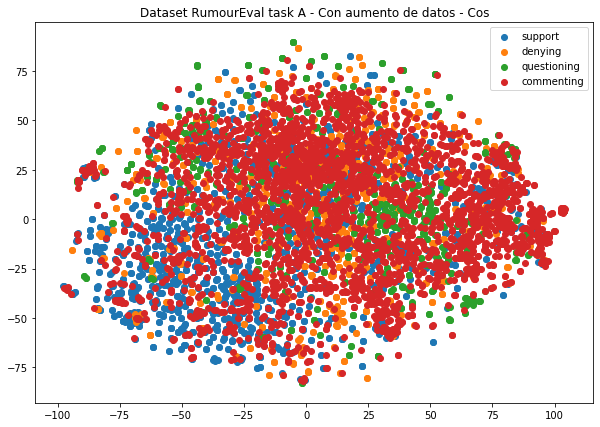

In [149]:
model = TSNE(2, metric='cosine')
to_plot_tsne = model.fit_transform(data_bas_c)    
plt.figure(figsize=(10,7))
for key in keys:
    labels=[dict_cl[lab] for lab in macro_augmented[:,2]]
    mask = np.asarray(labels)==key
    plt.scatter(to_plot_tsne[:,0][mask],to_plot_tsne[:,1][mask], label=str(key))

plt.legend()
plt.title("Dataset RumourEval task A - Con aumento de datos C - Cos")
plt.show()

macro_augmented = np.asarray(macro_augmented, dtype=object)
np.random.shuffle(macro_augmented)

### Sujeto a Clase ponderando target

In [153]:
macro_augmented=[]
for clase in aum_weight:
    start_time=time.time()
    print ("\n\nGenerando", aum_weight[clase], "ejemplos para", clase)
    muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, pond=True)
    macro_augmented+=muestras
    print ("Resumen de modificaciones:", dict_aumentos)
    elapsed_time= time.time() - start_time
    print ("Este proceso tomó", elapsed_time, "seg")   



Generando 841 ejemplos para support
Consultando por la clase support
Entrega label 0
Original: news  	Reemplazo:  [('excellent', 1.2101820707321167)]
Sentencia original:
['user' 'some' 'good' 'news' '!']
Sentencia final: 0
['user', 'some', 'good', 'excellent', '!']


Original: law  	Reemplazo:  [('lawyer', 1.2872103452682495)]
Sentencia original:
['shoot' 'unarmed' 'kid' '.' 'conceal' 'evidence' '.' 'impose' 'martial'
 'law' '.' 'harass' 'reporters' '.' 'smear' 'the' 'victim' '.' 'worst' '.'
 'police' '.' 'ever' '.' 'hashtag' 'hashtag']
Sentencia final: 0
['shoot', 'unarmed', 'kid', '.', 'conceal', 'evidence', '.', 'impose', 'martial', 'lawyer', '.', 'harass', 'reporters', '.', 'smear', 'the', 'victim', '.', 'worst', '.', 'police', '.', 'ever', '.', 'hashtag', 'hashtag']


Original: paris  	Reemplazo:  [('photograph', 0.9207580089569092)]
Sentencia original:
['“' 'user' ':' 'several' 'hostages' 'freed' 'at' 'jewish' 'supermarket'
 'in' 'paris' '.' 'photo' 'thomas' 'samson' 'hashtag' 

Original: paris  	Reemplazo:  [('shoot', 1.2736269235610962)]
Sentencia original:
['hashtag' '-' 'number' 'dead' 'including' 'number' 'police' 'in' 'paris'
 'shooting' '.' 'photo' 'user' 'hashtag' 'html']
Sentencia final: 0
['hashtag', '-', 'number', 'dead', 'including', 'number', 'police', 'in', 'shoot', 'shooting', '.', 'photo', 'user', 'hashtag', 'html']


Original: assassinated  	Reemplazo:  [('made', 0.8066034317016602)]
Sentencia original:
['so' 'if' 'hashtag' 'had' 'hashtag' 'assassinated' 'was' 'it' 'at' 'the'
 'direction' 'of' 'putin' 'or' 'is' 'was' 'putin' 'at' 'the' 'direction'
 'of' 'fsb' 'kadyrov' '?' 'hmm']
Sentencia final: 0
['so', 'if', 'hashtag', 'had', 'hashtag', 'made', 'was', 'it', 'at', 'the', 'direction', 'of', 'putin', 'or', 'is', 'was', 'putin', 'at', 'the', 'direction', 'of', 'fsb', 'kadyrov', '?', 'hmm']


Original: sydney  	Reemplazo:  [('nsw', 1.2047349214553833)]
Sentencia original:
['thoughts' 'go' 'out' 'to' 'those' 'in' 'sydney' 'dealing' 'with' 'the'
 

Original: online  	Reemplazo:  [('stay', 1.1680529117584229)]
Sentencia original:
['“' 'user' ':' 'uber' 'says' 'it' 'has' 'hike' 'prices' 'in' 'sydney'
 'to' '"' 'encourage' 'more' 'drivers' 'to' 'come' 'online' '&amp' ';'
 'pick' 'up' 'hashtag' '”' 'uber=ugly' 'opportunism' '!']
Sentencia final: 0
['“', 'user', ':', 'uber', 'says', 'it', 'has', 'hike', 'threatens', 'in', 'sydney', 'to', '"', 'encourage', 'more', 'drivers', 'to', 'come', 'stay', '&amp', ';', 'pick', 'up', 'hashtag', '”', 'uber=ugly', 'opportunism', '!']


Original: calling  	Reemplazo:  [('yelling', 0.7504642605781555)]
Original: something  	Reemplazo:  [('somebody', 0.6036984324455261)]
Original: was  	Reemplazo:  [('were', 0.8550326824188232)]
Original: targeted  	Reemplazo:  [('tagged', 0.7999325394630432)]
Sentencia original:
['user' 'u' 'r' 'among' 'the' 'only' 'journalists' 'saying' 'kosher'
 'market' '&amp' ';' 'not' 'calling' 'it' 'something' 'generic' '.' 'if'
 'it' "'" 's' 'kosher' 'it' 'was' 'targeted' '.' 

Original: sharing  	Reemplazo:  [('encompassing', 0.4695272147655487)]
Original: i  	Reemplazo:  [('vi', 0.4943174719810486)]
Original: am  	Reemplazo:  [('are', 0.29325833916664124)]
Sentencia original:
['user' 'emm' 'i' 'never' ',' 'i' 'tagged' 'the' 'user' '.' 'not' 'my'
 'video' "'" 's' 'grace' '.' 'i' 'am' '"' 'shaunynews' '"' 'i' 'share'
 'news' '.' 'i' 'am' 'just' 'sharing' 'what' 'i' 'am' 'being' 'sent' '.']
Sentencia final: 0
['user', 'emm', 'i', 'never', ',', 'i', 'tagged', 'the', 'user', '.', 'not', 'my', 'video', "'", 's', 'grace', '.', 'i', 'am', '"', 'shaunynews', '"', 'i', 'share', 'news', '.', 'i', 'am', 'just', 'encompassing', 'what', 'vi', 'are', 'being', 'sent', '.']


Original: people  	Reemplazo:  [('dies', 0.27301520109176636)]
Original: died  	Reemplazo:  [('had', 0.5015892386436462)]
Original: being  	Reemplazo:  [('having', 0.7902805209159851)]
Sentencia original:
['“' 'user' ':' 'hashtag' ':' 'at' 'least' 'two' 'people' 'have' 'died'
 'following' 'the' 'hashta

Original: region  	Reemplazo:  [('east', 0.776954710483551)]
Sentencia original:
['paris' 'says' 'highest' 'alert' 'level' 'extended' 'north' 'to' 'region'
 'where' 'attack' 'suspects' 'spotted' '-' 'user' ',' 'user' 'html']
Sentencia final: 0
['paris', 'says', 'highest', 'alert', 'level', 'extended', 'north', 'to', 'east', 'where', 'attack', 'suspects', 'spotted', '-', 'user', ',', 'user', 'html']


Original: honour  	Reemplazo:  [('honor', 0.9704834818840027)]
Sentencia original:
['this' 'afternoon' 'we' "'" 've' 'lowered' 'our' 'flags' 'to' 'half'
 'mast' 'in' 'honour' 'of' 'the' 'canadian' 'reservist' 'who' 'lost' 'his'
 'life' 'in' 'ottawa' '.' 'html']
Sentencia final: 0
['this', 'afternoon', 'we', "'", 've', 'lowered', 'our', 'flags', 'to', 'half', 'mast', 'in', 'honor', 'of', 'the', 'canadian', 'reservist', 'who', 'lost', 'his', 'life', 'in', 'ottawa', '.', 'html']


Original: are  	Reemplazo:  [('am', 0.7526029348373413)]
Sentencia original:
['user' 'the' '"' 'five' 'eyes' '"' 

Original: rt  	Reemplazo:  [('time', 3.679368257522583)]
Original: cover  	Reemplazo:  [('compelling', 0.4816257357597351)]
Sentencia original:
['rt' 'user' ':' 'more' 'shots' 'fired' 'just' 'off' 'parliament' 'hill'
 '.' 'police' 'telling' 'everyone' 'to' 'take' 'cover' '.' 'user']
Sentencia final: 0
['time', 'user', ':', 'more', 'shots', 'fired', 'just', 'off', 'parliament', 'hill', '.', 'police', 'telling', 'everyone', 'to', 'take', 'compelling', '.', 'user']


Original: call  	Reemplazo:  [('man', 0.737811803817749)]
Original: baby  	Reemplazo:  [('drive', 1.1743342876434326)]
Sentencia original:
['user' 'user' 'mazaltov' '!' 'they' 'could' 'call' 'the' 'baby'
 'ukrainia' '.']
Sentencia final: 0
['user', 'user', 'mazaltov', '!', 'they', 'could', 'man', 'the', 'drive', 'ukrainia', '.']


Original: informed  	Reemplazo:  [('assassinated', 0.7657359838485718)]
Original: shooter  	Reemplazo:  [('man', 0.7407427430152893)]
Original: ottawa  	Reemplazo:  [('die', 0.8387659788131714)]
Ori

Original: seem  	Reemplazo:  [('become', 0.5447144508361816)]
Original: be  	Reemplazo:  [('appear', 0.7973451614379883)]
Sentencia original:
['user' 'user' 'user' 'you' 'seem' 'to' 'be' 'the' 'only' 'one' 'and'
 'that' 'is' 'a' 'testament' 'to' 'your' 'character' 'miss' '.']
Sentencia final: 0
['user', 'user', 'user', 'you', 'become', 'to', 'appear', 'the', 'only', 'one', 'and', 'that', 'is', 'a', 'testament', 'to', 'your', 'character', 'miss', '.']


Original: usual  	Reemplazo:  [('traditional', 1.1153371334075928)]
Sentencia original:
['“' 'user' ':' 'number' 'now' 'confirmed' 'dead' 'in' 'hashtag' 'attack'
 'in' 'paris' ',' 'user' 'is' 'reporting' '.' 'story' ':' 'html' 'ap'
 'islam' 'as' 'usual' '.']
Sentencia final: 0
['“', 'user', ':', 'number', 'now', 'confirmed', 'dead', 'in', 'hashtag', 'attack', 'in', 'paris', ',', 'user', 'is', 'reporting', '.', 'story', ':', 'html', 'ap', 'islam', 'as', 'traditional', '.']


Original: gunmen  	Reemplazo:  [('militants', 0.8614781498908997

Original: mud  	Reemplazo:  [('outrage', 0.7298076748847961)]
Sentencia original:
['the' 'press' 'conf' 'makes' 'hashtag' 'pd' 'look' 'like' 'they' "'" 've'
 'gone' 'from' 'stonewalling' 'to' 'counter' 'punching' '.' 'we' 'give'
 'up' 'a' 'name' ',' 'we' 'drag' 'his' 'thru' 'the' 'mud' '.']
Sentencia final: 0
['the', 'press', 'conf', 'makes', 'hashtag', 'pd', 'look', 'like', 'they', "'", 've', 'gone', 'from', 'stonewalling', 'to', 'counter', 'punching', '.', 'we', 'give', 'up', 'a', 'name', ',', 'we', 'drag', 'his', 'thru', 'the', 'outrage', '.']


Original: need  	Reemplazo:  [('want', 1.2630234956741333)]
Sentencia original:
['user' 'seriously' 'fed' 'up' 'with' 'this' '.' 'it' 'has' 'to' 'be'
 'stopped' '.' 'nowhere' 'is' 'safe' 'nowadays' '.' 'it' "'" 's' 'sydney'
 '!' 'australia' 'doesn' "'" 't' 'need' 'this' 's**t' 'now' 'too' '!']
Sentencia final: 0
['user', 'seriously', 'fed', 'up', 'with', 'this', '.', 'it', 'has', 'to', 'be', 'stopped', '.', 'nowhere', 'is', 'safe', 'nowadays

Sentencia final: 0
['uber', 'says', 'it', 'has', 'leftist', 'prices', 'in', 'sydney', 'to', '"', 'encourage', 'more', 'drivers', 'to', 'come', 'online', '&amp', ';', 'pick', 'up', 'passengers', '.', '"', 'html', 'hashtag']


Original: killing  	Reemplazo:  [('attacking', 0.6105012893676758)]
Sentencia original:
['user' 'user' 'what' 'about' 'drone' 'killing' 'innocent' 'bystanders'
 'that' 'are' 'near' 'an' 'alleged' 'bad' 'guy' '?' 'we' 'turn' 'cheek'
 'no' 'twitter' 'outrage']
Sentencia final: 0
['user', 'user', 'what', 'about', 'drone', 'attacking', 'innocent', 'bystanders', 'that', 'are', 'near', 'an', 'alleged', 'bad', 'guy', '?', 'we', 'turn', 'cheek', 'no', 'twitter', 'outrage']


Original: holding  	Reemplazo:  [('wearing', 1.1319645643234253)]
Sentencia original:
['“' 'user' ':' 'official' ':' 'gunman' 'holding' 'at' 'least' 'number'
 'hostages' 'in' 'paris' 'market' 'has' 'threatened' 'to' 'kill' 'them'
 'if' 'police' 'approach' ':' 'html']
Sentencia final: 0
['“', 'user', ':

Original: came  	Reemplazo:  [('walked', 0.8111411929130554)]
Sentencia original:
['user' 'incorrect' '.' 'was' 'on' 'sick' 'person' 'call' '&amp' ';'
 'then' 'driving' 'came' 'across' 'brown' '&amp' ';' 'friend' 'walking'
 '&amp' ';' 'asked' 'they' 'get' 'off' 'the' 'road' 'user']
Sentencia final: 0
['user', 'incorrect', '.', 'was', 'on', 'sick', 'person', 'call', '&amp', ';', 'then', 'driving', 'walked', 'across', 'brown', '&amp', ';', 'friend', 'walking', '&amp', ';', 'asked', 'they', 'get', 'off', 'the', 'road', 'user']


Original: planned  	Reemplazo:  [('alleged', 0.4550149440765381)]
Sentencia original:
['us' 'embassy' 'hashtag' 'cables' 'talk' 'of' 'an' 'operation' 'planned'
 'by' '"' 'dissidents' '"' 'in' 'hashtag' 'to' '"' 'overthrow' 'putin' '"'
 '.' 'html' 'hashtag']
Sentencia final: 0
['us', 'embassy', 'hashtag', 'cables', 'talk', 'of', 'an', 'operation', 'alleged', 'by', '"', 'dissidents', '"', 'in', 'hashtag', 'to', '"', 'overthrow', 'putin', '"', '.', 'html', 'hashtag']

Original: milan  	Reemplazo:  [('paris', 0.7635400295257568)]
Original: michael  	Reemplazo:  [('qaeda', 2.2369961738586426)]
Sentencia original:
['“' 'user' ':' 'ac' 'milan' 'midfielder' 'michael' 'essien' 'has' 'been'
 'diagnosed' 'with' 'ebola' '.' 'get' 'well' 'soon' 'michael' '.' '[daily'
 'times]' 'html']
Sentencia final: 0
['“', 'user', ':', 'ac', 'paris', 'midfielder', 'michael', 'essien', 'has', 'been', 'diagnosed', 'with', 'ebola', '.', 'get', 'well', 'soon', 'qaeda', '.', '[daily', 'times]', 'html']


Original: freed  	Reemplazo:  [('leftist', 0.5560089945793152)]
Original: paris  	Reemplazo:  [('photograph', 0.6522747874259949)]
Original: thomas  	Reemplazo:  [('henry', 0.7355179190635681)]
Sentencia original:
['several' 'hostages' 'freed' 'at' 'jewish' 'supermarket' 'in' 'paris' '.'
 'photo' 'thomas' 'samson' 'hashtag' 'html']
Sentencia final: 0
['several', 'hostages', 'leftist', 'at', 'jewish', 'supermarket', 'in', 'photograph', '.', 'photo', 'henry', 'samson', 'hashtag',

Original: sure  	Reemplazo:  [('didn', 0.9132612943649292)]
Sentencia original:
['user' 'it' 'sure' 'did' '.' 'a' 'boon' 'to' 'my' 'hashtag']
Sentencia final: 0
['user', 'it', 'didn', 'did', '.', 'a', 'boon', 'to', 'my', 'hashtag']


Original: latest  	Reemplazo:  [('worst', 0.6877942085266113)]
Sentencia original:
['hashtag' ':' 'latest' 'video' 'of' 'hostages' 'escaping' '.' 'html']
Sentencia final: 0
['hashtag', ':', 'worst', 'video', 'of', 'hostages', 'escaping', '.', 'html']


Original: received  	Reemplazo:  [('treated', 0.7428306341171265)]
Original: stable  	Reemplazo:  [('reliable', 0.5396484136581421)]
Sentencia original:
['statement' 'from' 'ottawa' 'hospital' ':' 'received' 'number' 'patients'
 '.' 'number' 'in' 'stable' 'condition' '.' 'html']
Sentencia final: 0
['statement', 'from', 'ottawa', 'hospital', ':', 'treated', 'number', 'patients', '.', 'number', 'in', 'reliable', 'condition', '.', 'html']


Original: unarmed  	Reemplazo:  [('interested', 2.2358908653259277)]
Or

Original: true  	Reemplazo:  [('false', 1.1589374542236328)]
Sentencia original:
['user' 'radio' 'canada' 'tweeting' 'same' '.' 'must' 'be' 'true' ':' '-']
Sentencia final: 0
['user', 'radio', 'canada', 'tweeting', 'same', '.', 'must', 'be', 'false', ':', '-']


Original: cafe  	Reemplazo:  [('house', 1.9335190057754517)]
Original: held  	Reemplazo:  [('hold', 0.8243754506111145)]
Sentencia original:
['hashtag' 'hashtag' 'hashtag' 'user' ':' 'hashtag' 'hashtag' 'held'
 'inside' 'hashtag' 'cafe' ',' 'islamic' 'flag' 'held' 'up']
Sentencia final: 0
['hashtag', 'hashtag', 'hashtag', 'user', ':', 'hashtag', 'hashtag', 'held', 'inside', 'hashtag', 'house', ',', 'islamic', 'flag', 'hold', 'up']


Original: updates  	Reemplazo:  [('arms', 1.1779416799545288)]
Original: right  	Reemplazo:  [('muslim', 0.5777654051780701)]
Sentencia original:
['“' 'user' ':' 'live' 'updates' ':' 'siege' 'in' 'sydney' 'cafe' '"'
 '&gt' ';' 'guess' 'who' '.' 'that' "'" 's' 'right' 'muslims' 'html']
Sentencia fina

Original: putin  	Reemplazo:  [('qaeda', 3.1463024616241455)]
Sentencia original:
['putin' 'reappears' 'on' 'television' 'amid' 'rumours' 'his' "'"
 'girlfriend' "'" 'is' 'about' 'number' 'give' 'birth' 'html' 'html'
 'user']
Sentencia final: 0
['qaeda', 'reappears', 'on', 'television', 'amid', 'rumours', 'his', "'", 'girlfriend', "'", 'is', 'about', 'number', 'give', 'birth', 'html', 'html', 'user']


Original: developing  	Reemplazo:  [('hurting', 1.1939101219177246)]
Original: feed  	Reemplazo:  [('weaken', 0.5530960559844971)]
Sentencia original:
['developing' ':' 'police' 'pursuing' 'hashtag' 'shooting' 'suspects' ','
 'helicopters' 'deployed' '-' 'live' 'feed' ':' 'html' 'html']
Sentencia final: 0
['hurting', ':', 'police', 'pursuing', 'hashtag', 'shooting', 'suspects', ',', 'helicopters', 'deployed', '-', 'live', 'weaken', ':', 'html', 'html']


Original: shots  	Reemplazo:  [('specialists', 0.2576116919517517)]
Original: fired  	Reemplazo:  [('harmed', 0.4720529019832611)]
Orig

Original: be  	Reemplazo:  [('impose', 0.8511767983436584)]
Sentencia original:
['prince' 'rumoured' 'to' 'be' 'performing' 'in' 'surprise' 'show' 'in'
 'toronto' 'html' 'html']
Sentencia final: 0
['prince', 'rumoured', 'to', 'impose', 'performing', 'in', 'surprise', 'show', 'in', 'toronto', 'html', 'html']


Original: paris  	Reemplazo:  [('urgent', 0.7781257033348083)]
Sentencia original:
['number' 'confirmed' 'dead' ',' 'francois' 'holland' 'to' 'visit' 'scene'
 'of' 'attack' '-' 'latest' 'from' 'paris' ':' 'html' 'html']
Sentencia final: 0
['number', 'confirmed', 'dead', ',', 'francois', 'holland', 'to', 'visit', 'scene', 'of', 'attack', '-', 'latest', 'from', 'urgent', ':', 'html', 'html']


Original: killed  	Reemplazo:  [('murdered', 0.28878411650657654)]
Original: paris  	Reemplazo:  [('london', 1.2189674377441406)]
Sentencia original:
['“' 'user' ':' 'at' 'least' 'number' 'killed' 'in' 'today' "'" 's'
 'attack' 'on' 'satirical' 'magazine' 'hashtag' 'in' 'paris' ','
 'official'

Original: terrorist  	Reemplazo:  [('horrific', 0.35492438077926636)]
Sentencia original:
['user' 'oh' 'and' 'our' 'anti' '-' 'terrorist' 'plan' 'has' 'just' 'been'
 'put' 'to' 'its' 'highest' 'level' 'in' 'the' 'part' 'in' 'which' 'the'
 'drama' "'" 's' 'happening' '.']
Sentencia final: 0
['user', 'oh', 'and', 'our', 'anti', '-', 'horrific', 'plan', 'has', 'just', 'been', 'put', 'to', 'its', 'highest', 'level', 'in', 'the', 'part', 'in', 'which', 'the', 'drama', "'", 's', 'happening', '.']


Original: young  	Reemplazo:  [('former', 1.749982237815857)]
Original: son  	Reemplazo:  [('nephew', 1.0191982984542847)]
Sentencia original:
['soldier' 'killed' 'in' 'canada' 'shooting' 'was' 'a' 'young' 'reservist'
 'with' 'a' 'six' '-' 'year' '-' 'old' 'son' 'html' 'html']
Sentencia final: 0
['soldier', 'killed', 'in', 'canada', 'shooting', 'was', 'a', 'former', 'reservist', 'with', 'a', 'six', '-', 'year', '-', 'old', 'nephew', 'html', 'html']


Original: opera  	Reemplazo:  [('actor', 1.2333

Original: done  	Reemplazo:  [('gone', 1.2351789474487305)]
Sentencia original:
['user' 'well' 'done' '.' 'this' 'kind' 'of' 'information' 'is'
 'important' 'to' 'remain' 'secret' 'for' 'the' 'sake' 'of' 'the' 'safety'
 'of' 'the' 'hostages' '!']
Sentencia final: 0
['user', 'well', 'gone', '.', 'this', 'kind', 'of', 'information', 'is', 'important', 'to', 'remain', 'secret', 'for', 'the', 'sake', 'of', 'the', 'safety', 'of', 'the', 'hostages', '!']


Original: take  	Reemplazo:  [('assume', 0.6686373949050903)]
Original: flag  	Reemplazo:  [('fascism', 0.4631398916244507)]
Sentencia original:
['hashtag' 'news' ':' 'gunmen' 'take' 'hostages' 'at' 'sydney' 'cafe' ','
 'wave' 'islamic' 'flag' 'html' 'html' 'via' 'user']
Sentencia final: 0
['hashtag', 'news', ':', 'gunmen', 'assume', 'hostages', 'at', 'sydney', 'cafe', ',', 'wave', 'islamic', 'fascism', 'html', 'html', 'via', 'user']


Original: wrong  	Reemplazo:  [('suspicious', 0.5713856816291809)]
Original: getting  	Reemplazo:  [('hav

Original: t  	Reemplazo:  [('tease', 0.5009812712669373)]
Sentencia original:
['user' 'user' 'user' 'apparantely' 'this' 'loner' 'is' 'not' 'isis' ','
 'and' 'i' 'don' "'" 't' 'think' 'cowboy' 'comments' 'like' 'this' 'help'
 'right' 'now' '.']
Sentencia final: 0
['user', 'user', 'user', 'apparantely', 'this', 'loner', 'is', 'not', 'isis', ',', 'and', 'i', 'man', "'", 'tease', 'think', 'cowboy', 'comments', 'like', 'this', 'help', 'right', 'now', '.']


Original: number  	Reemplazo:  [('customer', 0.7914134860038757)]
Sentencia original:
['+' 'number' '|' 'user' ':' '"' 'most' 'compelling' 'image' 'i' "'" 've'
 'seen' 'to' 'come' 'out' 'of' 'horrifying' 'events' 'in' 'paris' ','
 'courtesy' 'of' 'banksy' '.' 'html']
Sentencia final: 0
['+', 'customer', '|', 'user', ':', '"', 'most', 'compelling', 'image', 'i', "'", 've', 'seen', 'to', 'come', 'out', 'of', 'horrifying', 'events', 'in', 'paris', ',', 'courtesy', 'of', 'banksy', '.', 'html']


Original: shot  	Reemplazo:  [('gunshot', 1.9

Original: flag  	Reemplazo:  [('islam', 0.5066075325012207)]
Sentencia original:
['breaking' 'news' ':' 'gunmen' 'take' 'hostages' 'at' 'sydney' 'cafe' ','
 'wave' 'islamic' 'flag' 'html' 'html']
Sentencia final: 0
['breaking', 'news', ':', 'gunmen', 'take', 'militants', 'at', 'sydney', 'cafe', ',', 'wave', 'disciplinary', 'islam', 'html', 'html']


Original: heard  	Reemplazo:  [('found', 0.44431209564208984)]
Sentencia original:
['user' 'best' 'news' 'i' 'have' 'heard' ',' 'kay' 'you' 'are' 'doing'
 'an' 'amazing' 'job' 'thank' 'you']
Sentencia final: 0
['user', 'best', 'news', 'i', 'have', 'found', ',', 'kay', 'you', 'are', 'doing', 'an', 'amazing', 'job', 'thank', 'you']


Original: station  	Reemplazo:  [('supermarket', 0.8411357402801514)]
Sentencia original:
['"' 'user' ':' 'the' 'hashtag' 'attack' 'suspects' 'have' 'reportedly'
 'fired' 'shots' 'while' 'rob' 'a' 'petrol' 'station' 'html' 'hashtag']
Sentencia final: 0
['"', 'user', ':', 'the', 'hashtag', 'attack', 'suspects', 'h

Original: breaking  	Reemplazo:  [('stealing', 0.7475274801254272)]
Original: hostage  	Reemplazo:  [('situation', 1.4855587482452393)]
Original: paris  	Reemplazo:  [('condemn', 0.549747884273529)]
Sentencia original:
['hashtag' '“' 'user' ':' 'breaking' ':' 'two' 'hostage' 'situations' 'in'
 'france' 'are' 'linked' ',' 'paris' 'prosecutor' 'says' '"']
Sentencia final: 0
['hashtag', '“', 'user', ':', 'stealing', ':', 'two', 'situation', 'situations', 'in', 'france', 'are', 'linked', ',', 'condemn', 'prosecutor', 'says', '"']


Original: meaning  	Reemplazo:  [('carnage', 0.5987142324447632)]
Sentencia original:
['user' 'australian' 'govt' 'language' 'specialists' 'defined' 'these'
 'words' 'as' 'all' '-' 'encompassing' 'meaning' 'any' 'action'
 'perpetrated' 'against' 'australian' 'citizens']
Sentencia final: 0
['user', 'australian', 'govt', 'language', 'specialists', 'defined', 'these', 'words', 'as', 'all', '-', 'encompassing', 'carnage', 'any', 'action', 'perpetrated', 'against', '

Original: hostage  	Reemplazo:  [('leftist', 0.38191425800323486)]
Sentencia original:
['thoughts' 'go' 'out' 'to' 'those' 'in' 'sydney' 'dealing' 'with' 'the'
 'number' '-' 'hostage' 'situation' '“' 'user' 'html']
Sentencia final: 0
['thoughts', 'go', 'out', 'to', 'those', 'in', 'sydney', 'dealing', 'with', 'the', 'captive', '-', 'leftist', 'situation', '“', 'user', 'html']


Original: is  	Reemplazo:  [('has', 1.257035255432129)]
Sentencia original:
['user' 'so' 'sad' '.' 'this' 'is' 'not' 'right' '.' 'hashtag' 'hashtag'
 'hashtag' 'hashtag']
Sentencia final: 0
['user', 'so', 'sad', '.', 'this', 'has', 'not', 'right', '.', 'hashtag', 'hashtag', 'hashtag', 'hashtag']


Original: shoot  	Reemplazo:  [('shot', 1.4342083930969238)]
Sentencia original:
['hashtag' 'to' 'hold' 'news' 'conference' 'on' 'hashtag' 'shoot' 'at'
 'number' 'pm' 'et' ',' 'number' 'am' 'pt' '.' 'watch' 'live' 'coverage'
 '@' 'html']
Sentencia final: 0
['hashtag', 'to', 'hold', 'news', 'conference', 'on', 'hashtag',

Sentencia final: 0
['user', 'user', 'user', 'a', 'jehovah', "'", 's', 'witness', 'extremist', '?', 'mormon', 'extremist', '?', 'roman', 'catholic', 'extremist', '?', 'etc', '.', 'non', 'existent', '!', 'qaeda', '.', '?', '?', '?']


Original: half  	Reemplazo:  [('part', 1.1690359115600586)]
Sentencia original:
['user' 'curly' 'wurlys' 'are' 'so' 'much' 'nicer' 'than' 'half'
 'avocados' 'dont' 'u' 'think' '?']
Sentencia final: 0
['user', 'curly', 'wurlys', 'are', 'so', 'much', 'nicer', 'than', 'part', 'avocados', 'dont', 'u', 'think', '?']


Original: guys  	Reemplazo:  [('confirms', 0.5897955298423767)]
Sentencia original:
['user' 'you' 'guys' '"' 'confirmed' '"' 'there' 'were' 'number' 'shoot'
 'not' 'long' 'ago' '.' 'how' 'about' 'you' 'wait' 'for' 'official'
 'reports' 'before' 'saying' 'things' '.']
Sentencia final: 0
['user', 'you', 'confirms', '"', 'confirmed', '"', 'there', 'were', 'number', 'shoot', 'not', 'long', 'ago', '.', 'how', 'about', 'you', 'wait', 'for', 'official', '

Original: dead  	Reemplazo:  [('military', 0.7613715529441833)]
Sentencia original:
['user' 'war' 'memorial' 'soldier' 'pronounced' 'dead' 'just' 'now' '.']
Sentencia final: 0
['user', 'war', 'memorial', 'soldier', 'pronounced', 'military', 'just', 'now', '.']


Original: link  	Reemplazo:  [('connection', 1.2769055366516113)]
Original: video  	Reemplazo:  [('report', 0.3158809244632721)]
Original: involving  	Reemplazo:  [('including', 1.1159648895263672)]
Sentencia original:
['new' 'link' ':' 'hashtag' 'police' 'release' 'video' 'they' 'say'
 'shows' 'a' 'robbery' 'involving' 'hashtag' ':' 'html' 'html']
Sentencia final: 0
['new', 'connection', ':', 'hashtag', 'police', 'release', 'report', 'they', 'say', 'shows', 'a', 'robbery', 'including', 'hashtag', ':', 'html', 'html']


Original: people  	Reemplazo:  [('men', 0.451937735080719)]
Original: have  	Reemplazo:  [('be', 0.3309287428855896)]
Sentencia original:
['update' ':' 'total' 'of' 'number' 'people' 'have' 'been' 'able' 'to'
 '

Original: parliament  	Reemplazo:  [('congress', 0.8026421666145325)]
Sentencia original:
['“' 'user' ':' 'watch' 'video' 'showing' 'gunfire' 'inside' 'canada' "'"
 's' 'parliament' 'in' 'ottawa' 'html' 'html' 'omg' '!']
Sentencia final: 0
['“', 'user', ':', 'watch', 'video', 'watching', 'gunshot', 'inside', 'canada', "'", 's', 'congress', 'in', 'ottawa', 'html', 'html', 'omg', '!']


Original: muslims  	Reemplazo:  [('terrorists', 0.3884297311306)]
Original: are  	Reemplazo:  [('am', 0.4223538339138031)]
Original: afraid  	Reemplazo:  [('weaken', 0.5701032876968384)]
Original: god  	Reemplazo:  [('death', 1.9189850091934204)]
Sentencia original:
['user' 'user' 'why' 'muslims' 'killed' 'non' '-' 'muslims' '?' 'why'
 'muslims' 'are' 'not' 'afraid' 'of' 'mighty' 'god' '?' 'why' 'god' 'of'
 'muslims' 'is' 'cruel' 'and' 'say' 'kill' 'infidel' '?']
Sentencia final: 0
['user', 'user', 'why', 'terrorists', 'killed', 'non', '-', 'muslims', '?', 'why', 'muslims', 'am', 'not', 'weaken', 'of', 'm

Original: secret  	Reemplazo:  [('compelling', 0.3453822135925293)]
Sentencia original:
['“' 'user' ':' 'secret' 'prince' 'show' 'rumored' 'for' 'toronto'
 'tonight' 'html' 'wishing' 'this' 'was' 'nyc' 'user']
Sentencia final: 0
['“', 'user', ':', 'compelling', 'prince', 'show', 'rumored', 'for', 'toronto', 'tonight', 'html', 'wishing', 'this', 'was', 'nyc', 'user']


Original: contact  	Reemplazo:  [('france', 0.7786442041397095)]
Sentencia original:
['hashtag' 'suspects' '"' 'prepared' 'to' 'die' 'as' 'martyrs' '"' ','
 'they' 'tell' 'police' 'after' 'making' 'contact' '-' 'french' 'media'
 'html']
Sentencia final: 0
['hashtag', 'suspects', '"', 'prepared', 'to', 'die', 'as', 'martyrs', '"', ',', 'they', 'tell', 'police', 'after', 'making', 'france', '-', 'french', 'media', 'html']


Original: showing  	Reemplazo:  [('watching', 1.0172621011734009)]
Original: canada  	Reemplazo:  [('india', 0.7672263383865356)]
Sentencia original:
['“' 'user' ':' 'watch' 'video' 'showing' 'gunfire' '

Original: photo  	Reemplazo:  [('photograph', 1.07853364944458)]
Sentencia original:
['“' 'user' ':' 'several' 'hostages' 'freed' 'at' 'jewish' 'supermarket'
 'in' 'paris' '.' 'photo' 'thomas' 'samson' 'hashtag' 'html']
Sentencia final: 0
['“', 'user', ':', 'several', 'hostages', 'jew', 'at', 'jewish', 'grocery', 'in', 'paris', '.', 'photograph', 'thomas', 'samson', 'hashtag', 'html']


Original: taking  	Reemplazo:  [('killing', 0.7576425075531006)]
Original: hostages  	Reemplazo:  [('perpetrators', 0.6614833474159241)]
Sentencia original:
['“' 'user' ':' 'police' 'taking' 'people' 'out' 'of' 'hashtag' 'grocery'
 'where' 'hostages' 'were' 'being' 'held' '.' 'html']
Sentencia final: 0
['“', 'user', ':', 'police', 'killing', 'people', 'out', 'of', 'hashtag', 'grocery', 'where', 'perpetrators', 'were', 'being', 'held', '.', 'html']


Original: hostages  	Reemplazo:  [('threatens', 0.9010406732559204)]
Original: coffee  	Reemplazo:  [('nsw', 0.5144942998886108)]
Sentencia original:
['upda

Original: s  	Reemplazo:  [('peace', 0.7569672465324402)]
Original: memorial  	Reemplazo:  [('horrific', 0.19180825352668762)]
Original: was  	Reemplazo:  [('propelled', 0.3279378414154053)]
Sentencia original:
['witness' 'tells' 'hashtag' 'suspected' 'shooter' 'of' 'uniformed'
 'soldier' 'at' 'hashtag' "'" 's' 'war' 'memorial' 'was' 'carrying'
 'rifle' '.']
Sentencia final: 0
['witness', 'tells', 'hashtag', 'assassinated', 'shooter', 'of', 'uniformed', 'soldier', 'at', 'hashtag', "'", 'peace', 'war', 'horrific', 'propelled', 'carrying', 'rifle', '.']


Original: right  	Reemplazo:  [('left', 0.7835172414779663)]
Sentencia original:
['user' 'hashtag' 'needs' 'to' 'hashtag' 'html' 'hashtag' 'brown' 'family'
 'says' ',' 'hashtag' 'hashtag' 'they' "'" 're' 'right']
Sentencia final: 0
['user', 'hashtag', 'needs', 'to', 'hashtag', 'html', 'hashtag', 'brown', 'family', 'says', ',', 'hashtag', 'hashtag', 'they', "'", 're', 'left']


Original: murdered  	Reemplazo:  [('assassinated', 0.6697204

Original: hostage  	Reemplazo:  [('wasn', 2.097714424133301)]
Original: supermarket  	Reemplazo:  [('london', 1.375490665435791)]
Original: paris  	Reemplazo:  [('france', 0.836378812789917)]
Original: be  	Reemplazo:  [('believe', 0.6063817143440247)]
Original: suspect  	Reemplazo:  [('kill', 0.48868873715400696)]
Sentencia original:
['update' '-' 'afp' 'says' 'gunman' 'who' 'has' 'taken' 'a' 'hostage' 'at'
 'kosher' 'supermarket' 'in' 'paris' 'believed' 'to' 'be' 'suspect' 'in'
 'killing' 'of' 'policewoman' 'on' 'thursday']
Sentencia final: 0
['update', '-', 'afp', 'says', 'gunman', 'who', 'has', 'taken', 'a', 'wasn', 'at', 'kosher', 'london', 'in', 'france', 'believed', 'to', 'believe', 'kill', 'in', 'killing', 'of', 'policewoman', 'on', 'thursday']


Original: grocery  	Reemplazo:  [('supermarket', 0.8382243514060974)]
Sentencia original:
['“' 'user' ':' 'police' 'taking' 'people' 'out' 'of' 'hashtag' 'grocery'
 'where' 'hostages' 'were' 'being' 'held' '.' 'html']
Sentencia final: 

Original: talk  	Reemplazo:  [('speak', 1.352645754814148)]
Original: operation  	Reemplazo:  [('plan', 3.482362985610962)]
Sentencia original:
['us' 'embassy' 'hashtag' 'cables' 'talk' 'of' 'an' 'operation' 'planned'
 'by' '"' 'dissidents' '"' 'in' 'hashtag' 'to' '"' 'overthrow' 'putin' '"'
 '.' 'html' 'hashtag']
Sentencia final: 0
['us', 'embassy', 'hashtag', 'cables', 'speak', 'of', 'an', 'plan', 'planned', 'by', '"', 'dissidents', '"', 'in', 'hashtag', 'to', '"', 'overthrow', 'putin', '"', '.', 'html', 'hashtag']


Original: shooting  	Reemplazo:  [('killing', 0.6120426058769226)]
Original: source  	Reemplazo:  [('cop', 0.713119626045227)]
Sentencia original:
['rt' 'user' 'at' 'least' 'number' 'dead' 'in' 'shooting' 'at' 'hq' 'of'
 'hashtag' 'in' 'hashtag' 'police' 'source' 'html']
Sentencia final: 0
['rt', 'user', 'at', 'least', 'number', 'dead', 'in', 'killing', 'at', 'hq', 'of', 'hashtag', 'in', 'hashtag', 'police', 'cop', 'html']


Original: white  	Reemplazo:  [('black', 0.763

Original: release  	Reemplazo:  [('demand', 0.9045814871788025)]
Sentencia original:
['hostage' '-' 'taker' 'at' 'paris' 'store' 'demands' 'release' 'of'
 'hashtag' ',' 'police' 'union' 'spokesman' 'says' '.' 'html' 'html']
Sentencia final: 0
['hostage', '-', 'taker', 'at', 'paris', 'store', 'demands', 'demand', 'of', 'hashtag', ',', 'police', 'union', 'spokesman', 'says', '.', 'html', 'html']


Original: hostages  	Reemplazo:  [('viewers', 1.5316227674484253)]
Original: appear  	Reemplazo:  [('happen', 0.7321890592575073)]
Original: escaped  	Reemplazo:  [('had', 1.3573331832885742)]
Sentencia original:
['breaking' ':' 'three' 'hostages' 'appear' 'to' 'have' 'escaped' 'the'
 'sydney' 'cafe' 'where' 'a' 'siege' 'remains' 'ongoing' '.' 'html'
 'hashtag']
Sentencia final: 0
['breaking', ':', 'three', 'viewers', 'happen', 'to', 'have', 'had', 'the', 'sydney', 'cafe', 'where', 'a', 'siege', 'remains', 'ongoing', '.', 'html', 'hashtag']


Original: are  	Reemplazo:  [('am', 1.04928207397460

Original: surprise  	Reemplazo:  [('display', 0.7569761872291565)]
Original: sale  	Reemplazo:  [('qaeda', 2.318892478942871)]
Sentencia original:
['prince' 'fans' 'lining' 'up' 'at' 'massey' 'hall' '.' 'wristbands' 'for'
 'surprise' 'show' 'reportedly' 'on' 'sale' 'at' '6pm' '.' 'hashtag'
 'html']
Sentencia final: 0
['sheikh', 'rumours', 'lining', 'up', 'at', 'massey', 'hall', '.', 'wristbands', 'for', 'display', 'show', 'reportedly', 'on', 'qaeda', 'at', '6pm', '.', 'hashtag', 'html']


Original: black  	Reemplazo:  [('white', 0.962435781955719)]
Sentencia original:
['user' 'user' 'user' 'yes' '"' 'islamic' '"' 'flag' '.' 'black' 'a'
 'traditional' 'colour' 'of' 'islam' 'and' 'i' 'presume' 'a' 'koranic'
 'verse' 'also' '.']
Sentencia final: 0
['user', 'user', 'user', 'yes', '"', 'islamic', '"', 'flag', '.', 'white', 'a', 'traditional', 'colour', 'of', 'islam', 'and', 'i', 'presume', 'a', 'koranic', 'verse', 'also', '.']


Original: fake  	Reemplazo:  [('horrific', 0.7470906376838684)

Original: button  	Reemplazo:  [('stop', 0.7665433287620544)]
Original: is  	Reemplazo:  [('has', 0.441365122795105)]
Sentencia original:
['user' 'the' 'pause' 'button' 'is' 'broken' 'and' 'there' 'is' 'no'
 'rewind' 'function' '.' 'it' "'" 's' 'terrifying' 'when' 'you' 'think'
 'about' 'it' '.']
Sentencia final: 2
['user', 'the', 'pause', 'stop', 'has', 'broken', 'and', 'there', 'is', 'no', 'rewind', 'function', '.', 'it', "'", 's', 'terrifying', 'when', 'you', 'think', 'about', 'it', '.']


Original: ok  	Reemplazo:  [('okay', 3.315014600753784)]
Sentencia original:
['user' 'user' 'user' 'user' 'still' 'unclear' 'in' 'the' 'context' 'of'
 'the' 'shooting' 'of' 'an' 'unarmed' 'teen' '.' 'but' 'ok' '.']
Sentencia final: 2
['user', 'user', 'user', 'user', 'still', 'unclear', 'in', 'the', 'context', 'of', 'the', 'shooting', 'of', 'an', 'unarmed', 'teen', '.', 'but', 'okay', '.']


Original: source  	Reemplazo:  [('owner', 1.172008752822876)]
Sentencia original:
['user' 'source' 'plz' ':'

Original: was  	Reemplazo:  [('had', 0.5120964646339417)]
Original: anonymous  	Reemplazo:  [('questionable', 0.7775183320045471)]
Sentencia original:
['user' 'how' 'do' 'you' 'know' '?' 'i' 'thought' 'the' 'graffiti' '"'
 'artist' '"' 'was' 'supposed' 'to' 'be' 'anonymous' '.' 'user' 'user']
Sentencia final: 2
['user', 'how', 'do', 'you', 'know', '?', 'i', 'thought', 'the', 'graffiti', '"', 'artist', '"', 'had', 'supposed', 'to', 'be', 'questionable', '.', 'user', 'user']


Original: mother  	Reemplazo:  [('dad', 1.2152076959609985)]
Sentencia original:
['user' 'user' 'but' 'she' "'" 's' 'very' 'good' 'at' 'instigating' 'and'
 'bait' '.' 'just' 'like' 'her' 'mother' '.' 'smh']
Sentencia final: 2
['user', 'user', 'but', 'she', "'", 's', 'very', 'good', 'at', 'instigating', 'and', 'bait', '.', 'just', 'like', 'her', 'dad', '.', 'smh']


Original: t  	Reemplazo:  [('cnn', 0.5195512771606445)]
Sentencia original:
['user' 'user' 'who' 'could' 'be' 'doing' 'this' '?' 'and' 'why' '?' 'don'
 

Original: reports  	Reemplazo:  [('stories', 1.1329010725021362)]
Sentencia original:
['user' 'can' 'you' 'clarify' '-' 'are' 'the' 'six' 'hostages' 'and' 'one'
 'seriously' 'wounded' 'in' 'addition' 'to' 'the' 'reports' 'of' 'two'
 'killed' '?']
Sentencia final: 2
['user', 'can', 'you', 'clarify', '-', 'are', 'the', 'six', 'hostages', 'and', 'one', 'seriously', 'wounded', 'in', 'addition', 'to', 'the', 'stories', 'of', 'two', 'killed', '?']


Original: pricing  	Reemplazo:  [('isn', 0.6853587031364441)]
Sentencia original:
['user' 'user' 'don' '’' 't' 'they' 'mean' '“' 'siege' 'pricing' '"' '?']
Sentencia final: 2
['user', 'user', 'don', '’', 't', 'they', 'mean', '“', 'siege', 'isn', '"', '?']


Original: i  	Reemplazo:  [('world', 0.8401845693588257)]
Original: be  	Reemplazo:  [('get', 0.7191835045814514)]
Sentencia original:
['user' 'user' 'user' 'user' 'i' "'" 'm' 'not' 'arguing' 'that' 'he'
 'deserved' 'to' 'be' 'shot' '.']
Sentencia final: 2
['user', 'user', 'user', 'user', 'wor

Original: matter  	Reemplazo:  [('saw', 0.7231974005699158)]
Sentencia original:
['user' 'user' 'user' 'and' 'the' 'store' 'owner' 'and' 'the' 'pictures'
 'say' 'it' 'wasn' "'" 't' '.' 'why' 'does' 'someone' 'who' 'didn' "'" 't'
 'see' 'it' 'matter' '?']
Sentencia final: 2
['user', 'user', 'user', 'and', 'the', 'store', 'owner', 'and', 'the', 'pictures', 'say', 'it', 'wasn', "'", 't', '.', 'why', 'does', 'someone', 'who', 'didn', "'", 't', 'see', 'it', 'saw', '?']


Original: wait  	Reemplazo:  [('doesn', 1.210577368736267)]
Original: higher  	Reemplazo:  [('bigger', 0.6714940667152405)]
Sentencia original:
['wait' ',' 'does' "'" 'higher' 'rate' "'" 'mean' 'what' 'user' 'is'
 'paying' 'drivers' '?' 'hashtag']
Sentencia final: 2
['doesn', ',', 'does', "'", 'bigger', 'rate', "'", 'mean', 'what', 'user', 'is', 'paying', 'drivers', '?', 'hashtag']


Original: worst  	Reemplazo:  [('best', 0.4715787172317505)]
Original: reporters  	Reemplazo:  [('journalists', 0.7591441869735718)]
Sentencia

Sentencia original:
['user' 'user' 'and' 'who' 'would' 'blame' 'them' 'when' 'those'
 'authority' 'figures' 'are' 'gun' 'surrendering' 'suspects' 'down' '?']
Sentencia final: 2
['user', 'user', 'and', 'who', 'would', 'blame', 'them', 'when', 'those', 'authority', 'guns', 'are', 'suspect', 'surrendering', 'suspects', 'down', '?']


Original: i  	Reemplazo:  [('suppose', 1.3721225261688232)]
Sentencia original:
['user' 'i' 'assume' 'you' 'mean' 'niece' '?']
Sentencia final: 2
['user', 'suppose', 'assume', 'you', 'mean', 'niece', '?']


Original: aid  	Reemplazo:  [('worthless', 0.3656176030635834)]
Sentencia original:
['user' 'user' 'one' 'definition' '?' 'a' 'person' 'that' 'thinks' 'its'
 'ok' 'to' 'decapitate' 'innocent' 'journalists' 'aid' 'workers']
Sentencia final: 2
['user', 'user', 'one', 'definition', '?', 'a', 'person', 'that', 'thinks', 'its', 'ok', 'to', 'decapitate', 'innocent', 'journalists', 'worthless', 'workers']


Original: rides  	Reemplazo:  [('cheers', 0.761208117008

Original: cc  	Reemplazo:  [('manipulate', 0.5184594392776489)]
Sentencia original:
['user' 'cc' 'user']
Sentencia final: 2
['user', 'manipulate', 'user']


Original: context  	Reemplazo:  [('time', 1.8504395484924316)]
Original: shooting  	Reemplazo:  [('running', 1.1942778825759888)]
Sentencia original:
['user' 'user' 'user' 'user' 'still' 'unclear' 'in' 'the' 'context' 'of'
 'the' 'shooting' 'of' 'an' 'unarmed' 'teen' '.' 'but' 'ok' '.']
Sentencia final: 2
['user', 'user', 'user', 'user', 'still', 'unclear', 'in', 'the', 'time', 'of', 'the', 'running', 'of', 'an', 'unarmed', 'teen', '.', 'but', 'ok', '.']


Original: monday  	Reemplazo:  [('day', 0.7253819108009338)]
Original: terrorism  	Reemplazo:  [('terrorist', 0.5405737161636353)]
Sentencia original:
['user' 'true' '.' 'but' 'i' 'hear' 'there' 'was' 'a' 'similar' 'incident'
 'this' 'past' 'monday' '.' 'is' 'that' 'correct' '?' 'that' 'makes' 'me'
 'think' 'its' 'low' 'level' 'terrorism']
Sentencia final: 2
['user', 'true', '.',

Original: sorry  	Reemplazo:  [('shouldn', 1.7197513580322266)]
Sentencia original:
['user' 'user' 'user' 'sorry' 'what' 'now' '?']
Sentencia final: 2
['user', 'user', 'user', 'shouldn', 'what', 'now', '?']


Original: level  	Reemplazo:  [('supreme', 1.1912227869033813)]
Original: exist  	Reemplazo:  [('irrelevant', 0.4779919981956482)]
Sentencia original:
['user' 'user' 'maintain' 'high' 'level' 'of' 'vigilance' '?' 'against'
 'who' '?' 'obama' 'said' 'islamic' 'terrorists' 'don' "'" 't' 'exist'
 'in' 'america' 'remember' '?']
Sentencia final: 2
['user', 'user', 'maintain', 'high', 'supreme', 'of', 'vigilance', '?', 'against', 'who', '?', 'obama', 'said', 'islamic', 'terrorists', 'don', "'", 't', 'irrelevant', 'in', 'america', 'remember', '?']


Original: rates  	Reemplazo:  [('inquiries', 0.6556544899940491)]
Sentencia original:
['user' 'uber' 'is' 'covering' 'the' 'cost' 'of' 'all' 'rides' ','
 'drivers' 'will' 'still' 'receive' 'higher' 'rates' 'from' 'uber' 'html']
Sentencia fina


Original: pricing  	Reemplazo:  [('isn', 0.6853587031364441)]
Sentencia original:
['user' 'user' 'don' '’' 't' 'they' 'mean' '“' 'siege' 'pricing' '"' '?']
Sentencia final: 2
['user', 'user', 'don', '’', 't', 'they', 'mean', '“', 'siege', 'isn', '"', '?']


Original: michael  	Reemplazo:  [('peter', 1.1807456016540527)]
Original: movements  	Reemplazo:  [('thoughts', 0.6910945773124695)]
Original: was  	Reemplazo:  [('did', 0.5312055349349976)]
Sentencia original:
['if' 'michael' 'zehaf' '-' 'bebeau' 'had' 'his' 'passport' 'confiscated'
 'doesn' "'" 't' 'it' 'make' 'sense' 'to' 'track' 'his' 'movements' '-'
 'was' 'this' 'done' '?' 'user' 'user']
Sentencia final: 2
['if', 'peter', 'zehaf', '-', 'bebeau', 'had', 'his', 'passport', 'confiscated', 'doesn', "'", 't', 'it', 'make', 'sense', 'to', 'track', 'his', 'thoughts', '-', 'did', 'this', 'done', '?', 'user', 'user']


Original: attacker  	Reemplazo:  [('stupidity', 0.5454139709472656)]
Sentencia original:
['user' 'rather' 'than' 'bei

Original: motive  	Reemplazo:  [('man', 1.0984286069869995)]
Original: provide  	Reemplazo:  [('time', 1.8665744066238403)]
Sentencia original:
['user' 'really' '?' 'the' 'motive' 'is' 'unknown' '?' 'does' 'the' 'flag'
 'in' 'the' 'window' 'provide' 'any' 'possible' 'clue' '?' 'do' 'you'
 'employ' 'the' 'world' "'" 's' 'worst' 'reporters' '?']
Sentencia final: 2
['user', 'really', '?', 'the', 'man', 'is', 'unknown', '?', 'does', 'the', 'flag', 'in', 'the', 'window', 'time', 'any', 'possible', 'clue', '?', 'do', 'you', 'employ', 'the', 'world', "'", 's', 'worst', 'reporters', '?']


Original: alive  	Reemplazo:  [('open', 1.1924508810043335)]
Sentencia original:
['user' 'he' "'" 's' 'still' 'alive' '?' '?' '?']
Sentencia final: 2
['user', 'he', "'", 's', 'still', 'open', '?', '?', '?']


Original: is  	Reemplazo:  [('has', 0.4796174466609955)]
Original: were  	Reemplazo:  [('was', 1.3711508512496948)]
Sentencia original:
['user' 'all' 'there' 'is' 'a' 'still' 'picture' 'of' 'a' 'black' 

Original: been  	Reemplazo:  [('disgusted', 0.4894051253795624)]
Sentencia original:
['user' 'why' 'have' 'these' 'worthless' 'prick' 'not' 'been' 'taken'
 'out' 'yet' '?']
Sentencia final: 2
['user', 'why', 'have', 'these', 'worthless', 'prick', 'not', 'disgusted', 'taken', 'out', 'yet', '?']


Original: budget  	Reemplazo:  [('shouldn', 2.162567377090454)]
Sentencia original:
['user' 'user' 'you' 'say' 'what' '?' 'blackout' '?' 'how' 'will' 'the'
 'hide' 'the' 'budget' 'then' '?']
Sentencia final: 2
['user', 'user', 'you', 'say', 'what', '?', 'blackout', '?', 'how', 'will', 'the', 'hide', 'the', 'shouldn', 'then', '?']


Original: number  	Reemplazo:  [('isn', 0.7163899540901184)]
Sentencia original:
['user' 'user' 'yes' 'i' 'know' 'that' 'hand' 'gun' 'crime' 'is' 'up'
 'number' '%' 'where' 'i' 'live' 'and' 'they' 'are' 'banned' '!' ':']
Sentencia final: 2
['user', 'user', 'yes', 'i', 'know', 'that', 'hand', 'gun', 'crime', 'is', 'up', 'isn', '%', 'where', 'i', 'live', 'and', 'they',

Original: picture  	Reemplazo:  [('photo', 0.8442164659500122)]
Sentencia original:
['user' 'so' 'who' 'is' 'the' 'brainiac' 'on' 'the' 'right' 'that' 'looks'
 'like' 'he' "'" 's' 'taking' 'a' 'picture' '?']
Sentencia final: 2
['user', 'so', 'who', 'is', 'the', 'brainiac', 'on', 'the', 'right', 'that', 'looks', 'like', 'he', "'", 's', 'taking', 'a', 'photo', '?']


Original: d  	Reemplazo:  [('ve', 1.4980080127716064)]
Sentencia original:
['user' 'user' 'getting' 'the' 'word' 'out' 'about' 'an' 'active'
 'shooter' 'situation' 'seems' 'pretty' 'helpful' ',' 'but' 'please' ','
 'tell' 'us' 'what' 'you' "'" 'd' 'have' 'done' '.']
Sentencia final: 2
['user', 'user', 'getting', 'the', 'word', 'out', 'about', 'an', 'active', 'shooter', 'situation', 'seems', 'pretty', 'helpful', ',', 'but', 'please', ',', 'tell', 'us', 'what', 'you', "'", 've', 'have', 'done', '.']


Original: correct  	Reemplazo:  [('tomorrow', 0.48800963163375854)]
Original: ferguson  	Reemplazo:  [('tomorrow', 0.8404844403

Original: heard  	Reemplazo:  [('hear', 1.0895023345947266)]
Sentencia original:
['user' 'a' 'gunshot' 'heard' '?']
Sentencia final: 2
['user', 'a', 'gunshot', 'hear', '?']


Original: website  	Reemplazo:  [('supermarket', 0.7472988367080688)]
Original: see  	Reemplazo:  [('identify', 0.47644317150115967)]
Sentencia original:
['“' 'user' ':' 'currently' 'the' 'hashtag' 'website' 'has' 'zero' '.'
 'as' 'the' 'three' 'wise' 'monkeys' 'commented' "'" 'see' 'no' 'evil'
 'hear' 'no' 'evil' 'speak' 'no' 'evil']
Sentencia final: 2
['“', 'user', ':', 'currently', 'the', 'hashtag', 'supermarket', 'has', 'zero', '.', 'as', 'the', 'three', 'wise', 'monkeys', 'commented', "'", 'identify', 'no', 'evil', 'hear', 'no', 'evil', 'speak', 'no', 'evil']


Original: idea  	Reemplazo:  [('feel', 0.7724719643592834)]
Sentencia original:
['user' 'user' 'they' 'have' 'also' 'evacuated' 'sydney' 'state' 'library'
 'but' 'i' 'have' 'no' 'idea' 'why' 'hashtag']
Sentencia final: 2
['user', 'user', 'they', 'have'

Sentencia final: 2
['user', 'politically', 'motivated', '?', 'really', '?', 'why', "'", 're', 'that', 'then', '?']


Original: alive  	Reemplazo:  [('open', 1.9202587604522705)]
Sentencia original:
['user' 'what' 'about' 'the' 'hostage' 'hopefully' 'still' 'alive' '.']
Sentencia final: 2
['user', 'what', 'about', 'the', 'hostage', 'hopefully', 'still', 'open', '.']


Original: identified  	Reemplazo:  [('disgusted', 0.4949972629547119)]
Sentencia original:
['user' 'user' 'identified' 'themselves' '?' 'you' 'having' 'a' 'laugh'
 ',' 'so' 'how' 'come' 'they' 'didn' "'" 't' 'get' 'shot' 'too' '?' ':'
 'hashtag']
Sentencia final: 2
['user', 'user', 'disgusted', 'themselves', '?', 'you', 'having', 'a', 'laugh', ',', 'so', 'how', 'come', 'they', 'didn', "'", 't', 'get', 'shot', 'too', '?', ':', 'hashtag']


Original: does  	Reemplazo:  [('gets', 0.49027135968208313)]
Sentencia original:
['user' 'by' 'any' 'chance' 'does' 'that' 'printing' 'business' 'actually'
 'print' 'the' 'charlie' 'hebdo

Original: alive  	Reemplazo:  [('unarmed', 0.6758655905723572)]
Original: is  	Reemplazo:  [('has', 1.2467906475067139)]
Sentencia original:
['user' 'user' 'user' 'user' 'james' 'holmes' 'is' 'still' 'alive' '.'
 'so' 'is' 'the' 'guy' 'who' 'shot' 'a' 'congresswomen' 'in' 'az' '.']
Sentencia final: 2
['user', 'user', 'user', 'user', 'james', 'holmes', 'is', 'still', 'unarmed', '.', 'so', 'has', 'the', 'guy', 'who', 'shot', 'a', 'congresswomen', 'in', 'az', '.']


Original: does  	Reemplazo:  [('wants', 1.2631416320800781)]
Original: have  	Reemplazo:  [('make', 0.6923714280128479)]
Original: using  	Reemplazo:  [('shoving', 0.4845646023750305)]
Sentencia original:
['does' 'missouri' ',' 'st' '.' 'louis' 'county' '&amp' ';' 'hashtag'
 'have' 'rules' '&amp' ';' 'laws' 'about' 'cops' 'using' 'deadly' 'force'
 '?' 'what' 'are' 'they' '?' 'user' 'user']
Sentencia final: 2
['wants', 'missouri', ',', 'st', '.', 'louis', 'county', '&amp', ';', 'hashtag', 'make', 'rules', '&amp', ';', 'laws', '

Original: wasn  	Reemplazo:  [('isn', 0.6784448623657227)]
Sentencia original:
['user' 'umm' 'wasn' "'" 't' 'mike' 'brown' 'wearing' 'pants' ',' 'and'
 'shoes' '?']
Sentencia final: 2
['user', 'umm', 'isn', "'", 't', 'mike', 'brown', 'wearing', 'pants', ',', 'and', 'shoes', '?']


Original: re  	Reemplazo:  [('report', 0.7466229200363159)]
Original: reporting  	Reemplazo:  [('group', 0.7423103451728821)]
Sentencia original:
['user' 'you' "'" 're' 'reporting' 'a' 'report' '?' 'what' "'" 's' 'your'
 'source' '?']
Sentencia final: 2
['user', 'you', "'", 'report', 'group', 'a', 'report', '?', 'what', "'", 's', 'your', 'source', '?']


Original: sure  	Reemplazo:  [('confirm', 0.4460882246494293)]
Original: is  	Reemplazo:  [('has', 0.5462751388549805)]
Sentencia original:
['user' 'are' 'your' 'reporters' 'number' '%' 'sure' 'it' 'is' 'an' 'isis'
 'flag' '?' 'cause' 'that' 'is' 'what' 'is' 'being' 'reported' '.'
 'hashtag']
Sentencia final: 2
['user', 'are', 'your', 'reporters', 'number', '

Original: hostage  	Reemplazo:  [('wasn', 1.1849850416183472)]
Sentencia original:
['user' 'i' 'thought' 'there' 'was' 'two' 'hostage' 'takers' '?']
Sentencia final: 2
['user', 'i', 'thought', 'there', 'was', 'two', 'wasn', 'takers', '?']


Original: think  	Reemplazo:  [('use', 0.7263535857200623)]
Original: t  	Reemplazo:  [('man', 0.7396841049194336)]
Original: right  	Reemplazo:  [('man', 0.4408344626426697)]
Original: etc  	Reemplazo:  [('isil', 0.8756435513496399)]
Sentencia original:
['user' 'i' 'think' 'we' 'don' "'" 't' 'have' 'enough' 'facts' 'about'
 'the' 'big' 'picture' 'right' 'now' 'aqap' 'isis' 'etc' ',' 'we' "'" 'll'
 'need' 'to' 'wait' 'and' 'see' 'user']
Sentencia final: 2
['user', 'i', 'use', 'we', 'don', "'", 'man', 'have', 'enough', 'facts', 'about', 'the', 'big', 'picture', 'man', 'now', 'aqap', 'isis', 'isil', ',', 'we', "'", 'll', 'need', 'to', 'wait', 'and', 'see', 'user']


Original: have  	Reemplazo:  [('do', 3.317375898361206)]
Original: thanks  	Reemplazo:

Original: was  	Reemplazo:  [('came', 0.4873145818710327)]
Sentencia original:
['user' 'again' ',' 'so' 'far' 'as' 'i' 'can' 'tell' ',' 'they' 'were'
 'worried' 'about' 'explosives' ',' 'and' 'it' 'appears' 'there' 'was'
 'an' 'explosion' '.']
Sentencia final: 2
['user', 'again', ',', 'so', 'far', 'as', 'i', 'can', 'tell', ',', 'they', 'were', 'worried', 'about', 'explosives', ',', 'and', 'it', 'appears', 'there', 'came', 'an', 'explosion', '.']


Original: chief  	Reemplazo:  [('prime', 1.1379655599594116)]
Original: lies  	Reemplazo:  [('thinks', 0.5743385553359985)]
Sentencia original:
['user' 'max' 'are' 'you' 'listening' 'to' 'what' 'the' 'chief' 'of'
 'police' 'said' 'or' 'do' 'you' 'just' 'want' 'to' 'believe' 'lies' '?'
 'listen' 'carefully' 'html']
Sentencia final: 2
['user', 'max', 'are', 'you', 'listening', 'to', 'what', 'the', 'prime', 'of', 'police', 'said', 'or', 'do', 'you', 'just', 'want', 'to', 'believe', 'thinks', '?', 'listen', 'carefully', 'html']


Original: be  	R

Original: reports  	Reemplazo:  [('rumours', 0.5187918543815613)]
Sentencia original:
['user' 'any' 'reports' 'of' 'shots' 'fired' 'inside' 'the' 'rideau'
 'centre' 'or' 'just' 'nearby' '?']
Sentencia final: 2
['user', 'any', 'rumours', 'of', 'shots', 'fired', 'inside', 'the', 'rideau', 'centre', 'or', 'just', 'nearby', '?']


Original: is  	Reemplazo:  [('has', 2.0018742084503174)]
Sentencia original:
['user' 'just' 'for' 'the' 'sake' 'of' 'good' 'journalism' ',' 'which'
 'one' 'is' 'it' '?' 'html']
Sentencia final: 2
['user', 'just', 'for', 'the', 'sake', 'of', 'good', 'journalism', ',', 'which', 'one', 'has', 'it', '?', 'html']


Original: maintain  	Reemplazo:  [('manipulate', 0.7541671991348267)]
Original: said  	Reemplazo:  [('escaped', 0.8057378530502319)]
Sentencia original:
['user' 'user' 'maintain' 'high' 'level' 'of' 'vigilance' '?' 'against'
 'who' '?' 'obama' 'said' 'islamic' 'terrorists' 'don' "'" 't' 'exist'
 'in' 'america' 'remember' '?']
Sentencia final: 2
['user', 'us

Original: is  	Reemplazo:  [('has', 1.246832251548767)]
Sentencia original:
['user' 'user' 'to' 'make' 'him' 'look' 'like' 'the' 'bad' 'guy' '.'
 'since' 'there' 'is' 'no' 'real' 'reason' 'for' 'why' 'they' 'did' 'it'
 '.']
Sentencia final: 2
['user', 'user', 'to', 'make', 'him', 'look', 'like', 'the', 'bad', 'guy', '.', 'since', 'there', 'has', 'no', 'real', 'reason', 'for', 'why', 'they', 'did', 'it', '.']


Original: passport  	Reemplazo:  [('didn', 0.512277364730835)]
Sentencia original:
['if' 'michael' 'zehaf' '-' 'bebeau' 'had' 'his' 'passport' 'confiscated'
 'doesn' "'" 't' 'it' 'make' 'sense' 'to' 'track' 'his' 'movements' '-'
 'was' 'this' 'done' '?' 'user' 'user']
Sentencia final: 2
['if', 'michael', 'zehaf', '-', 'bebeau', 'had', 'his', 'didn', 'confiscated', 'doesn', "'", 't', 'it', 'make', 'sense', 'to', 'track', 'his', 'movements', '-', 'was', 'this', 'done', '?', 'user', 'user']


Original: i  	Reemplazo:  [('re', 0.7139852643013)]
Original: m  	Reemplazo:  [('ve', 0.742

['user', 'user', 'it', 'isn', "'", 'didn', 'the', 'quik', 'stop', 'that', 'got', 'burned', 'down', '?']


Original: confirmed  	Reemplazo:  [('commented', 1.2624589204788208)]
Sentencia original:
['user' 'user' 'have' 'you' 'actually' 'confirmed' 'its' 'an' 'isis'
 'flag' 'or' 'are' 'you' 'talking' 'shit']
Sentencia final: 2
['user', 'user', 'have', 'you', 'actually', 'commented', 'its', 'an', 'isis', 'flag', 'or', 'are', 'you', 'talking', 'shit']


Original: isn  	Reemplazo:  [('wasn', 0.9645894169807434)]
Original: is  	Reemplazo:  [('has', 0.4677782356739044)]
Sentencia original:
['user' '.' 'isn' "'" 't' 'the' 'arabic' 'for' 'god' ',' 'allah' '?' 'so'
 'shouldn' "'" 't' 'it' 'be' '-' '"' 'there' 'is' 'no' 'god' 'but' 'the'
 'god' ',' 'muhammad' 'is' 'the' 'messenger' 'of' 'the' 'god' '"']
Sentencia final: 2
['user', '.', 'wasn', "'", 't', 'the', 'arabic', 'for', 'god', ',', 'allah', '?', 'so', 'shouldn', "'", 't', 'it', 'be', '-', '"', 'there', 'has', 'no', 'god', 'but', 'the', 'go

Original: t  	Reemplazo:  [('didn', 0.495841383934021)]
Sentencia original:
['user' 'user' 'western' 'countries' 'have' 'killed' 'more' 'innocent'
 'children' 'than' 'hitler' 'assmunch' '.' 'but' 'you' 'prob' 'don' "'"
 't' 'consider' 'that' 'terror' '?' '?']
Sentencia final: 2
['user', 'user', 'western', 'countries', 'have', 'killed', 'more', 'innocent', 'children', 'than', 'hitler', 'assmunch', '.', 'but', 'you', 'prob', 'don', "'", 'didn', 'consider', 'that', 'terror', '?', '?']


Original: does  	Reemplazo:  [('gives', 1.1390944719314575)]
Sentencia original:
['does' 'this' 'cartoon' 'means' 'that' 'hatred' 'cartoons' 'to' 'holy'
 'values' 'will' 'continue' '?' 'user' 'user' 'user']
Sentencia final: 2
['gives', 'this', 'cartoon', 'means', 'that', 'hatred', 'cartoons', 'to', 'holy', 'values', 'will', 'continue', '?', 'user', 'user', 'user']


Original: have  	Reemplazo:  [('remove', 0.5124303698539734)]
Original: taken  	Reemplazo:  [('done', 1.3592233657836914)]
Sentencia original:

new_sample shpe (990, 3)
Resumen de modificaciones: {'VBG': 51, 'VBD': 40, 'NN': 558, 'NNS': 110, 'VBP': 30, 'JJ': 56, 'VB': 66, 'VBN': 42, 'VBZ': 59, 'JJR': 2, 'JJS': 1}
Este proceso tomó 7.025311708450317 seg


Generando 666 ejemplos para denying
Consultando por la clase denying
Entrega label 1
Original: matter  	Reemplazo:  [('issue', 0.6977212429046631)]
Original: afraid  	Reemplazo:  [('didn', 3.6348483562469482)]
Sentencia original:
['user' 'legally' 'speaking' 'it' 'doesn' "'" 't' 'matter' '.' 'the'
 'question' 'of' 'reasonable' 'fear' 'is' 'at' 'issue' '+' 'the' 'krauts'
 'were' 'definitely' 'afraid' 'of' 'my' 'grandpa' '.']
Sentencia final: 1
['user', 'legally', 'speaking', 'it', 'doesn', "'", 't', 'issue', '.', 'the', 'question', 'of', 'reasonable', 'fear', 'is', 'at', 'issue', '+', 'the', 'krauts', 'were', 'definitely', 'didn', 'of', 'my', 'grandpa', '.']


Original: other  	Reemplazo:  [('unidentified', 0.5170580148696899)]
Sentencia original:
['user' 'user' 'user' 'user' '

Original: same  	Reemplazo:  [('new', 0.40913593769073486)]
Original: lies  	Reemplazo:  [('stories', 2.221266746520996)]
Sentencia original:
['user' 'same' 'old' 'same' 'old' 'story' 'more' 'lies' 'from' 'the'
 'weasel' 'liar' 'pm']
Sentencia final: 1
['user', 'same', 'old', 'new', 'old', 'story', 'more', 'stories', 'from', 'the', 'weasel', 'liar', 'pm']


Original: did  	Reemplazo:  [('was', 2.078052043914795)]
Sentencia original:
['user' 'user' 'user' 'user' 'number' 'number' 'if' 'it' 'did' ',' 'every'
 'guy' 'in' 'the' 'nhl' 'would' 'be' 'institution' '.']
Sentencia final: 1
['user', 'user', 'user', 'user', 'number', 'number', 'if', 'it', 'was', ',', 'every', 'guy', 'in', 'the', 'nhl', 'would', 'be', 'institution', '.']


Original: police  	Reemplazo:  [('attacks', 0.47880470752716064)]
Sentencia original:
['“' 'user' ':' 'hashtag' 'charlie' 'hebdo' 'gunmen' "'" 's' 'hostage'
 'freed' 'and' 'safe' 'after' 'police' 'assault' '"' 'yes' 'french'
 'police']
Sentencia final: 1
['“', 'u

Original: was  	Reemplazo:  [('had', 0.3020394742488861)]
Sentencia original:
['user' 'i' 'did' 'not' 'think' 'the' 'french' 'knew' 'what' 'a' 'gun'
 'was' 'or' 'how' 'to' 'use' 'one' '.' 'there' 'arms' 'expertise' 'was'
 'on' 'par' 'with' 'the' 'italians' '-' 'experts' 'at' 'dropping']
Sentencia final: 1
['user', 'i', 'did', 'not', 'think', 'the', 'french', 'knew', 'what', 'a', 'gun', 'was', 'or', 'how', 'to', 'use', 'one', '.', 'there', 'arms', 'expertise', 'had', 'on', 'par', 'with', 'the', 'italians', '-', 'experts', 'at', 'dropping']


Original: t  	Reemplazo:  [('doesn', 1.124192476272583)]
Sentencia original:
['user' 'user' 'no' ',' 'it' 'hasn' "'" 't' '.' 'html']
Sentencia final: 1
['user', 'user', 'no', ',', 'it', 'hasn', "'", 'doesn', '.', 'html']


Original: everyone  	Reemplazo:  [('everything', 0.4918759763240814)]
Original: shouldn  	Reemplazo:  [('doesn', 0.8015871047973633)]
Original: have  	Reemplazo:  [('get', 0.49197080731391907)]
Sentencia original:
['user' 'i' 'nev

Original: hide  	Reemplazo:  [('stay', 0.7822281122207642)]
Original: killers  	Reemplazo:  [('lies', 1.5912514925003052)]
Sentencia original:
['user' 'user' 'don' "'" 't' 'make' 'up' 'stories' '.' 'that' 'is' 'the'
 'way' 'of' 'jews' '.' 'always' 'lying' '.' 'there' 'is' 'it' 'media' '.'
 'you' 'cannot' 'hide' 'and' 'lie' '.' 'killers']
Sentencia final: 1
['user', 'user', 'don', "'", 't', 'make', 'up', 'stories', '.', 'that', 'is', 'the', 'way', 'of', 'jews', '.', 'always', 'sleeping', '.', 'there', 'is', 'it', 'lies', '.', 'you', 'qaeda', 'stay', 'and', 'lie', '.', 'lies']


Original: do  	Reemplazo:  [('be', 0.8187940716743469)]
Sentencia original:
['user' 'user' 'user' 'user' 'i' 'do' ',' 'but' 'do' 'you' 'have' 'a'
 'basic' 'understanding' 'of' 'the' 'judicial' 'system' '?' 'let' "'" 's'
 'hear' 'both' 'sides' 'then' 'decide' '.']
Sentencia final: 1
['user', 'user', 'user', 'user', 'i', 'do', ',', 'but', 'be', 'you', 'have', 'a', 'basic', 'understanding', 'of', 'the', 'judicial', 

Original: have  	Reemplazo:  [('take', 1.2241305112838745)]
Sentencia original:
['user' 'prime' 'ministers' 'should' 'not' 'have' 'to' 'comment' 'on'
 'everything' '.']
Sentencia final: 1
['user', 'prime', 'ministers', 'should', 'not', 'take', 'to', 'comment', 'on', 'everything', '.']


Original: guilty  	Reemplazo:  [('responsible', 1.107295036315918)]
Sentencia original:
['user' 'what' "'" 's' 'that' 'they' 'say' '?' '"' 'if' 'he' "'" 's' 'not'
 'guilty' ',' 'then' 'why' 'did' 'he' 'run' '?' '!' '"']
Sentencia final: 1
['user', 'what', "'", 's', 'that', 'they', 'say', '?', '"', 'if', 'he', "'", 's', 'not', 'responsible', ',', 'then', 'why', 'did', 'he', 'run', '?', '!', '"']


Original: convenience  	Reemplazo:  [('robbery', 1.169994831085205)]
Original: s  	Reemplazo:  [('justification', 0.8110569715499878)]
Original: murder  	Reemplazo:  [('name', 1.804299235343933)]
Sentencia original:
['user' 'user' 'even' 'if' 'he' 'had' 'robbed' 'a' 'convenience' 'store'
 ',' 'that' "'" 's' 'no

Original: members  	Reemplazo:  [('individuals', 0.7331260442733765)]
Sentencia original:
['“' 'user' ':' 'breaking' 'alert' ':' 'preliminary' 'reports' 'indicate'
 'perpetrators' 'appear' 'to' 'be' 'members' 'of' 'hashtag' '.' 'hashtag'
 '”' 'wonderful' '.']
Sentencia final: 1
['“', 'user', ':', 'breaking', 'alert', ':', 'preliminary', 'reports', 'indicate', 'perpetrators', 'appear', 'to', 'be', 'individuals', 'of', 'hashtag', '.', 'hashtag', '”', 'wonderful', '.']


Original: monsters  	Reemplazo:  [('people', 0.6510509252548218)]
Original: society  	Reemplazo:  [('want', 0.7638030648231506)]
Original: monsters  	Reemplazo:  [('perpetrators', 0.8659368753433228)]
Sentencia original:
['user' 'user' 'u' 'r' 'not' 'getting' 'my' 'point' '-' 'monsters' 'must'
 'be' 'penal' '.' 'but' 'entire' 'society' 'need' 'to' 'be' 'responsible'
 'and' 'not' 'provoke' 'monsters']
Sentencia final: 1
['user', 'user', 'u', 'r', 'not', 'getting', 'my', 'point', '-', 'people', 'must', 'be', 'penal', '.', '

Original: is  	Reemplazo:  [('has', 0.464710533618927)]
Sentencia original:
['user' 'user' 'user' 'green' 'is' 'the' 'traditional' 'colour' '.'
 'presumptions' 'are' 'worthless']
Sentencia final: 1
['user', 'user', 'user', 'green', 'has', 'the', 'traditional', 'colour', '.', 'presumptions', 'are', 'worthless']


Original: be  	Reemplazo:  [('go', 1.2987602949142456)]
Sentencia original:
['user' 'if' 'you' 'remember' 'hashtag' 'said' 'the' 'same' 'about' 'user'
 'but' 'he' 'turned' 'out' 'to' 'be' 'a' 'good' 'leader' 'despite' 'all'
 'his' 'critics']
Sentencia final: 1
['user', 'if', 'you', 'remember', 'hashtag', 'said', 'the', 'same', 'about', 'user', 'but', 'he', 'turned', 'out', 'to', 'go', 'a', 'good', 'leader', 'despite', 'all', 'his', 'critics']


Original: law  	Reemplazo:  [('bill', 0.47190630435943604)]
Sentencia original:
['user' 'new' 'bill' 'stop' 'militarizing' 'law' 'enforcement' 'act'
 'drafted' 'yesterday' 'html']
Sentencia final: 1
['user', 'new', 'bill', 'stop', 'milit

Original: know  	Reemplazo:  [('believe', 0.8203845620155334)]
Original: facts  	Reemplazo:  [('folks', 1.4510143995285034)]
Original: guys  	Reemplazo:  [('rumors', 1.27523934841156)]
Sentencia original:
['user' 'actually' ',' 'he' 'said' '"' 'we' 'don' "'" 't' 'know' 'if' 'it'
 "'" 's' 'politically' 'motivated' '"' '.' 'check' 'your' 'facts' ','
 'guys' '.' 'hashtag']
Sentencia final: 1
['user', 'actually', ',', 'he', 'said', '"', 'we', 'don', "'", 't', 'believe', 'if', 'it', "'", 's', 'politically', 'motivated', '"', '.', 'check', 'your', 'folks', ',', 'rumors', '.', 'hashtag']


Original: s  	Reemplazo:  [('found', 1.1257236003875732)]
Original: don  	Reemplazo:  [('didn', 2.148160219192505)]
Original: t  	Reemplazo:  [('man', 0.753581166267395)]
Sentencia original:
['user' 'dick' 'head' 'it' "'" 's' 'not' 'confirmed' 'its' 'jihadist'
 'extremists' '.' 'don' "'" 't' 'speculate']
Sentencia final: 1
['user', 'dick', 'head', 'it', "'", 'found', 'not', 'confirmed', 'its', 'jihadist', '

Original: info  	Reemplazo:  [('told', 0.9142433404922485)]
Original: view  	Reemplazo:  [('newspaper', 0.7455133199691772)]
Sentencia original:
['user' 'wow' 'and' 'you' 'were' 'so' 'sure' 'there' 'was' 'no'
 'connection' 'despite' 'having' 'no' 'info' '.' 'tell' 'us' 'the' 'news'
 'not' 'your' 'view' 'as' 'news' '.' 'numpties' '.']
Sentencia final: 1
['user', 'wow', 'and', 'you', 'were', 'so', 'sure', 'there', 'was', 'no', 'connection', 'despite', 'providing', 'no', 'told', '.', 'tell', 'us', 'the', 'news', 'not', 'your', 'newspaper', 'as', 'news', '.', 'numpties', '.']


Original: is  	Reemplazo:  [('has', 0.7609397768974304)]
Original: got  	Reemplazo:  [('had', 0.6839948296546936)]
Sentencia original:
['user' 'user' 'new' 'report' 'indicates' 'he' 'is' 'alive' 'but'
 'obviously' 'gravely' 'injured' '.' 'i' "'" 'm' 'not' 'sure' 'where'
 'new' 'york' 'times' 'got' 'that' '.']
Sentencia final: 1
['user', 'user', 'new', 'report', 'indicates', 'he', 'has', 'alive', 'but', 'obviously', 

Original: research  	Reemplazo:  [('investigation', 0.8643622398376465)]
Sentencia original:
['user' 'user' 'took' 'me' 'number' 'sec' 'to' 'google' 'isis' 'flag'
 'and' 'see' 'this' 'wasn' "'" 't' 'it' '.' 'your' 'research' 'budget'
 'that' 'bad' '?']
Sentencia final: 1
['user', 'user', 'took', 'me', 'number', 'sec', 'to', 'google', 'isis', 'flag', 'and', 'see', 'this', 'wasn', "'", 't', 'it', '.', 'your', 'investigation', 'budget', 'that', 'bad', '?']


Original: tell  	Reemplazo:  [('crap', 0.8952434062957764)]
Sentencia original:
['user' 'user' 'shit' 'tell' 'him' 'to' 'get' 'on' 'cosby' "'" 's' 'level']
Sentencia final: 1
['user', 'user', 'shit', 'crap', 'him', 'to', 'get', 'on', 'cosby', "'", 's', 'level']


Original: is  	Reemplazo:  [('has', 0.7763005495071411)]
Sentencia original:
['user' 'user' 'right' ',' 'there' 'is' 'no' 'obvious' 'context' '.' 'how'
 'insight' 'of' 'you' '!']
Sentencia final: 1
['user', 'user', 'right', ',', 'there', 'has', 'no', 'obvious', 'context', '.'

Original: saying  	Reemplazo:  [('criticizing', 0.4479653537273407)]
Original: is  	Reemplazo:  [('has', 1.2290396690368652)]
Original: deal  	Reemplazo:  [('weasel', 0.8397195339202881)]
Sentencia original:
['user' 'user' 'so' 'i' 'guess' 'you' 'are' 'saying' 'it' 'is' 'no' 'big'
 'deal' 'for' 'cops' 'to' 'kill' 'unarmed' 'black' 'kids' '?' '?' '?'
 'wtf' '.']
Sentencia final: 1
['user', 'user', 'so', 'i', 'guess', 'you', 'are', 'criticizing', 'it', 'has', 'no', 'big', 'weasel', 'for', 'cops', 'to', 'kill', 'unarmed', 'black', 'kids', '?', '?', '?', 'wtf', '.']


Original: thank  	Reemplazo:  [('blame', 1.4780534505844116)]
Sentencia original:
['user' 'thank' 'goodness' '!' 'is' 'it' 'possible' 'for' 'this' 'to'
 'end' 'with' 'no' 'more' 'innocent' 'lives' 'lost' '?']
Sentencia final: 1
['user', 'blame', 'goodness', '!', 'is', 'it', 'possible', 'for', 'this', 'to', 'end', 'with', 'no', 'more', 'innocent', 'lives', 'lost', '?']


Original: killers  	Reemplazo:  [('lies', 1.586064338684

Original: stupid  	Reemplazo:  [('ridiculous', 1.2014511823654175)]
Sentencia original:
['user' 'user' 'you' ',' 'baboon' ',' 'us' 'media' 'rejected' 'to'
 'reprint' 'those' 'pictures' 'finding' 'them' 'insulting' '.' 'so' 'go'
 'and' 'fuck' 'yourself' 'u' 'stupid' 'boy']
Sentencia final: 1
['user', 'user', 'you', ',', 'baboon', ',', 'us', 'media', 'rejected', 'to', 'reprint', 'those', 'pictures', 'finding', 'them', 'insulting', '.', 'so', 'go', 'and', 'fuck', 'yourself', 'u', 'ridiculous', 'boy']


Original: story  	Reemplazo:  [('report', 0.7530736327171326)]
Sentencia original:
['i' 'do' 'so' 'appreciate' 'a' 'debunk' 'story' 'headline' 'tweet'
 'which' 'actually' 'contains' 'debunks' 'rather' 'than' 'a' 'confusing'
 'leading' 'question' '.' 'user']
Sentencia final: 1
['i', 'do', 'so', 'appreciate', 'a', 'debunk', 'report', 'headline', 'tweet', 'which', 'actually', 'contains', 'debunks', 'rather', 'than', 'a', 'confusing', 'leading', 'question', '.', 'user']


Original: everything  

Original: harmed  	Reemplazo:  [('made', 1.897977352142334)]
Sentencia original:
['user' 'how' 'would' 'they' 'know' 'if' 'they' 'are' 'harmed' 'or' 'not'
 '?' 'is' 'there' 'some' 'kind' 'of' 'communication' 'between' 'the'
 'suspects' '?']
Sentencia final: 1
['user', 'how', 'would', 'they', 'see', 'if', 'they', 'are', 'made', 'or', 'not', '?', 'is', 'there', 'some', 'kind', 'of', 'communication', 'between', 'the', 'suspects', '?']


Original: sense  	Reemplazo:  [('wwii', 0.481267511844635)]
Sentencia original:
['user' 'makes' 'sense' '.' 'did' 'you' 'read' 'the' 'cia' 'report' '?'
 'surprised' 'it' 'hs' 'taken' 'this' 'long']
Sentencia final: 1
['user', 'makes', 'wwii', '.', 'did', 'you', 'read', 'the', 'cia', 'report', '?', 'surprised', 'it', 'hs', 'taken', 'this', 'long']


Original: belt  	Reemplazo:  [('system', 0.7239335775375366)]
Sentencia original:
['nice' 'linkbait' '.' 'user' 'but' 'does' 'a' '"' 'report' '"' 'of' 'a'
 'suicide' 'belt' 'really' 'rate' 'a' 'headline' 'like' 

Original: asked  	Reemplazo:  [('murdered', 1.3402374982833862)]
Original: want  	Reemplazo:  [('need', 1.2590934038162231)]
Sentencia original:
['user' 'user' 'user' 'user' 'wow' 'you' 'are' 'dumber' 'that' 'i'
 'thought' '.' 'haven' "'" 't' 'you' 'asked' 'why' 'canada' 'want' 'in'
 'danger' 'before' '?']
Sentencia final: 1
['user', 'user', 'user', 'user', 'wow', 'you', 'are', 'dumber', 'that', 'i', 'thought', '.', 'haven', "'", 't', 'you', 'murdered', 'why', 'canada', 'need', 'in', 'danger', 'before', '?']


Original: didn  	Reemplazo:  [('doesn', 0.8721593618392944)]
Original: has  	Reemplazo:  [('makes', 1.5433756113052368)]
Original: o  	Reemplazo:  [('la', 2.2328386306762695)]
Sentencia original:
['user' '&lt' ';' '&lt' ';' 'he' 'didn' "'" 't' 'know' 'at' 'all' 'they'
 'still' 'has' 'a' 'b' '.' 'o' '.' 'l' '.' 'o' 'out' 'at' 'number' 'for'
 'the' 'suspect']
Sentencia final: 1
['user', '&lt', ';', '&lt', ';', 'he', 'doesn', "'", 't', 'know', 'at', 'all', 'they', 'still', 'makes', 

Original: time  	Reemplazo:  [('okay', 0.472946435213089)]
Sentencia original:
['user' 'ok' ',' 'time' 'to' 'calm' 'down' 'and' 'report' 'responsibly'
 'on' 'hashtag' '-' 'don' "'" 't' 'fill' 'in' 'the' 'unknown' 'with'
 'fear' '-' 'mongering' '!']
Sentencia final: 1
['user', 'okay', ',', 'okay', 'to', 'calm', 'down', 'and', 'report', 'responsibly', 'on', 'hashtag', '-', 'don', "'", 't', 'fill', 'in', 'the', 'unknown', 'with', 'fear', '-', 'mongering', '!']


Original: legal  	Reemplazo:  [('political', 1.2029274702072144)]
Sentencia original:
['user' 'user' 'those' 'theft' 'are' 'all' 'well' 'clear' 'of' 'the'
 'legal' 'limit' '.']
Sentencia final: 1
['user', 'user', 'those', 'theft', 'are', 'all', 'well', 'clear', 'of', 'the', 'political', 'limit', '.']


Original: offense  	Reemplazo:  [('offence', 0.6097572445869446)]
Original: is  	Reemplazo:  [('has', 1.2725764513015747)]
Sentencia original:
['user' 'user' 'user' 'no' 'offense' 'taken' 'sir' 'and' 'normally' 'i'
 'would' 'agree' 

Original: week  	Reemplazo:  [('qaeda', 2.3259856700897217)]
Sentencia original:
['user' 'user' 'u' 'win' '.' 'user' 'i' "'" 'm' 'apparently' 'not'
 'qualified' 'for' 'hottie' 'of' 'the' 'week' 'anymore' '.' 'take' 'it'
 'back' '.']
Sentencia final: 1
['user', 'user', 'u', 'win', '.', 'user', 'i', "'", 'm', 'apparently', 'not', 'qualified', 'for', 'hottie', 'of', 'the', 'qaeda', 'anymore', '.', 'take', 'it', 'back', '.']


Original: info  	Reemplazo:  [('told', 0.939673125743866)]
Sentencia original:
['user' 'wow' 'and' 'you' 'were' 'so' 'sure' 'there' 'was' 'no'
 'connection' 'despite' 'having' 'no' 'info' '.' 'tell' 'us' 'the' 'news'
 'not' 'your' 'view' 'as' 'news' '.' 'numpties' '.']
Sentencia final: 1
['user', 'wow', 'and', 'you', 'were', 'so', 'sure', 'there', 'was', 'no', 'connection', 'despite', 'having', 'no', 'told', '.', 'tell', 'us', 'the', 'news', 'not', 'your', 'view', 'as', 'news', '.', 'numpties', '.']


Original: times  	Reemplazo:  [('gotten', 1.2810466289520264)]
Sen

Original: war  	Reemplazo:  [('wwii', 1.2571839094161987)]
Sentencia original:
['user' 'user' 'user' 'this' 'is' 'not' 'about' 'political' 'correct' '.'
 'these' 'medieval' 'asshole' 'want' 'to' 'destroy' 'fee' 'speech' '&amp'
 ';' 'western' 'values' ':' 'war' '.']
Sentencia final: 1
['user', 'user', 'user', 'this', 'is', 'not', 'about', 'social', 'correct', '.', 'these', 'medieval', 'asshole', 'want', 'to', 'leftist', 'fee', 'laugh', '&amp', ';', 'western', 'values', ':', 'wwii', '.']


Original: update  	Reemplazo:  [('family', 1.9588704109191895)]
Sentencia original:
['user' 'thanks' 'for' 'the' 'update' 'latika' '.']
Sentencia final: 1
['user', 'thanks', 'for', 'the', 'family', 'latika', '.']


Original: taking  	Reemplazo:  [('killing', 0.7576425075531006)]
Sentencia original:
['“' 'user' ':' 'police' 'taking' 'people' 'out' 'of' 'hashtag' 'grocery'
 'where' 'hostages' 'were' 'being' 'held' '.' 'html']
Sentencia final: 1
['“', 'user', ':', 'police', 'killing', 'people', 'out', 'of

Original: threatening  	Reemplazo:  [('killing', 1.421787142753601)]
Original: bad  	Reemplazo:  [('good', 1.2004780769348145)]
Original: ur  	Reemplazo:  [('qaeda', 2.533968210220337)]
Sentencia original:
['srry' 'the' 'whole' 'holding' 'the' 'hostages' '&amp' ';' 'threatening'
 'to' 'kill' 'them' 'made' 'me' 'think' 'it' "'" 's' 'extreme' 'user' 'my'
 'bad' '.' 'jk' 'ur' 'dumb' '!']
Sentencia final: 1
['srry', 'the', 'whole', 'holding', 'the', 'injuries', '&amp', ';', 'killing', 'to', 'kill', 'them', 'made', 'me', 'think', 'it', "'", 's', 'extreme', 'user', 'my', 'good', '.', 'jk', 'qaeda', 'dumb', '!']


Original: d  	Reemplazo:  [('ll', 0.7422435879707336)]
Sentencia original:
['user' 'user' 'user' '&amp' ';' 'really' 'an' 'hashtag' 'flag' '?'
 'surely' 'when' 'packing' 'his' 'shot' 'gun' ',' 'that' 'would' 'be'
 'the' 'first' 'item' 'he' "'" 'd' 'pack' '!']
Sentencia final: 1
['user', 'user', 'user', '&amp', ';', 'really', 'an', 'hashtag', 'flag', '?', 'surely', 'when', 'packing',

Original: brown  	Reemplazo:  [('saw', 1.0988181829452515)]
Original: s  	Reemplazo:  [('doesn', 1.1895027160644531)]
Original: relevant  	Reemplazo:  [('qaeda', 1.4192084074020386)]
Sentencia original:
['user' 'but' 'mike' 'brown' 'knew' 'about' 'the' 'robbery' 'and' 'didn'
 "'" 't' 'know' 'the' 'cop' 'didn' "'" 't' 'know' '-' 'that' "'" 's'
 'what' 'makes' 'it' 'possibly' 'relevant']
Sentencia final: 1
['user', 'but', 'mike', 'saw', 'knew', 'about', 'the', 'robbery', 'and', 'didn', "'", 't', 'know', 'the', 'cop', 'didn', "'", 't', 'know', '-', 'that', "'", 'doesn', 'what', 'makes', 'it', 'possibly', 'qaeda']


Original: memorial  	Reemplazo:  [('martyrs', 0.5106519460678101)]
Original: parliament  	Reemplazo:  [('martyrs', 0.5106520056724548)]
Sentencia original:
['police' 'have' 'clarified' 'that' 'there' 'were' 'two' 'shoot' 'in'
 'ottawa' 'today' ',' 'not' 'three' ':' 'at' 'the' 'war' 'memorial' 'and'
 'parliament' 'hill' '.']
Sentencia final: 1
['police', 'have', 'clarified', 'th

Original: agree  	Reemplazo:  [('anything', 0.9287176728248596)]
Original: bad  	Reemplazo:  [('terrible', 0.7429080009460449)]
Original: happens  	Reemplazo:  [('situations', 0.7429986000061035)]
Sentencia original:
['user' 'user' 'so' 'you' 'don' "'" 't' 'agree' 'anyone' 'should' 'own'
 'a' 'gun' 'but' 'yet' 'when' 'something' 'bad' 'happens' 'you' "'" 're'
 'going' 'to' 'call' 'a' 'cop' '.' 'that' 'has' 'a' 'gun']
Sentencia final: 1
['user', 'user', 'so', 'you', 'don', "'", 't', 'anything', 'anyone', 'should', 'own', 'a', 'gun', 'but', 'yet', 'when', 'something', 'terrible', 'situations', 'you', "'", 're', 'going', 'to', 'call', 'a', 'cop', '.', 'that', 'has', 'a', 'gun']


Original: believe  	Reemplazo:  [('appear', 0.49744224548339844)]
Sentencia original:
['user' 'user' 'user' 'user' 'i' 'can' "'" 't' 'believe' 'people' 'focus'
 'on' 'stupidity' 'instead' 'of' 'real' 'problems' '.']
Sentencia final: 1
['user', 'user', 'user', 'user', 'i', 'can', "'", 't', 'appear', 'people', 'foc

Original: coverage  	Reemplazo:  [('oppression', 0.39714986085891724)]
Original: shame  	Reemplazo:  [('oppression', 0.3603978753089905)]
Original: stick  	Reemplazo:  [('pencil', 0.7236150503158569)]
Sentencia original:
['user' 'user' 'your' 'coverage' 'is' 'shame' ',' 'stick' 'to' 'the'
 'facts' '.']
Sentencia final: 1
['user', 'user', 'your', 'oppression', 'is', 'oppression', ',', 'pencil', 'to', 'the', 'facts', '.']


Original: mistakes  	Reemplazo:  [('emotions', 1.1310559511184692)]
Sentencia original:
['user' 'user' 'breaking' 'news' 'is' 'fraught' 'with' 'mistakes' '.'
 'calm' 'down' '.']
Sentencia final: 1
['user', 'user', 'breaking', 'news', 'is', 'fraught', 'with', 'emotions', '.', 'calm', 'down', '.']


Original: hostages  	Reemplazo:  [('riots', 1.950027346611023)]
Original: t  	Reemplazo:  [('ve', 0.4641135036945343)]
Original: know  	Reemplazo:  [('remember', 0.5395092368125916)]
Sentencia original:
['user' 'there' 'are' 'not' 'number' 'hostages' ',' 'don' "'" 't' 'know'

Original: op  	Reemplazo:  [('brown', 1.281223177909851)]
Sentencia original:
['user' 'false' 'flag' 'operation' 'cia' 'black' 'op']
Sentencia final: 1
['user', 'plausible', 'flag', 'operation', 'cia', 'black', 'brown']


Original: true  	Reemplazo:  [('next', 3.113361358642578)]
Sentencia original:
['user' 'user' 'user' 'not' 'a' 'comment' '.' 'stated' 'gunman' 'had'
 'been' 'neutral' '.' 'simply' 'not' 'true' '.' 'over' '500k' 'followers'
 '.' 'irresponsible' '.']
Sentencia final: 1
['user', 'user', 'user', 'not', 'a', 'comment', '.', 'stated', 'gunman', 'had', 'been', 'neutral', '.', 'simply', 'not', 'next', '.', 'over', '500k', 'followers', '.', 'irresponsible', '.']


Original: believe  	Reemplazo:  [('remove', 0.47296372056007385)]
Original: alleged  	Reemplazo:  [('made', 2.07182240486145)]
Sentencia original:
['user' 'i' 'believe' 'the' 'robbery' 'actually' 'did' 'happen' 'and' 'is'
 'not' 'alleged' '.']
Sentencia final: 1
['user', 'i', 'remove', 'the', 'robbery', 'actually', '

Original: i  	Reemplazo:  [('thought', 1.3151273727416992)]
Sentencia original:
['user' 'i' 'think' 'it' 'sold' 'out' 'in' 'minus' 'number' 'minutes' '.']
Sentencia final: 1
['user', 'thought', 'think', 'it', 'sold', 'out', 'in', 'minus', 'number', 'minutes', '.']


Original: do  	Reemplazo:  [('go', 1.1595262289047241)]
Original: future  	Reemplazo:  [('universe', 1.1596237421035767)]
Sentencia original:
['user' 'user' 'has' 'nothing' 'to' 'do' 'with' 'what' 'isis' 'or' 'al'
 'queda' 'will' 'do' 'in' 'the' 'future' '.' 'they' 'laugh' 'americans'
 'are' 'such' 'pussy' '&amp' ';' 'whining']
Sentencia final: 1
['user', 'user', 'has', 'nothing', 'to', 'go', 'with', 'what', 'isis', 'or', 'al', 'queda', 'will', 'do', 'in', 'the', 'universe', '.', 'they', 'laugh', 'americans', 'are', 'such', 'pussy', '&amp', ';', 'whining']


Original: t  	Reemplazo:  [('don', 0.7103275060653687)]
Original: t  	Reemplazo:  [('win', 0.8193749785423279)]
Sentencia original:
['doesn' "'" 't' 'matter' '.' 'cop' 

Original: other  	Reemplazo:  [('new', 0.7944334149360657)]
Original: info  	Reemplazo:  [('helpful', 0.4594842791557312)]
Original: ready  	Reemplazo:  [('prepared', 0.822586178779602)]
Sentencia original:
['user' 'user' 'user' 'user' 'what' 'other' 'info' 'do' 'they' 'have'
 'ready' 'to' 'release' '?' 'all' 'they' 'have' 'said' 'is' 'this' 'is'
 'why' 'we' 'approached' 'him' '.']
Sentencia final: 1
['user', 'user', 'user', 'user', 'what', 'new', 'helpful', 'do', 'they', 'have', 'prepared', 'to', 'release', '?', 'all', 'they', 'have', 'said', 'is', 'this', 'is', 'why', 'we', 'approached', 'him', '.']


Original: town  	Reemplazo:  [('yer', 0.4767107665538788)]
Sentencia original:
['user' 'user' '"' 'grease' 'my' 'palm' 'with' 'silver' 'lovie' '.' '"'
 'the' 'disgraceful' 'prick' '.' 'run' "'" 'em' 'outta' 'town' 'folks' '.']
Sentencia final: 1
['user', 'user', '"', 'grease', 'my', 'palm', 'with', 'silver', 'lovie', '.', '"', 'the', 'disgraceful', 'prick', '.', 'run', "'", 'em', 'outta

Original: crying  	Reemplazo:  [('being', 1.8497569561004639)]
Sentencia original:
['user' 'user' ':' 'i' "'" 'm' 'crying' 'as' 'well' '.' 'don' "'" 't'
 'you' 'worry' '!']
Sentencia final: 1
['user', 'user', ':', 'i', "'", 'm', 'being', 'as', 'well', '.', 'don', "'", 't', 'you', 'worry', '!']


Original: was  	Reemplazo:  [('had', 1.1515047550201416)]
Sentencia original:
['user' 'ok' 'so' 'that' 'was' 'mike' 'in' 'the' 'convenience' 'store' '?']
Sentencia final: 1
['user', 'ok', 'so', 'that', 'had', 'mike', 'in', 'the', 'convenience', 'store', '?']


Original: gunmen  	Reemplazo:  [('terrorists', 1.51175057888031)]
Original: freed  	Reemplazo:  [('verify', 0.49318164587020874)]
Original: french  	Reemplazo:  [('english', 0.7595469355583191)]
Original: police  	Reemplazo:  [('people', 0.6899058222770691)]
Sentencia original:
['“' 'user' ':' 'hashtag' 'charlie' 'hebdo' 'gunmen' "'" 's' 'hostage'
 'freed' 'and' 'safe' 'after' 'police' 'assault' '"' 'yes' 'french'
 'police']
Sentencia fin

Original: listen  	Reemplazo:  [('time', 1.9940180778503418)]
Sentencia original:
['user' 'user' 'ray' 'hadley' ',' 'the' 'worst' 'muslim' 'baiter' 'in'
 'the' 'country' '?' 'you' 'listen' 'to' 'that' 'nitwit' '.']
Sentencia final: 1
['user', 'user', 'ray', 'hadley', ',', 'the', 'worst', 'muslim', 'baiter', 'in', 'the', 'state', '?', 'you', 'time', 'to', 'that', 'nitwit', '.']


Original: s  	Reemplazo:  [('fine', 0.7034243941307068)]
Sentencia original:
['user' 'user' 'user' 'bs' '.' 'no' 'other' 'religion' 'teaches' 'that'
 'it' "'" 's' 'great' 'to' 'kill' 'everyone' 'else' 'for' 'whatever'
 'stupid' 'reason' 'islam' 'do']
Sentencia final: 1
['user', 'user', 'user', 'bs', '.', 'no', 'other', 'religion', 'teaches', 'that', 'it', "'", 'fine', 'great', 'to', 'kill', 'everyone', 'else', 'for', 'whatever', 'stupid', 'reason', 'islam', 'do']


Original: wrong  	Reemplazo:  [('false', 0.761841893196106)]
Original: hold  	Reemplazo:  [('gonna', 1.3091188669204712)]
Sentencia original:
['user

Original: forces  	Reemplazo:  [('soldiers', 0.7493502497673035)]
Sentencia original:
['“' 'user' ':' 'sydney' 'siege' ':' 'gunman' 'forces' 'hostages' 'to'
 'hold' 'up' 'isis' 'flag' 'in' 'window' 'html' 'html' 'wtf']
Sentencia final: 1
['“', 'user', ':', 'sydney', 'siege', ':', 'gunman', 'soldiers', 'hostages', 'to', 'hold', 'up', 'isis', 'flag', 'in', 'window', 'html', 'html', 'wtf']


Original: prince  	Reemplazo:  [('man', 0.26121386885643005)]
Sentencia original:
['user' 'i' 'saw' 'prince' 'in' 'concert' 'number' 'years' 'ago' 'in'
 'halifax' 'and' 'honestly' ',' 'was' 'the' 'most' 'boring' 'concert'
 'ever' '!' 'was' 'so' 'disappointed']
Sentencia final: 1
['user', 'i', 'saw', 'man', 'in', 'concert', 'number', 'years', 'ago', 'in', 'halifax', 'and', 'honestly', ',', 'was', 'the', 'most', 'boring', 'concert', 'ever', '!', 'was', 'so', 'disappointed']


Original: black  	Reemplazo:  [('unidentified', 0.5977293848991394)]
Sentencia original:
['user' 'user' 'so' 'i' 'guess' 'you' 'a

No se generan ejemplos
new_sample shpe (2734, 3)
Resumen de modificaciones: {}
Este proceso tomó 0.19694209098815918 seg


In [154]:
data_bas_cp=[]
macro_augmented=np.asarray(macro_augmented)
for tweet in macro_augmented[:,1]:
    try: 
        vector= bc.encode([tweet])[0]
    except:
        tw=' '.join([word for word in tweet])
        vector= bc.encode([tw])[0]
    data_bas_cp.append(vector)

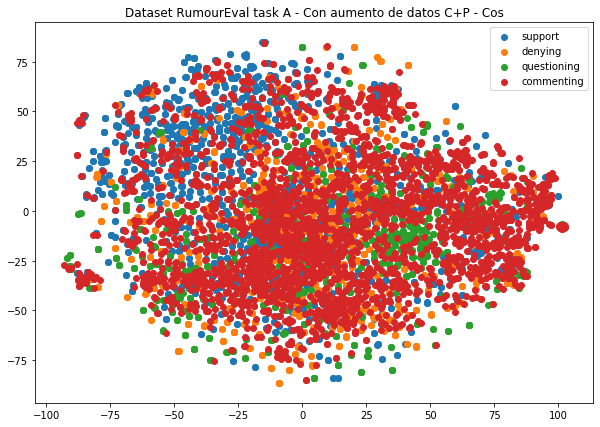

In [155]:
model = TSNE(2, metric='cosine')
to_plot_tsne = model.fit_transform(data_bas_cp)    
plt.figure(figsize=(10,7))
for key in keys:
    labels=[dict_cl[lab] for lab in macro_augmented[:,2]]
    mask = np.asarray(labels)==key
    plt.scatter(to_plot_tsne[:,0][mask],to_plot_tsne[:,1][mask], label=str(key))

plt.legend()
plt.title("Dataset RumourEval task A - Con aumento de datos C+P - Cos")
plt.show()

### Sujeto a Embedding BERT sin ponderación target

In [150]:
macro_augmented=[]
for clase in aum_weight:
    start_time=time.time()
    print ("\n\nGenerando", aum_weight[clase], "ejemplos para", clase)
    muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, BERT=True)
    macro_augmented+=muestras
    print ("Resumen de modificaciones:", dict_aumentos)
    elapsed_time= time.time() - start_time
    print ("Este proceso tomó", elapsed_time, "seg")   



Generando 841 ejemplos para support
Consultando por la clase support
Entrega label 0
Original: news  	Reemplazo:  [('quick', 2.0300705432891846)]
Sentencia original:
['user' 'some' 'good' 'news' '!']
Sentencia final: 0
['user', 'some', 'good', 'quick', '!']


Original: victim  	Reemplazo:  [('death', 1.1133195161819458)]
Sentencia original:
['shoot' 'unarmed' 'kid' '.' 'conceal' 'evidence' '.' 'impose' 'martial'
 'law' '.' 'harass' 'reporters' '.' 'smear' 'the' 'victim' '.' 'worst' '.'
 'police' '.' 'ever' '.' 'hashtag' 'hashtag']
Sentencia final: 0
['shoot', 'unarmed', 'kid', '.', 'conceal', 'evidence', '.', 'impose', 'martial', 'law', '.', 'harass', 'reporters', '.', 'smear', 'the', 'death', '.', 'worst', '.', 'police', '.', 'ever', '.', 'hashtag', 'hashtag']


Original: freed  	Reemplazo:  [('yiddish', 1.082054615020752)]
Original: jewish  	Reemplazo:  [('judaism', 0.8260300159454346)]
Sentencia original:
['“' 'user' ':' 'several' 'hostages' 'freed' 'at' 'jewish' 'supermarket'
 'i

Original: country  	Reemplazo:  [('nation', 1.3290128707885742)]
Original: number  	Reemplazo:  [('hour', 1.559674859046936)]
Original: think  	Reemplazo:  [('thought', 0.8050746917724609)]
Sentencia original:
['user' 'user' 'user' 'it' "'" 's' 'across' 'the' 'country' 'and' 'number'
 'hours' 'away' 'lol' 'and' 'it' "'" 's' 'like' '$' 'number' 'i' 'think']
Sentencia final: 0
['user', 'user', 'user', 'it', "'", 's', 'across', 'the', 'nation', 'and', 'hour', 'hours', 'away', 'lol', 'and', 'it', "'", 's', 'like', '$', 'number', 'i', 'thought']


Original: exciting  	Reemplazo:  [('thrilling', 0.8324747085571289)]
Sentencia original:
['omg' '.' 'hashtag' 'rumoured' 'to' 'be' 'performing' 'in' 'toronto'
 'today' '.' 'exciting' '!']
Sentencia final: 0
['omg', '.', 'hashtag', 'rumoured', 'to', 'be', 'performing', 'in', 'toronto', 'today', '.', 'thrilling', '!']


Original: being  	Reemplazo:  [('thanking', 0.8765572309494019)]
Sentencia original:
['hero' '.' 'user' ':' 'kevin' 'vickers' ',' '

Original: parliament  	Reemplazo:  [('legislature', 1.371334195137024)]
Original: soldier  	Reemplazo:  [('legislature', 0.8297565579414368)]
Sentencia original:
['“' 'user' ':' 'attack' 'on' 'parliament' ':' 'soldier' 'shot' ';'
 'gunman' 'on' 'the' 'loose' ':' 'html' 'html']
Sentencia final: 0
['“', 'user', ':', 'attack', 'on', 'legislature', ':', 'legislature', 'shot', ';', 'gunman', 'on', 'the', 'loose', ':', 'html', 'html']


Original: uniformed  	Reemplazo:  [('paramilitary', 0.8339717388153076)]
Original: memorial  	Reemplazo:  [('commemoration', 0.4839318096637726)]
Original: being  	Reemplazo:  [('taking', 0.8887296915054321)]
Sentencia original:
['shooter' 'still' 'on' 'loose' 'after' 'uniformed' 'soldier' 'shot' 'at'
 'hashtag' "'" 's' 'war' 'memorial' ',' 'across' 'road' 'from'
 'parliament' '.' 'mp' "'" 's' 'being' 'taken' 'out' 'of' 'offices' '.']
Sentencia final: 0
['shooter', 'still', 'on', 'loose', 'after', 'paramilitary', 'soldier', 'shot', 'at', 'hashtag', "'", 's', 

Original: cafe  	Reemplazo:  [('cafes', 1.0374037027359009)]
Sentencia original:
['"' 'user' ':' 'hashtag' 'hostages' 'held' 'inside' 'sydney' 'cafe' ','
 'islamic' 'flag' 'held' 'up' '"' '&lt' ';' '&lt' ';' 'terrifying' 'stuff'
 '.' 'nutters&gt' ';' '&gt' ';']
Sentencia final: 0
['"', 'user', ':', 'hashtag', 'hostages', 'held', 'inside', 'sydney', 'cafes', ',', 'islamic', 'flag', 'held', 'up', '"', '&lt', ';', '&lt', ';', 'terrifying', 'stuff', '.', 'nutters&gt', ';', '&gt', ';']


Original: o  	Reemplazo:  [('customer', 0.8206347823143005)]
Original: save  	Reemplazo:  [('maximize', 0.3765471577644348)]
Original: number  	Reemplazo:  [('multitude', 0.3115520179271698)]
Original: ways  	Reemplazo:  [('users', 0.6891112327575684)]
Sentencia original:
['user' 'user' 'user' 'o' 'lord' 'user' 'save' 'all' 'hostages' 'in'
 'sydney' '&amp' ';' 'turn' 'militants' 'number' 'righteous' 'ways' 'user'
 'hashtag' 'number']
Sentencia final: 0
['user', 'user', 'user', 'customer', 'lord', 'user', 'm

Original: breaking  	Reemplazo:  [('stabbing', 0.5691155791282654)]
Original: shooting  	Reemplazo:  [('slicing', 0.6429769992828369)]
Original: holy  	Reemplazo:  [('crap', 0.829972505569458)]
Sentencia original:
['“' 'user' ':' 'breaking' '-' 'shooting' 'on' 'parliament' 'hill' '.'
 'rcmp' 'have' 'weapons' 'drawn' 'hashtag' 'html' 'holy' 'shit']
Sentencia final: 0
['“', 'user', ':', 'stabbing', '-', 'slicing', 'on', 'parliament', 'hill', '.', 'rcmp', 'have', 'weapons', 'drawn', 'hashtag', 'html', 'crap', 'shit']


Original: saying  	Reemplazo:  [('murdering', 0.5360296368598938)]
Original: s  	Reemplazo:  [('end', 1.0191287994384766)]
Sentencia original:
['user' 'user' 'even' 'going' 'extreme' 'length' 'to' 'hire' 'an' 'actor'
 'that' 'looks' 'like' 'michael' 'brown' '!' 'not' 'saying' 'murder' 'was'
 'justified' ',' 'it' "'" 's' 'not']
Sentencia final: 0
['user', 'user', 'even', 'going', 'extreme', 'length', 'to', 'hire', 'an', 'actor', 'that', 'looks', 'like', 'michael', 'brown', '

Original: s  	Reemplazo:  [('residence', 0.7850733995437622)]
Sentencia original:
['canada' "'" 's' 'parliament' 'building' 'locked' 'down' 'after'
 'shooting' ';' 'at' 'least' 'one' 'guard' 'injured' ':' 'html' 'photo'
 ':' 'ap' 'html']
Sentencia final: 0
['canada', "'", 'residence', 'parliament', 'building', 'locked', 'down', 'after', 'shooting', ';', 'at', 'least', 'one', 'guard', 'injured', ':', 'html', 'photo', ':', 'ap', 'html']


Original: swiss  	Reemplazo:  [('belgian', 0.7956133484840393)]
Sentencia original:
['hoppla' '!' 'user' ':' 'swiss' 'rumors' ':' 'putin' 'absence' 'due' 'to'
 'girlfriend' 'alina' 'giving' 'birth' 'in' 'ticino' 'html' 'html']
Sentencia final: 0
['hoppla', '!', 'user', ':', 'belgian', 'rumors', ':', 'putin', 'absence', 'due', 'to', 'girlfriend', 'alina', 'giving', 'birth', 'in', 'ticino', 'html', 'html']


Original: ferguson  	Reemplazo:  [('terrific', 0.500769317150116)]
Sentencia original:
['user' 'user' 'imagine' 'if' 'ferguson' 'folks' 'were' 'strut

Original: flag  	Reemplazo:  [('reassure', 0.9876323938369751)]
Sentencia original:
['user' 'user' 'user' 'user' 'a' 'actual' '"' 'terror' '"' ',' 'b'
 'nutbars' ',' 'c' 'false' 'flag' '.' 'all' 'number' 'r' 'plausible'
 'html']
Sentencia final: 0
['user', 'user', 'user', 'user', 'a', 'imaginative', '"', 'terror', '"', ',', 'b', 'nutbars', ',', 'c', 'false', 'reassure', '.', 'all', 'number', 'r', 'plausible', 'html']


Original: cop  	Reemplazo:  [('orange', 1.3506149053573608)]
Sentencia original:
['user' 'user' 'user' 'user' 'i' 'don' "'" 't' 'understand' 'the' 'double'
 'standard' 'of' 'wanting' 'all' 'the' 'info' 'about' 'the' 'cop' 'but'
 'brown' "'" 's' 'past' 'is' 'safe' '.']
Sentencia final: 0
['user', 'user', 'user', 'user', 'i', 'don', "'", 't', 'understand', 'the', 'double', 'standard', 'of', 'wanting', 'all', 'the', 'info', 'about', 'the', 'orange', 'but', 'brown', "'", 's', 'past', 'is', 'safe', '.']


Original: s  	Reemplazo:  [('india', 0.8251129388809204)]
Sentencia ori

Original: social  	Reemplazo:  [('political', 0.40098804235458374)]
Original: gonna  	Reemplazo:  [('woken', 0.5123875737190247)]
Sentencia original:
['user' 'hope' 'the' 'baddies' 'don' '’' 't' 'have' 'social' 'media' 'or'
 'they' '’' 're' 'gonna' 'start' 'locking' 'the' 'side' 'doors' 'people'
 'escaped' 'from' '.']
Sentencia final: 0
['user', 'hope', 'the', 'baddies', 'don', '’', 't', 'acquire', 'political', 'media', 'or', 'they', '’', 're', 'woken', 'start', 'locking', 'the', 'side', 'doors', 'people', 'escaped', 'from', '.']


Original: plot  	Reemplazo:  [('story', 0.6690269708633423)]
Sentencia original:
['.' 'user' 'user' 'user' 'duh' ',' 'of' 'course' 'it' "'" 's' '"' 'part'
 'of' 'a' 'larger' 'plot' '"' ',' 'hashtag' 'hashtag' 'hate' 'ppl' 'of'
 'all' 'religions']
Sentencia final: 0
['.', 'user', 'user', 'user', 'duh', ',', 'of', 'course', 'it', "'", 's', '"', 'part', 'of', 'a', 'larger', 'story', '"', ',', 'hashtag', 'hashtag', 'hate', 'ppl', 'of', 'all', 'religions']


Orig

Original: hostage  	Reemplazo:  [('position', 2.1033365726470947)]
Sentencia original:
['"' 'user' ':' 'breaking' ':' 'at' 'least' 'number' 'killed' 'in'
 'hashtag' 'hostage' 'situation' 'via' 'user' 'html' 'user']
Sentencia final: 0
['"', 'user', ':', 'being', ':', 'at', 'least', 'number', 'killed', 'in', 'hashtag', 'position', 'situation', 'via', 'user', 'html', 'user']


Original: toronto  	Reemplazo:  [('middlesbrough', 0.7365595102310181)]
Sentencia original:
['“' 'user' ':' 'secret' 'prince' 'show' 'rumored' 'for' 'toronto'
 'tonight' 'html' 'wishing' 'this' 'was' 'nyc' 'user']
Sentencia final: 0
['“', 'user', ':', 'secret', 'prince', 'show', 'rumored', 'for', 'middlesbrough', 'tonight', 'html', 'wishing', 'this', 'was', 'nyc', 'user']


Original: french  	Reemplazo:  [('unofficial', 0.6416859030723572)]
Original: be  	Reemplazo:  [('have', 0.8673890233039856)]
Sentencia original:
['the' 'number' 'virgin' 'to' 'line' 'up“' 'user' ':' 'more' ':'
 'official' ':' 'french' 'terror' '

Original: paris  	Reemplazo:  [('policeman', 0.9698355197906494)]
Sentencia original:
['“' 'user' ':' 'breaking' ':' 'one' 'person' 'seriously' 'wounded' ','
 'six' 'taken' 'hostage' 'in' 'incident' 'at' 'kosher' 'supermarket' 'in'
 'paris' ':' 'police' 'source' '"' 'mondo' 'cane' '!']
Sentencia final: 0
['“', 'user', ':', 'breaking', ':', 'one', 'person', 'seriously', 'wounded', ',', 'six', 'taken', 'hostage', 'in', 'incident', 'at', 'kosher', 'supermarket', 'in', 'policeman', ':', 'police', 'source', '"', 'mondo', 'cane', '!']


Original: be  	Reemplazo:  [('go', 0.7686735987663269)]
Original: riders  	Reemplazo:  [('rides', 0.7194910049438477)]
Original: encourage  	Reemplazo:  [('encouragement', 0.5129784941673279)]
Original: drivers  	Reemplazo:  [('gotten', 0.8546046018600464)]
Original: get  	Reemplazo:  [('have', 0.7241691946983337)]
Sentencia original:
['uber' 'sydney' 'trips' 'from' 'cbd' 'will' 'be' 'free' 'for' 'riders'
 '.' 'higher' 'rates' 'are' 'still' 'in' 'place' 'to' 

Original: reports  	Reemplazo:  [('announcements', 0.36259135603904724)]
Sentencia original:
['“' 'user' ':' 'hostage' 'taker' 'in' 'sydney' 'cafe' 'demands' 'isis'
 'flag' 'and' 'call' 'with' 'australian' 'pm' ',' 'sky' 'news' 'reports'
 '.' 'html' 'hashtag' '”']
Sentencia final: 0
['“', 'user', ':', 'hostage', 'taker', 'in', 'sydney', 'cafes', 'demands', 'ultimatum', 'flag', 'and', 'venezuelan', 'with', 'australian', 'pm', ',', 'sky', 'news', 'announcements', '.', 'html', 'hashtag', '”']


Original: officer  	Reemplazo:  [('service', 0.5081139206886292)]
Sentencia original:
['user' 'user' 'fergusonmo' 'police' 'officer' 'is' 'darren' 'wilson'
 'who' 'shot&amp' ';' 'killed' 'hashtag' '.' 'also' 'a' 'video' 'too' 'of'
 'strong' 'armed' 'robbery' '.']
Sentencia final: 0
['user', 'user', 'fergusonmo', 'police', 'service', 'is', 'darren', 'wilson', 'who', 'shot&amp', ';', 'killed', 'hashtag', '.', 'also', 'a', 'video', 'too', 'of', 'strong', 'armed', 'robbery', '.']


Original: samson  	R

Original: holy  	Reemplazo:  [('ball', 1.1628071069717407)]
Sentencia original:
['user' 'did' 'anyone' 'think' 'that' ',' 'holy' 'balls' ',' 'he' 'was'
 'old' 'enough' 'to' 'know' 'how' 'to' 'change' 'his' 'clothes' '?']
Sentencia final: 0
['user', 'did', 'anyone', 'think', 'that', ',', 'ball', 'balls', ',', 'he', 'was', 'old', 'enough', 'to', 'know', 'how', 'to', 'change', 'his', 'clothes', '?']


Original: taking  	Reemplazo:  [('seizing', 0.5072669386863708)]
Sentencia original:
['hashtag' 'gunman' 'in' 'policewoman' 'killing' 'suspected' 'in' 'new'
 'paris' 'hostage' '-' 'taking' ':' 'source']
Sentencia final: 0
['hashtag', 'gunman', 'in', 'policewoman', 'killing', 'suspected', 'in', 'new', 'paris', 'hostage', '-', 'seizing', ':', 'source']


Original: large  	Reemplazo:  [('sizable', 0.7275177240371704)]
Sentencia original:
['paris' 'terrorist' 'attack' '“' 'user' ':' 'charlie' 'hebdo' 'shooting'
 'latest' ':' 'number' 'dead&amp' ';' 'gunmen' 'still' 'at' 'large' 'html'
 'html']
S

Original: something  	Reemplazo:  [('someone', 0.48998889327049255)]
Sentencia original:
['user' 'but' '.' 'there' 'was' 'something' 'leading' 'up' 'to' 'the'
 'shooting' '?' 'or' 'what' '?']
Sentencia final: 0
['user', 'but', '.', 'there', 'went', 'someone', 'leading', 'up', 'to', 'the', 'shooting', '?', 'or', 'what', '?']


Original: grocery  	Reemplazo:  [('hostage', 1.145624041557312)]
Sentencia original:
['“' 'user' ':' 'police' 'taking' 'people' 'out' 'of' 'hashtag' 'grocery'
 'where' 'hostages' 'were' 'being' 'held' '.' 'html']
Sentencia final: 0
['“', 'user', ':', 'police', 'taking', 'people', 'out', 'of', 'hashtag', 'hostage', 'where', 'hostages', 'were', 'being', 'held', '.', 'html']


Original: paris  	Reemplazo:  [('rouen', 0.3829536437988281)]
Original: approach  	Reemplazo:  [('methodology', 0.7492876648902893)]
Sentencia original:
['“' 'user' ':' 'official' ':' 'gunman' 'holding' 'at' 'least' 'number'
 'hostages' 'in' 'paris' 'market' 'has' 'threatened' 'to' 'kill' 'them

Original: putin  	Reemplazo:  [('halo', 0.726957380771637)]
Sentencia original:
['us' 'embassy' 'hashtag' 'cables' 'talk' 'of' 'an' 'operation' 'planned'
 'by' '"' 'dissidents' '"' 'in' 'hashtag' 'to' '"' 'overthrow' 'putin' '"'
 '.' 'html' 'hashtag']
Sentencia final: 0
['us', 'embassy', 'hashtag', 'cables', 'talk', 'of', 'an', 'operation', 'planned', 'by', '"', 'dissidents', '"', 'in', 'hashtag', 'to', '"', 'overthrow', 'halo', '"', '.', 'html', 'hashtag']


Original: police  	Reemplazo:  [('authorities', 0.8077586889266968)]
Sentencia original:
['hashtag' 'killers' 'shot' 'dead' 'by' 'police']
Sentencia final: 0
['hashtag', 'killers', 'shot', 'dead', 'by', 'authorities']


Original: number  	Reemplazo:  [('death', 0.4581214487552643)]
Sentencia original:
['rt' 'user' 'at' 'least' 'number' 'dead' 'in' 'shooting' 'at' 'hq' 'of'
 'hashtag' 'in' 'hashtag' 'police' 'source' 'html']
Sentencia final: 0
['rt', 'user', 'at', 'least', 'death', 'dead', 'in', 'shooting', 'at', 'hq', 'of', 'hasht

Original: member  	Reemplazo:  [('janeiro', 2.14654278755188)]
Sentencia original:
['condolences' 'to' 'cpl' '.' "'" 's' 'family' 'friends' '“' 'user' ':'
 'breaking' ':' 'deceased' 'soldier' 'in' 'ottawa' 'is' 'cpl' '.' 'nathan'
 'cirillo' '.' 'member' 'of' 'the' 'hamilton' 'argyll' '"']
Sentencia final: 0
['condolences', 'to', 'cpl', '.', "'", 's', 'family', 'users', '“', 'user', ':', 'breaking', ':', 'deceased', 'nobleman', 'in', 'ottawa', 'is', 'cpl', '.', 'ethan', 'cirillo', '.', 'janeiro', 'of', 'the', 'hamilton', 'argyll', '"']


Original: thing  	Reemplazo:  [('aback', 2.6732723712921143)]
Sentencia original:
['user' 'anon' 'has' 'been' 'pretty' 'awful' 'through' 'this' 'whole'
 'thing' '.']
Sentencia final: 0
['user', 'anon', 'has', 'been', 'pretty', 'awful', 'through', 'this', 'whole', 'aback', '.']


Original: freed  	Reemplazo:  [('jurist', 0.781630277633667)]
Sentencia original:
['rt' '"' 'user' ':' 'several' 'hostages' 'freed' 'at' 'jewish'
 'supermarket' 'in' 'paris' '.'

Original: cafe  	Reemplazo:  [('cafes', 1.442011833190918)]
Sentencia original:
['live' 'updates' ':' 'siege' 'in' 'sydney' 'cafe' 'html']
Sentencia final: 0
['live', 'upgrades', ':', 'parramatta', 'in', 'sydney', 'cafes', 'html']


Original: armed  	Reemplazo:  [('infused', 0.4694603979587555)]
Original: pulled  	Reemplazo:  [('had', 0.8813395500183105)]
Sentencia original:
['user' 'the' 'cop' 'didnt' 'know' 'he' 'was' 'un' 'armed' 'he' 'could'
 'have' 'pulled' 'out' 'a' 'gun' 'and' 'killed' 'him' ',' 'if' 'he'
 'tazed' 'him' 'he' 'could' 'shot' 'the' 'cop' '.']
Sentencia final: 0
['user', 'the', 'cop', 'didnt', 'know', 'he', 'was', 'un', 'infused', 'he', 'could', 'have', 'had', 'out', 'a', 'gun', 'and', 'killed', 'him', ',', 'if', 'he', 'tazed', 'him', 'he', 'could', 'shot', 'the', 'cop', '.']


Original: looks  	Reemplazo:  [('users', 0.9688044786453247)]
Original: assume  	Reemplazo:  [('ensure', 1.0027666091918945)]
Sentencia original:
['user' 'user' 'still' 'looks' 'like' 'a' 'pr

Original: number  	Reemplazo:  [('kill', 1.3139318227767944)]
Original: al  	Reemplazo:  [('islamist', 0.4962180256843567)]
Original: qaeda  	Reemplazo:  [('pisa', 0.4619239866733551)]
Sentencia original:
['looks' 'like' 'every' 'charlie' 'hebdo' 'cartoonist' 'has' 'been'
 'killed' ':' 'number' '.' 'charb' '-' 'was' 'on' 'al' '-' 'qaeda' "'" 's'
 'hit' 'list' ';' 'number' '.' 'cabu' ',' 'number' '.' 'wolinski' ','
 'number' '.' 'tignous']
Sentencia final: 0
['looks', 'like', 'every', 'charlie', 'hebdo', 'cartoonist', 'has', 'been', 'killed', ':', 'kill', '.', 'charb', '-', 'was', 'on', 'islamist', '-', 'pisa', "'", 's', 'hit', 'list', ';', 'number', '.', 'cabu', ',', 'number', '.', 'wolinski', ',', 'number', '.', 'tignous']


Original: t  	Reemplazo:  [('tb', 0.4838724434375763)]
Sentencia original:
['user' 'user' 'user' 'why' 'shouldn' "'" 't' 'a' 'private' 'citizen'
 'make' 'a' 'comment' 'on' 'a' 'news' 'event' '?']
Sentencia final: 0
['user', 'user', 'user', 'why', 'shouldn', "'", '

Original: muslim  	Reemplazo:  [('islam', 0.8380540609359741)]
Sentencia original:
['user' 'user' 'see' 'my' 'previous' 'tweets' '.' 'that' "'" 's' 'what'
 'charlie' 'hebdo' 'does' '.' 'latest' 'cover' 'savage' 'an' 'anti' '-'
 'muslim' 'writer' '-' 'and' 'jesus' '.']
Sentencia final: 0
['user', 'user', 'see', 'my', 'previous', 'tweets', '.', 'that', "'", 's', 'what', 'charlie', 'hebdo', 'does', '.', 'latest', 'cover', 'savage', 'an', 'anti', '-', 'islam', 'writer', '-', 'and', 'jesus', '.']


Original: telling  	Reemplazo:  [('informing', 0.816406786441803)]
Original: everyone  	Reemplazo:  [('tell', 1.4597710371017456)]
Sentencia original:
['“' 'user' ':' 'more' 'shots' 'fired' 'just' 'off' 'parliament' 'hill'
 '.' 'police' 'telling' 'everyone' 'to' 'take' 'cover' '.' '”' 'hashtag'
 'hashtag']
Sentencia final: 0
['“', 'user', ':', 'more', 'shots', 'fired', 'just', 'off', 'parliament', 'hill', '.', 'police', 'informing', 'tell', 'to', 'take', 'cover', '.', '”', 'hashtag', 'hashtag']



Original: charlie  	Reemplazo:  [('suspect', 0.7787750363349915)]
Sentencia original:
['user' ':' 'both' 'charlie' 'hebdo' 'suspects' 'killed' 'as' 'police'
 'storm' 'building' 'police' 'sources' 'html' 'html' 'hashtag']
Sentencia final: 0
['user', ':', 'both', 'suspect', 'hebdo', 'suspects', 'killed', 'as', 'police', 'storm', 'building', 'police', 'sources', 'html', 'html', 'hashtag']


Original: several  	Reemplazo:  [('numerous', 0.9357398748397827)]
Sentencia original:
['“' 'user' ':' 'several' 'hostages' 'freed' 'at' 'jewish' 'supermarket'
 'in' 'paris' '.' 'photo' 'thomas' 'samson' 'hashtag' 'html' 'hashtag']
Sentencia final: 0
['“', 'user', ':', 'numerous', 'hostages', 'freed', 'at', 'jewish', 'supermarket', 'in', 'paris', '.', 'photo', 'thomas', 'samson', 'hashtag', 'html', 'hashtag']


Original: walk  	Reemplazo:  [('strode', 1.5348118543624878)]
Sentencia original:
['witness' ':' 'police' 'allegedly' 'stopped' 'mike' 'brown' 'after'
 'yelling' 'at' 'him' 'to' 'walk' 'on' 'sid

Original: teen  	Reemplazo:  [('shootout', 0.8437452912330627)]
Sentencia original:
['police' 'in' 'hashtag' 'plan' 'to' 'release' 'name' 'of' 'officer' 'who'
 'shot' 'unarmed' 'teen' 'michael' 'brown' ':' 'html' 'html']
Sentencia final: 0
['people', 'in', 'hashtag', 'plan', 'to', 'moniker', 'name', 'of', 'officer', 'who', 'shot', 'unarmed', 'shootout', 'michael', 'brown', ':', 'html', 'html']


Original: killed  	Reemplazo:  [('murdered', 0.8769786357879639)]
Original: today  	Reemplazo:  [('tonight', 0.9061671495437622)]
Original: source  	Reemplazo:  [('tell', 0.5031528472900391)]
Sentencia original:
['the' 'canadian' 'soldier' 'killed' 'in' 'today' "'" 's' 'ottawa'
 'shooting' 'is' 'cpl' '.' 'nathan' 'cirillo' ',' 'a' 'family' 'source'
 'told' 'cnn' '.' 'live' 'blog' ':' 'html']
Sentencia final: 0
['the', 'canadian', 'soldier', 'murdered', 'in', 'tonight', "'", 's', 'ottawa', 'shooting', 'is', 'cpl', '.', 'nathan', 'cirillo', ',', 'a', 'family', 'tell', 'told', 'cnn', '.', 'live', 

Original: nothing  	Reemplazo:  [('something', 0.7910019159317017)]
Sentencia original:
['user' 'user' 'user' 'and' 'francistan' 'will' 'just' 'roll' 'over' 'and'
 'do' 'nothing' '.' 'french' 'jews' ',' 'get' 'out' 'while' 'you' 'can'
 '!']
Sentencia final: 0
['user', 'user', 'user', 'and', 'francistan', 'will', 'just', 'roll', 'over', 'and', 'do', 'something', '.', 'french', 'jews', ',', 'get', 'out', 'while', 'you', 'can', '!']


Original: increase  	Reemplazo:  [('decrease', 0.8813236951828003)]
Sentencia original:
['user' 'but' 'you' 'do' 'uber' 'for' 'trying' 'to' 'increase' 'drivers'
 '.' 'my' 'work' 'here' 'is' 'done' 'your' 'honour' '.']
Sentencia final: 0
['user', 'but', 'you', 'do', 'uber', 'for', 'trying', 'to', 'decrease', 'drivers', '.', 'my', 'work', 'here', 'is', 'done', 'your', 'honour', '.']


Original: didn  	Reemplazo:  [('don', 2.1190555095672607)]
Original: sense  	Reemplazo:  [('logic', 0.8787553310394287)]
Original: felt  	Reemplazo:  [('feel', 3.5420897006988525

Original: o  	Reemplazo:  [('lo', 0.7983930706977844)]
Sentencia original:
['“' 'user' ':' 'canada' "'" 's' 'parliament' 'hill' 'is' 'on' 'lockdown'
 'as' 'police' 'hunt' 'shooting' 'suspect' ';' 'at' 'least' 'number'
 'injured' 'html' 'o' '.' 'o']
Sentencia final: 0
['“', 'user', ':', 'canada', "'", 's', 'parliament', 'hill', 'is', 'on', 'lockdown', 'as', 'police', 'hunt', 'shooting', 'suspect', ';', 'at', 'least', 'number', 'injured', 'html', 'o', '.', 'lo']


Original: rt  	Reemplazo:  [('participant', 0.8408281803131104)]
Original: number  	Reemplazo:  [('stabbed', 0.5619088411331177)]
Sentencia original:
['rt' 'user' ':' 'breaking' ':' 'at' 'least' 'number' 'killed' 'in'
 'hashtag' 'hostage' 'situation' 'via' 'user' 'html']
Sentencia final: 0
['participant', 'user', ':', 'breaking', ':', 'at', 'least', 'stabbed', 'killed', 'in', 'hashtag', 'hostage', 'situation', 'via', 'user', 'html']


Original: think  	Reemplazo:  [('thought', 1.356963038444519)]
Sentencia original:
['user' 'us

Original: viewers  	Reemplazo:  [('listeners', 0.6641955971717834)]
Original: president  	Reemplazo:  [('chairman', 1.902354121208191)]
Sentencia original:
['user' 'how' 'long' 'before' 'fox' 'viewers' 'blame' 'this' 'on'
 'president' 'obama' '?' 'number' '.' 'number' '.' 'number' '.']
Sentencia final: 0
['user', 'how', 'long', 'before', 'fox', 'listeners', 'blame', 'this', 'on', 'chairman', 'obama', '?', 'number', '.', 'number', '.', 'number', '.']


Original: beat  	Reemplazo:  [('beating', 0.9201332330703735)]
Original: getting  	Reemplazo:  [('growing', 1.3540998697280884)]
Sentencia original:
['“' 'user' ':' 'report' ':' 'hashtag' 'police' 'beat' 'up' 'wrong'
 'suspect' 'then' 'charged' 'him' 'for' 'getting' 'blood' 'on' 'uniforms'
 'in' 'number' 'html']
Sentencia final: 0
['“', 'user', ':', 'report', ':', 'hashtag', 'police', 'beating', 'up', 'wrong', 'suspect', 'then', 'charged', 'him', 'for', 'growing', 'blood', 'on', 'uniforms', 'in', 'number', 'html']


Original: going  	Reem

Original: hill  	Reemplazo:  [('wwii', 0.5005995631217957)]
Sentencia original:
['hashtag' 'police' 'confirm' 'to' 'hashtag' 'they' 'are' 'still'
 'seeking' 'number' 'or' 'more' 'suspects' 'after' 'shoot' 'on'
 'parliament' 'hill' ',' 'war' 'memorial' ',' 'nearby' 'mall' '.']
Sentencia final: 0
['hashtag', 'police', 'confirm', 'to', 'hashtag', 'they', 'are', 'still', 'embracing', 'number', 'or', 'more', 'suspects', 'after', 'shoot', 'on', 'parliament', 'wwii', ',', 'war', 'memorial', ',', 'nearby', 'mall', '.']


Original: hot  	Reemplazo:  [('sociological', 0.6036571860313416)]
Sentencia original:
['isis' '-' 'holding' 'a' 'cafe' 'hostage' 'in' 'sydney' '-' 'forcing'
 'hostages' 'to' 'press' 'isis' 'flags' 'against' 'the' 'windows'
 'hashtag' 'hot' '!' 'html']
Sentencia final: 0
['isis', '-', 'holding', 'a', 'cafe', 'hostage', 'in', 'sydney', '-', 'forcing', 'hostages', 'to', 'press', 'isis', 'flags', 'against', 'the', 'windows', 'hashtag', 'sociological', '!', 'html']


Original: s  



Original: i  	Reemplazo:  [('baja', 0.8506398797035217)]
Original: come  	Reemplazo:  [('see', 0.7997262477874756)]
Original: paris  	Reemplazo:  [('event', 1.36322021484375)]
Sentencia original:
['+' 'number' '|' 'user' ':' '"' 'most' 'compelling' 'image' 'i' "'" 've'
 'seen' 'to' 'come' 'out' 'of' 'horrifying' 'events' 'in' 'paris' ','
 'courtesy' 'of' 'banksy' '.' 'html']
Sentencia final: 0
['+', 'number', '|', 'user', ':', '"', 'most', 'compelling', 'image', 'baja', "'", 've', 'seen', 'to', 'see', 'out', 'of', 'horrifying', 'events', 'in', 'event', ',', 'courtesy', 'of', 'banksy', '.', 'html']


Original: follow  	Reemplazo:  [('develop', 1.051842212677002)]
Sentencia original:
['soldier' 'shot' ',' 'shooter' 'still' 'at' 'large' 'mt' 'user' ':'
 'attack' 'on' 'parliament' ':' 'follow' 'our' 'developing' 'story' 'html']
Sentencia final: 0
['soldier', 'shot', ',', 'shooter', 'still', 'at', 'large', 'mt', 'user', ':', 'attack', 'on', 'parliament', ':', 'develop', 'our', 'developing

Original: canadian  	Reemplazo:  [('middlesbrough', 0.5620136857032776)]
Original: shooting  	Reemplazo:  [('firing', 0.9555273056030273)]
Original: war  	Reemplazo:  [('shot', 0.8463311791419983)]
Sentencia original:
['shooting' 'in' 'canadian' 'parliament' 'comes' 'day' 'after' 'isis' '-'
 'inspired' 'radical' 'drove' 'in2' 'canadian' 'soldier' '.' 'also'
 'reports' 'of' 'shooting' 'at' 'war' 'memorial' 'number']
Sentencia final: 0
['shooting', 'in', 'middlesbrough', 'parliament', 'comes', 'day', 'after', 'isis', '-', 'inspired', 'radical', 'drove', 'in2', 'canadian', 'soldier', '.', 'also', 'reports', 'of', 'firing', 'at', 'shot', 'memorial', 'number']


Original: pricing  	Reemplazo:  [('valuation', 0.8215360045433044)]
Original: downtown  	Reemplazo:  [('marketplace', 0.9129868149757385)]
Sentencia original:
['4x' 'at' '$' 'number' 'min' 'rt' 'user' ':' 'uber' 'intro' 'surge'
 'pricing' 'in' 'downtown' 'sydney' 'during' 'hostage' 'siege' 'html'
 'html']
Sentencia final: 0
['4x', '

Original: hostages  	Reemplazo:  [('flees', 0.9321829080581665)]
Sentencia original:
['breaking' ':' 'police' 'enter' 'hashtag' 'cafe' ',' 'hostages' 'flee'
 'html' 'hashtag' 'html']
Sentencia final: 0
['breaking', ':', 'police', 'enter', 'hashtag', 'cafe', ',', 'flees', 'flee', 'html', 'hashtag', 'html']


Original: darren  	Reemplazo:  [('contains', 0.9085898399353027)]
Original: is  	Reemplazo:  [('has', 0.4804654121398926)]
Sentencia original:
['“' 'urgent' ':' 'darren' 'wilson' 'is' 'the' 'police' 'officer' 'who'
 'shot' 'mike' 'brown' 'html' 'hashtag' 'html' 'rt' 'user']
Sentencia final: 0
['“', 'urgent', ':', 'contains', 'wilson', 'has', 'the', 'police', 'officer', 'who', 'shot', 'mike', 'brown', 'html', 'hashtag', 'html', 'rt', 'user']


Original: are  	Reemplazo:  [('am', 0.6437476873397827)]
Original: s  	Reemplazo:  [('chesterfield', 0.4705113470554352)]
Original: live  	Reemplazo:  [('credible', 0.4878441095352173)]
Sentencia original:
['police' 'stand' 'guard' 'as' 'hostag

Original: end  	Reemplazo:  [('terminate', 0.7683773636817932)]
Sentencia original:
['user' 'islamic' 'scholars' 'should' 'come' 'forward' 'to' 'end' "'"
 'jihad' "'" '!' 'it' 'is' 'inhuman' '&amp' ';' 'would' 'destroy' 'the'
 'credibility' 'of' 'islam' '!']
Sentencia final: 0
['user', 'islamic', 'scholars', 'should', 'come', 'forward', 'to', 'terminate', "'", 'jihad', "'", '!', 'it', 'is', 'inhuman', '&amp', ';', 'would', 'destroy', 'the', 'credibility', 'of', 'islam', '!']


Original: police  	Reemplazo:  [('lines', 1.2363137006759644)]
Original: cars  	Reemplazo:  [('policemen', 0.48400747776031494)]
Sentencia original:
['line' 'of' 'police' 'cars' 'with' 'high' 'beams' 'on' 'greet' 'anyone'
 'trying' 'to' 'enter' 'hashtag' '.' 'it' "'" 's' 'shut' 'down' '.' 'no'
 'media' 'allowed' '.' 'html']
Sentencia final: 0
['line', 'of', 'lines', 'policemen', 'with', 'high', 'beams', 'on', 'greet', 'anyone', 'trying', 'to', 'enter', 'hashtag', '.', 'it', "'", 's', 'shut', 'down', '.', 'no', 'm

Original: u  	Reemplazo:  [('thought', 2.0888359546661377)]
Sentencia original:
['user' 'curly' 'wurlys' 'are' 'so' 'much' 'nicer' 'than' 'half'
 'avocados' 'dont' 'u' 'think' '?']
Sentencia final: 0
['user', 'curly', 'wurlys', 'are', 'so', 'much', 'nicer', 'than', 'half', 'avocados', 'dont', 'thought', 'think', '?']


Original: saying  	Reemplazo:  [('stating', 0.8595960736274719)]
Sentencia original:
['user' 'you' 'guys' '"' 'confirmed' '"' 'there' 'were' 'number' 'shoot'
 'not' 'long' 'ago' '.' 'how' 'about' 'you' 'wait' 'for' 'official'
 'reports' 'before' 'saying' 'things' '.']
Sentencia final: 0
['user', 'you', 'guys', '"', 'confirmed', '"', 'there', 'were', 'number', 'shoot', 'not', 'long', 'ago', '.', 'how', 'about', 'you', 'wait', 'for', 'official', 'reports', 'before', 'stating', 'things', '.']


Original: sharing  	Reemplazo:  [('commencing', 0.45478156208992004)]
Sentencia original:
['user' 'emm' 'i' 'never' ',' 'i' 'tagged' 'the' 'user' '.' 'not' 'my'
 'video' "'" 's' 'gra

Original: part  	Reemplazo:  [('work', 0.7188601493835449)]
Sentencia original:
['“' 'user' ':' 'the' 'sydney' 'cafe' 'siege' 'may' 'be' 'part' 'of' 'a'
 'larger' 'plot' '.' 'user' 'hashtag' 'html' 'html']
Sentencia final: 0
['“', 'user', ':', 'the', 'sydney', 'cafe', 'siege', 'may', 'be', 'work', 'of', 'a', 'larger', 'plot', '.', 'user', 'hashtag', 'html', 'html']


Original: hostages  	Reemplazo:  [('detainees', 1.3648658990859985)]
Sentencia original:
['update' ':' 'hostages' 'fleeing' 'hashtag' 'cafe' 'held' 'by' 'iranian'
 'gunman' 'as' 'explosions' ',' 'gunshot' 'are' 'heard' ':' 'html']
Sentencia final: 0
['update', ':', 'detainees', 'fleeing', 'hashtag', 'cafe', 'held', 'by', 'iranian', 'gunman', 'as', 'explosions', ',', 'gunshot', 'are', 'heard', ':', 'html']


Original: several  	Reemplazo:  [('numerous', 0.5358832478523254)]
Original: injured  	Reemplazo:  [('numerous', 0.7221425771713257)]
Sentencia original:
['hashtag' ':' 'number' 'dead' ',' 'several' 'injured' 'in' 'shoo

Original: stop  	Reemplazo:  [('halt', 1.970233678817749)]
Sentencia original:
['agreed' '-' 'also' ',' 'if' 'hashtag' 'was' 'suspect' ',' 'why' 'not'
 'just' 'question' 'him' '?' 'why' 'tell' 'him' '&amp' ';' 'friend' 'get'
 'off' 'road' ',' 'not' 'stop' 'them' '?' 'user' 'hashtag']
Sentencia final: 0
['agreed', '-', 'also', ',', 'if', 'hashtag', 'was', 'suspect', ',', 'why', 'not', 'just', 'question', 'him', '?', 'why', 'tell', 'him', '&amp', ';', 'friend', 'get', 'off', 'road', ',', 'not', 'halt', 'them', '?', 'user', 'hashtag']


Original: have  	Reemplazo:  [('follow', 0.47699326276779175)]
Original: following  	Reemplazo:  [('preceding', 0.727418065071106)]
Original: number  	Reemplazo:  [('set', 1.3545869588851929)]
Sentencia original:
['“' 'user' ':' 'hashtag' ':' 'at' 'least' 'two' 'people' 'have' 'died'
 'following' 'the' 'hashtag' '.' 'number' 'people' 'are' 'being' 'treated'
 'by' 'paramedics' '.' '”' 'nooooo']
Sentencia final: 0
['“', 'user', ':', 'hashtag', ':', 'at', 'le

Original: sr  	Reemplazo:  [('jr', 0.9139466881752014)]
Sentencia original:
['canadian' 'authorities' 'have' 'given' 'name' 'of' 'suspect' 'in'
 'ottawa' 'attacks' 'to' 'u' '.' 's' '.' 'fed' ';' 'ask' 'for' 'fbi'
 'assistance' ':' 'sr' 'u' '.' 's' '.' 'law' 'enforcement' 'official']
Sentencia final: 0
['canadian', 'authorities', 'have', 'given', 'name', 'of', 'moniker', 'in', 'ottawa', 'attacks', 'to', 'u', '.', 's', '.', 'fed', ';', 'kgb', 'for', 'fbi', 'assistance', ':', 'jr', 'u', '.', 's', '.', 'law', 'enforcement', 'official']


Original: oh  	Reemplazo:  [('huh', 0.8466687798500061)]
Sentencia original:
['user' 'user' 'oh' 'yea' 'the' 'malatov' 'cocktail' 'too' '.']
Sentencia final: 0
['user', 'user', 'huh', 'yea', 'the', 'malatov', 'cocktail', 'too', '.']


Original: dirty  	Reemplazo:  [('filthy', 1.0759836435317993)]
Sentencia original:
['“' 'user' ':' 'the' 'day' 'hashtag' 'cops' 'told' 'a' 'dirty' ','
 'bloody' 'lie' 'via' 'user' ':' 'html' 'html']
Sentencia final: 0
['“', '

Original: innocent  	Reemplazo:  [('amount', 0.7291151285171509)]
Sentencia original:
['user' 'user' 'terminate' 'him' '.' 'doing' 'this' 'number' 'innocent'
 'ppl' '.' 'give' 'the' 'coward' 'a' 'uniform&amp' ';' 'put' 'him' 'on'
 'battlefield' 'number' 'see' 'how' 'tough' 'he' 'is']
Sentencia final: 0
['user', 'user', 'terminate', 'him', '.', 'doing', 'this', 'number', 'amount', 'ppl', '.', 'give', 'the', 'coward', 'a', 'uniform&amp', ';', 'put', 'him', 'on', 'battlefield', 'number', 'see', 'how', 'tough', 'he', 'is']


Original: locate  	Reemplazo:  [('relocate', 0.912759006023407)]
Sentencia original:
['user' 'locate' 'more' 'photograph' 'here' '!' 'html']
Sentencia final: 0
['user', 'relocate', 'more', 'photograph', 'here', '!', 'html']


Original: s  	Reemplazo:  [('occurrence', 0.6978568434715271)]
Sentencia original:
['user' 'what' "'" 's' 'happening' 'in' 'this' 'world' 'and' 'why' 'this'
 'so' 'much' 'haterage' 'everywhere' '.' 'so' 'sickening']
Sentencia final: 0
['user', 'wh

Original: cafe  	Reemplazo:  [('deliver', 0.9344566464424133)]
Original: wants  	Reemplazo:  [('seems', 1.331999659538269)]
Original: be  	Reemplazo:  [('have', 0.769811749458313)]
Sentencia original:
['reports' 'on' 'user' 'hashtag' 'gunman' 'wants' 'hashtag' 'flag'
 'delivered' 'to' 'cafe' 'and' 'he' 'also' 'wants' 'to' 'speak' 'to' 'pm'
 'or' 'people' 'will' 'be' 'killed' '.']
Sentencia final: 0
['reports', 'on', 'user', 'hashtag', 'gunman', 'wants', 'hashtag', 'flag', 'delivered', 'to', 'deliver', 'and', 'he', 'also', 'seems', 'to', 'speak', 'to', 'pm', 'or', 'people', 'will', 'have', 'killed', '.']


Original: shooting  	Reemplazo:  [('stabbing', 0.6167157292366028)]
Original: brown  	Reemplazo:  [('don', 1.3105396032333374)]
Original: t  	Reemplazo:  [('doesn', 0.9280430674552917)]
Original: suspect  	Reemplazo:  [('accusation', 0.5025644302368164)]
Sentencia original:
['hashtag' 'police' ':' 'officer' 'involved' 'in' 'fatal' 'shooting' 'of'
 'michael' 'brown' 'didn' "'" 't' 'kno

Original: armed  	Reemplazo:  [('strengthened', 0.6265590786933899)]
Sentencia original:
['user' 'user' 'fergusonmo' 'police' 'officer' 'is' 'darren' 'wilson'
 'who' 'shot&amp' ';' 'killed' 'hashtag' '.' 'also' 'a' 'video' 'too' 'of'
 'strong' 'armed' 'robbery' '.']
Sentencia final: 0
['user', 'user', 'fergusonmo', 'police', 'officer', 'is', 'darren', 'wilson', 'who', 'shot&amp', ';', 'killed', 'hashtag', '.', 'also', 'a', 'video', 'too', 'of', 'strong', 'strengthened', 'robbery', '.']


Original: several  	Reemplazo:  [('numerous', 0.9357398748397827)]
Original: freed  	Reemplazo:  [('yiddish', 1.082054615020752)]
Original: supermarket  	Reemplazo:  [('montpellier', 0.6109591722488403)]
Original: photo  	Reemplazo:  [('photograph', 0.810066282749176)]
Sentencia original:
['“' 'user' ':' 'several' 'hostages' 'freed' 'at' 'jewish' 'supermarket'
 'in' 'paris' '.' 'photo' 'thomas' 'samson' 'hashtag' 'html']
Sentencia final: 0
['“', 'user', ':', 'numerous', 'hostages', 'yiddish', 'at', 'je

Original: paris  	Reemplazo:  [('london', 0.8952914476394653)]
Sentencia original:
['an' 'number' '-' 'month' 'old' 'baby' 'is' 'among' 'the' 'hostages' 'at'
 'the' 'kosher' 'supermarket' 'in' 'paris' '.' 'unbearably' 'sad' '.'
 'html']
Sentencia final: 0
['an', 'number', '-', 'fifteenth', 'old', 'baby', 'is', 'among', 'the', 'aria', 'at', 'the', 'kosher', 'supermarket', 'in', 'london', '.', 'unbearably', 'sad', '.', 'html']


Original: god  	Reemplazo:  [('man', 1.3803504705429077)]
Sentencia original:
['“' 'user' ':' 'up' 'to' 'number' 'held' 'hostage' 'in' 'sydney' 'lindt'
 'cafe' 'siege' 'html' 'html' 'oh' '.' 'my' '.' 'god' '.' 'i' 'am' 'sick'
 '!']
Sentencia final: 0
['“', 'user', ':', 'up', 'to', 'number', 'held', 'hostage', 'in', 'sydney', 'lindt', 'cafe', 'siege', 'html', 'html', 'oh', '.', 'my', '.', 'man', '.', 'i', 'am', 'sick', '!']


Original: hostages  	Reemplazo:  [('users', 0.5724207162857056)]
Sentencia original:
['user' 'number' 'hostages' 'now']
Sentencia final: 0
[

Original: shooting  	Reemplazo:  [('drumming', 0.592226505279541)]
Sentencia original:
['at' 'least' 'number' 'dead' 'in' 'shooting' 'at' 'hq' 'of' 'hashtag'
 'in' 'hashtag' 'police' 'source' 'html']
Sentencia final: 0
['at', 'least', 'number', 'dead', 'in', 'drumming', 'at', 'hq', 'of', 'hashtag', 'in', 'hashtag', 'police', 'source', 'html']


Original: attack  	Reemplazo:  [('assault', 1.9801316261291504)]
Sentencia original:
['attack' 'on' 'parliament' ':' 'soldier' 'shot' ';' 'gunman' 'on' 'the'
 'loose' '.' 'follow' 'our' 'developing' 'story' ':' 'html' 'html']
Sentencia final: 0
['assault', 'on', 'parliament', ':', 'soldier', 'shot', ';', 'gunman', 'on', 'the', 'loose', '.', 'follow', 'our', 'developing', 'story', ':', 'html', 'html']


Original: charlie  	Reemplazo:  [('tommy', 0.7980462908744812)]
Original: hostage  	Reemplazo:  [('captive', 0.8121800422668457)]
Original: freed  	Reemplazo:  [('safer', 0.7691531777381897)]
Original: police  	Reemplazo:  [('authorities', 1.16956

Original: suspects  	Reemplazo:  [('fatalities', 0.9029679894447327)]
Original: storm  	Reemplazo:  [('city', 0.7820394039154053)]
Original: building  	Reemplazo:  [('policeman', 0.23863746225833893)]
Sentencia original:
['hashtag' ':' 'both' 'charlie' 'hebdo' 'suspects' 'killed' 'as' 'police'
 'storm' 'building' 'police' 'sources' 'html' 'html']
Sentencia final: 0
['hashtag', ':', 'both', 'charlie', 'hebdo', 'fatalities', 'killed', 'as', 'police', 'city', 'policeman', 'police', 'sources', 'html', 'html']


Original: wish  	Reemplazo:  [('forbade', 0.6144847869873047)]
Sentencia original:
['user' 'easy' '.' 'wish' 'granted' '.' 'just' 'step' 'outside' '!' '!']
Sentencia final: 0
['user', 'easy', '.', 'forbade', 'granted', '.', 'just', 'step', 'outside', '!', '!']


Original: expert  	Reemplazo:  [('qaeda', 1.351922869682312)]
Sentencia original:
['user' 'user' 'user' 'it' 'is' 'according' 'to' 'this' 'terrorism'
 'expert' 'html']
Sentencia final: 0
['user', 'user', 'user', 'it', 'is', 

Original: street  	Reemplazo:  [('avenue', 1.4415370225906372)]
Original: horrific  	Reemplazo:  [('road', 0.9015670418739319)]
Sentencia original:
['the' 'hashtag' 'police' 'chief' 'just' 'basically' 'confirmed' 'hashtag'
 'was' 'gun' 'to' 'death' 'for' 'the' 'crime' 'of' 'walking' 'in' 'the'
 'street' '?' 'horrific' '.']
Sentencia final: 0
['the', 'hashtag', 'police', 'chief', 'just', 'basically', 'confirmed', 'hashtag', 'was', 'gun', 'to', 'death', 'for', 'the', 'crime', 'of', 'walking', 'in', 'the', 'avenue', '?', 'road', '.']


Original: help  	Reemplazo:  [('press', 1.4785710573196411)]
Sentencia original:
['user' 'user' 'well' 'said' '!' 'the' 'media' 'can' 'help' 'here' '.']
Sentencia final: 0
['user', 'user', 'well', 'said', '!', 'the', 'media', 'can', 'press', 'here', '.']


Original: number  	Reemplazo:  [('intercourse', 0.9578945636749268)]
Original: sex  	Reemplazo:  [('sexuality', 0.7814581394195557)]
Original: assaults  	Reemplazo:  [('websites', 0.6626107692718506)]
Sen

Original: live  	Reemplazo:  [('dead', 1.2185142040252686)]
Original: hostage  	Reemplazo:  [('kidnapping', 0.5829708576202393)]
Sentencia original:
['breaking' ':' 'live' 'coverage' 'of' 'hostage' 'situation' 'unfolding'
 'in' 'sydney' "'" 's' 'martin' 'place' 'html' 'html']
Sentencia final: 0
['breaking', ':', 'dead', 'coverage', 'of', 'kidnapping', 'situation', 'unfolding', 'in', 'sydney', "'", 's', 'martin', 'place', 'html', 'html']


Original: u  	Reemplazo:  [('ist', 0.8463560938835144)]
Original: dead  	Reemplazo:  [('alarmed', 0.5315414667129517)]
Original: live  	Reemplazo:  [('unconventional', 0.5712699890136719)]
Sentencia original:
['senior' 'u' '.' 's' '.' 'official' ':' 'canadian' 'government' 'has'
 'informed' 'u' '.' 's' '.' 'that' 'one' 'shooter' 'is' 'dead' 'in'
 'ottawa' '.' 'live' 'blog' ':' 'html']
Sentencia final: 0
['senior', 'u', '.', 's', '.', 'official', ':', 'canadian', 'government', 'has', 'informed', 'ist', '.', 's', '.', 'that', 'one', 'shooter', 'is', 'al

Original: war  	Reemplazo:  [('wartime', 0.5508664846420288)]
Original: shot  	Reemplazo:  [('photographer', 1.229872465133667)]
Sentencia original:
['breaking' 'news' ':' 'at' 'least' 'number' 'shots' 'fired' 'at' 'ottawa'
 'war' 'memorial' '.' 'one' 'soldier' 'confirmed' 'shot' '-' 'html' 'html']
Sentencia final: 0
['breaking', 'news', ':', 'at', 'least', 'number', 'shots', 'fired', 'at', 'ottawa', 'wartime', 'memorial', '.', 'one', 'soldier', 'confirmed', 'photographer', '-', 'html', 'html']


Original: paris  	Reemplazo:  [('photograph', 1.4992477893829346)]
Original: thomas  	Reemplazo:  [('john', 0.7548915147781372)]
Sentencia original:
['“' 'user' ':' 'several' 'hostages' 'freed' 'at' 'jewish' 'supermarket'
 'in' 'paris' '.' 'photo' 'thomas' 'samson' 'hashtag' 'html']
Sentencia final: 0
['“', 'user', ':', 'several', 'hostages', 'freed', 'at', 'jewish', 'supermarket', 'in', 'photograph', '.', 'photo', 'john', 'samson', 'hashtag', 'html']


Original: shot  	Reemplazo:  [('wwii', 0

Original: updates  	Reemplazo:  [('users', 1.5940279960632324)]
Sentencia original:
['user' 'any' 'updates' '?']
Sentencia final: 2
['user', 'any', 'users', '?']


Original: robbery  	Reemplazo:  [('show', 1.5546821355819702)]
Sentencia original:
['user' 'user' 'why' 'does' 'the' 'time' 'stamp' 'say' 'number' ':'
 'number' 'on' 'the' 'report' ',' 'but' 'one' 'of' 'the' 'stills' 'of'
 'the' 'robbery' 'shows' 'number' ':' 'number' '?']
Sentencia final: 2
['user', 'user', 'why', 'does', 'the', 'time', 'stamp', 'say', 'number', ':', 'number', 'on', 'the', 'report', ',', 'but', 'one', 'of', 'the', 'stills', 'of', 'the', 'show', 'shows', 'number', ':', 'number', '?']


Original: thanks  	Reemplazo:  [('marks', 0.5133122801780701)]
Sentencia original:
['user' 'thanks' 'mark' ',' 'are' 'you' 'in' 'ottawa' '?' 'stay' 'safe']
Sentencia final: 2
['user', 'marks', 'mark', ',', 'are', 'you', 'in', 'ottawa', '?', 'stay', 'safe']


Original: danger  	Reemplazo:  [('depart', 0.566620409488678)]
Senten

Original: building  	Reemplazo:  [('build', 0.8304898738861084)]
Sentencia original:
['user' 'user' 'there' 'must' 'be' 'a' 'way' 'to' 'enter' 'that'
 'building' '?']
Sentencia final: 2
['user', 'user', 'there', 'must', 'be', 'a', 'way', 'to', 'enter', 'that', 'build', '?']


Original: has  	Reemplazo:  [('owns', 1.2119250297546387)]
Sentencia original:
['user' 'are' 'you' 'sure' 'they' 'have' 'guns' '?' '?' 'australia' 'has'
 'banned' 'a' 'lot' 'of' 'them' '?' '?']
Sentencia final: 2
['user', 'are', 'you', 'sure', 'they', 'have', 'guns', '?', '?', 'australia', 'owns', 'banned', 'a', 'lot', 'of', 'them', '?', '?']


Original: source  	Reemplazo:  [('input', 0.7143305540084839)]
Sentencia original:
['user' 'user' 'so' 'there' "'" 's' 'no' 'source' '?']
Sentencia final: 2
['user', 'user', 'so', 'there', "'", 's', 'no', 'input', '?']


Original: makes  	Reemplazo:  [('takes', 1.145236849784851)]
Original: was  	Reemplazo:  [('were', 1.4818845987319946)]
Sentencia original:
['user' 'they' 

Original: is  	Reemplazo:  [('has', 2.091247081756592)]
Sentencia original:
['user' 'easy' 'to' 'know' 'if' 'this' 'is' 'brown' 'by' 'looking' 'at'
 'what' 'he' 'was' 'wearing' 'when' 'he' 'was' 'killed' '.' 'has' 'there'
 'been' 'a' 'positive' 'id' 'for' 'this' '?']
Sentencia final: 2
['user', 'easy', 'to', 'know', 'if', 'this', 'has', 'brown', 'by', 'looking', 'at', 'what', 'he', 'was', 'wearing', 'when', 'he', 'was', 'killed', '.', 'has', 'there', 'been', 'a', 'positive', 'id', 'for', 'this', '?']


Original: thoughts  	Reemplazo:  [('aren', 0.6900686025619507)]
Sentencia original:
['user' 'what' 'are' 'your' 'thoughts' 'on' 'hashtag' '?']
Sentencia final: 2
['user', 'what', 'are', 'your', 'aren', 'on', 'hashtag', '?']


Original: journalism  	Reemplazo:  [('excellent', 0.8915009498596191)]
Original: is  	Reemplazo:  [('has', 2.04992938041687)]
Sentencia original:
['user' 'just' 'for' 'the' 'sake' 'of' 'good' 'journalism' ',' 'which'
 'one' 'is' 'it' '?' 'html']
Sentencia final: 2
[

Original: faith  	Reemplazo:  [('qaeda', 4.584686756134033)]
Sentencia original:
['user' 'is' 'he' 'consider' 'as' 'terrorist' 'or' 'just' 'a' 'criminal'
 'person' 'as' 'his' 'faith' 'not' 'sunni' 'islam' '?']
Sentencia final: 2
['user', 'is', 'he', 'consider', 'as', 'terrorism', 'or', 'just', 'a', 'criminal', 'person', 'as', 'his', 'qaeda', 'not', 'sunni', 'islam', '?']


Original: happened  	Reemplazo:  [('occurred', 1.2120304107666016)]
Sentencia original:
['user' 'what' "'" 's' 'happened' 'to' 'the' 'guy' '!']
Sentencia final: 2
['user', 'what', "'", 's', 'occurred', 'to', 'the', 'guy', '!']


Original: many  	Reemplazo:  [('several', 2.4383559226989746)]
Sentencia original:
['user' 'is' 'that' 'man' 'holding' 'hostages' 'alone' '?' 'or' 'they'
 'are' 'many' '?']
Sentencia final: 2
['user', 'is', 'that', 'man', 'holding', 'hostages', 'alone', '?', 'or', 'they', 'are', 'several', '?']


Original: addition  	Reemplazo:  [('aground', 1.3071645498275757)]
Sentencia original:
['user' 'c

Original: escape  	Reemplazo:  [('breakout', 0.4922671914100647)]
Sentencia original:
['gelukkig' '!' '“' 'user' ':' 'number' 'hostages' 'escape' 'sydney'
 'cafe' 'siege' '—' 'live' 'updates' 'from' 'user' 'html' 'html']
Sentencia final: 2
['gelukkig', '!', '“', 'user', ':', 'breakout', 'hostages', 'breakout', 'sydney', 'cafe', 'siege', '—', 'live', 'updates', 'from', 'user', 'html', 'html']


Original: intro  	Reemplazo:  [('preface', 0.7858393788337708)]
Sentencia original:
['“' 'user' ':' 'uber' 'intro' 'surge' 'pricing' 'in' 'downtown' 'sydney'
 'during' 'hostage' 'siege' 'html' 'html' 'just' 'not' 'right']
Sentencia final: 2
['“', 'user', ':', 'uber', 'preface', 'surge', 'pricing', 'in', 'downtown', 'sydney', 'during', 'hostage', 'siege', 'html', 'html', 'just', 'not', 'right']


Original: trial  	Reemplazo:  [('case', 1.9151719808578491)]
Original: please  	Reemplazo:  [('contribute', 1.130764126777649)]
Original: were  	Reemplazo:  [('was', 0.5619528293609619)]
Sentencia origina

Original: person  	Reemplazo:  [('man', 2.0332400798797607)]
Sentencia original:
['user' 'all' 'there' 'is' 'a' 'still' 'picture' 'of' 'a' 'black' 'man'
 'walking' 'is' 'that' 'what' 'counts' 'as' 'evidence' 'were' 'they' 'on'
 'his' 'person' '?']
Sentencia final: 2
['user', 'all', 'there', 'is', 'a', 'still', 'picture', 'of', 'a', 'black', 'man', 'walking', 'is', 'that', 'what', 'counts', 'as', 'evidence', 'were', 'they', 'on', 'his', 'man', '?']


Original: is  	Reemplazo:  [('carries', 0.9015027284622192)]
Original: looks  	Reemplazo:  [('rifles', 1.3403081893920898)]
Sentencia original:
['user' 'suppose' 'that' "'" 's' 'real' ':' 'that' 'guy' 'is' 'carrying'
 'a' 'lever' 'action' 'rifle' 'it' 'looks' 'like' '?']
Sentencia final: 2
['user', 'suppose', 'that', "'", 's', 'real', ':', 'that', 'guy', 'carries', 'carrying', 'a', 'lever', 'action', 'rifle', 'it', 'rifles', 'like', '?']


Original: number  	Reemplazo:  [('time', 0.8494155406951904)]
Sentencia original:
['user' 'user' 'yes'

Original: s  	Reemplazo:  [('re', 1.9749809503555298)]
Original: uber  	Reemplazo:  [('melbourne', 0.8318057656288147)]
Sentencia original:
['user' 'that' "'" 's' 'like' 'the' 'most' 'confusing' 'statement' 'ever'
 '.' 'the' 'social' 'media' 'department' 'of' 'uber' 'sydney' 'is' 'high'
 'or' 'something' '?']
Sentencia final: 2
['user', 'that', "'", 're', 'like', 'the', 'most', 'confusing', 'statement', 'ever', '.', 'the', 'social', 'media', 'department', 'of', 'melbourne', 'sydney', 'is', 'high', 'or', 'something', '?']


Original: are  	Reemplazo:  [('am', 0.4080943465232849)]
Sentencia original:
['user' 'user' 'are' 'moderate' 'hashtag' 'protesting' 'these' 'acts' 'of'
 'murder' 'and' 'violence' '?']
Sentencia final: 2
['user', 'user', 'am', 'moderate', 'hashtag', 'protesting', 'these', 'acts', 'of', 'murder', 'and', 'violence', '?']


Original: mean  	Reemplazo:  [('meant', 2.1432409286499023)]
Sentencia original:
['user' 'what' 'does' 'this' 'mean' '?']
Sentencia final: 2
['user',

Original: place  	Reemplazo:  [('put', 1.2521607875823975)]
Original: minutes  	Reemplazo:  [('seconds', 0.7626323699951172)]
Sentencia original:
['user' 'user' 'how' 'were' 'the' 'police' 'so' 'quick' 'to' 'indicate'
 'mike' 'brown' 'if' 'all' 'of' 'this' 'took' 'place' 'in' 'a' 'matter'
 'of' 'minutes' '?']
Sentencia final: 2
['user', 'user', 'how', 'were', 'the', 'police', 'so', 'policeman', 'to', 'indicate', 'mike', 'brown', 'if', 'all', 'of', 'this', 'took', 'put', 'in', 'a', 'matter', 'of', 'seconds', '?']


Original: such  	Reemplazo:  [('similar', 0.7785453200340271)]
Sentencia original:
['user' 'user' 'user' 'user' 'that' 'is' 'such' 'a' 'stupid' ','
 'uneducated' 'comment']
Sentencia final: 2
['user', 'user', 'user', 'user', 'that', 'is', 'similar', 'a', 'stupid', ',', 'uneducated', 'comment']


Original: think  	Reemplazo:  [('beige', 0.32539305090904236)]
Original: isis  	Reemplazo:  [('somethin', 1.5111932754516602)]
Sentencia original:
['user' 'i' 'think' 'we' 'don' "'" '

Original: bloody  	Reemplazo:  [('filthy', 1.0371187925338745)]
Original: thank  	Reemplazo:  [('limousine', 0.5377941727638245)]
Original: are  	Reemplazo:  [('am', 0.4911225736141205)]
Sentencia original:
['user' 'user' 'it' 'is' 'an' 'illegal' 'bloody' 'service' '.' 'why' 'don'
 "'" 't' 'you' 'thank' 'regular' 'taxi' 'drivers' '?' 'encouraging'
 'theft' 'are' 'we' '?']
Sentencia final: 2
['user', 'user', 'it', 'is', 'an', 'illegal', 'filthy', 'service', '.', 'why', 'don', "'", 't', 'you', 'limousine', 'regular', 'taxi', 'drivers', '?', 'encouraging', 'theft', 'am', 'we', '?']


Original: button  	Reemplazo:  [('break', 0.886232316493988)]
Original: think  	Reemplazo:  [('thought', 1.3055000305175781)]
Sentencia original:
['user' 'the' 'pause' 'button' 'is' 'broken' 'and' 'there' 'is' 'no'
 'rewind' 'function' '.' 'it' "'" 's' 'terrifying' 'when' 'you' 'think'
 'about' 'it' '.']
Sentencia final: 2
['user', 'the', 'pause', 'break', 'is', 'broken', 'and', 'there', 'is', 'no', 'rewind',

Original: brown  	Reemplazo:  [('found', 1.3047202825546265)]
Original: killed  	Reemplazo:  [('murdered', 2.771678924560547)]
Sentencia original:
['user' 'user' 'where' 'is' 'the' 'video' 'from' 'the' 'cellphone' 'taken'
 'from' 'one' 'of' 'the' 'witnesses' 'who' 'saw' 'brown' 'shot' 'and'
 'killed' '?']
Sentencia final: 2
['user', 'user', 'where', 'is', 'the', 'video', 'from', 'the', 'cellphone', 'taken', 'from', 'one', 'of', 'the', 'sees', 'who', 'saw', 'found', 'shot', 'and', 'murdered', '?']


Original: walking  	Reemplazo:  [('driving', 1.2361586093902588)]
Original: police  	Reemplazo:  [('people', 1.0635157823562622)]
Sentencia original:
['user' 'why' 'aint' 'the' 'reporyers' 'walking' 'accross' 'the' 'grass'
 'to' 'get' 'closer' 'instead' 'od' 'tryna' 'get' 'past' 'the' 'police'
 '?']
Sentencia final: 2
['user', 'why', 'aint', 'the', 'reporyers', 'driving', 'accross', 'the', 'grass', 'to', 'get', 'closer', 'instead', 'od', 'tryna', 'get', 'past', 'the', 'people', '?']


Origin

Original: police  	Reemplazo:  [('arrests', 0.5497111082077026)]
Original: right  	Reemplazo:  [('correct', 1.2054111957550049)]
Original: robber  	Reemplazo:  [('shoot', 1.4441843032836914)]
Sentencia original:
['user' 'if' 'they' 'were' 'criminals' 'why' 'did' 'the' 'police' 'not'
 'arrest' 'his' 'friend' 'right' 'away' '?' 'they' 'shot' 'one' 'robber'
 '&amp' ';' 'let' 'the' 'other' 'go' 'hashtag']
Sentencia final: 2
['user', 'if', 'they', 'were', 'criminals', 'why', 'did', 'the', 'arrests', 'not', 'arrest', 'his', 'friend', 'correct', 'away', '?', 'they', 'shot', 'one', 'shoot', '&amp', ';', 'let', 'the', 'other', 'go', 'hashtag']


Original: alright  	Reemplazo:  [('okay', 0.8216366171836853)]
Sentencia original:
['user' 'user' 'is' 'he' 'alright' '?']
Sentencia final: 2
['user', 'user', 'is', 'he', 'okay', '?']


Original: are  	Reemplazo:  [('am', 0.45351165533065796)]
Sentencia original:
['user' 'user' 'user' 'user' 'where' 'are' 'you' 'sue' 'in' 'oz' '?']
Sentencia final: 2
['

Original: sydney  	Reemplazo:  [('evade', 0.6632359623908997)]
Sentencia original:
['“' 'user' ':' 'more' ':' 'police' 'confirm' 'number' 'hostages' 'escape'
 'sydney' 'cafe' ',' 'unknown' 'number' 'remain' 'inside' 'html' 'hashtag'
 '”']
Sentencia final: 2
['“', 'user', ':', 'more', ':', 'police', 'confirm', 'number', 'hostages', 'escape', 'evade', 'cafe', ',', 'unknown', 'number', 'remain', 'inside', 'html', 'hashtag', '”']


Original: ok  	Reemplazo:  [('alright', 1.454037070274353)]
Sentencia original:
['user' 'ok' '.' 'but' 'why' 'precisely' 'an' 'id' ',' 'why' 'not'
 'seresta' 'tablets' '?' 'user' 'user']
Sentencia final: 2
['user', 'alright', '.', 'but', 'why', 'precisely', 'an', 'id', ',', 'why', 'not', 'seresta', 'tablets', '?', 'user', 'user']


Original: god  	Reemplazo:  [('man', 0.8778052926063538)]
Sentencia original:
['user' 'and' 'oh' 'my' 'god' 'the' 'show' 'already' 'sold' 'out' 'in'
 'toronto' '?' '!' '?' '!' 'damn' '.']
Sentencia final: 2
['user', 'and', 'oh', 'my',

Original: op  	Reemplazo:  [('investigate', 0.6011484265327454)]
Sentencia original:
['user' 'user' 'as' 'part' 'of' 'a' 'co' '-' 'op' 'criminal'
 'investigation' 'one' 'would' 'html' 'doesn' "'" 't' 'need' 'facts' 'to'
 'write' 'stories' 'it' 'appears' '.']
Sentencia final: 2
['user', 'user', 'as', 'part', 'of', 'a', 'co', '-', 'investigate', 'criminal', 'investigation', 'one', 'would', 'html', 'doesn', "'", 't', 'need', 'facts', 'to', 'write', 'stories', 'it', 'appears', '.']


Original: u  	Reemplazo:  [('human', 1.159542441368103)]
Sentencia original:
['user' 'u' 'r' 'just' 'now' 'reporting' 'on' 'this' '?' 'wow']
Sentencia final: 2
['user', 'human', 'r', 'just', 'now', 'reporting', 'on', 'this', '?', 'wow']


Original: source  	Reemplazo:  [('provide', 0.7940040826797485)]
Sentencia original:
['user' 'give' 'the' 'source' 'please']
Sentencia final: 2
['user', 'give', 'the', 'provide', 'please']


Original: alive  	Reemplazo:  [('open', 1.1627867221832275)]
Sentencia original:
['us

Original: heard  	Reemplazo:  [('listener', 1.0746369361877441)]
Sentencia original:
['user' 'user' 'user' 'heard' 'via' 'whom' '?']
Sentencia final: 2
['user', 'user', 'user', 'listener', 'via', 'whom', '?']


Original: skills  	Reemplazo:  [('helps', 0.6429665684700012)]
Original: t  	Reemplazo:  [('didn', 0.8682479858398438)]
Sentencia original:
['user' 'user' 'the' 'shahada' 'is' 'not' 'a' '"' 'group' '.' '"' 'html'
 'basic' 'googling' 'skills' 'help' '.' 'misinfo' 'doesn' "'" 't' '.']
Sentencia final: 2
['user', 'user', 'the', 'shahada', 'is', 'not', 'a', '"', 'group', '.', '"', 'html', 'basic', 'googling', 'helps', 'help', '.', 'misinfo', 'doesn', "'", 'didn', '.']


Original: referring  	Reemplazo:  [('bothering', 1.2117756605148315)]
Sentencia original:
['user' 'user' 'hashtag' 'hashtag' 'shows' 'lots' 'of' 'journalists' 'are'
 'referring' 'to' 'it' 'as' 'a' 'kosher' 'supermarket' '.']
Sentencia final: 2
['user', 'user', 'hashtag', 'hashtag', 'shows', 'lots', 'of', 'journalists

Original: shot  	Reemplazo:  [('set', 2.106721878051758)]
Original: running  	Reemplazo:  [('going', 1.8268952369689941)]
Sentencia original:
['user' 'user' 'user' 'user' 'if' 'he' 'was' 'shot' 'in' 'the' 'chest'
 'how' 'was' 'he' 'running' 'away' '?']
Sentencia final: 2
['user', 'user', 'user', 'user', 'if', 'he', 'was', 'set', 'in', 'the', 'chest', 'how', 'was', 'he', 'going', 'away', '?']


Original: is  	Reemplazo:  [('has', 1.227867603302002)]
Original: wait  	Reemplazo:  [('work', 0.7600565552711487)]
Original: ride  	Reemplazo:  [('lumpur', 5.032880783081055)]
Original: available  	Reemplazo:  [('other', 0.4370383024215698)]
Sentencia original:
['user' 'yes' ',' 'that' "'" 's' 'excellent' '.' 'what' 'is' 'the' 'wait'
 'time' 'for' 'a' 'ride' 'out' 'of' 'the' 'sydney' 'cbd' 'right' 'now' '?'
 'are' 'rides' 'available' 'right' 'now' '?']
Sentencia final: 2
['user', 'yes', ',', 'that', "'", 's', 'excellent', '.', 'what', 'has', 'the', 'work', 'time', 'for', 'a', 'lumpur', 'out', 'o

Original: best  	Reemplazo:  [('most', 0.6988065838813782)]
Original: able  	Reemplazo:  [('unable', 0.8266167640686035)]
Original: responsible  	Reemplazo:  [('liable', 0.8876304030418396)]
Sentencia original:
['user' 'user' 'if' 'so' 'that' 'hostage' 'will' 'be' 'the' 'person'
 'best' 'able' 'to' 'give' 'an' 'insight' 'into' 'the' 'attack' ',' 'if'
 'the' 'suspects' 'were' 'responsible' '.']
Sentencia final: 2
['user', 'user', 'if', 'so', 'that', 'hostage', 'will', 'be', 'the', 'person', 'most', 'unable', 'to', 'give', 'an', 'insight', 'into', 'the', 'attack', ',', 'if', 'the', 'suspects', 'were', 'liable', '.']


Original: police  	Reemplazo:  [('policemen', 0.3243924081325531)]
Original: terrorists  	Reemplazo:  [('voices', 1.6112340688705444)]
Sentencia original:
['user' 'i' 'thought' 'police' 'asked' 'media' 'not' 'to' 'report'
 'demands' '.' 'why' 'you' 'giving' 'these' 'terrorists' 'a' 'voice' '?']
Sentencia final: 2
['user', 'i', 'thought', 'policemen', 'asked', 'media', 'not'

Original: saying  	Reemplazo:  [('stating', 0.8129624128341675)]
Sentencia original:
['user' 'user' 'user' 'or' 'maybe' 'the' 'police' 'scared' 'him' 'into'
 'saying' 'it' 'was' 'michael' 'brown' 'in' 'the' 'first' 'place' '?']
Sentencia final: 2
['user', 'user', 'user', 'or', 'maybe', 'the', 'police', 'scared', 'him', 'into', 'stating', 'it', 'was', 'michael', 'brown', 'in', 'the', 'first', 'place', '?']


Original: safe  	Reemplazo:  [('other', 1.851641297340393)]
Sentencia original:
['user' 'is' 'it' 'safe' 'anywhere' '?']
Sentencia final: 2
['user', 'is', 'it', 'other', 'anywhere', '?']


Original: people  	Reemplazo:  [('shoots', 0.5811858773231506)]
Sentencia original:
['user' 'user' 'user' 'user' 'in' 'your' 'world' ',' 'it' "'" 's' 'cool'
 'to' 'shoot' 'unarmed' 'people' 'in' 'the' 'chest' ',' 'but' 'not' 'the'
 'back' '?' 'or' 'vice' 'versa' '?']
Sentencia final: 2
['user', 'user', 'user', 'user', 'in', 'your', 'world', ',', 'it', "'", 's', 'cool', 'to', 'shoot', 'unarmed', 's

Original: hope  	Reemplazo:  [('chance', 1.23865807056427)]
Sentencia original:
['user' 'user' 'user' 'user' 'call' 'me' 'bad' 'canuck' ',' 'i' 'hope'
 'those' 'fucktards' 'get' 'their' 'ass' 'kicked' '.' 'html']
Sentencia final: 2
['user', 'user', 'user', 'user', 'call', 'me', 'poor', 'canuck', ',', 'i', 'chance', 'those', 'fucktards', 'get', 'their', 'ass', 'kicked', '.', 'html']


Original: happen  	Reemplazo:  [('appear', 1.1512269973754883)]
Sentencia original:
['user' 'so' 'what' 'happen' 'to' 'the' 'charlie' 'hebbdo' 'suspects'
 'man' 'news' 'coverage' 'is' 'so' 'shifty' 'in' 'this' 'story']
Sentencia final: 2
['user', 'so', 'what', 'appear', 'to', 'the', 'charlie', 'hebbdo', 'suspects', 'man', 'news', 'coverage', 'is', 'so', 'shifty', 'in', 'this', 'story']


Original: muslims  	Reemplazo:  [('mosques', 1.4075077772140503)]
Sentencia original:
['user' 'and' 'when' 'will' 'you' 'be' 'announcing' 'they' 'are' 'muslims'
 '?' 'html']
Sentencia final: 2
['user', 'and', 'when', 'will

Original: i  	Reemplazo:  [('hear', 0.53456050157547)]
Sentencia original:
['user' 'cnn' 'too' 'i' 'have' 'heard' 'user' 'user']
Sentencia final: 2
['user', 'cnn', 'too', 'hear', 'have', 'heard', 'user', 'user']


Original: shooting  	Reemplazo:  [('saying', 0.7897752523422241)]
Sentencia original:
['.' 'user' 'conflicting' 'reports' 'regarding' 'a' 'possible' 'shooting'
 'on' 'near' 'the' 'centre' ',' 'but' 'your' 'gm' 'said' 'no' 'shooting'
 '.' 'can' 'you' 'clarify' 'at' 'all' '?']
Sentencia final: 2
['.', 'user', 'conflicting', 'reports', 'regarding', 'a', 'possible', 'shooting', 'on', 'near', 'the', 'centre', ',', 'but', 'your', 'gm', 'said', 'no', 'saying', '.', 'can', 'you', 'clarify', 'at', 'all', '?']


Original: cnn  	Reemplazo:  [('newscast', 0.9520477652549744)]
Sentencia original:
['user' 'i' 'want' 'answers' 'why' 'did' 'i' 'get' 'netter' 'news' 'fom'
 'cnn' 'and' 'cbs' '?' '?' '?']
Sentencia final: 2
['user', 'i', 'want', 'answers', 'why', 'did', 'i', 'get', 'netter', 'n

Original: arabic  	Reemplazo:  [('deity', 1.3759936094284058)]
Original: be  	Reemplazo:  [('do', 0.7752262353897095)]
Original: messenger  	Reemplazo:  [('official', 1.131332516670227)]
Sentencia original:
['user' '.' 'isn' "'" 't' 'the' 'arabic' 'for' 'god' ',' 'allah' '?' 'so'
 'shouldn' "'" 't' 'it' 'be' '-' '"' 'there' 'is' 'no' 'god' 'but' 'the'
 'god' ',' 'muhammad' 'is' 'the' 'messenger' 'of' 'the' 'god' '"']
Sentencia final: 2
['user', '.', 'isn', "'", 't', 'the', 'deity', 'for', 'god', ',', 'allah', '?', 'so', 'shouldn', "'", 't', 'it', 'do', '-', '"', 'there', 'is', 'no', 'god', 'but', 'the', 'god', ',', 'muhammad', 'is', 'the', 'official', 'of', 'the', 'god', '"']


Original: please  	Reemplazo:  [('flow', 0.6555284857749939)]
Sentencia original:
['user' 'could' 'you' 'tell' 'us' 'your' 'source' 'please' '?']
Sentencia final: 2
['user', 'could', 'you', 'tell', 'us', 'your', 'source', 'flow', '?']


Original: hostages  	Reemplazo:  [('escapes', 0.8578839898109436)]
Sentencia

Original: re  	Reemplazo:  [('report', 0.7237887978553772)]
Sentencia original:
['user' 'you' "'" 're' 'reporting' 'a' 'report' '?' 'what' "'" 's' 'your'
 'source' '?']
Sentencia final: 2
['user', 'you', "'", 'report', 'reporting', 'a', 'report', '?', 'what', "'", 's', 'your', 'source', '?']


Original: are  	Reemplazo:  [('am', 1.113874912261963)]
Original: cause  	Reemplazo:  [('warrant', 0.7432830333709717)]
Original: reported  	Reemplazo:  [('was', 1.806825876235962)]
Sentencia original:
['user' 'are' 'your' 'reporters' 'number' '%' 'sure' 'it' 'is' 'an' 'isis'
 'flag' '?' 'cause' 'that' 'is' 'what' 'is' 'being' 'reported' '.'
 'hashtag']
Sentencia final: 2
['user', 'am', 'your', 'reporters', 'number', '%', 'sure', 'it', 'is', 'an', 'isis', 'flag', '?', 'warrant', 'that', 'is', 'what', 'is', 'being', 'was', '.', 'hashtag']


Original: skills  	Reemplazo:  [('helps', 0.9288585186004639)]
Original: help  	Reemplazo:  [('skill', 1.3743515014648438)]
Sentencia original:
['user' 'user' 

Original: department  	Reemplazo:  [('societal', 0.6464153528213501)]
Original: high  	Reemplazo:  [('low', 0.4614066481590271)]
Original: something  	Reemplazo:  [('anything', 1.2231298685073853)]
Sentencia original:
['user' 'that' "'" 's' 'like' 'the' 'most' 'confusing' 'statement' 'ever'
 '.' 'the' 'social' 'media' 'department' 'of' 'uber' 'sydney' 'is' 'high'
 'or' 'something' '?']
Sentencia final: 2
['user', 'that', "'", 's', 'like', 'the', 'most', 'frustrating', 'statement', 'ever', '.', 'the', 'social', 'media', 'societal', 'of', 'uber', 'sydney', 'is', 'low', 'or', 'anything', '?']


Original: are  	Reemplazo:  [('am', 0.43057525157928467)]
Sentencia original:
['user' 'user' 'are' 'moderate' 'hashtag' 'protesting' 'these' 'acts' 'of'
 'murder' 'and' 'violence' '?']
Sentencia final: 2
['user', 'user', 'am', 'moderate', 'hashtag', 'protesting', 'these', 'acts', 'of', 'murder', 'and', 'violence', '?']


Original: does  	Reemplazo:  [('requires', 1.4727121591567993)]
Sentencia orig

Original: uber  	Reemplazo:  [('trip', 1.2853312492370605)]
Sentencia original:
['user' 'uber' 'trips' 'out' 'of' 'the' 'cbd' 'today' 'are' 'free' 'to'
 'help' 'sydneysiders' 'get' 'home' 'safely' '.' 'see' 'html']
Sentencia final: 2
['user', 'trip', 'trips', 'out', 'of', 'the', 'cbd', 'today', 'are', 'free', 'to', 'help', 'sydneysiders', 'get', 'home', 'safely', '.', 'see', 'html']


Original: time  	Reemplazo:  [('terminology', 0.5301560163497925)]
Original: robbery  	Reemplazo:  [('multitude', 0.6387516856193542)]
Original: shows  	Reemplazo:  [('numbers', 0.9802253246307373)]
Sentencia original:
['user' 'user' 'why' 'does' 'the' 'time' 'stamp' 'say' 'number' ':'
 'number' 'on' 'the' 'report' ',' 'but' 'one' 'of' 'the' 'stills' 'of'
 'the' 'robbery' 'shows' 'number' ':' 'number' '?']
Sentencia final: 2
['user', 'user', 'why', 'does', 'the', 'terminology', 'stamp', 'say', 'number', ':', 'number', 'on', 'the', 'report', ',', 'but', 'one', 'of', 'the', 'stills', 'of', 'the', 'multitude

Original: enter  	Reemplazo:  [('build', 0.8193018436431885)]
Sentencia original:
['user' 'user' 'there' 'must' 'be' 'a' 'way' 'to' 'enter' 'that'
 'building' '?']
Sentencia final: 2
['user', 'user', 'there', 'must', 'be', 'a', 'way', 'to', 'build', 'that', 'building', '?']


Original: is  	Reemplazo:  [('gets', 0.49541187286376953)]
Sentencia original:
['user' 'user' 'there' 'is' 'stupid' 'and' 'there' 'is' 'markson' "'" 's'
 'stupidity' 'which' 'is' 'on' 'another' 'planet' 'altogether']
Sentencia final: 2
['user', 'user', 'there', 'gets', 'stupid', 'and', 'there', 'is', 'markson', "'", 's', 'stupidity', 'which', 'is', 'on', 'another', 'planet', 'altogether']


Original: have  	Reemplazo:  [('know', 1.2507611513137817)]
Sentencia original:
['user' 'are' 'you' 'sure' 'they' 'have' 'guns' '?' '?' 'australia' 'has'
 'banned' 'a' 'lot' 'of' 'them' '?' '?']
Sentencia final: 2
['user', 'are', 'you', 'sure', 'they', 'know', 'guns', '?', '?', 'australia', 'has', 'banned', 'a', 'lot', 'of', 't

Original: sydney  	Reemplazo:  [('aachen', 0.35555827617645264)]
Sentencia original:
['user' 'user' 'they' 'have' 'also' 'evacuated' 'sydney' 'state' 'library'
 'but' 'i' 'have' 'no' 'idea' 'why' 'hashtag']
Sentencia final: 2
['user', 'user', 'they', 'have', 'also', 'evacuated', 'aachen', 'state', 'library', 'but', 'i', 'have', 'no', 'idea', 'why', 'hashtag']


Original: red  	Reemplazo:  [('green', 0.7571046352386475)]
Sentencia original:
['user' 'red' 'hat' '?']
Sentencia final: 2
['user', 'green', 'hat', '?']


Original: was  	Reemplazo:  [('were', 0.8045862913131714)]
Original: was  	Reemplazo:  [('were', 2.443418264389038)]
Sentencia original:
['user' 'easy' 'to' 'know' 'if' 'this' 'is' 'brown' 'by' 'looking' 'at'
 'what' 'he' 'was' 'wearing' 'when' 'he' 'was' 'killed' '.' 'has' 'there'
 'been' 'a' 'positive' 'id' 'for' 'this' '?']
Sentencia final: 2
['user', 'easy', 'to', 'know', 'if', 'this', 'is', 'brown', 'by', 'looking', 'at', 'what', 'he', 'were', 'wearing', 'when', 'he', 'w

Original: t  	Reemplazo:  [('disdain', 0.488810271024704)]
Sentencia original:
['user' 'user' 'don' '’' 't' 'they' 'mean' '“' 'siege' 'pricing' '"' '?']
Sentencia final: 2
['user', 'user', 'don', '’', 'disdain', 'they', 'mean', '“', 'siege', 'pricing', '"', '?']


Original: reason  	Reemplazo:  [('genuine', 0.8575915694236755)]
Sentencia original:
['user' 'user' 'to' 'make' 'him' 'look' 'like' 'the' 'bad' 'guy' '.'
 'since' 'there' 'is' 'no' 'real' 'reason' 'for' 'why' 'they' 'did' 'it'
 '.']
Sentencia final: 2
['user', 'user', 'to', 'make', 'him', 'look', 'like', 'the', 'bad', 'guy', '.', 'since', 'there', 'is', 'no', 'real', 'genuine', 'for', 'why', 'they', 'did', 'it', '.']


Original: attack  	Reemplazo:  [('assault', 1.27460777759552)]
Sentencia original:
['user' 'user' 'user' 'so' 'we' 'still' 'not' 'sure' 'of' 'the'
 'motivation' 'for' 'the' 'attack' '?']
Sentencia final: 2
['user', 'user', 'user', 'so', 'we', 'still', 'not', 'sure', 'of', 'the', 'motivation', 'for', 'the', 'ass

Original: anyone  	Reemplazo:  [('anything', 2.058492422103882)]
Original: connection  	Reemplazo:  [('jail', 0.5805572271347046)]
Sentencia original:
['user' 'user' 'user' 'yes' 'lots' 'of' 'mixed' 'info' 'coming' 'out' '.'
 'anyone' 'else' 'here' 'about' 'potential' 'number' 'prison' 'connection'
 'btwn' 'planners' '?']
Sentencia final: 2
['user', 'user', 'user', 'yes', 'mixes', 'of', 'mixed', 'blending', 'coming', 'out', '.', 'anything', 'else', 'here', 'about', 'potential', 'number', 'prison', 'jail', 'btwn', 'planners', '?']


Original: is  	Reemplazo:  [('has', 0.8006165623664856)]
Original: right  	Reemplazo:  [('left', 1.3835746049880981)]
Sentencia original:
['user' 'is' 'this' 'the' 'right' 'link' '?']
Sentencia final: 2
['user', 'has', 'this', 'the', 'left', 'link', '?']


Original: happening  	Reemplazo:  [('occurring', 0.8345038294792175)]
Sentencia original:
['user' 'wth' 'is' 'happening' '?']
Sentencia final: 2
['user', 'wth', 'is', 'occurring', '?']


Original: op  	Ree

Original: man  	Reemplazo:  [('woman', 1.3473650217056274)]
Sentencia original:
['user' 'no' 'he' 'hasn' "'" 't' '.' 'the' 'man' 'himself' 'confirmed'
 'not' 'true' 'user']
Sentencia final: 1
['user', 'no', 'he', 'hasn', "'", 't', '.', 'the', 'woman', 'himself', 'confirmed', 'not', 'true', 'user']


Original: happened  	Reemplazo:  [('occurred', 0.9377536773681641)]
Sentencia original:
['.' 'user' 'user' 'b' 'c' 'that' "'" 's' 'the' 'obvious' 'lie' '.'
 'everything' 'else' 'theoretically' 'could' "'" 've' 'happened' '.' 'but'
 'number' "'" 'number' ',' 'number' 'pound' 'man' 'is' 'no' '"' 'kid' '"'
 '.']
Sentencia final: 1
['.', 'user', 'user', 'b', 'c', 'that', "'", 's', 'the', 'obvious', 'lie', '.', 'everything', 'else', 'theoretically', 'could', "'", 've', 'occurred', '.', 'but', 'number', "'", 'number', ',', 'number', 'pound', 'man', 'is', 'no', '"', 'kid', '"', '.']


Original: u  	Reemplazo:  [('victory', 0.5278699398040771)]
Sentencia original:
['user' 'user' 'u' 'win' '.' 'user

Original: security  	Reemplazo:  [('verification', 0.6104786396026611)]
Original: liberal  	Reemplazo:  [('many', 1.8879512548446655)]
Original: terrorists  	Reemplazo:  [('headquarters', 3.1568965911865234)]
Sentencia original:
['user' 'this' 'is' 'unbelievable' '!' '!' '!' 'complete' 'failure' 'of'
 'intelligence' 'and' 'security' 'agencies' '!' 'did' 'france' 'become'
 'too' 'liberal' 'with' 'the' 'terrorists' '?']
Sentencia final: 1
['user', 'this', 'is', 'unbelievable', '!', '!', '!', 'complete', 'failure', 'of', 'intelligence', 'and', 'verification', 'agencies', '!', 'did', 'france', 'become', 'too', 'many', 'with', 'the', 'headquarters', '?']


Original: number  	Reemplazo:  [('name', 1.4357794523239136)]
Sentencia original:
['user' 'user' 'pencil' 'as' 'number' '-' 'number' '?' 'all' 'the'
 'cartoon' 'responses' 'are' 'cartoonist' 'as' 'victims' '.' 'where' "'"
 's' 'the' 'defiance' '?']
Sentencia final: 1
['user', 'user', 'pencil', 'as', 'number', '-', 'name', '?', 'all', 'the

Original: change  	Reemplazo:  [('topic', 0.553808331489563)]
Original: cause  	Reemplazo:  [('fact', 1.1888591051101685)]
Original: many  	Reemplazo:  [('several', 0.8165227174758911)]
Sentencia original:
['user' 'user' 'hehe' 'jews' 'always' 'change' 'subject' '.' 'if' 'they'
 'lose' 'cause' 'of' 'truth' '.' 'be' 'serious' '.' 'how' 'many' 'died'
 'under' 'you' 'in' 'israel']
Sentencia final: 1
['user', 'user', 'hehe', 'jews', 'always', 'topic', 'subject', '.', 'if', 'they', 'lose', 'fact', 'of', 'truth', '.', 'be', 'serious', '.', 'how', 'several', 'died', 'under', 'you', 'in', 'israel']


Original: don  	Reemplazo:  [('didn', 1.2254478931427002)]
Sentencia original:
['user' 'if' 'you' 'don' "'" 't' 'think' 'there' 'is' 'clear' 'motive'
 'in' 'fighting' 'or' 'fleeing' 'from' 'police' 'after' 'robbery' ','
 'you' 'are' 'a' 'fucking' 'moron' '.' 'hashtag']
Sentencia final: 1
['user', 'if', 'you', 'didn', "'", 't', 'think', 'there', 'is', 'clear', 'motive', 'in', 'fighting', 'or', 'fle

Original: threatens  	Reemplazo:  [('destroys', 0.4870363771915436)]
Sentencia original:
['“' 'user' ':' 'breaking' ':' 'gunman' 'at' 'paris' 'store' 'threatens'
 'to' 'kill' 'hostages' 'if' 'hashtag' 'suspects' 'are' 'harmed' '.'
 'html' 'smh']
Sentencia final: 1
['“', 'user', ':', 'breaking', ':', 'gunman', 'at', 'paris', 'store', 'destroys', 'to', 'kill', 'hostages', 'if', 'hashtag', 'suspects', 'are', 'harmed', '.', 'html', 'smh']


Original: akbar  	Reemplazo:  [('scream', 0.9253126382827759)]
Sentencia original:
['user' 'they' 'screamed' 'allahu' 'akbar' 'just' 'like' 'those' 'who'
 'scream' 'novorossiya']
Sentencia final: 1
['user', 'they', 'screamed', 'allahu', 'scream', 'just', 'like', 'those', 'who', 'scream', 'novorossiya']


Original: murder  	Reemplazo:  [('death', 3.4349205493927)]
Original: kid  	Reemplazo:  [('guy', 1.1794121265411377)]
Sentencia original:
['user' 'user' 'are' 'you' 'really' 'justifying' 'the' 'murder' 'of' 'an'
 'unarmed' 'kid' '?' 'o']
Sentencia final

Original: s  	Reemplazo:  [('human', 0.7169712781906128)]
Sentencia original:
['user' 'user' 'ugh' ',' 'ctv' 'is' 'reporting' 'he' "'" 's' 'alive' '.'
 'html']
Sentencia final: 1
['user', 'user', 'ugh', ',', 'ctv', 'has', 'reporting', 'he', "'", 'human', 'alive', '.', 'html']


Original: is  	Reemplazo:  [('has', 1.2433662414550781)]
Sentencia original:
['glad' 'to' 'hear' 'this' 'is' 'just' 'a' 'rumour' '.' 'disgusting'
 'whoever' 'made' 'this' 'up' '.' 'apologies' 'to' 'user' 'and' 'for'
 'any' 'offence' 'caused' '.']
Sentencia final: 1
['glad', 'to', 'hear', 'this', 'has', 'just', 'a', 'rumour', '.', 'disgusting', 'whoever', 'made', 'this', 'up', '.', 'apologies', 'to', 'user', 'and', 'for', 'any', 'offence', 'caused', '.']


Original: putin  	Reemplazo:  [('lumpur', 2.6135318279266357)]
Sentencia original:
['putin' 'reappears' 'on' 'tv' 'amid' 'claims' 'he' 'is' 'unwell' 'and'
 'under' 'threat' 'of' 'coup' 'html' 'html']
Sentencia final: 1
['lumpur', 'reappears', 'on', 'tv', 'amid'

Original: i  	Reemplazo:  [('time', 2.2986435890197754)]
Sentencia original:
['user' 'user' 'keep' 'in' 'mind' '"' 'unconfirmed' '"' 'rumours' '.' 'i'
 'stated' 'nothing' '.' 'but' 'i' 'am' 'on' 'the' 'edge' 'of' 'my' 'seat'
 'awaiting' 'a' 'call']
Sentencia final: 1
['user', 'user', 'keep', 'in', 'mind', '"', 'unconfirmed', '"', 'rumours', '.', 'nobody', 'stated', 'nothing', '.', 'but', 'time', 'am', 'on', 'the', 'edge', 'of', 'my', 'seat', 'awaiting', 'a', 'call']


Original: americans  	Reemplazo:  [('africans', 0.45630884170532227)]
Sentencia original:
['user' 'user' 'that' "'" 's' 'bs' '.' 'there' "'" 's' 'always' 'a' '"'
 'history' '"' 'when' 'the' 'african' 'americans' 'gets' 'killed' '.']
Sentencia final: 1
['user', 'user', 'that', "'", 's', 'bs', '.', 'there', "'", 's', 'always', 'a', '"', 'history', '"', 'when', 'the', 'african', 'africans', 'gets', 'killed', '.']


Original: blamed  	Reemplazo:  [('beheaded', 0.6173149347305298)]
Original: muslims  	Reemplazo:  [('catholics'

Original: ve  	Reemplazo:  [('hear', 0.4848845899105072)]
Sentencia original:
['user' 'i' 'think' 'it' "'" 's' 'number' 'injured' '.' 'i' 'can' "'" 't'
 'believe' 'this' 'is' 'happening' '.' 'i' "'" 've' 'also' 'heard'
 'number' 'people' 'have' 'died']
Sentencia final: 1
['user', 'i', 'think', 'it', "'", 'injury', 'number', 'other', '.', 'ii', 'can', "'", 't', 'believe', 'this', 'is', 'happening', '.', 'i', "'", 'hear', 'also', 'heard', 'number', 'people', 'have', 'died']


Original: await  	Reemplazo:  [('underwent', 1.2961221933364868)]
Sentencia original:
['user' 'they' 'will' 'not' 'die' 'as' 'martys' '-' 'they' 'will' 'die'
 'as' 'the' 'dogs' 'that' 'they' 'are' '.' 'only' 'hellfire' 'will'
 'await' 'them' '.']
Sentencia final: 1
['user', 'they', 'will', 'not', 'die', 'as', 'martys', '-', 'they', 'will', 'die', 'as', 'the', 'dogs', 'that', 'they', 'are', '.', 'only', 'hellfire', 'will', 'underwent', 'them', '.']


Original: confirmed  	Reemplazo:  [('estimated', 1.272405982017517)

Original: act  	Reemplazo:  [('fear', 1.2083848714828491)]
Sentencia original:
['user' 'replies' 'number' 'this' 'english' 'post' 'really' 'need' 'to'
 'be' 'in' 'english' '.' 'especially' 'when' 'the' 'world' 'is' 'assuming'
 'this' 'is' 'yet' 'another' 'act' 'of' 'terror' '.']
Sentencia final: 1
['user', 'replies', 'number', 'this', 'english', 'post', 'really', 'need', 'to', 'be', 'in', 'english', '.', 'especially', 'when', 'the', 'world', 'is', 'assuming', 'this', 'is', 'yet', 'another', 'fear', 'of', 'terror', '.']


Original: shot  	Reemplazo:  [('shoot', 0.818630576133728)]
Original: cop  	Reemplazo:  [('attack', 1.339614748954773)]
Sentencia original:
['.' 'user' 'a' '300lbs' 'aggressive' 'young' 'man' 'might' 'get' 'shot'
 'if' 'he' 'attacks' 'a' 'cop' '.']
Sentencia final: 1
['.', 'user', 'a', '300lbs', 'aggressive', 'young', 'man', 'might', 'get', 'shoot', 'if', 'he', 'attacks', 'a', 'attack', '.']


Original: insulting  	Reemplazo:  [('humiliating', 0.8706244230270386)]
Orig

Original: original  	Reemplazo:  [('old', 1.9924685955047607)]
Sentencia original:
['user' 'user' 'user' 'who' 'typed' '"' 'isis' '"' '?' 'islamic' 'flag'
 'was' 'used' 'in' 'the' 'original' 'tweet' '.']
Sentencia final: 1
['user', 'user', 'user', 'who', 'typed', '"', 'isis', '"', '?', 'islamic', 'flag', 'was', 'used', 'in', 'the', 'old', 'tweet', '.']


Original: ottawa  	Reemplazo:  [('crap', 1.3793082237243652)]
Sentencia original:
['user' 'scary' 'stuff' 'in' 'ottawa']
Sentencia final: 1
['user', 'scary', 'stuff', 'in', 'crap']


Original: i  	Reemplazo:  [('saw', 1.1856451034545898)]
Sentencia original:
['user' 'where' 'is' 'the' 'robbery' '?' 'all' 'i' 'see' 'is' 'a'
 'confrontation' '.']
Sentencia final: 1
['user', 'where', 'is', 'the', 'robbery', '?', 'all', 'saw', 'see', 'is', 'a', 'confrontation', '.']


Original: people  	Reemplazo:  [('men', 0.7644392848014832)]
Original: are  	Reemplazo:  [('am', 0.42086464166641235)]
Sentencia original:
['user' 'user' 'who' 'cares' 'about

Original: racist  	Reemplazo:  [('goddamn', 1.3121755123138428)]
Sentencia original:
['.' 'user' 'this' '"' 'fucking' 'moron' '"' 'has' 'an' 'iq' 'of' 'number'
 '&amp' ';' 'admission' 'to' 'med' 'school' ',' 'but' 'you' 'are'
 'definitely' 'a' 'fucking' 'racist' '.' 'hashtag']
Sentencia final: 1
['.', 'user', 'this', '"', 'fucking', 'moron', '"', 'is', 'an', 'iq', 'of', 'number', '&amp', ';', 'admission', 'to', 'med', 'school', ',', 'but', 'you', 'are', 'definitely', 'a', 'fucking', 'goddamn', '.', 'hashtag']


Original: issue  	Reemplazo:  [('problem', 0.4351164400577545)]
Original: man  	Reemplazo:  [('need', 0.7930445671081543)]
Original: are  	Reemplazo:  [('am', 1.9412155151367188)]
Original: know  	Reemplazo:  [('recognize', 1.332247257232666)]
Sentencia original:
['user' 'photography' 'is' 'his' 'job' '?' 'my' 'whole' 'issue' 'was' 'a'
 'man' 'needed' 'help' '.' 'there' 'are' 'ways' 'to' 'help' 'if' 'you'
 'don' "'" 't' 'know' 'cpr']
Sentencia final: 1
['user', 'photography', 'i

Original: sunni  	Reemplazo:  [('persian', 0.9389814138412476)]
Original: s  	Reemplazo:  [('present', 1.3554672002792358)]
Sentencia original:
['hashtag' '-' 'a' 'sunni' 'muslim' 'russian' 'chechen' 'ultranationalist'
 'w' 'ties' 'to' 'the' '"' 'united' 'russia' '"' 'party' 'putin' '&amp'
 ';' 'hashtag' "'" 's' 'fsb' 'current' 'kgb' '.']
Sentencia final: 1
['hashtag', '-', 'a', 'persian', 'muslim', 'russian', 'chechen', 'ultranationalist', 'w', 'ties', 'to', 'the', '"', 'united', 'russia', '"', 'party', 'putin', '&amp', ';', 'hashtag', "'", 'present', 'fsb', 'current', 'kgb', '.']


Original: was  	Reemplazo:  [('were', 1.3697489500045776)]
Sentencia original:
['user' 'i' 'don' "'" 't' 'believe' 'that' 'is' 'what' 'he' 'said' '.'
 'he' 'said' 'the' 'stop' 'was' 'initially' 'not' 'about' 'that' '.'
 'previously' ',' 'they' 'said' 'he' 'knew' 'of' 'robbery' 'and' '.']
Sentencia final: 1
['user', 'i', 'don', "'", 't', 'believe', 'that', 'is', 'what', 'he', 'said', '.', 'he', 'said', 'the

Original: minister  	Reemplazo:  [('ministry', 0.8104397058486938)]
Original: be  	Reemplazo:  [('go', 1.1877058744430542)]
Original: motivated  	Reemplazo:  [('stimulated', 0.8221952319145203)]
Sentencia original:
['rt“' 'user' ':' 'hostage' 'situation' 'erupts' 'in' 'sydney' 'cafe' ','
 'australian' 'prime' 'minister' 'says' 'it' 'may' 'be' '"' 'politically'
 'motivated' '"' 'html']
Sentencia final: 1
['rt“', 'user', ':', 'hostage', 'time', 'erupts', 'in', 'sydney', 'canadian', ',', 'tasmanian', 'prime', 'ministry', 'says', 'it', 'may', 'go', '"', 'politically', 'stimulated', '"', 'html']


Original: giant  	Reemplazo:  [('colossal', 0.4822086691856384)]
Sentencia original:
['user' 'gentle' 'giant' ',' 'right' '.' 'go' 'arrest' 'that' 'partner'
 'he' 'had' 'too' '.']
Sentencia final: 1
['user', 'gentle', 'colossal', ',', 'right', '.', 'go', 'arrest', 'that', 'partner', 'he', 'had', 'too', '.']


Original: breaking  	Reemplazo:  [('showcasing', 0.4134143888950348)]
Sentencia original:

Original: cops  	Reemplazo:  [('employees', 0.9471632838249207)]
Sentencia original:
['user' 'user' 'the' 'property' 'would' 'have' 'been' 'valued' 'by'
 'store' 'employee' 'not' 'cops' '.' 'retail' 'cost' 'as' 'determined'
 'by' 'business' '.']
Sentencia final: 1
['user', 'user', 'the', 'property', 'would', 'have', 'been', 'valued', 'by', 'store', 'employee', 'not', 'employees', '.', 'retail', 'cost', 'as', 'determined', 'by', 'business', '.']


Original: min  	Reemplazo:  [('customer', 0.6962236762046814)]
Original: i  	Reemplazo:  [('ii', 0.7399325370788574)]
Original: have  	Reemplazo:  [('do', 0.8175780773162842)]
Sentencia original:
['user' 'russian' 'emb' 'denies' '.' 'rt' 'user' 'number' 'min' 'user'
 'this' 'is' 'not' 'true' '.' 'i' 'have' 'more' 'time' 'for' 'speculation'
 'user']
Sentencia final: 1
['user', 'russian', 'emb', 'denies', '.', 'rt', 'user', 'number', 'customer', 'user', 'this', 'is', 'not', 'true', '.', 'ii', 'do', 'more', 'time', 'for', 'speculation', 'user']



Original: heard  	Reemplazo:  [('hear', 0.49969127774238586)]
Original: shoot  	Reemplazo:  [('shot', 2.0593621730804443)]
Sentencia original:
['user' 'it' 'appears' 'now' 'it' 'was' 'only' 'number' 'shooter' 'and'
 'the' 'shots' 'were' 'heard' 'at' 'nearby' 'hotel' 'shopping' 'cntr'
 'causing' 'reports' 'of' 'more' 'shoot']
Sentencia final: 1
['user', 'it', 'appears', 'now', 'it', 'was', 'only', 'number', 'shooter', 'and', 'the', 'shots', 'were', 'hear', 'at', 'nearby', 'hotel', 'shopping', 'cntr', 'causing', 'reports', 'of', 'more', 'shot']


Original: trash  	Reemplazo:  [('moniker', 0.9081866145133972)]
Original: name  	Reemplazo:  [('title', 0.7761200666427612)]
Sentencia original:
['well' ',' 'yeah' '.' 'he' 'had' 'to' 'trash' 'the' 'name' 'of' 'a'
 'dead' 'child' 'before' 'providing' 'that' 'little' 'tid' 'bit' '.'
 'user']
Sentencia final: 1
['well', ',', 'yeah', '.', 'he', 'had', 'to', 'moniker', 'the', 'title', 'of', 'a', 'dead', 'child', 'before', 'providing', 'that', 'littl

Original: kind  	Reemplazo:  [('sort', 1.3597917556762695)]
Sentencia original:
['user' 'how' 'would' 'they' 'know' 'if' 'they' 'are' 'harmed' 'or' 'not'
 '?' 'is' 'there' 'some' 'kind' 'of' 'communication' 'between' 'the'
 'suspects' '?']
Sentencia final: 1
['user', 'how', 'would', 'they', 'know', 'if', 'they', 'am', 'harmed', 'or', 'not', '?', 'is', 'there', 'some', 'sort', 'of', 'communication', 'between', 'the', 'suspects', '?']


Original: did  	Reemplazo:  [('said', 0.4190834164619446)]
Original: taken  	Reemplazo:  [('seen', 0.7514328360557556)]
Sentencia original:
['user' 'makes' 'sense' '.' 'did' 'you' 'read' 'the' 'cia' 'report' '?'
 'surprised' 'it' 'hs' 'taken' 'this' 'long']
Sentencia final: 1
['user', 'makes', 'sense', '.', 'said', 'you', 'read', 'the', 'cia', 'report', '?', 'surprised', 'it', 'hs', 'seen', 'this', 'long']


Original: rate  	Reemplazo:  [('thump', 0.5313490033149719)]
Sentencia original:
['nice' 'linkbait' '.' 'user' 'but' 'does' 'a' '"' 'report' '"' 'of'

Original: are  	Reemplazo:  [('am', 0.7456775307655334)]
Sentencia original:
['user' 'user' 'user' 'user' 'you' 'are' 'such' 'an' 'ignorant' 'wow'
 'keep' 'running' 'your' 'mouth' 'cause' 'you' 'are' 'an' 'idiot']
Sentencia final: 1
['user', 'user', 'user', 'user', 'you', 'are', 'such', 'an', 'ignorant', 'wow', 'keep', 'running', 'your', 'mouth', 'cause', 'you', 'am', 'an', 'idiot']


Original: society  	Reemplazo:  [('needy', 0.4663788080215454)]
Original: be  	Reemplazo:  [('have', 0.48594018816947937)]
Sentencia original:
['user' 'user' 'u' 'r' 'not' 'getting' 'my' 'point' '-' 'monsters' 'must'
 'be' 'penal' '.' 'but' 'entire' 'society' 'need' 'to' 'be' 'responsible'
 'and' 'not' 'provoke' 'monsters']
Sentencia final: 1
['user', 'user', 'u', 'r', 'not', 'getting', 'my', 'point', '-', 'monsters', 'must', 'be', 'penal', '.', 'but', 'entire', 'needy', 'need', 'to', 'have', 'responsible', 'and', 'not', 'provoke', 'monsters']


Original: france  	Reemplazo:  [('insurrection', 0.434909105

Original: islamic  	Reemplazo:  [('noteworthy', 0.4425850510597229)]
Sentencia original:
['not' 'the' 'isis' 'flag' 'rt' '“' 'user' ':' 'hashtag' 'hostages' 'held'
 'inside' 'sydney' 'cafe' ',' 'islamic' 'flag' 'held' 'up' '"']
Sentencia final: 1
['not', 'the', 'isis', 'flag', 'rt', '“', 'user', ':', 'hashtag', 'hostages', 'held', 'inside', 'sydney', 'cafe', ',', 'noteworthy', 'flag', 'held', 'up', '"']


Original: i  	Reemplazo:  [('think', 1.4452694654464722)]
Original: t  	Reemplazo:  [('ask', 0.8337104916572571)]
Sentencia original:
['user' 'user' 'user' 'user' 'wow' 'you' 'are' 'dumber' 'that' 'i'
 'thought' '.' 'haven' "'" 't' 'you' 'asked' 'why' 'canada' 'want' 'in'
 'danger' 'before' '?']
Sentencia final: 1
['user', 'user', 'user', 'user', 'wow', 'you', 'are', 'dumber', 'that', 'think', 'thought', '.', 'haven', "'", 'ask', 'you', 'asked', 'why', 'canada', 'want', 'in', 'danger', 'before', '?']


Original: o  	Reemplazo:  [('st', 0.4809213876724243)]
Sentencia original:
['user' 

Original: saying  	Reemplazo:  [('stating', 1.459895372390747)]
Sentencia original:
['user' 'user' 'user' 'user' 'i' 'am' 'only' 'saying' 'that' 'all' 'three'
 'scenarios' 'are' 'plausible' '.']
Sentencia final: 1
['user', 'user', 'user', 'user', 'i', 'am', 'only', 'stating', 'that', 'all', 'three', 'scenarios', 'are', 'plausible', '.']


Original: al  	Reemplazo:  [('isil', 0.9488929510116577)]
Sentencia original:
['user' 'user' 'has' 'nothing' 'to' 'do' 'with' 'what' 'isis' 'or' 'al'
 'queda' 'will' 'do' 'in' 'the' 'future' '.' 'they' 'laugh' 'americans'
 'are' 'such' 'pussy' '&amp' ';' 'whining']
Sentencia final: 1
['user', 'user', 'has', 'nothing', 'to', 'do', 'with', 'what', 'isis', 'or', 'isil', 'queda', 'will', 'do', 'in', 'the', 'future', '.', 'they', 'laugh', 'americans', 'are', 'such', 'pussy', '&amp', ';', 'whining']


Original: confirm  	Reemplazo:  [('crap', 0.9687259793281555)]
Sentencia original:
['user' 'might' 'want' 'to' 'actually' 'confirm' 'shit' 'like' 'that'
 'bef

Original: prick  	Reemplazo:  [('ran', 1.3108470439910889)]
Sentencia original:
['user' 'user' '"' 'grease' 'my' 'palm' 'with' 'silver' 'lovie' '.' '"'
 'the' 'disgraceful' 'prick' '.' 'run' "'" 'em' 'outta' 'town' 'folks' '.']
Sentencia final: 1
['user', 'user', '"', 'grease', 'my', 'palm', 'with', 'silver', 'lovie', '.', '"', 'the', 'disgraceful', 'ran', '.', 'run', "'", 'em', 'outta', 'town', 'folks', '.']


Original: criticism  	Reemplazo:  [('satire', 0.8476254343986511)]
Original: insulting  	Reemplazo:  [('defeating', 2.029550313949585)]
Sentencia original:
['user' 'user' 'it' "'" 's' 'not' 'a' 'matter' 'of' 'criticism' ',' 'it'
 "'" 's' 'insulting' 'and' 'demeaning' 'and' 'offensive']
Sentencia final: 1
['user', 'user', 'it', "'", 's', 'not', 'a', 'matter', 'of', 'satire', ',', 'it', "'", 's', 'defeating', 'and', 'demeaning', 'and', 'offensive']


Original: killed  	Reemplazo:  [('beheaded', 0.596721887588501)]
Original: young  	Reemplazo:  [('new', 0.7216196656227112)]
Sentenc

Original: gunmen  	Reemplazo:  [('militants', 0.8614781498908997)]
Sentencia original:
['“' 'user' ':' 'hashtag' 'charlie' 'hebdo' 'gunmen' "'" 's' 'hostage'
 'freed' 'and' 'safe' 'after' 'police' 'assault' '"' 'yes' 'french'
 'police']
Sentencia final: 1
['“', 'user', ':', 'hashtag', 'charlie', 'hebdo', 'militants', "'", 's', 'hostage', 'freed', 'and', 'safe', 'after', 'police', 'assault', '"', 'yes', 'french', 'police']


Original: thought  	Reemplazo:  [('think', 1.210278868675232)]
Sentencia original:
['micro' 'chip' 'them' '-' 'just' 'an' 'uncivil' 'thought' ':' 'user'
 'user']
Sentencia final: 1
['micro', 'chip', 'them', '-', 'just', 'an', 'uncivil', 'think', ':', 'user', 'user']


Original: lives  	Reemplazo:  [('puts', 1.3545424938201904)]
Sentencia original:
['user' 'user' 'user' 'yes' 'why' 'not' '?' '?' 'stop' 'criticizing'
 'user' 'and' 'you' 'need' 'to' 'realize' 'that' 'hashtag' 'put' 'our'
 'lives' 'at' 'risk']
Sentencia final: 1
['user', 'user', 'user', 'yes', 'why', 'n

Original: speech  	Reemplazo:  [('forbade', 1.1000902652740479)]
Original: values  	Reemplazo:  [('controls', 0.7159695625305176)]
Original: war  	Reemplazo:  [('value', 1.3026350736618042)]
Sentencia original:
['user' 'user' 'user' 'this' 'is' 'not' 'about' 'political' 'correct' '.'
 'these' 'medieval' 'asshole' 'want' 'to' 'destroy' 'fee' 'speech' '&amp'
 ';' 'western' 'values' ':' 'war' '.']
Sentencia final: 1
['user', 'user', 'user', 'this', 'is', 'not', 'about', 'political', 'correct', '.', 'these', 'medieval', 'asshole', 'want', 'to', 'destroy', 'fee', 'forbade', '&amp', ';', 'western', 'controls', ':', 'value', '.']


Original: note  	Reemplazo:  [('aback', 2.2624027729034424)]
Sentencia original:
['yes' ':' 'html' 'note' ':' 'unconfirmed' 'user' 'user' 'user' 'user'
 'user' 'user']
Sentencia final: 1
['yes', ':', 'html', 'aback', ':', 'unconfirmed', 'user', 'user', 'user', 'user', 'user', 'user']


Original: rides  	Reemplazo:  [('riders', 0.8145039677619934)]
Sentencia origina

Original: possible  	Reemplazo:  [('potential', 1.289522647857666)]
Sentencia original:
['user' 'thank' 'goodness' '!' 'is' 'it' 'possible' 'for' 'this' 'to'
 'end' 'with' 'no' 'more' 'innocent' 'lives' 'lost' '?']
Sentencia final: 1
['user', 'thank', 'goodness', '!', 'is', 'it', 'potential', 'for', 'this', 'to', 'end', 'with', 'no', 'more', 'innocent', 'lives', 'lost', '?']


Original: i  	Reemplazo:  [('use', 0.8136872053146362)]
Original: have  	Reemplazo:  [('be', 0.4343494176864624)]
Original: whatsoever  	Reemplazo:  [('warn', 0.5015923976898193)]
Sentencia original:
['user' 'i' 'have' 'no' 'issue' 'with' 'warning' 'people' 'whatsoever' '.'
 'but' 'to' 'take' 'a' 'photo' ',' 'please' '!']
Sentencia final: 1
['user', 'use', 'be', 'no', 'issue', 'with', 'warning', 'people', 'warn', '.', 'but', 'to', 'take', 'a', 'photo', ',', 'please', '!']


Original: based  	Reemplazo:  [('made', 0.704958975315094)]
Original: s  	Reemplazo:  [('time', 1.1705679893493652)]
Sentencia original:
['us

Original: aw  	Reemplazo:  [('whoa', 1.3080023527145386)]
Sentencia original:
['user' 'aw']
Sentencia final: 1
['user', 'whoa']


Original: big  	Reemplazo:  [('large', 0.8666754961013794)]
Sentencia original:
['user' 'no' 'he' 'was' 'walking' 'in' 'the' 'street' 'big' 'difference']
Sentencia final: 1
['user', 'no', 'he', 'was', 'walking', 'in', 'the', 'street', 'large', 'difference']


Original: flag  	Reemplazo:  [('color', 1.2439970970153809)]
Sentencia original:
['user' 'user' 'so' 'why' 'do' 'twitterverse' 'and' 'the' 'aussies' 'act'
 'like' 'normandy' 'landing' 'is' 'imminent' '?' 'because' 'of' 'flag'
 'in' 'arabic' '?' 'crazy' 'fear' '.']
Sentencia final: 1
['user', 'user', 'so', 'why', 'do', 'twitterverse', 'and', 'the', 'aussies', 'act', 'like', 'normandy', 'landing', 'is', 'imminent', '?', 'because', 'of', 'color', 'in', 'arabic', '?', 'crazy', 'fear', '.']


Original: report  	Reemplazo:  [('story', 1.9909542798995972)]
Sentencia original:
['user' 'user' 'just' 'read' 'some

Original: pd  	Reemplazo:  [('scotia', 2.106839895248413)]
Original: citizens  	Reemplazo:  [('rebounds', 3.7880091667175293)]
Sentencia original:
['user' 'user' 'awful' '!' 'the' 'doj' 'needs' 'to' 'do' 'thorough'
 'investigation' 'of' 'this' 'pd' '-' 'these' 'problems' 'are' 'systemic'
 '.' 'the' 'citizens' 'deserve' 'better' '!']
Sentencia final: 1
['user', 'user', 'awful', '!', 'the', 'doj', 'needs', 'to', 'do', 'thorough', 'investigation', 'of', 'this', 'scotia', '-', 'these', 'problems', 'are', 'systemic', '.', 'the', 'rebounds', 'deserve', 'better', '!']


Original: few  	Reemplazo:  [('many', 0.9233945608139038)]
Original: cops  	Reemplazo:  [('problems', 0.9300391674041748)]
Original: did  	Reemplazo:  [('happened', 0.7334093451499939)]
Sentencia original:
['user' 'user' 'user' 'user' 'did' 'you' 'see' 'him' 'stand' 'number' "'"
 'away' 'and' 'get' 'shot' '?' 'no' '.' 'a' 'few' 'people' 'who' 'have'
 'a' 'problem' 'with' 'cops' 'did' '.']
Sentencia final: 1
['user', 'user', 'u

Original: didn  	Reemplazo:  [('doesn', 0.5457773804664612)]
Original: happen  	Reemplazo:  [('believe', 1.1614997386932373)]
Sentencia original:
['user' 'your' 'info' 'is' 'out' 'of' 'date' '.' 'rideau' 'shooting'
 'didn' "'" 't' 'happen' '.' 'police' 'press' 'conference' 'says'
 'nothing' 'about' 'number' 'of' 'shooters' '.']
Sentencia final: 1
['user', 'your', 'info', 'is', 'out', 'of', 'date', '.', 'rideau', 'shooting', 'doesn', "'", 't', 'believe', '.', 'police', 'press', 'conference', 'says', 'nothing', 'about', 'number', 'of', 'shooters', '.']


Original: number  	Reemplazo:  [('succumbed', 0.5242775082588196)]
Sentencia original:
['user' 'number' 'died']
Sentencia final: 1
['user', 'succumbed', 'died']


Original: died  	Reemplazo:  [('shielded', 0.49022436141967773)]
Sentencia original:
['user' 'user' '.' 'you' 'mean' '@' 'least' 'number' 'guard' 'died']
Sentencia final: 1
['user', 'user', '.', 'you', 'mean', '@', 'least', 'number', 'guard', 'shielded']


Original: said  	Reem

Original: s  	Reemplazo:  [('something', 0.7469339966773987)]
Original: do  	Reemplazo:  [('have', 1.2162762880325317)]
Sentencia original:
['user' 'hey' 'buddy' ',' 'i' "'" 'm' 'still' 'insulting' 'your' 'faith'
 'and' 'there' "'" 's' 'nothing' 'you' 'can' 'do' 'about' 'it' '.' 'now'
 'go' 'fuck' 'yourself' ',' 'loser' '.']
Sentencia final: 1
['user', 'hey', 'utilization', ',', 'i', "'", 'm', 'still', 'insulting', 'your', 'faith', 'and', 'there', "'", 'something', 'nothing', 'you', 'can', 'have', 'about', 'it', '.', 'now', 'go', 'fuck', 'yourself', ',', 'loser', '.']


Original: see  	Reemplazo:  [('know', 1.1077934503555298)]
Sentencia original:
['user' 'we' 'need' 'b' 'careful' 'of' 'jumping' 'number' 'conclusions'
 '.' 'waiting' 'to' 'see' 'this' 'videotape' '.']
Sentencia final: 1
['user', 'we', 'need', 'b', 'careful', 'of', 'jumping', 'number', 'conclusions', '.', 'waiting', 'to', 'know', 'this', 'videotape', '.']


Original: irrelevant  	Reemplazo:  [('position', 0.7391912341117

Original: offer  	Reemplazo:  [('offering', 2.032843828201294)]
Sentencia original:
['user' 'user' 'user' 'she' 'has' 'a' 'valid' 'concern' '.' 'you' 'offer'
 'a' 'grossly' 'exaggerated' 'red' 'herring' 'in' 'order' 'too' '.' '?']
Sentencia final: 1
['user', 'user', 'user', 'she', 'has', 'a', 'valid', 'concern', '.', 'you', 'offering', 'a', 'grossly', 'exaggerated', 'red', 'herring', 'in', 'order', 'too', '.', '?']


Original: go  	Reemplazo:  [('come', 1.1087781190872192)]
Original: hospital  	Reemplazo:  [('school', 1.1977691650390625)]
Sentencia original:
['user' 'user' '*' 'us' 'citizens' '!' '!' 'number' ':' 'fbruary' 'number'
 '.' 'health' 'insurance' 'deadline' 'obamacare' 'register' 'and' 'go'
 'to' 'the' 'hospital' 'to' 'get' 'sick' ',' 'your' 'health' '!' '!']
Sentencia final: 1
['user', 'user', '*', 'us', 'citizens', '!', '!', 'number', ':', 'fbruary', 'number', '.', 'health', 'insurance', 'deadline', 'obamacare', 'register', 'and', 'come', 'to', 'the', 'school', 'to', 'get'

Original: true  	Reemplazo:  [('playable', 1.1681243181228638)]
Sentencia original:
['user' 'no' 'he' 'hasn' "'" 't' '.' 'the' 'man' 'himself' 'confirmed'
 'not' 'true' 'user']
Sentencia final: 1
['user', 'no', 'he', 'hasn', "'", 't', '.', 'the', 'man', 'himself', 'confirmed', 'not', 'playable', 'user']


Original: ve  	Reemplazo:  [('merger', 1.177796721458435)]
Original: number  	Reemplazo:  [('variety', 1.3578224182128906)]
Sentencia original:
['.' 'user' 'user' 'b' 'c' 'that' "'" 's' 'the' 'obvious' 'lie' '.'
 'everything' 'else' 'theoretically' 'could' "'" 've' 'happened' '.' 'but'
 'number' "'" 'number' ',' 'number' 'pound' 'man' 'is' 'no' '"' 'kid' '"'
 '.']
Sentencia final: 1
['.', 'user', 'user', 'b', 'c', 'that', "'", 's', 'the', 'obvious', 'lie', '.', 'everything', 'else', 'theoretically', 'could', "'", 'merger', 'happened', '.', 'but', 'number', "'", 'variety', ',', 'number', 'pound', 'man', 'is', 'no', '"', 'kid', '"', '.']


Original: s  	Reemplazo:  [('alright', 1.216474

Original: budget  	Reemplazo:  [('researcher', 1.3525135517120361)]
Sentencia original:
['user' 'user' 'took' 'me' 'number' 'sec' 'to' 'google' 'isis' 'flag'
 'and' 'see' 'this' 'wasn' "'" 't' 'it' '.' 'your' 'research' 'budget'
 'that' 'bad' '?']
Sentencia final: 1
['user', 'user', 'took', 'me', 'number', 'sec', 'to', 'google', 'isis', 'wikipedia', 'and', 'see', 'this', 'wasn', "'", 'hadn', 'it', '.', 'your', 'research', 'researcher', 'that', 'bad', '?']


Original: re  	Reemplazo:  [('dumb', 0.7295697927474976)]
Sentencia original:
['user' 'user' 'user' 'you' "'" 're' 'an' 'idiot' '.']
Sentencia final: 1
['user', 'user', 'user', 'you', "'", 'dumb', 'an', 'idiot', '.']


Original: obama  	Reemplazo:  [('aback', 1.9988865852355957)]
Sentencia original:
['user' 'i' 'don' "'" 't' 'think' 'he' "'" 's' 'a' 'good' 'leader' 'at'
 'all' ',' 'he' "'" 's' 'to' 'involved' 'in' 'racial' 'movements' '.'
 'trudeau' 'is' 'better' 'than' 'obama' '.']
Sentencia final: 1
['user', 'i', 'don', "'", 't', 

Original: change  	Reemplazo:  [('topic', 0.553808331489563)]
Original: many  	Reemplazo:  [('several', 1.2742326259613037)]
Sentencia original:
['user' 'user' 'hehe' 'jews' 'always' 'change' 'subject' '.' 'if' 'they'
 'lose' 'cause' 'of' 'truth' '.' 'be' 'serious' '.' 'how' 'many' 'died'
 'under' 'you' 'in' 'israel']
Sentencia final: 1
['user', 'user', 'hehe', 'jews', 'always', 'topic', 'subject', '.', 'if', 'they', 'lose', 'cause', 'of', 'truth', '.', 'be', 'serious', '.', 'how', 'several', 'died', 'under', 'you', 'in', 'israel']


Original: is  	Reemplazo:  [('expects', 0.30721408128738403)]
Original: fighting  	Reemplazo:  [('confronting', 0.6887423992156982)]
Sentencia original:
['user' 'if' 'you' 'don' "'" 't' 'think' 'there' 'is' 'clear' 'motive'
 'in' 'fighting' 'or' 'fleeing' 'from' 'police' 'after' 'robbery' ','
 'you' 'are' 'a' 'fucking' 'moron' '.' 'hashtag']
Sentencia final: 1
['user', 'if', 'you', 'don', "'", 't', 'think', 'there', 'expects', 'clear', 'motive', 'in', 'con

No se generan ejemplos
new_sample shpe (2734, 3)
Resumen de modificaciones: {}
Este proceso tomó 0.19675922393798828 seg


In [151]:
data_bas_b=[]
macro_augmented=np.asarray(macro_augmented)
for tweet in macro_augmented[:,1]:
    try: 
        vector= bc.encode([tweet])[0]
    except:
        tw=' '.join([word for word in tweet])
        vector= bc.encode([tw])[0]
    data_bas_b.append(vector)

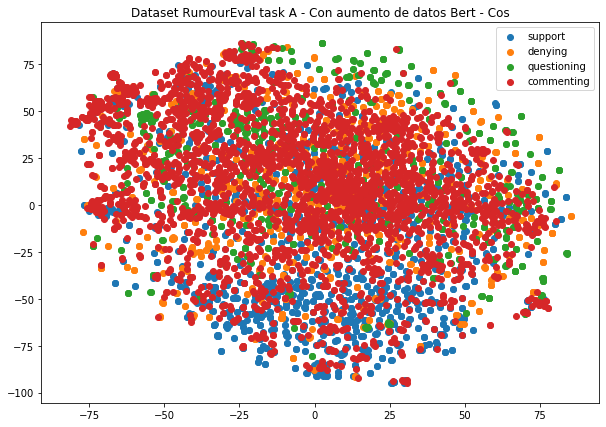

In [152]:
model = TSNE(2, metric='cosine')
to_plot_tsne = model.fit_transform(data_bas_b)    
plt.figure(figsize=(10,7))
for key in keys:
    labels=[dict_cl[lab] for lab in macro_augmented[:,2]]
    mask = np.asarray(labels)==key
    plt.scatter(to_plot_tsne[:,0][mask],to_plot_tsne[:,1][mask], label=str(key))

plt.legend()
plt.title("Dataset RumourEval task A - Con aumento de datos B - Cos")
plt.show()

### Sujeto a Embedding BERT ponderando target

In [156]:
macro_augmented=[]
for clase in aum_weight:
    start_time=time.time()
    print ("\n\nGenerando", aum_weight[clase], "ejemplos para", clase)
    muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, BERT=True, pond=True)
    macro_augmented+=muestras
    print ("Resumen de modificaciones:", dict_aumentos)
    elapsed_time= time.time() - start_time
    print ("Este proceso tomó", elapsed_time, "seg")   



Generando 841 ejemplos para support
Consultando por la clase support
Entrega label 0
Original: conceal  	Reemplazo:  [('uncover', 0.8283363580703735)]
Sentencia original:
['shoot' 'unarmed' 'kid' '.' 'conceal' 'evidence' '.' 'impose' 'martial'
 'law' '.' 'harass' 'reporters' '.' 'smear' 'the' 'victim' '.' 'worst' '.'
 'police' '.' 'ever' '.' 'hashtag' 'hashtag']
Sentencia final: 0
['shoot', 'unarmed', 'kid', '.', 'uncover', 'evidence', '.', 'impose', 'martial', 'law', '.', 'harass', 'reporters', '.', 'smear', 'the', 'victim', '.', 'worst', '.', 'police', '.', 'ever', '.', 'hashtag', 'hashtag']


Original: several  	Reemplazo:  [('numerous', 0.9357398748397827)]
Sentencia original:
['“' 'user' ':' 'several' 'hostages' 'freed' 'at' 'jewish' 'supermarket'
 'in' 'paris' '.' 'photo' 'thomas' 'samson' 'hashtag' 'html' 'schaut'
 'genau' 'hin' '!']
Sentencia final: 0
['“', 'user', ':', 'numerous', 'hostages', 'freed', 'at', 'jewish', 'supermarket', 'in', 'paris', '.', 'photo', 'thomas', 'sam

Original: cafe  	Reemplazo:  [('townsville', 0.47242605686187744)]
Sentencia original:
['sick' '.' '"' 'user' ':' 'up' 'to' 'number' 'held' 'hostage' 'in'
 'sydney' 'lindt' 'cafe' 'siege' 'html' 'html']
Sentencia final: 0
['sick', '.', '"', 'user', ':', 'up', 'to', 'number', 'held', 'hostage', 'in', 'sydney', 'lindt', 'townsville', 'siege', 'html', 'html']


Original: shooting  	Reemplazo:  [('posing', 0.823529064655304)]
Sentencia original:
['et' 'merde' '.' '“' 'user' ':' 'hashtag' '-' 'number' 'dead' 'including'
 'number' 'police' 'in' 'paris' 'shooting' '.' 'photo' 'user' 'hashtag'
 'html']
Sentencia final: 0
['et', 'merde', '.', '“', 'user', ':', 'hashtag', '-', 'number', 'dead', 'including', 'number', 'police', 'in', 'paris', 'posing', '.', 'photo', 'user', 'hashtag', 'html']


Original: s  	Reemplazo:  [('time', 1.068313717842102)]
Sentencia original:
['user' 'user' 'user' 'it' "'" 's' 'across' 'the' 'country' 'and' 'number'
 'hours' 'away' 'lol' 'and' 'it' "'" 's' 'like' '$' 'n

Original: sydney  	Reemplazo:  [('deal', 1.2224934101104736)]
Sentencia original:
['thoughts' 'go' 'out' 'to' 'those' 'in' 'sydney' 'dealing' 'with' 'the'
 'number' '-' 'hostage' 'situation' '“' 'user' 'html']
Sentencia final: 0
['thoughts', 'come', 'out', 'to', 'those', 'in', 'deal', 'dealing', 'with', 'the', 'number', '-', 'hostage', 'situation', '“', 'user', 'html']


Original: show  	Reemplazo:  [('reveal', 0.565696120262146)]
Sentencia original:
['secret' 'prince' 'show' 'rumored' 'for' 'toronto' 'tonight' 'html']
Sentencia final: 0
['secret', 'prince', 'reveal', 'rumored', 'for', 'toronto', 'tonight', 'html']


Original: hold  	Reemplazo:  [('update', 0.8171828985214233)]
Original: am  	Reemplazo:  [('are', 1.1864796876907349)]
Original: watch  	Reemplazo:  [('telecast', 0.6254682540893555)]
Sentencia original:
['hashtag' 'to' 'hold' 'news' 'conference' 'on' 'hashtag' 'shoot' 'at'
 'number' 'pm' 'et' ',' 'number' 'am' 'pt' '.' 'watch' 'live' 'coverage'
 '@' 'html']
Sentencia fina

Original: islamic  	Reemplazo:  [('lebanese', 1.3291819095611572)]
Sentencia original:
['"' 'user' ':' 'hashtag' 'hostages' 'held' 'inside' 'sydney' 'cafe' ','
 'islamic' 'flag' 'held' 'up' '"' '&lt' ';' '&lt' ';' 'terrifying' 'stuff'
 '.' 'nutters&gt' ';' '&gt' ';']
Sentencia final: 0
['"', 'user', ':', 'hashtag', 'hostages', 'held', 'inside', 'sydney', 'cafe', ',', 'lebanese', 'flag', 'held', 'up', '"', '&lt', ';', '&lt', ';', 'terrifying', 'stuff', '.', 'nutters&gt', ';', '&gt', ';']


Original: crossed  	Reemplazo:  [('signed', 1.1130928993225098)]
Sentencia original:
['user' 'user' 'fingers' 'crossed']
Sentencia final: 0
['user', 'user', 'fingers', 'signed']


Original: several  	Reemplazo:  [('many', 0.8646100163459778)]
Original: siege  	Reemplazo:  [('cafes', 0.7572711706161499)]
Original: media  	Reemplazo:  [('locals', 0.31720173358917236)]
Original: say  	Reemplazo:  [('participate', 0.9069371819496155)]
Sentencia original:
['“' 'user' ':' 'several' 'more' 'hostages' 'flee' 

Original: obama  	Reemplazo:  [('guess', 0.8867602348327637)]
Sentencia original:
['user' 'user' 'user' 'i' "'" 'm' 'guessing' 'obama' 'will' 'probably'
 'apologize' 'to' 'the' 'terrorists' 'on' 'canada' "'" 's' 'behalf' '.']
Sentencia final: 0
['user', 'user', 'user', 'i', "'", 'm', 'guessing', 'guess', 'will', 'probably', 'apologize', 'to', 'the', 'terrorists', 'on', 'canada', "'", 's', 'behalf', '.']


Original: show  	Reemplazo:  [('reveal', 0.565696120262146)]
Sentencia original:
['“' 'user' ':' 'secret' 'prince' 'show' 'rumored' 'for' 'toronto'
 'tonight' 'html' 'user']
Sentencia final: 0
['“', 'user', ':', 'secret', 'prince', 'reveal', 'rumored', 'for', 'toronto', 'tonight', 'html', 'user']


Original: memorial  	Reemplazo:  [('identification', 0.5660821795463562)]
Original: nathan  	Reemplazo:  [('closer', 1.9540022611618042)]
Sentencia original:
['hashtag' 'rt' 'user' ':' 'soldier' 'killed' 'at' 'war' 'memorial'
 'identified' 'as' 'cpl' '.' 'nathan' 'cirillo' 'hashtag' 'html']

Original: breaking  	Reemplazo:  [('stealing', 1.121225118637085)]
Original: high  	Reemplazo:  [('low', 0.28351807594299316)]
Sentencia original:
['breaking' ':' 'michael' 'zehaf' '-' 'bebeau' 'had' 'been' 'designated'
 '"' 'high' '-' 'risk' 'traveller' '"' 'by' 'cdn' 'govt' ',' 'which'
 'confiscated' 'his' 'passport' 'html']
Sentencia final: 0
['stealing', ':', 'michael', 'zehaf', '-', 'bebeau', 'had', 'been', 'designated', '"', 'low', '-', 'risk', 'traveller', '"', 'by', 'cdn', 'govt', ',', 'which', 'confiscated', 'his', 'passport', 'html']


Original: i  	Reemplazo:  [('somebody', 0.5444561839103699)]
Original: was  	Reemplazo:  [('were', 1.5588524341583252)]
Sentencia original:
['user' 'user' 'i' 'rolled' 'through' 'a' 'stop' 'sign' 'once' ',' 'the'
 'cop' 'was' 'shouting' 'at' 'me' 'like' 'i' 'killed' 'someone' '.' 'i'
 'was' 'terrified' '.' 'they' 'hashtag' '.']
Sentencia final: 0
['user', 'user', 'i', 'rolled', 'through', 'a', 'stop', 'sign', 'once', ',', 'the', 'cop', 'was', '

Original: convenient  	Reemplazo:  [('forget', 1.8322086334228516)]
Sentencia original:
['user' 'user' 'agreed' ',' 'its' 'convenient' 'they' 'forgot' 'to'
 'mention' 'that' 'detail' '.']
Sentencia final: 0
['user', 'user', 'wiggled', ',', 'its', 'forget', 'they', 'forgot', 'to', 'mention', 'that', 'detail', '.']


Original: ve  	Reemplazo:  [('mixer', 0.777190625667572)]
Sentencia original:
['most' 'compelling' 'image' 'i' "'" 've' 'seen' 'to' 'come' 'out' 'of'
 'horrifying' 'events' 'in' 'paris' ',' 'courtesy' 'of' 'banksy' '.'
 'hashtag' 'html']
Sentencia final: 0
['most', 'compelling', 'image', 'i', "'", 'mixer', 'seen', 'to', 'come', 'out', 'of', 'horrifying', 'events', 'in', 'paris', ',', 'courtesy', 'of', 'banksy', '.', 'hashtag', 'html']


Original: rt  	Reemplazo:  [('listener', 0.644952118396759)]
Original: intro  	Reemplazo:  [('introduction', 1.1675015687942505)]
Sentencia original:
['way' 'uncool' ',' 'user' '.' 'rt' 'user' ':' 'uber' 'intro' 'surge'
 'pricing' 'in' 'downt

Sentencia original:
['stills' 'from' 'eyewitness' 'video' 'show' 'two' 'hashtag' 'attackers'
 'wearing' 'hood' '&amp' ';' 'black' 'clothing' 'shoot' 'a' 'wounded'
 'man' 'html']
Sentencia final: 0
['eyebrows', 'from', 'eyewitness', 'video', 'show', 'two', 'hashtag', 'attackers', 'wearing', 'hood', '&amp', ';', 'black', 'apparel', 'shoot', 'a', 'wounded', 'man', 'html']


Original: police  	Reemplazo:  [('witnesses', 1.521114468574524)]
Sentencia original:
['“' 'user' ':' 'witness' ':' 'police' 'allegedly' 'stopped' 'mike'
 'brown' 'after' 'yelling' 'at' 'him' 'to' 'walk' 'on' 'sidewalk' '.'
 'hashtag' 'html']
Sentencia final: 0
['“', 'user', ':', 'witness', ':', 'witnesses', 'allegedly', 'stopped', 'mike', 'brown', 'after', 'yelling', 'at', 'him', 'to', 'walk', 'on', 'sidewalk', '.', 'hashtag', 'html']


Original: australian  	Reemplazo:  [('tasmanian', 0.7947706580162048)]
Original: says  	Reemplazo:  [('is', 1.1629832983016968)]
Original: motivated  	Reemplazo:  [('furrowed', 0.84867

Original: police  	Reemplazo:  [('guards', 1.1436315774917603)]
Original: actions  	Reemplazo:  [('reminds', 1.4365285634994507)]
Sentencia original:
['darren' 'wilson' 'is' 'a' 'six' 'year' 'veteran' 'of' 'the' 'hashtag'
 'police' 'and' 'had' 'no' 'disciplinary' 'actions' 'against' 'him' '.']
Sentencia final: 0
['darren', 'wilson', 'is', 'a', 'six', 'year', 'veteran', 'of', 'the', 'hashtag', 'guards', 'and', 'had', 'no', 'disciplinary', 'reminds', 'against', 'him', '.']


Original: read  	Reemplazo:  [('reading', 1.333103895187378)]
Sentencia original:
['user' 'yeah' ',' 'i' 'read' 'about' 'this' 'joker' 'this' 'morning' '-'
 'alleged' 'murder' 'and' 'sex' 'assaults' 'allegations' 'really' 'had'
 'my' 'eyebrow' 'raised' '!']
Sentencia final: 0
['user', 'yeah', ',', 'i', 'reading', 'about', 'this', 'joker', 'this', 'morning', '-', 'alleged', 'murder', 'and', 'sex', 'assaults', 'allegations', 'really', 'had', 'my', 'eyebrow', 'raised', '!']


Original: show  	Reemplazo:  [('reveal', 0.5

Original: convenience  	Reemplazo:  [('detrimental', 0.44234007596969604)]
Sentencia original:
['update' ':' 'hashtag' 'police' 'release' 'stills' 'from' 'convenience'
 'store' 'footage' 'showing' 'robbery' 'html' 'html']
Sentencia final: 0
['update', ':', 'hashtag', 'police', 'release', 'stills', 'from', 'detrimental', 'store', 'footage', 'showing', 'robbery', 'html', 'html']


Original: been  	Reemplazo:  [('called', 0.8167949318885803)]
Sentencia original:
['the' 'soldier' 'shot' 'dead' 'in' 'wednesday' "'" 's' 'ottawa' 'attacks'
 'has' 'been' 'named' 'as' 'cpl' '.' 'nathan' 'cirillo' 'of' 'hashtag'
 'hashtag' 'html']
Sentencia final: 0
['the', 'soldier', 'shot', 'dead', 'in', 'wednesday', "'", 's', 'ottawa', 'attacks', 'has', 'called', 'named', 'as', 'cpl', '.', 'nathan', 'cirillo', 'of', 'hashtag', 'hashtag', 'html']


Original: news  	Reemplazo:  [('shot', 0.8425410389900208)]
Original: developing  	Reemplazo:  [('evolving', 0.8267215490341187)]
Sentencia original:
['hashtag' 'ne

Original: spoke  	Reemplazo:  [('assertion', 0.3737715482711792)]
Sentencia original:
['hostage' '-' 'taker' 'at' 'paris' 'store' 'demands' 'release' 'of'
 'hashtag' 'police' 'union' 'spoke' 'says' '.' 'html' 'html' 'via' 'user']
Sentencia final: 0
['aback', '-', 'taker', 'at', 'paris', 'store', 'releases', 'release', 'of', 'hashtag', 'police', 'union', 'assertion', 'says', '.', 'html', 'html', 'via', 'user']


Original: drivers  	Reemplazo:  [('men', 1.7547039985656738)]
Sentencia original:
['user' 'they' "'" 're' 'asking' 'people' 'to' 'stay' 'indoors' 'and'
 'don' "'" 't' 'go' 'to' 'the' 'cbd' '.' 'why' 'would' 'you' 'send'
 'drivers' 'there' '?' '?' 'really' 'disappointed' 'of' 'user']
Sentencia final: 0
['user', 'they', "'", 're', 'asking', 'people', 'to', 'stay', 'indoors', 'and', 'don', "'", 't', 'go', 'to', 'the', 'cbd', '.', 'why', 'would', 'you', 'send', 'men', 'there', '?', '?', 'really', 'disappointed', 'of', 'user']


Original: brown  	Reemplazo:  [('cerambycidae', 1.48885

Original: house  	Reemplazo:  [('evacuate', 0.8572853803634644)]
Sentencia original:
['rt' 'user' ':' 'sydney' 'opera' 'house' 'evacuated' ',' 'concourse'
 'deserted' 'html' 'hashtag' 'via' 'user' 'html']
Sentencia final: 0
['rt', 'user', ':', 'sydney', 'evacuate', 'evacuate', 'evacuated', ',', 'concourse', 'deserted', 'html', 'hashtag', 'via', 'user', 'html']


Original: family  	Reemplazo:  [('group', 1.2682186365127563)]
Sentencia original:
['user' 'so' 'sorry' 'for' 'him' '&amp' ';' 'his' 'family' '.']
Sentencia final: 0
['user', 'so', 'sorry', 'for', 'him', '&amp', ';', 'his', 'group', '.']


Original: suspects  	Reemplazo:  [('tells', 1.0744589567184448)]
Sentencia original:
['breaking' ':' 'french' 'police' 'tell' 'ap' 'suspects' 'in' 'hashtag'
 'attack' 'have' 'taken' 'a' 'hostage' 'northeast' 'of' 'paris' '.']
Sentencia final: 0
['breaking', ':', 'french', 'police', 'tell', 'ap', 'tells', 'in', 'hashtag', 'attack', 'have', 'taken', 'a', 'hostage', 'northeast', 'of', 'paris', '

Original: grocery  	Reemplazo:  [('supermarket', 0.8382243514060974)]
Sentencia original:
['“' 'user' ':' 'police' 'taking' 'people' 'out' 'of' 'hashtag' 'grocery'
 'where' 'hostages' 'were' 'being' 'held' '.' 'html']
Sentencia final: 0
['“', 'user', ':', 'police', 'taking', 'policemen', 'out', 'of', 'hashtag', 'supermarket', 'where', 'hostages', 'were', 'being', 'held', '.', 'html']


Original: approach  	Reemplazo:  [('methodology', 0.7492876648902893)]
Sentencia original:
['“' 'user' ':' 'official' ':' 'gunman' 'holding' 'at' 'least' 'number'
 'hostages' 'in' 'paris' 'market' 'has' 'threatened' 'to' 'kill' 'them'
 'if' 'police' 'approach' ':' 'html']
Sentencia final: 0
['“', 'user', ':', 'official', ':', 'gunman', 'holding', 'at', 'least', 'number', 'hostages', 'in', 'paris', 'market', 'has', 'threatened', 'to', 'kill', 'them', 'if', 'police', 'methodology', ':', 'html']


Original: london  	Reemplazo:  [('leipzig', 0.5096808075904846)]
Original: rumours  	Reemplazo:  [('russians', 

Original: heartbreak  	Reemplazo:  [('injury', 1.466369867324829)]
Sentencia original:
['breaking' 'news' ':' 'new' 'york' 'times' 'is' 'reporting' 'the'
 'canadian' 'soldier' 'who' 'was' 'shot' 'has' 'died' 'from' 'their'
 'injuries' '.' 'heartbreak' '.' 'hashtag' 'hashtag']
Sentencia final: 0
['breaking', 'news', ':', 'new', 'york', 'times', 'is', 'reporting', 'the', 'canadian', 'soldier', 'who', 'was', 'shot', 'has', 'had', 'from', 'their', 'injuries', '.', 'injury', '.', 'hashtag', 'hashtag']


Original: chief  	Reemplazo:  [('principal', 0.7475852370262146)]
Original: death  	Reemplazo:  [('pistol', 0.7725696563720703)]
Sentencia original:
['the' 'hashtag' 'police' 'chief' 'just' 'basically' 'confirmed' 'hashtag'
 'was' 'gun' 'to' 'death' 'for' 'the' 'crime' 'of' 'walking' 'in' 'the'
 'street' '?' 'horrific' '.']
Sentencia final: 0
['the', 'hashtag', 'police', 'principal', 'just', 'basically', 'confirmed', 'hashtag', 'was', 'gun', 'to', 'pistol', 'for', 'the', 'crime', 'of', 'walk

Original: slick  	Reemplazo:  [('saw', 0.4323287010192871)]
Sentencia original:
['user' 'yeah' '.' 'i' 'caught' 'that' 'too' '.' '"' 'very' 'slick' '"'
 'seeing' 'the' 'framing' 'of' 'the' 'lie' 'starting' 'now' '!']
Sentencia final: 0
['user', 'yeah', '.', 'i', 'caught', 'that', 'too', '.', '"', 'very', 'saw', '"', 'seeing', 'the', 'framing', 'of', 'the', 'lie', 'starting', 'now', '!']


Original: s  	Reemplazo:  [('pisa', 0.2954573333263397)]
Original: place  	Reemplazo:  [('php', 0.2581757605075836)]
Sentencia original:
['breaking' ':' 'live' 'coverage' 'of' 'hostage' 'situation' 'unfolding'
 'in' 'sydney' "'" 's' 'martin' 'place' 'html' 'html']
Sentencia final: 0
['breaking', ':', 'live', 'coverage', 'of', 'hostage', 'situation', 'unfolding', 'in', 'sydney', "'", 'pisa', 'martin', 'php', 'html', 'html']


Original: u  	Reemplazo:  [('junior', 1.2865443229675293)]
Original: has  	Reemplazo:  [('expects', 0.2790617048740387)]
Original: informed  	Reemplazo:  [('empowered', 0.49206215

Original: war  	Reemplazo:  [('wartime', 0.5508664846420288)]
Sentencia original:
['breaking' 'news' ':' 'at' 'least' 'number' 'shots' 'fired' 'at' 'ottawa'
 'war' 'memorial' '.' 'one' 'soldier' 'confirmed' 'shot' '-' 'html' 'html']
Sentencia final: 0
['breaking', 'news', ':', 'at', 'least', 'number', 'shots', 'fired', 'at', 'ottawa', 'wartime', 'memorial', '.', 'one', 'soldier', 'confirmed', 'shot', '-', 'html', 'html']


Original: hostages  	Reemplazo:  [('bruises', 1.612289547920227)]
Sentencia original:
['“' 'user' ':' 'several' 'hostages' 'freed' 'at' 'jewish' 'supermarket'
 'in' 'paris' '.' 'photo' 'thomas' 'samson' 'hashtag' 'html']
Sentencia final: 0
['“', 'user', ':', 'several', 'bruises', 'freed', 'at', 'jewish', 'supermarket', 'in', 'paris', '.', 'photo', 'thomas', 'samson', 'hashtag', 'html']


Original: loose  	Reemplazo:  [('unleashed', 0.7468277812004089)]
Original: soldier  	Reemplazo:  [('policeman', 0.9917708039283752)]
Original: road  	Reemplazo:  [('street', 0.78062

Original: canada  	Reemplazo:  [('canadian', 0.5470794439315796)]
Sentencia original:
['user' 'radio' 'canada' 'tweeting' 'same' '.' 'must' 'be' 'true' ':' '-']
Sentencia final: 0
['user', 'radio', 'canadian', 'tweeting', 'same', '.', 'must', 'be', 'true', ':', '-']


Original: cafe  	Reemplazo:  [('mosque', 1.5913127660751343)]
Sentencia original:
['hashtag' 'hashtag' 'hashtag' 'user' ':' 'hashtag' 'hashtag' 'held'
 'inside' 'hashtag' 'cafe' ',' 'islamic' 'flag' 'held' 'up']
Sentencia final: 0
['hashtag', 'hashtag', 'hashtag', 'user', ':', 'hashtag', 'hashtag', 'held', 'inside', 'hashtag', 'mosque', ',', 'islamic', 'flag', 'held', 'up']


Original: siege  	Reemplazo:  [('parramatta', 0.9127541184425354)]
Sentencia original:
['“' 'user' ':' 'live' 'updates' ':' 'siege' 'in' 'sydney' 'cafe' '"'
 '&gt' ';' 'guess' 'who' '.' 'that' "'" 's' 'right' 'muslims' 'html']
Sentencia final: 0
['“', 'user', ':', 'live', 'updates', ':', 'parramatta', 'in', 'sydney', 'cafe', '"', '&gt', ';', 'guess',

Original: has  	Reemplazo:  [('is', 1.282258152961731)]
Sentencia original:
['user' 'user' 'user' 'the' '1st' 'has' 'been' 'on' 'for' '7h30' 'and'
 'the' 'second' 'for' '4hrs']
Sentencia final: 0
['user', 'user', 'user', 'the', '1st', 'is', 'been', 'on', 'for', '7h30', 'and', 'the', 'second', 'for', '4hrs']


Original: thursday  	Reemplazo:  [('wednesday', 0.5287880301475525)]
Original: attack  	Reemplazo:  [('assault', 1.1860946416854858)]
Sentencia original:
['update' '-' 'afp' ':' 'an' 'unnamed' 'police' 'source' 'says' 'the'
 'killing' 'of' 'the' 'policewoman' 'in' 'hashtag' 'on' 'thursday' 'is'
 'linked' 'to' 'the' 'hashtag' 'attack']
Sentencia final: 0
['update', '-', 'afp', ':', 'an', 'unnamed', 'police', 'source', 'says', 'the', 'killing', 'of', 'the', 'policewoman', 'in', 'hashtag', 'on', 'wednesday', 'is', 'linked', 'to', 'the', 'hashtag', 'assault']


Original: oh  	Reemplazo:  [('yeah', 0.7872011661529541)]
Original: sure  	Reemplazo:  [('yeah', 1.7737966775894165)]
Sentenc

Original: hat  	Reemplazo:  [('bookstore', 0.6053175926208496)]
Sentencia original:
['.' 'user' 'yes' '.' 'they' 'don' "'" 't' 'match' '.' 'flip' 'flop' '+'
 'hat' 'in' 'store' '.' 'shoes' '+' 'no' 'hat' 'in' 'final' 'pic' '.']
Sentencia final: 0
['.', 'user', 'yes', '.', 'they', 'don', "'", 't', 'match', '.', 'flip', 'flop', '+', 'bookstore', 'in', 'store', '.', 'shoes', '+', 'no', 'hat', 'in', 'final', 'pic', '.']


Original: killed  	Reemplazo:  [('assassinated', 0.7687786221504211)]
Sentencia original:
['reports' ':' 'hashtag' 'suspects' 'killed' 'html']
Sentencia final: 0
['reports', ':', 'hashtag', 'suspects', 'assassinated', 'html']


Original: police  	Reemplazo:  [('storms', 0.27792230248451233)]
Sentencia original:
['user' ':' 'both' 'charlie' 'hebdo' 'suspects' 'killed' 'as' 'police'
 'storm' 'building' 'police' 'sources' 'html' 'html' 'hashtag']
Sentencia final: 0
['user', ':', 'both', 'charlie', 'hebdo', 'suspects', 'killed', 'as', 'police', 'storm', 'building', 'storms', 

Original: weapons  	Reemplazo:  [('rulers', 0.8150522708892822)]
Original: drawn  	Reemplazo:  [('draw', 0.828892171382904)]
Sentencia original:
['breaking' '-' 'shooting' 'on' 'parliament' 'hill' '.' 'rcmp' 'have'
 'weapons' 'drawn' 'hashtag' 'html']
Sentencia final: 0
['breaking', '-', 'shooting', 'on', 'parliament', 'hill', '.', 'rcmp', 'have', 'rulers', 'draw', 'hashtag', 'html']


Original: escaped  	Reemplazo:  [('leaped', 0.8381799459457397)]
Sentencia original:
['hashtag' 'reports' 'two' 'customers' 'and' 'an' 'employee' 'have'
 'escaped' 'the' 'hashtag' 'html']
Sentencia final: 0
['hashtag', 'reports', 'two', 'customers', 'and', 'an', 'employee', 'have', 'leaped', 'the', 'hashtag', 'html']


Original: was  	Reemplazo:  [('went', 1.284748911857605)]
Sentencia original:
['ottawa' 'police' 'service' ':' 'there' 'were' '"' 'numerous' 'gunmen'
 '"' 'at' 'the' 'canada' 'war' 'memorial' 'shooting' '.' 'one' 'person'
 'was' 'shot' '.' 'html']
Sentencia final: 0
['ottawa', 'police', 's

Original: say  	Reemplazo:  [('emphasize', 0.5131247043609619)]
Original: situation  	Reemplazo:  [('position', 1.1866469383239746)]
Sentencia original:
['user' 'i' 'say' 'even' 'before' 'journalists' ',' 'citizens' '!' 'but'
 'now' 'the' 'journalists' 'can' 'put' 'light' 'on' 'the' 'situation' ','
 'it' "'" 's' 'all' 'across' 'the' 'u' '.' 's' '.']
Sentencia final: 0
['user', 'i', 'emphasize', 'even', 'before', 'journalists', ',', 'citizens', '!', 'but', 'now', 'the', 'journalists', 'can', 'put', 'light', 'on', 'the', 'position', ',', 'it', "'", 's', 'all', 'across', 'the', 'u', '.', 's', '.']


Original: tell  	Reemplazo:  [('ko', 0.4893817603588104)]
Sentencia original:
['st' '.' 'louis' 'co' 'police' 'tell' 'me' 'ofcr' 'shot' 'a' 'man' 'who'
 'pointed' 'handgun' 'at' 'him' 'at' 'chambers' '&amp' ';' 'sheffingdell'
 'at' 'about' 'number' 'a' '.' 'm' '.' 'man' 'in' 'critical' '.' 'hashtag']
Sentencia final: 0
['st', '.', 'louis', 'co', 'police', 'ko', 'me', 'ofcr', 'shot', 'a', 'man'

Original: suicide  	Reemplazo:  [('undertake', 0.4381716549396515)]
Original: demand  	Reemplazo:  [('qaeda', 1.6276837587356567)]
Original: ’  	Reemplazo:  [('lankan', 2.3043837547302246)]
Sentencia original:
['hashtag' ':' 'hostage' '-' 'takers' '‘' 'have' 'suicide' 'belts' ','
 'demand' 'radio' 'convo' 'with' 'hashtag' '’' '–' 'report' 'html' 'html']
Sentencia final: 0
['hashtag', ':', 'hostage', '-', 'takers', '‘', 'have', 'undertake', 'belts', ',', 'qaeda', 'radio', 'convo', 'with', 'hashtag', 'lankan', '–', 'report', 'html', 'html']


Original: box  	Reemplazo:  [('qaeda', 2.673335552215576)]
Original: number  	Reemplazo:  [('period', 0.7025112509727478)]
Sentencia original:
['here' "'" 's' 'the' 'police' 'report' '.' 'somehow' 'hashtag' 'cops'
 'valued' 'a' 'box' 'of' 'swishers' 'at' 'nearly' '$' 'number' '.' 'time'
 'to' 'stop' 'smokin' 'i' 'guess' 'html']
Sentencia final: 0
['here', "'", 's', 'the', 'police', 'report', '.', 'somehow', 'hashtag', 'cops', 'valued', 'a', 'qaeda',

Original: years  	Reemplazo:  [('months', 0.91233229637146)]
Original: police  	Reemplazo:  [('policemen', 0.6982135772705078)]
Original: police  	Reemplazo:  [('smashwords', 3.2202179431915283)]
Sentencia original:
['clarissa' ',' 'number' 'years' 'old' ',' 'police' 'trainee' 'of'
 'montrouge' 'police' 'in' 'hashtag' '.' 'victim' 'of' 'this' 'morning'
 "'" 's' 'attack' '.' 'via' 'user' 'html']
Sentencia final: 0
['clarissa', ',', 'number', 'months', 'old', ',', 'policemen', 'trainee', 'of', 'montrouge', 'smashwords', 'in', 'hashtag', '.', 'victim', 'of', 'this', 'morning', "'", 's', 'attack', '.', 'via', 'user', 'html']


Original: shooting  	Reemplazo:  [('telling', 0.6296703815460205)]
Original: french  	Reemplazo:  [('english', 0.5936103463172913)]
Sentencia original:
['hashtag' 'shooting' 'suspects' 'tell' 'police' 'they' "'" 'prepared'
 'to' 'die' 'as' 'martyrs' "'" '-' 'french' 'media' 'html' 'html']
Sentencia final: 0
['hashtag', 'telling', 'suspects', 'tell', 'police', 'they',

Original: sale  	Reemplazo:  [('woken', 1.473732352256775)]
Sentencia original:
['user' 'i' 'don' "'" 't' 'think' 'it' "'" 's' 'even' 'been' 'on' 'sale'
 'yet']
Sentencia final: 0
['user', 'i', 'don', "'", 't', 'think', 'it', "'", 's', 'even', 'gone', 'on', 'woken', 'yet']


Original: photo  	Reemplazo:  [('picture', 1.965700626373291)]
Sentencia original:
['only' 'photo' 'i' 'will' 'tweet' '.' 'cpr' 'being' 'performed' 'on'
 'the' 'soldier' 'now' '.' 'i' 'heard' 'four' 'shots' '.' 'hashtag' 'html']
Sentencia final: 0
['only', 'picture', 'i', 'will', 'tweet', '.', 'cpr', 'being', 'performed', 'on', 'the', 'soldier', 'now', '.', 'i', 'heard', 'four', 'shots', '.', 'hashtag', 'html']


Original: hostages  	Reemplazo:  [('gathers', 0.5383288264274597)]
Sentencia original:
['user' 'here' "'" 's' 'to' 'all' 'the' 'hostages' 'getting' 'safe'
 'passage' 'on' 'this' 'day' '!' 'user' 'hashtag']
Sentencia final: 0
['user', 'here', "'", 's', 'to', 'all', 'the', 'gathers', 'getting', 'safe', 'pass

Original: police  	Reemplazo:  [('policemen', 1.422410011291504)]
Sentencia original:
['police' 'convoy' 'and' 'helicopters' 'are' 'rushing' 'to' 'scene' 'to'
 'detain' 'charlie' 'hebdo' 'massacre' 'suspects' 'html' 'html']
Sentencia final: 0
['policemen', 'convoy', 'and', 'helicopters', 'are', 'rushing', 'to', 'scene', 'to', 'detain', 'charlie', 'hebdo', 'massacre', 'suspects', 'html', 'html']


Original: wasn  	Reemplazo:  [('essendon', 0.4379211664199829)]
Sentencia original:
['“' 'user' ':' 'sydney' 'airspace' 'wasn' "'" 't' 'closed' '.' 'a'
 'second' 'terror' 'suspect' 'wasn' "'" 't' 'arrested' '.' 'myths'
 'around' 'hashtag' 'debunked' '.' 'html']
Sentencia final: 0
['“', 'user', ':', 'sydney', 'airspace', 'essendon', "'", 't', 'closed', '.', 'a', 'second', 'terror', 'suspect', 'wasn', "'", 't', 'arrested', '.', 'myths', 'around', 'hashtag', 'debunked', '.', 'html']


Original: i  	Reemplazo:  [('ii', 0.7851760387420654)]
Sentencia original:
['user' 'user' 'user' 'i' "'" 'll' 'gi

Original: hill  	Reemplazo:  [('mountain', 0.7781749963760376)]
Sentencia original:
['shots' 'fired' 'on' 'parliament' 'hill' 'after' 'a' 'man' 'walked' 'up'
 'with' 'a' 'gun' '.' 'i' "'" 'm' 'locked' 'in' 'a' 'security' 'office'
 'on' 'parliament' 'hill']
Sentencia final: 0
['shots', 'fired', 'on', 'parliament', 'hill', 'after', 'a', 'man', 'walked', 'up', 'with', 'a', 'gun', '.', 'ii', "'", 'm', 'locked', 'in', 'a', 'security', 'office', 'on', 'parliament', 'mountain']


Original: love  	Reemplazo:  [('time', 1.9864482879638672)]
Sentencia original:
['user' 'rip' 'nathan' ',' 'we' 'love' 'you']
Sentencia final: 0
['user', 'rip', 'nathan', ',', 'we', 'time', 'you']


Original: cigar  	Reemplazo:  [('steal', 0.423146516084671)]
Sentencia original:
['user' 'because' 'jaywalking' 'and' 'stealing' 'cigar' 'are' 'capital'
 'crimes' '.' 'it' "'" 's' 'the' 'classic' '"' 'blame' 'the' 'victim' '"'
 'defense' '.']
Sentencia final: 0
['user', 'because', 'jaywalking', 'and', 'stealing', 'steal',

Original: newspaper  	Reemplazo:  [('frenchman', 0.479862779378891)]
Original: paris  	Reemplazo:  [('rome', 2.1375796794891357)]
Sentencia original:
['“' 'user' ':' 'at' 'least' 'number' 'killed' 'in' 'shooting' 'at'
 'french' 'satirical' 'newspaper' 'charlie' 'hebdo' ',' 'paris'
 'prosecutor' "'" 's' 'office' 'says' '.' 'html']
Sentencia final: 0
['“', 'user', ':', 'at', 'least', 'number', 'killed', 'in', 'shooting', 'at', 'french', 'satirical', 'frenchman', 'charlie', 'hebdo', ',', 'rome', 'prosecutor', "'", 's', 'office', 'says', '.', 'html']


Original: others  	Reemplazo:  [('beliefs', 0.9439335465431213)]
Original: t  	Reemplazo:  [('feel', 0.49336865544319153)]
Sentencia original:
['user' 'not' 'in' 'anyway' 'justifying' 'the' 'violence' 'but' 'why'
 'the' 'intentionally' 'hurting' 'of' 'others' 'believe' '?' 'it' 'doesn'
 "'" 't' 'make' 'sense' '.']
Sentencia final: 0
['user', 'not', 'in', 'anyway', 'justifying', 'the', 'violence', 'but', 'why', 'the', 'intentionally', 'hurtin

Original: something  	Reemplazo:  [('someplace', 0.6285253167152405)]
Original: generic  	Reemplazo:  [('somethin', 1.0274518728256226)]
Original: targeted  	Reemplazo:  [('aimed', 0.8091130256652832)]
Sentencia original:
['user' 'u' 'r' 'among' 'the' 'only' 'journalists' 'saying' 'kosher'
 'market' '&amp' ';' 'not' 'calling' 'it' 'something' 'generic' '.' 'if'
 'it' "'" 's' 'kosher' 'it' 'was' 'targeted' '.' 'thx']
Sentencia final: 0
['user', 'u', 'r', 'among', 'the', 'only', 'journalists', 'saying', 'kosher', 'field', '&amp', ';', 'not', 'calling', 'it', 'someplace', 'somethin', '.', 'if', 'it', "'", 's', 'kosher', 'it', 'was', 'aimed', '.', 'thx']


Original: french  	Reemplazo:  [('rican', 2.3761332035064697)]
Sentencia original:
['french' 'police' ':' 'said' 'kouachi' 'and' 'cherif' 'kouachi' 'wanted'
 'in' 'paris' 'terror' 'attack' ':' 'html' 'html']
Sentencia final: 0
['rican', 'police', ':', 'said', 'kouachi', 'and', 'cherif', 'kouachi', 'wanted', 'in', 'paris', 'terror', 'atta

Original: number  	Reemplazo:  [('multitude', 0.535128653049469)]
Original: n  	Reemplazo:  [('group', 1.1869232654571533)]
Sentencia original:
['user' 'thy' 'wil' 'bcum' 'satan' 'aftr' 'death' '!' 'kep' 'drmng' 'abt'
 'martdm' '&amp' ';' 'abt' 'thse' 'number' 'virgin' 'n' 'heavn' '!' 'n'
 'india' 'we' 'mde' 'mny' 'trrorsts' ',' 'satan' 'n' 'kashmir' '!' 'o']
Sentencia final: 0
['user', 'thy', 'wil', 'bcum', 'satan', 'aftr', 'death', '!', 'kep', 'drmng', 'abt', 'martdm', '&amp', ';', 'abt', 'thse', 'multitude', 'virgin', 'group', 'heavn', '!', 'n', 'india', 'we', 'mde', 'mny', 'trrorsts', ',', 'satan', 'n', 'kashmir', '!', 'o']


Original: number  	Reemplazo:  [('multitude', 0.483919620513916)]
Original: are  	Reemplazo:  [('am', 0.4530176520347595)]
Original: treated  	Reemplazo:  [('subjected', 1.2745065689086914)]
Sentencia original:
['“' 'user' ':' 'hashtag' ':' 'at' 'least' 'two' 'people' 'have' 'died'
 'following' 'the' 'hashtag' '.' 'number' 'people' 'are' 'being' 'treated'
 'by

Original: ottawa  	Reemplazo:  [('hadn', 1.4503064155578613)]
Original: been  	Reemplazo:  [('showcased', 0.4572688937187195)]
Original: shot  	Reemplazo:  [('become', 0.7631977200508118)]
Sentencia original:
['the' 'gunman' 'in' 'ottawa' 'has' 'been' 'shot' 'and' 'killed' '.' 'i'
 "'" 'm' 'at' 'a' 'loss' 'for' 'words' 'this' 'morning' '.' 'that' 'isn'
 "'" 't' 'my' 'canada' '.']
Sentencia final: 0
['the', 'gunman', 'in', 'hadn', 'has', 'showcased', 'become', 'and', 'killed', '.', 'i', "'", 'm', 'at', 'a', 'loss', 'for', 'words', 'this', 'morning', '.', 'that', 'isn', "'", 't', 'my', 'canada', '.']


Original: unknown  	Reemplazo:  [('unclear', 0.7298109531402588)]
Sentencia original:
['police' ':' 'negotiators' 'are' 'now' 'in' 'contact' 'with' 'armed'
 'hostage' '-' 'taker' 'in' 'sydney' 'situation' ';' 'motive' 'remains'
 'unknown' '-' 'html']
Sentencia final: 0
['police', ':', 'negotiators', 'are', 'now', 'in', 'contact', 'with', 'armed', 'hostage', '-', 'taker', 'in', 'sydney', 's

Original: level  	Reemplazo:  [('northernmost', 0.274772971868515)]
Original: suspects  	Reemplazo:  [('discovers', 1.2481547594070435)]
Sentencia original:
['paris' 'says' 'highest' 'alert' 'level' 'extended' 'north' 'to' 'region'
 'where' 'attack' 'suspects' 'spotted' '-' 'user' ',' 'user' 'html']
Sentencia final: 0
['paris', 'says', 'highest', 'alert', 'northernmost', 'extended', 'north', 'to', 'region', 'where', 'attack', 'discovers', 'spotted', '-', 'user', ',', 'user', 'html']


Original: lost  	Reemplazo:  [('missed', 1.091171383857727)]
Sentencia original:
['this' 'afternoon' 'we' "'" 've' 'lowered' 'our' 'flags' 'to' 'half'
 'mast' 'in' 'honour' 'of' 'the' 'canadian' 'reservist' 'who' 'lost' 'his'
 'life' 'in' 'ottawa' '.' 'html']
Sentencia final: 0
['this', 'afternoon', 'we', "'", 've', 'lowered', 'our', 'flags', 'to', 'half', 'mast', 'in', 'honour', 'of', 'the', 'canadian', 'reservist', 'who', 'missed', 'his', 'life', 'in', 'ottawa', '.', 'html']


Original: perpetrators  	R

Original: darren  	Reemplazo:  [('priorities', 0.8656383156776428)]
Sentencia original:
['rt' 'user' ':' 'urgent' ':' 'darren' 'wilson' 'is' 'the' 'police'
 'officer' 'who' 'shot' 'mike' 'brown' 'html' 'hashtag' 'html']
Sentencia final: 0
['rt', 'user', ':', 'catchment', ':', 'priorities', 'wilson', 'is', 'the', 'police', 'officer', 'who', 'shot', 'mike', 'brown', 'html', 'hashtag', 'html']


Original: reports  	Reemplazo:  [('abnormalities', 1.0615288019180298)]
Original: appear  	Reemplazo:  [('disclose', 0.6325322985649109)]
Sentencia original:
['“' 'user' ':' 'breaking' 'alert' ':' 'preliminary' 'reports' 'indicate'
 'perpetrators' 'appear' 'to' 'be' 'members' 'of' 'hashtag' '.' 'hashtag'
 '”' 'well' 'this' 'is' 'good']
Sentencia final: 0
['“', 'user', ':', 'breaking', 'alert', ':', 'preliminary', 'abnormalities', 'indicate', 'perpetrators', 'disclose', 'to', 'be', 'members', 'of', 'hashtag', '.', 'hashtag', '”', 'well', 'this', 'is', 'good']


Original: show  	Reemplazo:  [('film'

Original: was  	Reemplazo:  [('lauded', 0.5969356894493103)]
Sentencia original:
['“' 'user' ':' 'secret' 'prince' 'show' 'rumored' 'for' 'toronto'
 'tonight' 'html' 'wishing' 'this' 'was' 'nyc' 'user']
Sentencia final: 0
['“', 'user', ':', 'secret', 'prince', 'show', 'rumored', 'for', 'toronto', 'tonight', 'html', 'wishing', 'this', 'lauded', 'nyc', 'user']


Original: shot  	Reemplazo:  [('cut', 0.45420411229133606)]
Original: reason  	Reemplazo:  [('time', 3.5574028491973877)]
Sentencia original:
['user' 'no' ',' 'because' 'that' 'would' 'require' 'reasoning' 'and'
 'then' 'if' 'reasoning' 'is' 'applied' ',' 'no' 'one' 'can' 'be' 'shot'
 '.' 'shoot' 'now' ',' 'reason' 'later' '.']
Sentencia final: 0
['user', 'no', ',', 'because', 'that', 'would', 'require', 'reasoning', 'and', 'then', 'if', 'reasoning', 'is', 'applied', ',', 'no', 'one', 'can', 'be', 'cut', '.', 'shoot', 'now', ',', 'time', 'later', '.']


Original: making  	Reemplazo:  [('creating', 0.7581629753112793)]
Sentencia o

Original: soldier  	Reemplazo:  [('shoot', 0.516472578048706)]
Original: nathan  	Reemplazo:  [('ethan', 1.8609133958816528)]
Sentencia original:
['the' 'soldier' 'shot' 'dead' 'in' 'wednesday' "'" 's' 'ottawa' 'attacks'
 'has' 'been' 'named' 'as' 'cpl' '.' 'nathan' 'cirillo' 'of' 'hashtag'
 'hashtag' 'html']
Sentencia final: 0
['the', 'shoot', 'shot', 'dead', 'in', 'wednesday', "'", 's', 'ottawa', 'attacks', 'has', 'been', 'named', 'as', 'cpl', '.', 'ethan', 'cirillo', 'of', 'hashtag', 'hashtag', 'html']


Original: breaking  	Reemplazo:  [('violating', 0.9293038845062256)]
Sentencia original:
['“' 'user' ':' 'breaking' ':' 'one' 'person' 'seriously' 'wounded' ','
 'six' 'taken' 'hostage' 'in' 'incident' 'at' 'kosher' 'supermarket' 'in'
 'paris' ':' 'police' 'source' '"' 'mondo' 'cane' '!']
Sentencia final: 0
['“', 'user', ':', 'violating', ':', 'one', 'person', 'seriously', 'wounded', ',', 'six', 'taken', 'hostage', 'in', 'incident', 'at', 'kosher', 'supermarket', 'in', 'paris', ':',

Original: samson  	Reemplazo:  [('purification', 0.7931976318359375)]
Sentencia original:
['“' 'user' ':' 'several' 'hostages' 'freed' 'at' 'jewish' 'supermarket'
 'in' 'paris' '.' 'photo' 'thomas' 'samson' 'hashtag' 'html']
Sentencia final: 0
['“', 'user', ':', 'several', 'detainees', 'yiddish', 'at', 'jewish', 'supermarket', 'in', 'photograph', '.', 'photo', 'thomas', 'purification', 'hashtag', 'html']


Original: people  	Reemplazo:  [('children', 0.8121883273124695)]
Original: hostages  	Reemplazo:  [('weren', 1.2998028993606567)]
Sentencia original:
['“' 'user' ':' 'police' 'taking' 'people' 'out' 'of' 'hashtag' 'grocery'
 'where' 'hostages' 'were' 'being' 'held' '.' 'html']
Sentencia final: 0
['“', 'user', ':', 'police', 'taking', 'children', 'out', 'of', 'hashtag', 'grocery', 'where', 'weren', 'were', 'being', 'held', '.', 'html']


Original: opera  	Reemplazo:  [('brisbane', 0.5397497415542603)]
Original: house  	Reemplazo:  [('farmhouse', 0.8646751642227173)]
Original: abbott 

Original: cartoonist  	Reemplazo:  [('rearview', 2.5525081157684326)]
Sentencia original:
['rip' 'satire' '“' 'user' ':' '“' 'user' ':' 'hashtag' ':' '“' 'the'
 'cartoonist' 'charb' '&amp' ';' 'cabu' 'are' 'dead' '.' '”' 'html' 'html']
Sentencia final: 0
['rip', 'satire', '“', 'user', ':', '“', 'user', ':', 'hashtag', ':', '“', 'the', 'rearview', 'charb', '&amp', ';', 'cabu', 'are', 'dead', '.', '”', 'html', 'html']


Original: admitted  	Reemplazo:  [('known', 1.2086483240127563)]
Sentencia original:
['user' 'he' 'just' 'admitted' 'on' 'national' 'tv' 'that' 'michael'
 'brown' 'was' 'racial' 'profiled']
Sentencia final: 0
['user', 'he', 'just', 'known', 'on', 'national', 'tv', 'that', 'michael', 'brown', 'was', 'racial', 'profiled']


Original: yes  	Reemplazo:  [('policemen', 0.764844536781311)]
Original: peoples  	Reemplazo:  [('lives', 0.9015784859657288)]
Sentencia original:
['user' 'user' 'yes' 'but' 'cops' 'only' 'shoot' 'for' 'stealing'
 'material' 'things' '.' 'not' 'peoples' 

Original: fake  	Reemplazo:  [('left', 1.1984922885894775)]
Original: i  	Reemplazo:  [('ii', 0.7302566766738892)]
Sentencia original:
['user' 'user' 'did' 'i' 'say' 'it' 'was' 'fake' 'u' ',' 'are' 'u'
 'stupid' 'or' 'dumb' '?' 'i' 'said' 'why' 'show' 'it' 'now' '.']
Sentencia final: 0
['user', 'user', 'did', 'i', 'say', 'it', 'was', 'left', 'u', ',', 'are', 'u', 'stupid', 'or', 'dumb', '?', 'ii', 'said', 'why', 'show', 'it', 'now', '.']


Original: least  	Reemplazo:  [('most', 3.528327465057373)]
Sentencia original:
['rt' 'user' 'hashtag' '-' 'at' 'least' 'five' 'hostages' 'in' 'paris'
 'kosher' 'supermarket' ':' 'afp' 'html' 'hashtag' 'html']
Sentencia final: 0
['rt', 'user', 'hashtag', '-', 'at', 'most', 'five', 'hostages', 'in', 'paris', 'kosher', 'supermarket', ':', 'afp', 'html', 'hashtag', 'html']


Original: part  	Reemplazo:  [('side', 0.7341828346252441)]
Sentencia original:
['rt' '“' 'user' ':' 'the' 'sydney' 'cafe' 'siege' 'may' 'be' 'part' 'of'
 'a' 'larger' 'plot' '.' 'h

Original: s  	Reemplazo:  [('demand', 1.437354326248169)]
Sentencia original:
['tv' 'channels' 'have' 'chosen' 'not' 'to' 'show' 'videos' 'of'
 'hostages' 'relay' 'hashtag' 'gunman' "'" 's' 'demands' '.' 'html' 'html']
Sentencia final: 0
['tv', 'channels', 'have', 'chosen', 'not', 'to', 'show', 'videos', 'of', 'hostages', 'relay', 'hashtag', 'gunman', "'", 'demand', 'demands', '.', 'html', 'html']


Original: samson  	Reemplazo:  [('purification', 0.7931976318359375)]
Original: dead  	Reemplazo:  [('third', 0.8982813358306885)]
Sentencia original:
['“' 'user' ':' 'several' 'hostages' 'freed' 'at' 'jewish' 'supermarket'
 'in' 'paris' '.' 'photo' 'thomas' 'samson' 'hashtag' 'html' 'second'
 'terrorist' 'dead']
Sentencia final: 0
['“', 'user', ':', 'several', 'hostages', 'freed', 'at', 'jewish', 'supermarket', 'in', 'paris', '.', 'photo', 'thomas', 'purification', 'hashtag', 'html', 'second', 'terrorist', 'third']


Original: ready  	Reemplazo:  [('prepared', 1.1655635833740234)]
Original

Original: s  	Reemplazo:  [('assertion', 0.6126660108566284)]
Sentencia original:
['“' 'user' ':' 'prime' 'minister' 'tony' 'abbott' "'" 's' 'statement'
 'on' 'the' 'hashtag' '.' 'updates' ':' 'html' 'html']
Sentencia final: 0
['“', 'user', ':', 'prime', 'minister', 'tony', 'brigadier', "'", 'assertion', 'statement', 'on', 'the', 'hashtag', '.', 'updates', ':', 'html', 'html']


Original: cafe  	Reemplazo:  [('cafes', 1.0345810651779175)]
Sentencia original:
['up' 'to' 'number' 'held' 'hostage' 'in' 'sydney' 'lindt' 'cafe' 'siege'
 'html' 'html']
Sentencia final: 0
['up', 'to', 'number', 'held', 'hostage', 'in', 'sydney', 'lindt', 'cafes', 'siege', 'html', 'html']


Original: jewish  	Reemplazo:  [('judaism', 0.8260300159454346)]
Sentencia original:
['rt' 'user' ':' 'several' 'hostages' 'freed' 'at' 'jewish' 'supermarket'
 'in' 'paris' '.' 'photo' 'thomas' 'samson' 'hashtag' 'html']
Sentencia final: 0
['rt', 'user', ':', 'several', 'hostages', 'freed', 'at', 'judaism', 'supermarket', '

Original: member  	Reemplazo:  [('man', 0.698610782623291)]
Sentencia original:
['breaking' ':' 'a' 'source' 'confirms' 'to' 'cp24' 'that' 'the'
 'deceased' 'soldier' 'in' 'ottawa' 'is' 'cpl' '.' 'nathan' 'cirillo' '.'
 'cirillo' 'was' 'a' 'member' 'of' 'the' 'hamilton' 'argyll']
Sentencia final: 0
['following', ':', 'a', 'source', 'confirms', 'to', 'cp24', 'that', 'the', 'deceased', 'soldier', 'in', 'ottawa', 'is', 'cpl', '.', 'nathan', 'cirillo', '.', 'cirillo', 'were', 'a', 'man', 'of', 'the', 'hamilton', 'argyll']


Original: demands  	Reemplazo:  [('releases', 0.448667973279953)]
Sentencia original:
['hostage' '-' 'taker' 'at' 'paris' 'store' 'demands' 'release' 'of'
 'hashtag' ',' 'police' 'union' 'spokesman' 'says' '.' 'html' 'html']
Sentencia final: 0
['hostage', '-', 'taker', 'at', 'paris', 'store', 'releases', 'release', 'of', 'hashtag', ',', 'police', 'union', 'spokesman', 'says', '.', 'html', 'html']


Original: hostages  	Reemplazo:  [('knees', 3.255188226699829)]
Original

Original: surprise  	Reemplazo:  [('shock', 2.243892192840576)]
Sentencia original:
['prince' 'fans' 'lining' 'up' 'at' 'massey' 'hall' '.' 'wristbands' 'for'
 'surprise' 'show' 'reportedly' 'on' 'sale' 'at' '6pm' '.' 'hashtag'
 'html']
Sentencia final: 0
['prince', 'fans', 'lining', 'up', 'at', 'massey', 'hall', '.', 'wristbands', 'for', 'shock', 'show', 'reportedly', 'on', 'sale', 'at', '6pm', '.', 'hashtag', 'html']


Original: is  	Reemplazo:  [('has', 0.4284994304180145)]
Sentencia original:
['user' '{heaven' 'and' 'hell' 'is' 'right' 'here' 'on' 'earth' '.' "'"
 'ing}']
Sentencia final: 0
['user', '{heaven', 'and', 'hell', 'has', 'right', 'here', 'on', 'earth', '.', "'", 'ing}']


Original: statement  	Reemplazo:  [('lumpur', 2.0081627368927)]
Original: australian  	Reemplazo:  [('american', 3.3283050060272217)]
Sentencia original:
['user' 'user' 'he' 'put' 'out' 'a' 'statement' 'instead' 'of'
 'personally' 'speaking' 'to' 'the' 'australian' 'ppl' ',' 'why' '?' '?'
 'is' 'he' 'hi

Original: are  	Reemplazo:  [('am', 0.7579829692840576)]
Sentencia original:
['user' 'user' 'it' 'is' 'an' 'illegal' 'bloody' 'service' '.' 'why' 'don'
 "'" 't' 'you' 'thank' 'regular' 'taxi' 'drivers' '?' 'encouraging'
 'theft' 'are' 'we' '?']
Sentencia final: 2
['user', 'user', 'it', 'is', 'an', 'illegal', 'bloody', 'service', '.', 'why', 'don', "'", 't', 'you', 'thank', 'regular', 'taxi', 'drivers', '?', 'encouraging', 'theft', 'am', 'we', '?']


Original: ask  	Reemplazo:  [('request', 1.1869159936904907)]
Sentencia original:
['user' 'may' 'be' 'prudent' 'to' 'ask' 'clerk' 'if' 'brown' 'was' 'the'
 'one' 'who' 'hit' 'him']
Sentencia final: 2
['user', 'may', 'be', 'prudent', 'to', 'request', 'clerk', 'if', 'brown', 'was', 'the', 'one', 'who', 'hit', 'him']


Original: terrifying  	Reemplazo:  [('being', 1.190909504890442)]
Sentencia original:
['user' 'the' 'pause' 'button' 'is' 'broken' 'and' 'there' 'is' 'no'
 'rewind' 'function' '.' 'it' "'" 's' 'terrifying' 'when' 'you' 'think'
 

Original: chief  	Reemplazo:  [('principal', 1.2253791093826294)]
Sentencia original:
['user' 'did' 'the' 'media' 'ask' 'for' 'the' 'video' 'under' 'foia' 'as'
 'the' 'chief' 'of' 'police' 'said' '?' 'and' 'why' 'was' 'video'
 'released' 'without' 'commentary' 'in' 'am' '?']
Sentencia final: 2
['user', 'did', 'the', 'asks', 'ask', 'for', 'the', 'video', 'under', 'foia', 'as', 'the', 'principal', 'of', 'police', 'said', '?', 'and', 'why', 'was', 'video', 'released', 'without', 'commentary', 'in', 'am', '?']


Original: am  	Reemplazo:  [('are', 0.6260468363761902)]
Sentencia original:
['user' 'but' 'why' 'a' 'swiss' 'clinic' '?' 'why' 'not' 'give' 'birth'
 'in' 'russia' '?' 'what' 'am' 'i' 'missing' 'here' '?']
Sentencia final: 2
['user', 'but', 'why', 'a', 'swiss', 'clinic', '?', 'why', 'not', 'give', 'birth', 'in', 'russia', '?', 'what', 'are', 'i', 'missing', 'here', '?']


Original: gun  	Reemplazo:  [('day', 1.1603734493255615)]
Sentencia original:
['user' 'user' 'do' 'we' 'know' '

Original: t  	Reemplazo:  [('ft', 1.1278222799301147)]
Original: was  	Reemplazo:  [('were', 0.8171067237854004)]
Sentencia original:
['user' 'user' 'user' 'user' 'what' '?' 'no' 'it' 'isn' "'" 't' '.'
 'there' 'is' 'definitely' 'no' 'justification' 'for' 'deadly' 'force'
 'once' 'he' 'was' 'running' '.']
Sentencia final: 2
['user', 'user', 'user', 'user', 'what', '?', 'no', 'it', 'isn', "'", 'ft', '.', 'there', 'is', 'definitely', 'no', 'justification', 'for', 'deadly', 'force', 'once', 'he', 'were', 'running', '.']


Original: heard  	Reemplazo:  [('hear', 0.8681483864784241)]
Original: news  	Reemplazo:  [('hearing', 0.8096198439598083)]
Sentencia original:
['.' 'user' 'has' 'that' 'been' 'proven' '?' 'i' 'haven' "'" 't' 'heard'
 'your' 'news' 'account' '.' 'isn' "'" 't' 'the' 'investigation' 'of'
 'account' 'still' 'ongoing' '?' 'user']
Sentencia final: 2
['.', 'user', 'has', 'that', 'been', 'proven', '?', 'i', 'haven', "'", 't', 'hear', 'your', 'hearing', 'account', '.', 'isn', "'

Original: is  	Reemplazo:  [('has', 1.2527703046798706)]
Original: dead  	Reemplazo:  [('unconscious', 0.6812223792076111)]
Sentencia original:
['user' 'is' 'he' 'dead' 'yet' '?']
Sentencia final: 2
['user', 'has', 'he', 'unconscious', 'yet', '?']


Original: right  	Reemplazo:  [('incorrect', 0.5400288105010986)]
Sentencia original:
['user' 'user' 'user' 'user' 'that' 'right' 'there' 'tells' 'me' 'you'
 'are' 'going' 'into' 'this' 'with' 'an' 'agenda' '.']
Sentencia final: 2
['user', 'user', 'user', 'user', 'that', 'incorrect', 'there', 'tells', 'me', 'you', 'are', 'going', 'into', 'this', 'with', 'an', 'agenda', '.']


Original: t  	Reemplazo:  [('don', 0.5477839708328247)]
Sentencia original:
['user' 'they' 'were' 'well' 'known' 'by' 'the' 'french' 'why' 'didn' "'"
 't' 'they' 'do' 'anything' '?' '?' '?' 'then']
Sentencia final: 2
['user', 'they', 'were', 'well', 'known', 'by', 'the', 'french', 'why', 'didn', "'", 'don', 'they', 'do', 'anything', '?', '?', '?', 'then']


Original: i

Original: don  	Reemplazo:  [('didn', 0.7877148985862732)]
Original: focused  	Reemplazo:  [('centered', 0.543498694896698)]
Original: get  	Reemplazo:  [('have', 1.3227094411849976)]
Sentencia original:
['user' 'don' "'" 't' 'they' 'have' 'those' 'machines' 'that' 'shoot'
 'loud' 'focused' 'waves' 'at' 'people' 'to' 'get' 'them' 'to' 'submit'
 '?']
Sentencia final: 2
['user', 'didn', "'", 't', 'they', 'have', 'those', 'machines', 'that', 'shoot', 'loud', 'centered', 'waves', 'at', 'people', 'to', 'have', 'them', 'to', 'submit', '?']


Original: shot  	Reemplazo:  [('saw', 1.252524495124817)]
Sentencia original:
['user' 'user' 'user' 'user' 'was' 'he' 'shot' 'in' 'the' 'chest' 'or'
 'back' '?' 'from' 'number' "'" 'away' 'or' 'number' "'" 'away' '?'
 'which' 'wounds' 'came' 'first' '?']
Sentencia final: 2
['user', 'user', 'user', 'user', 'was', 'he', 'saw', 'in', 'the', 'chest', 'or', 'back', '?', 'from', 'number', "'", 'away', 'or', 'number', "'", 'away', '?', 'which', 'wounds', 'came'

Original: be  	Reemplazo:  [('go', 1.8948228359222412)]
Sentencia original:
['user' 'i' 'wonder' 'if' 'other' 'terrorist' 'are' 'gonna' 'help' 'the'
 'gunman' 'escape' 'after' 'all' 'this' '.' 'better' 'be' 'on' 'the'
 'look' 'out' 'for' 'other' 'terrorist']
Sentencia final: 2
['user', 'i', 'foreigner', 'if', 'other', 'terrorist', 'am', 'assistance', 'help', 'the', 'gunman', 'escape', 'after', 'all', 'this', '.', 'better', 'go', 'on', 'the', 'look', 'out', 'for', 'other', 'terrorist']


Original: aggressive  	Reemplazo:  [('undrafted', 1.2125657796859741)]
Sentencia original:
['user' 'but' 'because' 'of' 'the' 'training' 'that' 'cops' 'receive'
 'now' 'is' 'more' 'military' 'in' 'manner' 'they' 'react' 'overly'
 'aggressive' 'towards' 'us' 'non' '-' 'cop']
Sentencia final: 2
['user', 'but', 'because', 'of', 'the', 'training', 'that', 'cops', 'receive', 'now', 'is', 'more', 'military', 'in', 'manner', 'they', 'react', 'overly', 'undrafted', 'towards', 'us', 'non', '-', 'cop']


Original

Original: kill  	Reemplazo:  [('need', 1.2688398361206055)]
Sentencia original:
['user' 'i' 'could' 'tell' 'you' 'but' 'then' 'i' "'" 'd' 'have' 'to'
 'kill' 'you' '.' ';' '-']
Sentencia final: 2
['user', 'i', 'could', 'tell', 'you', 'but', 'then', 'i', "'", 'd', 'have', 'to', 'need', 'you', '.', ';', '-']


Original: was  	Reemplazo:  [('were', 0.5289782881736755)]
Sentencia original:
['user' 'i' 'thought' 'there' 'was' 'two' 'hostage' 'takers' '?']
Sentencia final: 2
['user', 'i', 'thought', 'there', 'were', 'two', 'hostage', 'takers', '?']


Original: is  	Reemplazo:  [('has', 0.4271541237831116)]
Sentencia original:
['user' 'user' 'nothing' 'is' 'random' 'where' 'the' 'west' 'is'
 'concerned' '.']
Sentencia final: 2
['user', 'user', 'nothing', 'is', 'random', 'where', 'the', 'west', 'has', 'concerned', '.']


Original: have  	Reemplazo:  [('do', 1.3254801034927368)]
Sentencia original:
['user' 'user' 'can' 'you' 'dm' 'me' 'the' 'accounts' 'too' '?' 'i' 'have'
 'some' 'choice' 'word

Original: service  	Reemplazo:  [('damn', 0.7585821151733398)]
Original: drivers  	Reemplazo:  [('regulars', 0.8683061599731445)]
Sentencia original:
['user' 'user' 'it' 'is' 'an' 'illegal' 'bloody' 'service' '.' 'why' 'don'
 "'" 't' 'you' 'thank' 'regular' 'taxi' 'drivers' '?' 'encouraging'
 'theft' 'are' 'we' '?']
Sentencia final: 2
['user', 'user', 'it', 'is', 'an', 'illegal', 'filthy', 'damn', '.', 'why', 'don', "'", 't', 'you', 'thank', 'regular', 'taxi', 'regulars', '?', 'encouraging', 'theft', 'are', 'we', '?']


Original: hit  	Reemplazo:  [('struck', 2.1465301513671875)]
Sentencia original:
['user' 'may' 'be' 'prudent' 'to' 'ask' 'clerk' 'if' 'brown' 'was' 'the'
 'one' 'who' 'hit' 'him']
Sentencia final: 2
['user', 'may', 'be', 'prudent', 'to', 'ask', 'clerk', 'if', 'brown', 'was', 'the', 'one', 'who', 'struck', 'him']


Original: is  	Reemplazo:  [('has', 0.6773041486740112)]
Sentencia original:
['user' 'the' 'pause' 'button' 'is' 'broken' 'and' 'there' 'is' 'no'
 'rewind' 'f

Original: vancouver  	Reemplazo:  [('toronto', 1.3227750062942505)]
Original: c  	Reemplazo:  [('de', 1.0783838033676147)]
Sentencia original:
['user' 'next' ',' 'maybe' 'vancouver' ',' 'b' '.' 'c' '?']
Sentencia final: 2
['user', 'next', ',', 'maybe', 'toronto', ',', 'b', '.', 'de', '?']


Original: media  	Reemplazo:  [('asks', 1.1802340745925903)]
Sentencia original:
['user' 'did' 'the' 'media' 'ask' 'for' 'the' 'video' 'under' 'foia' 'as'
 'the' 'chief' 'of' 'police' 'said' '?' 'and' 'why' 'was' 'video'
 'released' 'without' 'commentary' 'in' 'am' '?']
Sentencia final: 2
['user', 'did', 'the', 'asks', 'ask', 'for', 'the', 'video', 'under', 'foia', 'as', 'the', 'chief', 'of', 'police', 'said', '?', 'and', 'why', 'was', 'video', 'released', 'without', 'commentary', 'in', 'am', '?']


Original: swiss  	Reemplazo:  [('scottish', 1.1820074319839478)]
Sentencia original:
['user' 'but' 'why' 'a' 'swiss' 'clinic' '?' 'why' 'not' 'give' 'birth'
 'in' 'russia' '?' 'what' 'am' 'i' 'missing' '

Original: robber  	Reemplazo:  [('aback', 3.721665143966675)]
Sentencia original:
['user' 'if' 'they' 'were' 'criminals' 'why' 'did' 'the' 'police' 'not'
 'arrest' 'his' 'friend' 'right' 'away' '?' 'they' 'shot' 'one' 'robber'
 '&amp' ';' 'let' 'the' 'other' 'go' 'hashtag']
Sentencia final: 2
['user', 'if', 'they', 'were', 'criminals', 'why', 'did', 'the', 'arrests', 'not', 'arrest', 'his', 'friend', 'right', 'away', '?', 'they', 'shot', 'one', 'aback', '&amp', ';', 'let', 'the', 'other', 'go', 'hashtag']


Original: same  	Reemplazo:  [('second', 1.1344064474105835)]
Sentencia original:
['user' 'user' 'and' 'war' 'memorial' ',' 'or' 'is' 'this' 'same' '?']
Sentencia final: 2
['user', 'user', 'and', 'war', 'memorial', ',', 'or', 'is', 'this', 'second', '?']


Original: reports  	Reemplazo:  [('abnormalities', 0.7304753065109253)]
Original: centre  	Reemplazo:  [('center', 1.4301137924194336)]
Original: said  	Reemplazo:  [('whispered', 1.0098844766616821)]
Sentencia original:
['.' 'use

Original: reporter  	Reemplazo:  [('journalist', 0.9767354130744934)]
Original: be  	Reemplazo:  [('go', 1.1799265146255493)]
Original: send  	Reemplazo:  [('sent', 1.3902806043624878)]
Sentencia original:
['user' 'hi' 'peter' ',' 'this' 'is' 'marta' ',' 'reporter' 'from'
 'demotix' '.' 'did' 'you' 'take' 'the' 'photo' '?' 'would' 'be' 'ok'
 'for' 'us' 'to' 'use' '?' 'can' 'you' 'send' 'it' '?' 'thanks']
Sentencia final: 2
['user', 'hi', 'peter', ',', 'this', 'is', 'marta', ',', 'journalist', 'from', 'demotix', '.', 'did', 'you', 'take', 'the', 'photo', '?', 'would', 'go', 'ok', 'for', 'us', 'to', 'use', '?', 'can', 'you', 'sent', 'it', '?', 'thanks']


Original: read  	Reemplazo:  [('reading', 0.8884593844413757)]
Original: flop  	Reemplazo:  [('bestseller', 1.172869086265564)]
Sentencia original:
['user' 'user' 'i' "'" 'm' 'looking' 'for' 'his' 'read' 'hat' 'and' 'his'
 'flip' 'flop' 'can' 'you' 'find' 'them' '?' 'html']
Sentencia final: 2
['user', 'user', 'i', "'", 'm', 'looking', '

Original: is  	Reemplazo:  [('has', 1.2495789527893066)]
Sentencia original:
['user' 'all' 'there' 'is' 'a' 'still' 'picture' 'of' 'a' 'black' 'man'
 'walking' 'is' 'that' 'what' 'counts' 'as' 'evidence' 'were' 'they' 'on'
 'his' 'person' '?']
Sentencia final: 2
['user', 'all', 'there', 'has', 'a', 'still', 'picture', 'of', 'a', 'black', 'man', 'walking', 'is', 'that', 'what', 'counts', 'as', 'evidence', 'were', 'they', 'on', 'his', 'person', '?']


Original: real  	Reemplazo:  [('true', 0.7467456459999084)]
Sentencia original:
['user' 'suppose' 'that' "'" 's' 'real' ':' 'that' 'guy' 'is' 'carrying'
 'a' 'lever' 'action' 'rifle' 'it' 'looks' 'like' '?']
Sentencia final: 2
['user', 'suppose', 'that', "'", 's', 'true', ':', 'that', 'guy', 'is', 'carrying', 'a', 'lever', 'action', 'rifle', 'it', 'looks', 'like', '?']


Original: school  	Reemplazo:  [('college', 0.803540825843811)]
Original: shooting  	Reemplazo:  [('running', 1.122408390045166)]
Sentencia original:
['user' 'user' 'user' 

Original: i  	Reemplazo:  [('time', 1.3452588319778442)]
Sentencia original:
['user' 'wow' '.' 'i' 'thought' 'a' 'tweep' 'was' 'being' 'sarcastic' ','
 'but' '.' 'it' 'really' 'happened' 'that' 'way' '?' '!' '?']
Sentencia final: 2
['user', 'wow', '.', 'time', 'thought', 'a', 'tweep', 'was', 'being', 'sarcastic', ',', 'but', '.', 'it', 'really', 'happened', 'that', 'way', '?', '!', '?']


Original: value  	Reemplazo:  [('raise', 0.8177452683448792)]
Sentencia original:
['user' 'makes' 'me' 'wonder' 'since' 'robbery' 'report' 'filled' 'out'
 'day' 'later' '.' 'also' 'was' 'cigarillo' 'value' 'raised' '?' 'user'
 'user' 'user']
Sentencia final: 2
['user', 'makes', 'me', 'wonder', 'since', 'robbery', 'report', 'filled', 'out', 'day', 'later', '.', 'also', 'was', 'cigarillo', 'raise', 'raised', '?', 'user', 'user', 'user']


Original: ll  	Reemplazo:  [('greenish', 0.4611480236053467)]
Sentencia original:
['user' 'could' 'you' 'email' 'me' 'please' 'to' 'subeditors' 'user' '.'
 'com' 'and'

Original: fear  	Reemplazo:  [('afraid', 2.1843814849853516)]
Sentencia original:
['user' 'user' 'any' 'chance' 'that' "'" 's' 'being' 'said' 'for' 'fear'
 'of' 'retribution' '?']
Sentencia final: 2
['user', 'user', 'any', 'chance', 'that', "'", 's', 'being', 'said', 'for', 'afraid', 'of', 'retribution', '?']


Original: hi  	Reemplazo:  [('hello', 2.0974652767181396)]
Sentencia original:
['user' ',' 'hi' 'betty' '.' 'you' 'are' 'in' 'australia' '?']
Sentencia final: 2
['user', ',', 'hello', 'betty', '.', 'you', 'are', 'in', 'australia', '?']


Original: media  	Reemplazo:  [('asks', 1.2432941198349)]
Original: terrorists  	Reemplazo:  [('voices', 0.9782468676567078)]
Sentencia original:
['user' 'i' 'thought' 'police' 'asked' 'media' 'not' 'to' 'report'
 'demands' '.' 'why' 'you' 'giving' 'these' 'terrorists' 'a' 'voice' '?']
Sentencia final: 2
['user', 'i', 'thought', 'police', 'asked', 'asks', 'not', 'to', 'report', 'demands', '.', 'why', 'you', 'giving', 'these', 'voices', 'a', 'voi

Original: remain  	Reemplazo:  [('quantity', 0.7035700678825378)]
Sentencia original:
['“' 'user' ':' 'more' ':' 'police' 'confirm' 'number' 'hostages' 'escape'
 'sydney' 'cafe' ',' 'unknown' 'number' 'remain' 'html' 'hashtag' '”'
 'hashtag']
Sentencia final: 2
['“', 'user', ':', 'more', ':', 'police', 'confirm', 'number', 'hostages', 'breakout', 'sydney', 'cafe', ',', 'unknown', 'number', 'quantity', 'html', 'hashtag', '”', 'hashtag']


Original: witness  	Reemplazo:  [('niece', 0.8700529932975769)]
Sentencia original:
['user' 'user' 'user' 'even' 'though' 'his' 'friend' 'and' 'witness' 'to'
 'the' 'shooting' 'has' 'admitted' 'to' 'the' 'cigarillo' 'theft' '?']
Sentencia final: 2
['user', 'user', 'user', 'even', 'though', 'his', 'friend', 'and', 'niece', 'to', 'the', 'shooting', 'has', 'admitted', 'to', 'the', 'cigarillo', 'theft', '?']


Original: vehicle  	Reemplazo:  [('lankan', 1.498700737953186)]
Sentencia original:
['user' 'another' 'question' ',' 'how' 'would' 'the' 'police' 'e

Original: sydney  	Reemplazo:  [('aachen', 0.35555827617645264)]
Sentencia original:
['user' 'user' 'they' 'have' 'also' 'evacuated' 'sydney' 'state' 'library'
 'but' 'i' 'have' 'no' 'idea' 'why' 'hashtag']
Sentencia final: 2
['user', 'user', 'they', 'have', 'also', 'evacuated', 'aachen', 'state', 'library', 'but', 'i', 'have', 'no', 'idea', 'why', 'hashtag']


Original: hat  	Reemplazo:  [('activation', 0.7587358951568604)]
Sentencia original:
['user' 'red' 'hat' '?']
Sentencia final: 2
['user', 'red', 'activation', '?']


Original: hostage  	Reemplazo:  [('system', 0.7328259348869324)]
Sentencia original:
['user' 'user' 'does' 'it' 'mean' 'the' 'hostage' 'crisis' 'is' 'over' '?']
Sentencia final: 2
['user', 'user', 'does', 'it', 'mean', 'the', 'system', 'crisis', 'is', 'over', '?']


Original: know  	Reemplazo:  [('realize', 0.7849290370941162)]
Original: wearing  	Reemplazo:  [('making', 1.6499844789505005)]
Original: was  	Reemplazo:  [('were', 0.8523838520050049)]
Original: id  	R

Original: ’  	Reemplazo:  [('baseman', 1.054897665977478)]
Sentencia original:
['user' 'user' 'don' '’' 't' 'they' 'mean' '“' 'siege' 'pricing' '"' '?']
Sentencia final: 2
['user', 'user', 'don', 'baseman', 't', 'they', 'mean', '“', 'siege', 'pricing', '"', '?']


Original: s  	Reemplazo:  [('end', 1.0191287994384766)]
Sentencia original:
['user' 'user' 'user' 'muslim' 'extremists' 'that' "'" 's' 'who' '.'
 'html']
Sentencia final: 2
['user', 'user', 'user', 'muslim', 'extremists', 'that', "'", 'end', 'who', '.', 'html']


Original: girlfriend  	Reemplazo:  [('want', 1.4545483589172363)]
Sentencia original:
['user' 'what' 'about' 'his' 'girlfriend' 'wanted' 'by' 'police' '?']
Sentencia final: 2
['user', 'what', 'about', 'his', 'want', 'wanted', 'by', 'police', '?']


Original: name  	Reemplazo:  [('surname', 0.7591374516487122)]
Sentencia original:
['user' 'will' 'do' '!' 'would' 'you' 'prefer' 'your' 'name' 'or' 'your'
 'handle' '?']
Sentencia final: 2
['user', 'will', 'do', '!', 'wou

Original: number  	Reemplazo:  [('jail', 0.5227727890014648)]
Sentencia original:
['user' 'user' 'user' 'yes' 'lots' 'of' 'mixed' 'info' 'coming' 'out' '.'
 'anyone' 'else' 'here' 'about' 'potential' 'number' 'prison' 'connection'
 'btwn' 'planners' '?']
Sentencia final: 2
['user', 'user', 'user', 'yes', 'lots', 'of', 'mixed', 'inter', 'coming', 'out', '.', 'anyone', 'else', 'here', 'about', 'potential', 'jail', 'prison', 'connection', 'btwn', 'planners', '?']


Original: happening  	Reemplazo:  [('occurring', 1.4135342836380005)]
Sentencia original:
['user' 'wth' 'is' 'happening' '?']
Sentencia final: 2
['user', 'wth', 'is', 'occurring', '?']


Original: u  	Reemplazo:  [('gamer', 0.5671361088752747)]
Sentencia original:
['user' 'u' 'r' 'just' 'now' 'reporting' 'on' 'this' '?' 'wow']
Sentencia final: 2
['user', 'gamer', 'r', 'just', 'now', 'reporting', 'on', 'this', '?', 'wow']


Original: prosecution  	Reemplazo:  [('avoid', 0.9264562726020813)]
Sentencia original:
['user' 'how' 'man

Original: number  	Reemplazo:  [('multiple', 0.8414557576179504)]
Sentencia original:
['user' 'user' 'yes' ',' 'but' 'csi' 'can' "'" 't' 'watch' 'that' 'many'
 'number' 'number']
Sentencia final: 2
['user', 'user', 'users', ',', 'but', 'csi', 'can', "'", 't', 'watch', 'that', 'many', 'multiple', 'number']


Original: drivers  	Reemplazo:  [('men', 1.7734782695770264)]
Sentencia original:
['user' 'user' 'what' 'do' 'you' 'pay' 'your' 'drivers' '?']
Sentencia final: 2
['user', 'user', 'what', 'do', 'you', 'pay', 'your', 'men', '?']


Original: means  	Reemplazo:  [('smashwords', 2.2467041015625)]
Sentencia original:
['user' 'user' 'shoving' 'a' 'clerk' 'means' 'you' "'" 'll' 'take' 'on'
 'a' 'police' 'officer' 'with' 'a' 'gun' '?' 'hashtag' 'hashtag' 'hashtag']
Sentencia final: 2
['user', 'user', 'shoving', 'a', 'clerk', 'smashwords', 'you', "'", 'll', 'take', 'on', 'a', 'police', 'officer', 'with', 'a', 'gun', '?', 'hashtag', 'hashtag', 'hashtag']


Original: australia  	Reemplazo:  [('

Original: don  	Reemplazo:  [('hand', 0.88460373878479)]
Original: trouble  	Reemplazo:  [('problem', 0.6959356069564819)]
Sentencia original:
['user' 'was' 'he' 'saying' '"' 'hands' 'up' 'don' "'" 't' 'shoot' '"' '?'
 'police' 'overreaction' '?' 'people' 'are' 'glad' 'the' 'police' 'are'
 'there' 'when' 'they' 'are' 'in' 'trouble' '.']
Sentencia final: 2
['user', 'was', 'he', 'saying', '"', 'hands', 'up', 'hand', "'", 't', 'shoot', '"', '?', 'police', 'overreaction', '?', 'people', 'are', 'glad', 'the', 'police', 'are', 'there', 'when', 'they', 'are', 'in', 'problem', '.']


Original: number  	Reemplazo:  [('amount', 0.7269119024276733)]
Original: hours  	Reemplazo:  [('minutes', 0.8176714777946472)]
Sentencia original:
['user' 'and' ',' '.' '?' 'when' 'user' 'asked' 'live' 'nation' 'why' 'no'
 'one' 'made' 'this' 'clarification' 'number' 'or' 'number' 'hours'
 'earlier' '?']
Sentencia final: 2
['user', 'and', ',', '.', '?', 'when', 'user', 'asked', 'live', 'nation', 'why', 'no', 'one

Original: kill  	Reemplazo:  [('want', 1.373550295829773)]
Sentencia original:
['user' 'i' 'could' 'tell' 'you' 'but' 'then' 'i' "'" 'd' 'have' 'to'
 'kill' 'you' '.' ';' '-']
Sentencia final: 2
['user', 'i', 'could', 'tell', 'you', 'but', 'then', 'i', "'", 'd', 'have', 'to', 'want', 'you', '.', ';', '-']


Original: need  	Reemplazo:  [('want', 0.8266054391860962)]
Sentencia original:
['user' 'i' 'think' 'we' 'don' "'" 't' 'have' 'enough' 'facts' 'about'
 'the' 'big' 'picture' 'right' 'now' 'aqap' 'isis' 'etc' ',' 'we' "'" 'll'
 'need' 'to' 'wait' 'and' 'see' 'user']
Sentencia final: 2
['user', 'i', 'think', 'we', 'don', "'", 't', 'have', 'enough', 'facts', 'about', 'the', 'big', 'picture', 'right', 'now', 'aqap', 'isis', 'etc', ',', 'we', "'", 'll', 'want', 'to', 'wait', 'and', 'see', 'user']


Original: thank  	Reemplazo:  [('customer', 0.6628618240356445)]
Original: have  	Reemplazo:  [('acquire', 0.5044170618057251)]
Original: reply  	Reemplazo:  [('possess', 0.9102555513381958)]


Original: soo  	Reemplazo:  [('researcher', 0.9307951927185059)]
Sentencia original:
['user' 'soo' '.' 'its' 'tomorrow' 'night' '!' '?' 'hashtag' 'user']
Sentencia final: 2
['user', 'researcher', '.', 'its', 'tomorrow', 'night', '!', '?', 'hashtag', 'user']


Original: similar  	Reemplazo:  [('second', 1.243682622909546)]
Original: terrorism  	Reemplazo:  [('tier', 0.7924647927284241)]
Sentencia original:
['user' 'true' '.' 'but' 'i' 'hear' 'there' 'was' 'a' 'similar' 'incident'
 'this' 'past' 'monday' '.' 'is' 'that' 'correct' '?' 'that' 'makes' 'me'
 'think' 'its' 'low' 'level' 'terrorism']
Sentencia final: 2
['user', 'true', '.', 'but', 'i', 'hear', 'there', 'was', 'a', 'second', 'incident', 'this', 'past', 'monday', '.', 'is', 'that', 'correct', '?', 'that', 'makes', 'me', 'think', 'its', 'low', 'level', 'tier']


Original: saying  	Reemplazo:  [('being', 1.2345049381256104)]
Original: michael  	Reemplazo:  [('light', 1.3142063617706299)]
Original: place  	Reemplazo:  [('part', 3.4

Original: ottawa  	Reemplazo:  [('multimedia', 0.8522006869316101)]
Sentencia original:
['user' 'many' 'here' 'in' 'ottawa' 'media' 'looking' 'for' 'the' 'source'
 'of' 'this' 'photo' '.']
Sentencia final: 2
['user', 'many', 'here', 'in', 'multimedia', 'media', 'looking', 'for', 'the', 'source', 'of', 'this', 'photo', '.']


Original: source  	Reemplazo:  [('lankan', 2.5104639530181885)]
Sentencia original:
['user' 'have' 'you' 'read' 'this' '?' 'html' 'is' 'andrei' 'illarionov'
 'a' 'reliable' 'source' 'in' 'your' 'opinion' '?']
Sentencia final: 2
['user', 'have', 'you', 'read', 'this', '?', 'html', 'is', 'andrei', 'illarionov', 'a', 'reliable', 'lankan', 'in', 'your', 'opinion', '?']


Original: kids  	Reemplazo:  [('children', 0.5435411334037781)]
Original: are  	Reemplazo:  [('am', 1.0750418901443481)]
Sentencia original:
['.' 'user' 'user' 'in' 'a' 'world' 'where' 'white' 'cops' 'who' 'murder'
 'shoplifting' 'kids' 'are' 'free' 'of' 'responsibility' 'for' 'their'
 'actions' '.']
S

Original: did  	Reemplazo:  [('was', 0.7579004168510437)]
Sentencia original:
['user' 'user' 'user' 'so' 'he' 'took' 'off' 'his' 'socks' 'but' 'did'
 'nothing' 'else' 'to' 'change' 'his' 'appearance' '?' 'obliterated' ','
 'lol']
Sentencia final: 2
['user', 'user', 'user', 'so', 'he', 'took', 'off', 'his', 'socks', 'but', 'was', 'nothing', 'else', 'to', 'change', 'his', 'appearance', '?', 'obliterated', ',', 'lol']


Original: reports  	Reemplazo:  [('sits', 2.2747600078582764)]
Sentencia original:
['user' 'why' 'would' 'someone' 'leave' 'their' 'id' '-' 'card' '?'
 'thereafter' 'allegedly' 'seen' 'at' 'a' 'gas' 'station' '.' 'now'
 'hostage' 'sit' '.' 'reports' 'of']
Sentencia final: 2
['user', 'why', 'would', 'someone', 'leave', 'their', 'id', '-', 'card', '?', 'thereafter', 'allegedly', 'seen', 'at', 'a', 'gas', 'station', '.', 'now', 'hostage', 'sit', '.', 'sits', 'of']


Original: ’  	Reemplazo:  [('didn', 0.8506052494049072)]
Sentencia original:
['user' 'user' 'don' '’' 't' 'they

Original: criminal  	Reemplazo:  [('investigative', 0.7197781205177307)]
Original: doesn  	Reemplazo:  [('xml', 0.5974019169807434)]
Original: t  	Reemplazo:  [('necessity', 0.549159049987793)]
Sentencia original:
['user' 'user' 'as' 'part' 'of' 'a' 'co' '-' 'op' 'criminal'
 'investigation' 'one' 'would' 'html' 'doesn' "'" 't' 'need' 'facts' 'to'
 'write' 'stories' 'it' 'appears' '.']
Sentencia final: 2
['user', 'user', 'as', 'part', 'of', 'a', 'co', '-', 'op', 'investigative', 'investigation', 'one', 'would', 'html', 'xml', "'", 'necessity', 'need', 'facts', 'to', 'write', 'stories', 'it', 'appears', '.']


Original: u  	Reemplazo:  [('university', 1.1118446588516235)]
Sentencia original:
['user' 'u' 'r' 'just' 'now' 'reporting' 'on' 'this' '?' 'wow']
Sentencia final: 2
['user', 'university', 'r', 'just', 'now', 'reporting', 'on', 'this', '?', 'wow']


Original: many  	Reemplazo:  [('several', 0.9155312776565552)]
Original: blacks  	Reemplazo:  [('whites', 1.3380966186523438)]
Origina

Sentencia original:
['user' 'i' "'" 'm' 'a' 'photo' 'editor' '@' 'abc' '-' 'would' 'you' 'be'
 'willing' 'to' 'share' 'this' 'with' 'all' 'abc' 'news' 'platforms' 'and'
 'with' 'partners' 'if' 'we' 'credit' '?']
Sentencia final: 2
['user', 'm³', "'", 'm', 'a', 'photo', 'editor', '@', 'abc', '-', 'would', 'you', 'be', 'willing', 'to', 'share', 'this', 'with', 'all', 'abc', 'news', 'platforms', 'and', 'with', 'partners', 'if', 'we', 'credit', '?']


Original: friend  	Reemplazo:  [('joyah', 1.7180503606796265)]
Sentencia original:
['user' 'user' 'user' 'user' 'exactly' 'so' 'why' 'did' 'you' 'or' 'your'
 'friend' 'already' 'pointed' 'the' 'fingers' 'at' 'muslims' 'hashtag']
Sentencia final: 2
['user', 'user', 'user', 'user', 'exactly', 'so', 'why', 'did', 'you', 'or', 'your', 'joyah', 'already', 'pointed', 'the', 'fingers', 'at', 'muslims', 'hashtag']


Original: s  	Reemplazo:  [('re', 1.1283516883850098)]
Sentencia original:
['user' 'user' 'co' 'it' "'" 's' 'not']
Sentencia final: 2
['

Original: are  	Reemplazo:  [('am', 0.6536687016487122)]
Original: making  	Reemplazo:  [('being', 1.1548975706100464)]
Sentencia original:
['user' 'user' 'user' 'what' 'point' 'are' 'you' 'making' 'about' 'the'
 'photo' '?']
Sentencia final: 2
['user', 'user', 'user', 'what', 'point', 'am', 'you', 'being', 'about', 'the', 'photo', '?']


Original: police  	Reemplazo:  [('interviews', 0.4895254373550415)]
Sentencia original:
['user' 'how' 'many' 'weeks' 'until' 'police' 'interview' 'witnesses' '?'
 'user']
Sentencia final: 2
['user', 'how', 'many', 'weeks', 'until', 'interviews', 'interview', 'witnesses', '?', 'user']


Original: information  	Reemplazo:  [('work', 0.8442820906639099)]
Sentencia original:
['user' 'user' 'user' 'kudos' 'to' 'your' 'relay' 'of' 'second' '-' 'hand'
 'information' '!' 'do' 'you' 'have' 'an' 'app' '?']
Sentencia final: 2
['user', 'user', 'user', 'kudos', 'to', 'your', 'relay', 'of', 'second', '-', 'hand', 'work', '!', 'do', 'you', 'have', 'an', 'app', '?']


Original: photo  	Reemplazo:  [('picture', 0.6585234999656677)]
Original: using  	Reemplazo:  [('utilizing', 0.4894362986087799)]
Sentencia original:
['user' 'is' 'this' 'photo' 'from' 'last' 'night' '?' '?' 'please'
 'clarify' 'because' 'you' 'are' 'using' 'present' 'tense' '.']
Sentencia final: 2
['user', 'is', 'this', 'picture', 'from', 'last', 'night', '?', '?', 'please', 'clarify', 'because', 'you', 'are', 'utilizing', 'present', 'tense', '.']


Original: man  	Reemplazo:  [('woman', 0.8319004774093628)]
Sentencia original:
['user' 'user' 'why' 'was' 'this' 'mad' 'man' 'not' 'behind' 'bars' '?'
 'ugh']
Sentencia final: 2
['user', 'user', 'why', 'was', 'this', 'mad', 'woman', 'not', 'behind', 'bars', '?', 'ugh']


Original: trips  	Reemplazo:  [('users', 0.9310221076011658)]
Sentencia original:
['user' 'uber' 'trips' 'out' 'of' 'the' 'cbd' 'today' 'are' 'free' 'to'
 'help' 'sydneysiders' 'get' 'home' 'safely' '.' 'see' 'html']
Sentencia final: 2
['user', 'uber', 'users', 'out', 'of

Original: connection  	Reemplazo:  [('found', 1.0855964422225952)]
Original: news  	Reemplazo:  [('light', 1.2373273372650146)]
Sentencia original:
['user' 'wow' 'and' 'you' 'were' 'so' 'sure' 'there' 'was' 'no'
 'connection' 'despite' 'having' 'no' 'info' '.' 'tell' 'us' 'the' 'news'
 'not' 'your' 'view' 'as' 'news' '.' 'numpties' '.']
Sentencia final: 1
['user', 'wow', 'and', 'you', 'was', 'so', 'sure', 'there', 'were', 'no', 'found', 'despite', 'having', 'no', 'info', '.', 'tell', 'us', 'the', 'news', 'not', 'your', 'view', 'as', 'light', '.', 'numpties', '.']


Original: new  	Reemplazo:  [('unfamiliar', 0.5732482075691223)]
Original: is  	Reemplazo:  [('appears', 0.8173245787620544)]
Original: injured  	Reemplazo:  [('young', 1.13222074508667)]
Original: new  	Reemplazo:  [('certain', 0.7284988760948181)]
Original: times  	Reemplazo:  [('gotten', 1.2810466289520264)]
Original: got  	Reemplazo:  [('weathered', 0.4637252688407898)]
Sentencia original:
['user' 'user' 'new' 'report' '

Original: budget  	Reemplazo:  [('researcher', 0.5114037394523621)]
Original: bad  	Reemplazo:  [('terrible', 0.8321728706359863)]
Sentencia original:
['user' 'user' 'took' 'me' 'number' 'sec' 'to' 'google' 'isis' 'flag'
 'and' 'see' 'this' 'wasn' "'" 't' 'it' '.' 'your' 'research' 'budget'
 'that' 'bad' '?']
Sentencia final: 1
['user', 'user', 'took', 'me', 'number', 'sec', 'to', 'isil', 'isis', 'flag', 'and', 'see', 'this', 'wasn', "'", 't', 'it', '.', 'your', 'research', 'researcher', 'that', 'terrible', '?']


Original: killed  	Reemplazo:  [('assassinated', 1.0038087368011475)]
Sentencia original:
['user' 'number' 'killed']
Sentencia final: 1
['user', 'number', 'assassinated']


Original: i  	Reemplazo:  [('man', 1.287581443786621)]
Original: don  	Reemplazo:  [('didn', 0.4314407408237457)]
Original: movements  	Reemplazo:  [('dialects', 1.7807776927947998)]
Sentencia original:
['user' 'i' 'don' "'" 't' 'think' 'he' "'" 's' 'a' 'good' 'leader' 'at'
 'all' ',' 'he' "'" 's' 'to' 'in

Original: are  	Reemplazo:  [('am', 0.7144837379455566)]
Sentencia original:
['user' ';' 'several' 'of' 'your' 'tweets' 'are' 'either' 'wrong' 'or'
 'misleading' '.' 'please' 'hold' 'yourself' 'to' 'higher' 'journalism'
 'standards' '!']
Sentencia final: 1
['user', ';', 'several', 'of', 'your', 'tweets', 'am', 'either', 'wrong', 'or', 'misleading', '.', 'please', 'hold', 'yourself', 'to', 'higher', 'journalism', 'standards', '!']


Original: did  	Reemplazo:  [('was', 1.1594997644424438)]
Original: t  	Reemplazo:  [('head', 0.7914389967918396)]
Sentencia original:
['user' '"' 'unfortunately' '"' 'there' 'is' 'no' 'proof' 'he' 'did'
 'that' 'and' 'witnesses' 'who' 'say' 'he' 'didn' "'" 't' 'go' 'for' 'the'
 'gun' '.' 'perhaps' 'we' 'should' 'wait' 'for' 'facts']
Sentencia final: 1
['user', '"', 'unfortunately', '"', 'there', 'is', 'no', 'proof', 'he', 'was', 'that', 'and', 'witnesses', 'who', 'say', 'he', 'didn', "'", 'head', 'go', 'for', 'the', 'gun', '.', 'perhaps', 'we', 'should', 'w

Original: is  	Reemplazo:  [('has', 1.2770756483078003)]
Sentencia original:
['user' 'russian' 'emb' 'denies' '.' 'rt' 'user' 'number' 'min' 'user'
 'this' 'is' 'not' 'true' '.' 'i' 'have' 'more' 'time' 'for' 'speculation'
 'user']
Sentencia final: 1
['user', 'serbian', 'emb', 'denies', '.', 'deny', 'user', 'number', 'min', 'user', 'this', 'has', 'not', 'true', '.', 'i', 'have', 'more', 'time', 'for', 'speculation', 'user']


Original: forces  	Reemplazo:  [('captives', 1.4500069618225098)]
Sentencia original:
['“' 'user' ':' 'sydney' 'siege' ':' 'gunman' 'forces' 'hostages' 'to'
 'hold' 'up' 'isis' 'flag' 'in' 'window' 'html' 'html' 'wtf']
Sentencia final: 1
['“', 'user', ':', 'sydney', 'siege', ':', 'gunman', 'captives', 'hostages', 'to', 'hold', 'up', 'isis', 'flag', 'in', 'window', 'html', 'html', 'wtf']


Original: i  	Reemplazo:  [('ii', 0.5103818774223328)]
Original: prince  	Reemplazo:  [('king', 0.46493852138519287)]
Sentencia original:
['user' 'i' 'saw' 'prince' 'in' 'concert

Original: memorial  	Reemplazo:  [('commemorative', 0.9107796549797058)]
Sentencia original:
['police' 'have' 'clarified' 'that' 'there' 'were' 'two' 'shoot' 'in'
 'ottawa' 'today' ',' 'not' 'three' ':' 'at' 'the' 'war' 'memorial' 'and'
 'parliament' 'hill' '.']
Sentencia final: 1
['police', 'have', 'elaborated', 'that', 'there', 'were', 'two', 'shoot', 'in', 'ottawa', 'aback', ',', 'not', 'three', ':', 'at', 'the', 'war', 'commemorative', 'and', 'parliament', 'hill', '.']


Original: changing  	Reemplazo:  [('altering', 0.9975780844688416)]
Original: talking  	Reemplazo:  [('discussing', 0.5218315124511719)]
Original: anti  	Reemplazo:  [('iata', 1.0943533182144165)]
Sentencia original:
['user' 'user' 'user' 'hehe' 'u' 'jews' 'are' 'good' 'by' 'changing'
 'subjects' '.' 'open' 'another' 'topic' '.' 'we' 'are' 'talking' 'of'
 'anti' 'semitsm' 'and' 'anti' 'islam']
Sentencia final: 1
['user', 'user', 'user', 'hehe', 'u', 'jews', 'are', 'good', 'by', 'altering', 'subjects', '.', 'open', 

Original: rest  	Reemplazo:  [('remainder', 0.9531079530715942)]
Sentencia original:
['user' 'user' 'user' 'user' 'rather' 'then' 'point' 'fingers' ',' 'why'
 'don' "'" 't' 'you' 'stand' 'united' 'with' 'the' 'rest' 'of' 'canadians'
 '.']
Sentencia final: 1
['user', 'user', 'user', 'user', 'rather', 'then', 'point', 'fingers', ',', 'why', 'don', "'", 't', 'you', 'stand', 'united', 'with', 'the', 'remainder', 'of', 'canadians', '.']


Original: kind  	Reemplazo:  [('sort', 1.5193274021148682)]
Sentencia original:
['user' 'how' 'would' 'they' 'know' 'if' 'they' 'are' 'harmed' 'or' 'not'
 '?' 'is' 'there' 'some' 'kind' 'of' 'communication' 'between' 'the'
 'suspects' '?']
Sentencia final: 1
['user', 'how', 'would', 'they', 'know', 'if', 'they', 'are', 'harmed', 'or', 'not', '?', 'is', 'there', 'some', 'sort', 'of', 'communication', 'between', 'the', 'suspects', '?']


Original: suicide  	Reemplazo:  [('lankan', 1.590516448020935)]
Sentencia original:
['nice' 'linkbait' '.' 'user' 'but' 'd

Original: flag  	Reemplazo:  [('muslim', 0.8802570104598999)]
Sentencia original:
['user' 'that' "'" 's' 'not' 'the' 'islamic' 'flag' '.']
Sentencia final: 1
['user', 'that', "'", 's', 'not', 'the', 'islamic', 'muslim', '.']


Original: hill  	Reemplazo:  [('mountain', 0.7781749963760376)]
Sentencia original:
['“' 'user' ':' 'breaking' '-' 'shooting' 'on' 'parliament' 'hill' '.'
 'rcmp' 'have' 'weapons' 'drawn' 'hashtag' 'html']
Sentencia final: 1
['“', 'user', ':', 'breaking', '-', 'shooting', 'on', 'parliament', 'mountain', '.', 'rcmp', 'have', 'weapons', 'drawn', 'hashtag', 'html']


Original: hill  	Reemplazo:  [('mountain', 1.263257384300232)]
Original: have  	Reemplazo:  [('do', 0.7444925308227539)]
Sentencia original:
['“' 'user' ':' 'breaking' '-' 'shooting' 'on' 'parliament' 'hill' '.'
 'rcmp' 'have' 'weapons' 'drawn' 'hashtag' 'html' 'sirens' 'galore' 'down'
 'here']
Sentencia final: 1
['“', 'user', ':', 'breaking', '-', 'shooting', 'on', 'parliament', 'mountain', '.', 'rcmp'

Sentencia original:
['.' 'user' 'yeah' 'it' "'" 's' 'the' 'same' 'johnny' 'f' "'" 'cknuts'
 'who' 'was' 'going' 'to' 'kidnap' 'and' 'kill' 'number' 'police' 'in'
 'birmingham' ',' 'uk' 'last' 'tuesday' '.']
Sentencia final: 1
['.', 'user', 'kellan', 'it', "'", 's', 'the', 'same', 'johnny', 'f', "'", 'cknuts', 'who', 'was', 'going', 'to', 'kidnap', 'and', 'kill', 'number', 'police', 'in', 'birmingham', ',', 'uk', 'last', 'tuesday', '.']


Original: be  	Reemplazo:  [('follow', 0.46120575070381165)]
Original: deserve  	Reemplazo:  [('punish', 0.5390305519104004)]
Sentencia original:
['user' 'user' 'stay' 'stupid' 'and' 'wait' 'be' 'the' 'next' 'victim' '.'
 'such' 'trash' 'like' 'u' 'cannot' 'blame' 'monsters' '.' 'u' 'deserve'
 'be' 'punished' 'by' 'monsters']
Sentencia final: 1
['user', 'user', 'stay', 'stupid', 'and', 'wait', 'follow', 'the', 'next', 'victim', '.', 'such', 'trash', 'like', 'u', 'cannot', 'blame', 'monsters', '.', 'u', 'punish', 'be', 'punished', 'by', 'monsters']


Or

Original: cop  	Reemplazo:  [('dhabi', 1.3670148849487305)]
Sentencia original:
['.' 'user' 'a' '300lbs' 'aggressive' 'young' 'man' 'might' 'get' 'shot'
 'if' 'he' 'attacks' 'a' 'cop' '.']
Sentencia final: 1
['.', 'user', 'a', '300lbs', 'aggressive', 'young', 'man', 'might', 'get', 'shoot', 'if', 'he', 'attacks', 'a', 'dhabi', '.']


Original: nothing  	Reemplazo:  [('nothin', 1.3719313144683838)]
Sentencia original:
['user' 'hey' 'buddy' ',' 'i' "'" 'm' 'still' 'insulting' 'your' 'faith'
 'and' 'there' "'" 's' 'nothing' 'you' 'can' 'do' 'about' 'it' '.' 'now'
 'go' 'fuck' 'yourself' ',' 'loser' '.']
Sentencia final: 1
['user', 'hey', 'buddy', ',', 'i', "'", 'm', 'still', 'insulting', 'your', 'faith', 'and', 'there', "'", 's', 'nothin', 'you', 'can', 'do', 'about', 'it', '.', 'now', 'go', 'fuck', 'yourself', ',', 'loser', '.']


Original: cops  	Reemplazo:  [('guns', 1.0995402336120605)]
Original: gotten  	Reemplazo:  [('shots', 0.8045815825462341)]
Sentencia original:
['funny' '.' 'un

Original: t  	Reemplazo:  [('re', 1.251936674118042)]
Original: care  	Reemplazo:  [('dhabi', 1.3944981098175049)]
Original: due  	Reemplazo:  [('procedural', 0.4974767565727234)]
Sentencia original:
['user' 'user' 'user' 'it' "'" 's' 'fine' 'if' 'you' 'don' "'" 't' 'care'
 'about' 'this' 'one' 'black' 'kid' '.' 'but' 'don' "'" 't' 'you' 'care'
 'about' 'due' 'process' '?' '!']
Sentencia final: 1
['user', 'user', 'user', 'it', "'", 's', 'fine', 'if', 'you', 'don', "'", 're', 'dhabi', 'about', 'this', 'one', 'black', 'kid', '.', 'but', 'don', "'", 't', 'you', 'care', 'about', 'procedural', 'process', '?', '!']


Original: are  	Reemplazo:  [('am', 0.3864944875240326)]
Original: s  	Reemplazo:  [('re', 1.1283516883850098)]
Original: s  	Reemplazo:  [('place', 0.7627228498458862)]
Sentencia original:
['user' 'user' 'user' 'you' 'are' 'saying' 'that' "'" 's' 'mike' 'brown'
 'in' 'the' 'picture' '?' 'it' "'" 's' 'not' '.' 'two' 'events'
 'unconnected' '.' 'what' "'" 's' 'your' 'point' '?']


Original: fuck  	Reemplazo:  [('hell', 1.275611400604248)]
Sentencia original:
['user' 'what' 'the' 'fuck']
Sentencia final: 1
['user', 'what', 'the', 'hell']


Original: t  	Reemplazo:  [('win', 1.3313905000686646)]
Original: okay  	Reemplazo:  [('alright', 0.8351308703422546)]
Original: re  	Reemplazo:  [('edmonton', 0.7480870485305786)]
Original: ottawa  	Reemplazo:  [('safer', 0.6769735217094421)]
Original: stay  	Reemplazo:  [('stayed', 0.9309976100921631)]
Sentencia original:
['user' 'we' 'won' "'" 't' 'agree' 'on' 'this' 'and' 'that' "'" 's' 'okay'
 '.' 'if' 'you' "'" 're' 'in' 'ottawa' 'stay' 'safe' '.']
Sentencia final: 1
['user', 'we', 'won', "'", 'win', 'agree', 'on', 'this', 'and', 'that', "'", 's', 'alright', '.', 'if', 'you', "'", 'edmonton', 'in', 'safer', 'stayed', 'safe', '.']


Original: s  	Reemplazo:  [('ss', 1.154575228691101)]
Sentencia original:
['user' 'that' "'" 's' 'not' 'what' 'they' 'just' 'said' 'at' 'the'
 'press' 'conference' '!']
Sentencia final: 1
['use

Original: was  	Reemplazo:  [('were', 0.8006820678710938)]
Sentencia original:
['user' 'i' 'did' 'not' 'think' 'the' 'french' 'knew' 'what' 'a' 'gun'
 'was' 'or' 'how' 'to' 'use' 'one' '.' 'there' 'arms' 'expertise' 'was'
 'on' 'par' 'with' 'the' 'italians' '-' 'experts' 'at' 'dropping']
Sentencia final: 1
['user', 'i', 'did', 'not', 'think', 'the', 'french', 'knew', 'what', 'a', 'gun', 'were', 'or', 'how', 'to', 'use', 'one', '.', 'there', 'arms', 'expertise', 'was', 'on', 'par', 'with', 'the', 'italians', '-', 'experts', 'at', 'dropping']


Original: helpful  	Reemplazo:  [('customer', 0.8455038666725159)]
Sentencia original:
['user' 'very' 'helpful' 'why' 'would' 'you' 'tweet' 'that' '!' '!' '?'
 '?']
Sentencia final: 1
['user', 'very', 'customer', 'why', 'would', 'you', 'tweet', 'that', '!', '!', '?', '?']


Original: pt  	Reemplazo:  [('lumpur', 4.111644744873047)]
Original: have  	Reemplazo:  [('do', 0.7709034085273743)]
Sentencia original:
['user' 'i' 'never' 'called' 'uber' 'pt

Original: supermarket  	Reemplazo:  [('london', 0.8868622183799744)]
Sentencia original:
['“' 'user' ':' 'several' 'hostages' 'freed' 'at' 'jewish' 'supermarket'
 'in' 'paris' '.' 'photo' 'thomas' 'samson' 'hashtag' 'html']
Sentencia final: 1
['“', 'user', ':', 'several', 'hostages', 'freed', 'at', 'jewish', 'london', 'in', 'paris', '.', 'photo', 'thomas', 'samson', 'hashtag', 'html']


Original: top  	Reemplazo:  [('bottom', 0.8347991108894348)]
Sentencia original:
['hey' 'user' 'on' 'top' 'of' 'bein' 'selfadmitted' 'idiot' ':' 'yer'
 'also' 'retarted' 'lol' 'hashtag' '+' 'their' 'hashtag' 'hashtag' 'thugs'
 'user']
Sentencia final: 1
['hey', 'user', 'on', 'bottom', 'of', 'bein', 'selfadmitted', 'idiot', ':', 'yer', 'also', 'retarted', 'lol', 'hashtag', '+', 'their', 'hashtag', 'hashtag', 'thugs', 'user']


Original: multiple  	Reemplazo:  [('sound', 1.230016827583313)]
Original: suspects  	Reemplazo:  [('individuals', 0.5909760594367981)]
Sentencia original:
['user' 'please' 'wait' '

Original: are  	Reemplazo:  [('am', 0.6433494687080383)]
Original: murder  	Reemplazo:  [('death', 1.1990236043930054)]
Sentencia original:
['user' 'user' 'are' 'you' 'really' 'justifying' 'the' 'murder' 'of' 'an'
 'unarmed' 'kid' '?' 'o']
Sentencia final: 1
['user', 'user', 'am', 'you', 'really', 'justifying', 'the', 'death', 'of', 'an', 'unarmed', 'kid', '?', 'o']


Original: mike  	Reemplazo:  [('couldn', 1.4805251359939575)]
Sentencia original:
['user' 'but' 'mike' 'brown' 'knew' 'about' 'the' 'robbery' 'and' 'didn'
 "'" 't' 'know' 'the' 'cop' 'didn' "'" 't' 'know' '-' 'that' "'" 's'
 'what' 'makes' 'it' 'possibly' 'relevant']
Sentencia final: 1
['user', 'but', 'couldn', 'brown', 'knew', 'about', 'the', 'robbery', 'and', 'didn', "'", 't', 'know', 'the', 'cop', 'didn', "'", 't', 'know', '-', 'that', "'", 's', 'what', 'makes', 'it', 'possibly', 'relevant']


Original: ottawa  	Reemplazo:  [('tonight', 0.9622685313224792)]
Original: today  	Reemplazo:  [('tonight', 1.6306731700897217)

Original: people  	Reemplazo:  [('women', 1.2959837913513184)]
Sentencia original:
['user' 'user' 'user' 'user' 'i' 'can' "'" 't' 'believe' 'people' 'focus'
 'on' 'stupidity' 'instead' 'of' 'real' 'problems' '.']
Sentencia final: 1
['user', 'user', 'user', 'user', 'i', 'can', "'", 't', 'believe', 'women', 'focus', 'on', 'stupidity', 'instead', 'of', 'real', 'problems', '.']


Original: i  	Reemplazo:  [('man', 0.7478042840957642)]
Original: find  	Reemplazo:  [('see', 1.183004379272461)]
Original: is  	Reemplazo:  [('has', 1.316329002380371)]
Original: number  	Reemplazo:  [('name', 0.8481696844100952)]
Sentencia original:
['user' 'user' 'i' 'was' 'like' ',' 'wtf' ',' 'you' 'could' 'just' 'wring'
 'a' 'little' 'kids' 'neck' ',' 'no' 'need' 'for' 'a' 'gun' '.' 'until'
 'we' 'find' 'out' 'the' 'guy' 'is' 'frigging' 'number' "'" 'number']
Sentencia final: 1
['user', 'user', 'man', 'was', 'like', ',', 'wtf', ',', 'you', 'could', 'just', 'wring', 'a', 'little', 'kids', 'neck', ',', 'no', 'n

Original: is  	Reemplazo:  [('has', 0.755909264087677)]
Original: stick  	Reemplazo:  [('aback', 3.440986156463623)]
Sentencia original:
['user' 'user' 'your' 'coverage' 'is' 'shame' ',' 'stick' 'to' 'the'
 'facts' '.']
Sentencia final: 1
['user', 'user', 'your', 'coverage', 'has', 'shame', ',', 'aback', 'to', 'the', 'facts', '.']


Original: hilarious  	Reemplazo:  [('abusive', 1.0016584396362305)]
Original: insult  	Reemplazo:  [('aback', 1.5298914909362793)]
Sentencia original:
['user' 'user' 'user' 'user' 'hilarious' '!' 'a' 'hashtag' 'like' 'you'
 'can' 'insult' 'me' ',' 'then' 'block' 'me' 'so' 'i' 'can' "'" 't'
 'respond' '?' 'hashtag']
Sentencia final: 1
['user', 'user', 'user', 'user', 'abusive', '!', 'a', 'hashtag', 'like', 'you', 'can', 'aback', 'me', ',', 'then', 'block', 'me', 'so', 'i', 'can', "'", 't', 'respond', '?', 'hashtag']


Original: hostage  	Reemplazo:  [('kidnapping', 0.7151552438735962)]
Sentencia original:
['user' 'user' 'user' 'their' 'entire' 'coverage' 'ha

Original: number  	Reemplazo:  [('multitude', 0.5217503905296326)]
Sentencia original:
['user' 'number' 'died']
Sentencia final: 1
['user', 'multitude', 'died']


Original: least  	Reemplazo:  [('smallest', 0.32580867409706116)]
Sentencia original:
['user' 'user' '.' 'you' 'mean' '@' 'least' 'number' 'guard' 'died']
Sentencia final: 1
['user', 'user', '.', 'you', 'mean', '@', 'smallest', 'number', 'guard', 'died']


Original: police  	Reemplazo:  [('policemen', 0.2585008442401886)]
Original: have  	Reemplazo:  [('disclose', 0.5674540400505066)]
Sentencia original:
['rt' 'user' 'police' 'have' 'clarified' 'that' 'there' 'were' 'two'
 'shoot' 'in' 'ottawa' 'today' ',' 'not' 'three' ':' 'at' 'the' 'war'
 'memorial' 'and' 'parliament' 'hill' '.' 'hashtag']
Sentencia final: 1
['rt', 'user', 'policemen', 'disclose', 'clarified', 'that', 'there', 'were', 'two', 'shoot', 'in', 'ottawa', 'today', ',', 'not', 'three', ':', 'at', 'the', 'war', 'memorial', 'and', 'parliament', 'hill', '.', 'hashta

Original: shot  	Reemplazo:  [('time', 1.2352962493896484)]
Original: cop  	Reemplazo:  [('attack', 2.2724802494049072)]
Sentencia original:
['.' 'user' 'a' '300lbs' 'aggressive' 'young' 'man' 'might' 'get' 'shot'
 'if' 'he' 'attacks' 'a' 'cop' '.']
Sentencia final: 1
['.', 'user', 'a', '300lbs', 'aggressive', 'young', 'man', 'might', 'get', 'time', 'if', 'he', 'attacks', 'a', 'attack', '.']


Original: insulting  	Reemplazo:  [('humiliating', 0.8706244230270386)]
Original: loser  	Reemplazo:  [('huffington', 1.3222973346710205)]
Sentencia original:
['user' 'hey' 'buddy' ',' 'i' "'" 'm' 'still' 'insulting' 'your' 'faith'
 'and' 'there' "'" 's' 'nothing' 'you' 'can' 'do' 'about' 'it' '.' 'now'
 'go' 'fuck' 'yourself' ',' 'loser' '.']
Sentencia final: 1
['user', 'hey', 'buddy', ',', 'i', "'", 'm', 'still', 'humiliating', 'your', 'faith', 'and', 'there', "'", 's', 'nothing', 'you', 'can', 'do', 'about', 'it', '.', 'now', 'go', 'fuck', 'yourself', ',', 'huffington', '.']


Original: facts 

Original: kid  	Reemplazo:  [('blue', 0.7433383464813232)]
Original: don  	Reemplazo:  [('didn', 1.4212074279785156)]
Original: t  	Reemplazo:  [('tc', 0.7046377658843994)]
Original: due  	Reemplazo:  [('general', 1.070183277130127)]
Sentencia original:
['user' 'user' 'user' 'it' "'" 's' 'fine' 'if' 'you' 'don' "'" 't' 'care'
 'about' 'this' 'one' 'black' 'kid' '.' 'but' 'don' "'" 't' 'you' 'care'
 'about' 'due' 'process' '?' '!']
Sentencia final: 1
['user', 'user', 'user', 'it', "'", 's', 'fine', 'if', 'you', 'don', "'", 't', 'care', 'about', 'this', 'one', 'black', 'blue', '.', 'but', 'didn', "'", 'tc', 'you', 'care', 'about', 'general', 'process', '?', '!']


Original: are  	Reemplazo:  [('am', 0.6231881380081177)]
Sentencia original:
['user' 'user' 'user' 'you' 'are' 'saying' 'that' "'" 's' 'mike' 'brown'
 'in' 'the' 'picture' '?' 'it' "'" 's' 'not' '.' 'two' 'events'
 'unconnected' '.' 'what' "'" 's' 'your' 'point' '?']
Sentencia final: 1
['user', 'user', 'user', 'you', 'am', 'say

Original: reports  	Reemplazo:  [('remains', 0.7870672345161438)]
Original: looking  	Reemplazo:  [('being', 1.1416168212890625)]
Sentencia original:
['user' 'user' 'me' 'either' '.' 'there' 'are' 'reports' 'he' 'is' 'still'
 'alive' '.' 'but' 'not' 'looking' 'good' '!' 'hashtag']
Sentencia final: 1
['user', 'user', 'me', 'either', '.', 'there', 'are', 'remains', 'he', 'is', 'still', 'alive', '.', 'but', 'not', 'being', 'good', '!', 'hashtag']


Original: celebrities  	Reemplazo:  [('comedians', 0.8386216163635254)]
Original: i  	Reemplazo:  [('street', 1.2303154468536377)]
Sentencia original:
['“' 'user' ':' 'how' 'many' 'white' 'celebrities' 'have' 'been' 'caught'
 'shoplifting' 'and' 'end' 'up' 'dead' 'in' 'streets' '?' 'i' "'" 'll'
 'wait' '.' 'hashtag' '”' 'still' 'waiting' '.']
Sentencia final: 1
['“', 'user', ':', 'how', 'many', 'white', 'comedians', 'have', 'been', 'caught', 'shoplifting', 'and', 'end', 'up', 'dead', 'in', 'streets', '?', 'street', "'", 'll', 'wait', '.', 'hash

Original: is  	Reemplazo:  [('has', 0.7482679486274719)]
Sentencia original:
['user' 'user' 'ctv' 'just' 'said' 'he' 'is' 'being' 'treated' 'and' 'is'
 'stable' '?']
Sentencia final: 1
['user', 'user', 'ctv', 'just', 'said', 'he', 'is', 'being', 'treated', 'and', 'has', 'stable', '?']


Original: morning  	Reemplazo:  [('afternoon', 0.8067607283592224)]
Sentencia original:
['user' 'this' 'photo' 'was' 'taken' 'this' 'morning' ',' 'before' 'the'
 'shooting' '.']
Sentencia final: 1
['user', 'this', 'photo', 'was', 'taken', 'this', 'afternoon', ',', 'before', 'the', 'shooting', '.']


Original: cop  	Reemplazo:  [('part', 2.1562869548797607)]
Original: number  	Reemplazo:  [('man', 0.8291256427764893)]
Sentencia original:
['user' 'user' 'user' 'user' 'confused' 'how' 'an' 'unarmed' 'person' ','
 'charging' ',' 'retreating' ',' 'or' 'standing' 'still' ',' 'is' 'a'
 'threat' 'to' 'a' 'cop' 'number' "'" 'away']
Sentencia final: 1
['user', 'user', 'user', 'user', 'confused', 'how', 'an', 'una

Original: hold  	Reemplazo:  [('held', 1.1677244901657104)]
Sentencia original:
['user' ';' 'several' 'of' 'your' 'tweets' 'are' 'either' 'wrong' 'or'
 'misleading' '.' 'please' 'hold' 'yourself' 'to' 'higher' 'journalism'
 'standards' '!']
Sentencia final: 1
['user', ';', 'several', 'of', 'your', 'tweets', 'are', 'either', 'false', 'or', 'misleading', '.', 'please', 'held', 'yourself', 'to', 'higher', 'journalism', 'standards', '!']


Original: is  	Reemplazo:  [('has', 0.728702962398529)]
Original: proof  	Reemplazo:  [('work', 1.3381155729293823)]
Original: go  	Reemplazo:  [('come', 1.2160075902938843)]
Sentencia original:
['user' '"' 'unfortunately' '"' 'there' 'is' 'no' 'proof' 'he' 'did'
 'that' 'and' 'witnesses' 'who' 'say' 'he' 'didn' "'" 't' 'go' 'for' 'the'
 'gun' '.' 'perhaps' 'we' 'should' 'wait' 'for' 'facts']
Sentencia final: 1
['user', '"', 'unfortunately', '"', 'there', 'has', 'no', 'work', 'he', 'did', 'that', 'and', 'witnesses', 'who', 'say', 'he', 'didn', "'", 't', 

Original: kill  	Reemplazo:  [('homicide', 0.9697802066802979)]
Original: unarmed  	Reemplazo:  [('white', 0.5555729866027832)]
Sentencia original:
['user' 'user' 'so' 'i' 'guess' 'you' 'are' 'saying' 'it' 'is' 'no' 'big'
 'deal' 'for' 'cops' 'to' 'kill' 'unarmed' 'black' 'kids' '?' '?' '?'
 'wtf' '.']
Sentencia final: 1
['user', 'user', 'so', 'i', 'guess', 'you', 'are', 'saying', 'it', 'has', 'no', 'big', 'deal', 'for', 'cops', 'to', 'homicide', 'white', 'black', 'kids', '?', '?', '?', 'wtf', '.']


Original: facts  	Reemplazo:  [('reports', 0.5586787462234497)]
Sentencia original:
['user' 'journalists' 'report' 'facts' '-' 'reporters' 'bleat' 'out'
 'crap' 'they' 'hear' '.' 'isis' 'my' 'ars' '.']
Sentencia final: 1
['user', 'journalists', 'report', 'reports', '-', 'reporters', 'bleat', 'out', 'crap', 'they', 'hear', '.', 'isis', 'my', 'ars', '.']


Original: thank  	Reemplazo:  [('gratitude', 0.5785610675811768)]
Original: is  	Reemplazo:  [('goes', 0.7325257658958435)]
Sentencia ori

Sentencia original:
['user' 'user' 'user' 'no' 'offense' 'number' 'u' 'sir' 'but' 'unless'
 'he' 'was' 'reaching' 'number' 'a' 'gun' 'then' 'there' 'was' 'no'
 'reason' 'for' 'this' 'to' 'happen']
Sentencia final: 1
['user', 'user', 'user', 'no', 'offense', 'number', 'offence', 'fa', 'but', 'unless', 'he', 'was', 'reaching', 'number', 'a', 'gun', 'then', 'there', 'was', 'no', 'reason', 'for', 'this', 'to', 'happen']


Original: finding  	Reemplazo:  [('discovering', 1.1587611436843872)]
Sentencia original:
['user' 'user' 'you' ',' 'baboon' ',' 'us' 'media' 'rejected' 'to'
 'reprint' 'those' 'pictures' 'finding' 'them' 'insulting' '.' 'so' 'go'
 'and' 'fuck' 'yourself' 'u' 'stupid' 'boy']
Sentencia final: 1
['user', 'user', 'you', ',', 'baboon', ',', 'us', 'media', 'rejected', 'to', 'reprint', 'those', 'pictures', 'discovering', 'them', 'insulting', '.', 'so', 'go', 'and', 'fuck', 'yourself', 'u', 'stupid', 'boy']


Original: story  	Reemplazo:  [('aback', 4.476977825164795)]
Original: 

Original: case  	Reemplazo:  [('example', 0.7012416124343872)]
Sentencia original:
['user' 'user' 'user' 'and' 'how' 'europe' 'will' 'behave' 'in' 'such' 'a'
 'case' '?']
Sentencia final: 1
['user', 'user', 'user', 'and', 'how', 'europe', 'will', 'behave', 'in', 'such', 'a', 'example', '?']


Original: investigation  	Reemplazo:  [('investigate', 0.8778947591781616)]
Original: deserve  	Reemplazo:  [('citizenship', 1.2564257383346558)]
Sentencia original:
['user' 'user' 'awful' '!' 'the' 'doj' 'needs' 'to' 'do' 'thorough'
 'investigation' 'of' 'this' 'pd' '-' 'these' 'problems' 'are' 'systemic'
 '.' 'the' 'citizens' 'deserve' 'better' '!']
Sentencia final: 1
['user', 'user', 'awful', '!', 'the', 'doj', 'needs', 'to', 'do', 'thorough', 'investigate', 'of', 'this', 'pd', '-', 'these', 'problems', 'are', 'systemic', '.', 'the', 'citizens', 'citizenship', 'better', '!']


Original: stand  	Reemplazo:  [('stood', 0.8456121683120728)]
Original: did  	Reemplazo:  [('was', 3.6874492168426514)]

Original: is  	Reemplazo:  [('has', 0.7650989890098572)]
Original: press  	Reemplazo:  [('zimmerman', 0.32752346992492676)]
Sentencia original:
['user' 'your' 'info' 'is' 'out' 'of' 'date' '.' 'rideau' 'shooting'
 'didn' "'" 't' 'happen' '.' 'police' 'press' 'conference' 'says'
 'nothing' 'about' 'number' 'of' 'shooters' '.']
Sentencia final: 1
['user', 'your', 'info', 'has', 'out', 'of', 'date', '.', 'rideau', 'shooting', 'didn', "'", 't', 'happen', '.', 'police', 'zimmerman', 'conference', 'says', 'nothing', 'about', 'number', 'of', 'shooters', '.']


Original: police  	Reemplazo:  [('facilitates', 0.292810320854187)]
Sentencia original:
['rt' 'user' 'police' 'have' 'clarified' 'that' 'there' 'were' 'two'
 'shoot' 'in' 'ottawa' 'today' ',' 'not' 'three' ':' 'at' 'the' 'war'
 'memorial' 'and' 'parliament' 'hill' '.' 'hashtag']
Sentencia final: 1
['rt', 'user', 'facilitates', 'have', 'clarified', 'that', 'there', 'were', 'two', 'shoot', 'in', 'ottawa', 'today', ',', 'not', 'three', ':'

['user', 'hey', 'buddy', ',', 'i', "'", 'm', 'still', 'insulting', 'your', 'faith', 'and', 'there', "'", 's', 'nothing', 'you', 'can', 'do', 'about', 'it', '.', 'now', 'come', 'fuck', 'yourself', ',', 'huffington', '.']


Original: gun  	Reemplazo:  [('lumpur', 2.9092764854431152)]
Original: have  	Reemplazo:  [('get', 3.921196699142456)]
Original: shot  	Reemplazo:  [('amount', 0.4802984893321991)]
Sentencia original:
['funny' '.' 'unfortunately' 'wrestling' 'a' 'cops' 'gun' 'away' 'would'
 'have' 'gotten' 'you' 'shot' 'number' 'yrs' 'ago' '&amp' ';' 'it' 'will'
 'get' 'you' 'shot' 'number' 'yrs' 'from' 'now' '.' 'user']
Sentencia final: 1
['funny', '.', 'unfortunately', 'wrestling', 'a', 'cops', 'lumpur', 'away', 'would', 'get', 'gotten', 'you', 'amount', 'number', 'yrs', 'ago', '&amp', ';', 'it', 'will', 'get', 'you', 'shot', 'number', 'yrs', 'from', 'now', '.', 'user']


Original: typical  	Reemplazo:  [('characteristic', 0.7766535878181458)]
Sentencia original:
['user' 'user' 'sai

Original: show  	Reemplazo:  [('work', 1.1899694204330444)]
Sentencia original:
['user' 'the' 'photo' 'does' 'not' 'show' 'the' 'soldier' '.' 'it' 'shows'
 'the' 'response' '.' 'brave' 'bystanders' 'trying' 'to' 'save' 'him']
Sentencia final: 1
['user', 'the', 'photo', 'does', 'not', 'work', 'the', 'soldier', '.', 'it', 'shows', 'the', 'response', '.', 'brave', 'bystanders', 'trying', 'to', 'save', 'him']


Original: right  	Reemplazo:  [('left', 0.7944988012313843)]
Sentencia original:
['user' 'user' 'can' 'you' 'lay' 'off' 'the' 'politics' 'right' 'now' '?'
 'we' 'know' '*nothing*' 'about' 'who' 'did' 'this' ',' 'what' "'" 's'
 'going' 'on' '.']
Sentencia final: 1
['user', 'user', 'can', 'you', 'lay', 'off', 'the', 'politics', 'left', 'now', '?', 'we', 'know', '*nothing*', 'about', 'who', 'did', 'this', ',', 'what', "'", 's', 'going', 'on', '.']


Original: hostages  	Reemplazo:  [('people', 1.0943034887313843)]
Original: few  	Reemplazo:  [('several', 0.794163167476654)]
Original: i

Original: u  	Reemplazo:  [('victory', 0.5278699398040771)]
Sentencia original:
['user' 'user' 'u' 'win' '.' 'user' 'i' "'" 'm' 'apparently' 'not'
 'qualified' 'for' 'hottie' 'of' 'the' 'week' 'anymore' '.' 'take' 'it'
 'back' '.']
Sentencia final: 1
['user', 'user', 'victory', 'win', '.', 'user', 'i', "'", 'm', 'apparently', 'not', 'qualified', 'for', 'hottie', 'of', 'the', 'week', 'anymore', '.', 'take', 'it', 'back', '.']


Original: news  	Reemplazo:  [('party', 1.8909436464309692)]
Sentencia original:
['user' 'wow' 'and' 'you' 'were' 'so' 'sure' 'there' 'was' 'no'
 'connection' 'despite' 'having' 'no' 'info' '.' 'tell' 'us' 'the' 'news'
 'not' 'your' 'view' 'as' 'news' '.' 'numpties' '.']
Sentencia final: 1
['user', 'wow', 'and', 'you', 'were', 'so', 'sure', 'there', 'was', 'no', 'connection', 'despite', 'having', 'no', 'info', '.', 'tell', 'us', 'the', 'party', 'not', 'your', 'view', 'as', 'news', '.', 'numpties', '.']


Original: indicates  	Reemplazo:  [('reports', 0.3197779655

Original: cop  	Reemplazo:  [('score', 2.1056766510009766)]
Sentencia original:
['user' 'user' 'user' 'user' 'confused' 'how' 'an' 'unarmed' 'person' ','
 'charging' ',' 'retreating' ',' 'or' 'standing' 'still' ',' 'is' 'a'
 'threat' 'to' 'a' 'cop' 'number' "'" 'away']
Sentencia final: 1
['user', 'user', 'user', 'user', 'confused', 'how', 'an', 'unarmed', 'foreigner', ',', 'charging', ',', 'retreating', ',', 'or', 'standing', 'still', ',', 'is', 'a', 'menace', 'to', 'a', 'score', 'number', "'", 'away']


Original: number  	Reemplazo:  [('quantity', 0.8406619429588318)]
Original: cartoon  	Reemplazo:  [('prc', 0.8655557036399841)]
Sentencia original:
['user' 'user' 'pencil' 'as' 'number' '-' 'number' '?' 'all' 'the'
 'cartoon' 'responses' 'are' 'cartoonist' 'as' 'victims' '.' 'where' "'"
 's' 'the' 'defiance' '?']
Sentencia final: 1
['user', 'user', 'pencil', 'as', 'quantity', '-', 'number', '?', 'all', 'the', 'prc', 'responses', 'are', 'cartoonist', 'as', 'victims', '.', 'where', "'", 

Original: israel  	Reemplazo:  [('david', 1.1828356981277466)]
Sentencia original:
['user' 'user' 'hehe' 'jews' 'always' 'change' 'subject' '.' 'if' 'they'
 'lose' 'cause' 'of' 'truth' '.' 'be' 'serious' '.' 'how' 'many' 'died'
 'under' 'you' 'in' 'israel']
Sentencia final: 1
['user', 'user', 'hehe', 'jews', 'always', 'change', 'subject', '.', 'if', 'they', 'lose', 'cause', 'of', 'truth', '.', 'be', 'serious', '.', 'how', 'many', 'died', 'under', 'you', 'in', 'david']


Original: don  	Reemplazo:  [('didn', 1.9064264297485352)]
Original: is  	Reemplazo:  [('has', 0.4370391368865967)]
Original: clear  	Reemplazo:  [('utilized', 0.7613188028335571)]
Sentencia original:
['user' 'if' 'you' 'don' "'" 't' 'think' 'there' 'is' 'clear' 'motive'
 'in' 'fighting' 'or' 'fleeing' 'from' 'police' 'after' 'robbery' ','
 'you' 'are' 'a' 'fucking' 'moron' '.' 'hashtag']
Sentencia final: 1
['user', 'if', 'you', 'didn', "'", 't', 'think', 'there', 'has', 'utilized', 'motive', 'in', 'fighting', 'or', 'fl

No se generan ejemplos
new_sample shpe (2734, 3)
Resumen de modificaciones: {}
Este proceso tomó 0.19539260864257812 seg


In [157]:
data_bas_bp=[]
macro_augmented=np.asarray(macro_augmented)
for tweet in macro_augmented[:,1]:
    try: 
        vector= bc.encode([tweet])[0]
    except:
        tw=' '.join([word for word in tweet])
        vector= bc.encode([tw])[0]
    data_bas_bp.append(vector)

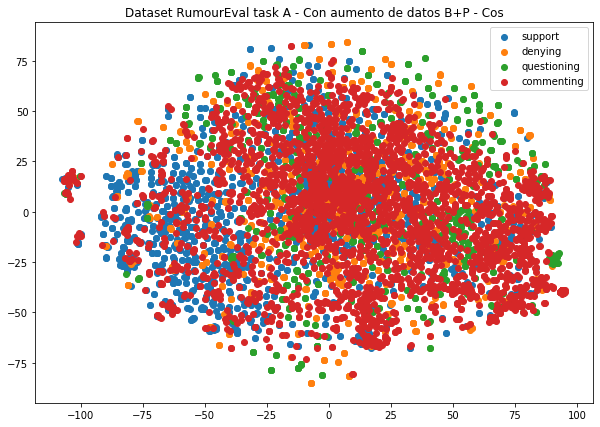

In [158]:
model = TSNE(2, metric='cosine')
to_plot_tsne = model.fit_transform(data_bas_bp)    
plt.figure(figsize=(10,7))
for key in keys:
    labels=[dict_cl[lab] for lab in macro_augmented[:,2]]
    mask = np.asarray(labels)==key
    plt.scatter(to_plot_tsne[:,0][mask],to_plot_tsne[:,1][mask], label=str(key))

plt.legend()
plt.title("Dataset RumourEval task A - Con aumento de datos B+P - Cos")
plt.show()

## Models

In [25]:
from models import *

In [7]:
etiq_v=[]
for et in val['Label'].values:
    etiq_v.append(d_lab[et])
n_labels_val = np.array(etiq_v)
y_val=to_categorical(n_labels_val,num_classes=4)
sentences_val = val['Tweet'].values
input_ids_val = []
for sent in sentences_val:
    encoded_sent = tokenizer_loaded.encode(my_cleaner(sent)[0],add_special_tokens = False)    
    input_ids_val.append(encoded_sent)
input_ids_val = pad_sequences(input_ids_val, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

etiq_t=[]
for et in test['Label'].values:
    etiq_t.append(d_lab[et])
n_labels_test = np.array(etiq_t)
y_test=to_categorical(n_labels_test,num_classes=4)
sentences_test = test['Tweet'].values
input_ids_test = []
for sent in sentences_test:
    encoded_sent = tokenizer_loaded.encode(my_cleaner(sent)[0],add_special_tokens = False)    
    input_ids_test.append(encoded_sent)
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")


In [8]:
shape_val=np.asarray(input_ids_val).shape
x_val=np.zeros((shape_val[0], shape_val[1], 768))
i=0
for in_id in input_ids_val:
    x_val[i]=M_BERT_space[in_id]
    i+=1
    
shape_test=np.asarray(input_ids_test).shape
x_test=np.zeros((shape_test[0], shape_test[1], 768))
i=0
for in_id in input_ids_test:
    x_test[i]=M_BERT_space[in_id]
    i+=1

x_test.shape


(1021, 50, 768)

#SMOTE
shape_val=np.asarray(input_ids_val).shape
x_val=np.zeros((shape_val[0], 768))
i=0
for in_id in input_ids_val:
    vector=np.zeros(768)
    n = np.sum(in_id != 0)
    for idv in in_id:
        if idv!=0:
            vector+=M_BERT_space[idv]
    x_val[i]=(vector/n)
    i+=1  

shape_test=np.asarray(input_ids_test).shape
x_test=np.zeros((shape_test[0], 768))
i=0
for in_id in input_ids_test:
    vector=np.zeros(768)
    n = np.sum(in_id != 0)
    for idv in in_id:
        if idv!=0:
            vector+=M_BERT_space[idv]
    x_test[i]=(vector/n)
    i+=1  


In [9]:
np.sum(y_val[:,2])

28.0

In [10]:
np.sum(val['Label']=='questioning')

28

### Bias de agregar varias veces a lo mendoza 0.15

In [10]:
prob= 0.15
TOPN = 1

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

aum_weight=det_samples(train['Label'], dict_cl)

for i in range(5): 
    macro_augmented=[]
    print ("--------------------------------------------------------")
    print ("\nGenerando ejemplos en base a probabilidad --> ", prob)
    print ("--------------------------------------------------------")
    for clase in aum_weight:
        start_time=time.time()
        print ("\nGenerando", aum_weight[clase], "nuevos ejemplos para la clase", clase)
        muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, TOPN)
        macro_augmented+=muestras
        print ("Resumen de modificaciones:", dict_aumentos)
        elapsed_time= time.time() - start_time
        print ("Este proceso tomó", elapsed_time, "seg")   

    macro_augmented = np.asarray(macro_augmented, dtype=object)
    np.random.shuffle(macro_augmented)
    
    np.save('../Data_augmented/Stance_agregado/Aumento_'+str(i+1)+'-run_'+str(prob)+'_balanced_w4_app1_Top'+str(TOPN)+'.npy', macro_augmented)
    
    
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)
    
    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)

    input_ids = []
    for sent in sentences:
        encoded_sent = tokenizer_loaded.encode(list(sent),add_special_tokens = False)    
        input_ids.append(encoded_sent)
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    y_train=to_categorical(n_labels,num_classes=4)
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], 768))
    j=0
    for in_id in input_ids:
        x_train[j]=M_BERT_space[in_id]
        j+=1

    ###########################################################
    ############################################################
    ############################################################
    
    cnn1=create_ccn1(x_train.shape[1:])
    trained =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/0.15/cnn1_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/0.15/cnn2_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/0.15/rnn1_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/0.15/rnn2_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=False)
    trained.save('exec_baselines/0.15/rnn3_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.15
--------------------------------------------------------

Generando 2404 nuevos ejemplos para la clase questioning
# terms modificados promedio 1.4841930116472546 términos por sentencia
Largo de sentencia promedio 14.497088186356073 términos por sentencia
para esta ejecución se debiesen reemplazar 4739  de 31462 terminos
Resumen de modificaciones: {'NN': 2314, 'JJS': 5, 'NNS': 451, 'VBG': 185, 'VBD': 48, 'JJ': 263, 'VBN': 128, 'VB': 143, 'JJR': 12, 'VBZ': 19}
Este proceso tomó 23.648268699645996 seg

Generando 0 nuevos ejemplos para la clase commenting
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 0.7654829025268555 seg

Generando 1893 nuevos ejemplos para la clase support
# terms modificados promedio 1.7152667723190702 términos por sentencia
Largo de sentencia promedio 18.183306920232436 términos por sentencia
para esta ejecución se debiesen reemplazar

 - val_f1: 0.000000 
 - val_f1: 0.154676 
 - val_f1: 0.211693 
 - val_f1: 0.265769 
 - val_f1: 0.219782 
 - val_f1: 0.257667 
 - val_f1: 0.296452 
 - val_f1: 0.213596 
 - val_f1: 0.360375 
 - val_f1: 0.289391 
 - val_f1: 0.439360 
 - val_f1: 0.424677 
 - val_f1: 0.438681 
 - val_f1: 0.348046 
 - val_f1: 0.421965 
 - val_f1: 0.319538 
 - val_f1: 0.383207 
 - val_f1: 0.338558 
 - val_f1: 0.292524 
 - val_f1: 0.445724 
 - val_f1: 0.424703 
 - val_f1: 0.411310 
 - val_f1: 0.403773 
 - val_f1: 0.464731 
 - val_f1: 0.456169 
 - val_f1: 0.462776 
 - val_f1: 0.426921 
 - val_f1: 0.406154 
 - val_f1: 0.438105 
 - val_f1: 0.467000 

Accuracy sobre Train rnn2 : 0.8942026335040234
F1-score None sobre Train rnn2 : [0.76093361 0.98641703 0.98467087 0.82987937]
F1-score macro sobre Train rnn2 : 0.8904752206750071

Accuracy sobre Val rnn2 : 0.6548042704626335
F1-score None sobre Val rnn2 : [0.5        0.14814815 0.50746269 0.76373626]
F1-score macro sobre Val rnn2 : 0.4798367746128941

Accuracy sobre 


Accuracy sobre Test rnn2 : 0.6650342801175319
F1-score None sobre Test rnn2 : [0.1        0.11009174 0.4495114  0.79415671]
F1-score macro sobre Test rnn2 : 0.363439962569509
 - val_f1: 0.213154 
 - val_f1: 0.275178 
 - val_f1: 0.298280 
 - val_f1: 0.340846 
 - val_f1: 0.442032 
 - val_f1: 0.547290 
 - val_f1: 0.421112 
 - val_f1: 0.489011 
 - val_f1: 0.486918 
 - val_f1: 0.462508 
 - val_f1: 0.365856 
 - val_f1: 0.477223 
 - val_f1: 0.475127 
 - val_f1: 0.437218 
 - val_f1: 0.446835 
 - val_f1: 0.456110 
 - val_f1: 0.454701 
 - val_f1: 0.463768 
 - val_f1: 0.388276 
 - val_f1: 0.394951 
 - val_f1: 0.474770 
 - val_f1: 0.454064 
 - val_f1: 0.416291 
 - val_f1: 0.440894 
 - val_f1: 0.434161 
 - val_f1: 0.461867 
 - val_f1: 0.428411 
 - val_f1: 0.423477 
 - val_f1: 0.457857 
 - val_f1: 0.316799 

Accuracy sobre Train rnn3 : 0.8211411850768106
F1-score None sobre Train rnn3 : [0.73971861 0.9902877  0.91668316 0.6186398 ]
F1-score macro sobre Train rnn3 : 0.8163323188983911

Accuracy sobr

 - val_f1: 0.402219 
 - val_f1: 0.400149 
 - val_f1: 0.493096 
 - val_f1: 0.397834 
 - val_f1: 0.452648 

Accuracy sobre Train rnn3 : 0.9863752743233358
F1-score None sobre Train rnn3 : [0.9790991  0.99411548 0.99321474 0.97919352]
F1-score macro sobre Train rnn3 : 0.9864057113998281

Accuracy sobre Val rnn3 : 0.6192170818505338
F1-score None sobre Val rnn3 : [0.5380117  0.         0.59090909 0.7120743 ]
F1-score macro sobre Val rnn3 : 0.4602487725552741

Accuracy sobre Test rnn3 : 0.6033300685602351
F1-score None sobre Test rnn3 : [0.09027778 0.12844037 0.38410596 0.75903614]
F1-score macro sobre Test rnn3 : 0.34046506239836716
--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.15
--------------------------------------------------------

Generando 2404 nuevos ejemplos para la clase questioning
# terms modificados promedio 1.471297836938436 términos por sentencia
Largo de sentencia promedio 14.389351081530782 términos por sentenci

# terms modificados promedio 1.483361064891847 términos por sentencia
Largo de sentencia promedio 14.471297836938437 términos por sentencia
para esta ejecución se debiesen reemplazar 4721  de 31475 terminos
Resumen de modificaciones: {'NN': 2293, 'VB': 146, 'NNS': 472, 'JJ': 252, 'VBG': 170, 'VBZ': 26, 'VBN': 146, 'JJR': 3, 'VBD': 53, 'JJS': 5}
Este proceso tomó 24.294464111328125 seg

Generando 0 nuevos ejemplos para la clase commenting
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 0.7723925113677979 seg

Generando 1893 nuevos ejemplos para la clase support
# terms modificados promedio 1.6962493396724776 términos por sentencia
Largo de sentencia promedio 18.221870047543582 términos por sentencia
para esta ejecución se debiesen reemplazar 4053  de 27183 terminos
Resumen de modificaciones: {'JJ': 222, 'NN': 2167, 'NNS': 364, 'VBG': 182, 'VBD': 38, 'VBN': 111, 'VB': 75, 'JJS': 23, 'JJR': 3, 'VBZ': 25, 'VBP': 1}
Este proceso tomó 21.694880962371826 seg

Generando 

In [11]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.15) app1 F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.15) app1 F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.15) app1 Accuracy promedio para",key,":" ,temp/5)

(0.15) app1 F1-score promedio para cnn1 : [0.05913829 0.09808888 0.5217745  0.83704027]
(0.15) app1 F1-score promedio para cnn2 : [0.05451985 0.13171355 0.48291867 0.83916968]
(0.15) app1 F1-score promedio para rnn1 : [0.10359302 0.15578247 0.44426169 0.7402233 ]
(0.15) app1 F1-score promedio para rnn2 : [0.07054107 0.125021   0.35862213 0.78863088]
(0.15) app1 F1-score promedio para rnn3 : [0.09520153 0.13992543 0.40179281 0.58644398]

(0.15) app1 F1-score macro promedio para cnn1 : 0.3790104855493358 desvest:  0.02361467036822488
(0.15) app1 F1-score macro promedio para cnn2 : 0.37708043815958014 desvest:  0.026367322793435764
(0.15) app1 F1-score macro promedio para rnn1 : 0.36096511926969593 desvest:  0.02432136330304215
(0.15) app1 F1-score macro promedio para rnn2 : 0.33570377110678357 desvest:  0.028796318032862478
(0.15) app1 F1-score macro promedio para rnn3 : 0.305840934771976 desvest:  0.05909817209921237

(0.15) app1 Accuracy promedio para cnn1 : 0.7263467189030363
(0.15) a

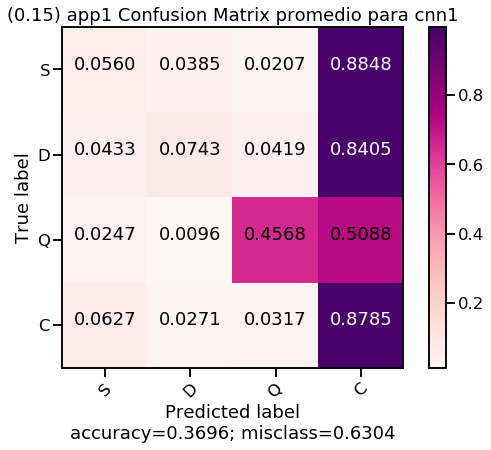

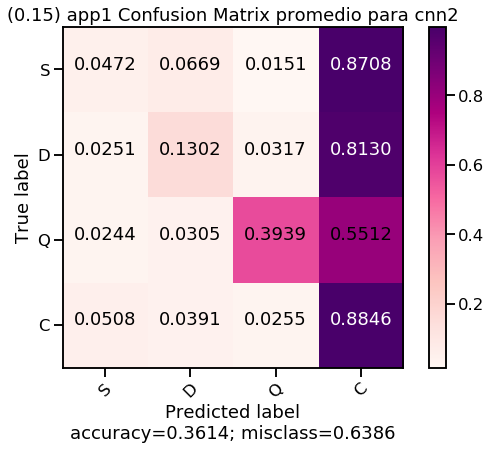

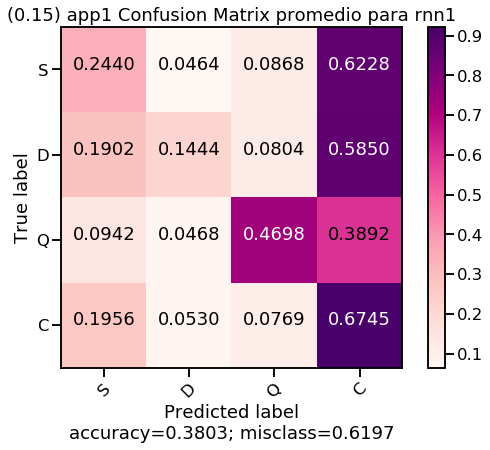

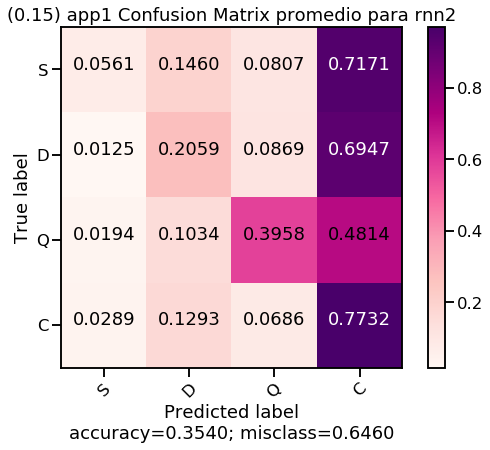

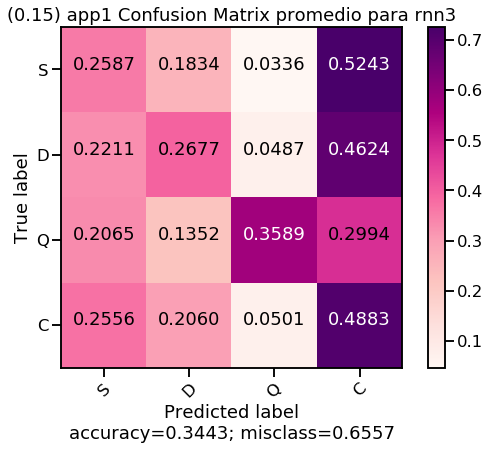

In [13]:
for key in confusions.keys():
    temp=np.sum(confusions[key], axis=0)/5.0
    plot_confusion_matrix(temp, ['S','D','Q','C'], "(0.15) app1 Confusion Matrix promedio para "+str(key), cmap='RdPu')

### Masking 0.85

### Nota

La aplicación de class_weigths y focal loss para las redes recurrentes parece tener un efecto no deseado. Sin embargo las redes convolucionales se ven claramente beneficiadas por este parámetro. 

La aplicación de class_weights para una red recurrente cuya función de perdida es categorical cross entropy, no parece verse ni beneficiada ni perjudicada (no se acusan resultados significativamente diferentes)

## SMOTE Balanced 

In [11]:
from imblearn.over_sampling import SMOTE

x_val=np.expand_dims(x_val, axis=-1)
x_test=np.expand_dims(x_test, axis=-1)

In [14]:
prob= 0.0
TOPN = 1

fs_macro_sm={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none_sm={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs_sm={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions_sm={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

aum_weight = {'support': 0, 'denying': 0, 'questioning': 0, 'commenting': 0}

for i in range(5): 
    print ("--------------------------------------------------------")
    print ("\nGenerando modelos EJECUCIÓN",i)
    print ("--------------------------------------------------------")
    
    """macro_augmented=[]
    print ("--------------------------------------------------------")
    print ("\nGenerando ejemplos en base a probabilidad --> ", prob, '--- EJECUCIÓN ',i)
    print ("--------------------------------------------------------")
    for clase in aum_weight:
        start_time=time.time()
        print ("\nGenerando", aum_weight[clase], "nuevos ejemplos para la clase", clase)
        muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, TOPN)
        macro_augmented+=muestras
        print ("Resumen de modificaciones:", dict_aumentos)
        elapsed_time= time.time() - start_time
        print ("Este proceso tomó", elapsed_time, "seg")   

    macro_augmented = np.asarray(macro_augmented, dtype=object)
    np.random.shuffle(macro_augmented)
    
    np.save('../Data_augmented/Stance_agregado/SMOTE_'+str(i+1)+'-run.npy', macro_augmented) """   
    macro_augmented=np.load('../Data_augmented/Stance_agregado/SMOTE_'+str(i+1)+'-run.npy', allow_pickle=True)
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    
    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)

    input_ids = []
    for sent in sentences:
        encoded_sent = tokenizer_loaded.encode(list(sent),add_special_tokens = False)    
        input_ids.append(encoded_sent)
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    
    y_train=to_categorical(n_labels, num_classes=4)
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], 768))
    j=0
    for in_id in input_ids:
        vector=np.zeros(768)
        n = np.sum(in_id != 0)
        for idv in in_id:
            if idv!=0:
                vector+=M_BERT_space[idv]
        x_train[j]=(vector/n)
        j+=1  
     
    sm = SMOTE(random_state=27, n_jobs=-1, sampling_strategy='not majority')
    x_train, y_train = sm.fit_sample(x_train, y_train)
    etiq=np.asarray([np.argmax(y) for y in y_train])
    class_weights = compute_class_weight('balanced', np.unique(etiq), etiq)
    print ("class_weights Training set", class_weights)

    x_train=np.expand_dims(x_train, axis=-1)
    

    ###############################
    ###############################
    ###############################
    
    cnn1=create_ccn1(x_train.shape[1:])
    trained =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/SMOTE/cnn1_'+str(i+1)+'-exec_w4_app1.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro_sm['cnn1'].append(f1_ma_t)
    fs_none_sm['cnn1'].append(f1_t)
    accs_sm['cnn1'].append(acc_t)
    confusions_sm['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/SMOTE/cnn2_'+str(i+1)+'-exec_w4_app1.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro_sm['cnn2'].append(f1_ma_t)
    fs_none_sm['cnn2'].append(f1_t)
    accs_sm['cnn2'].append(acc_t)
    confusions_sm['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/SMOTE/rnn1_'+str(i+1)+'-exec_w4_app1.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro_sm['rnn1'].append(f1_ma_t)
    fs_none_sm['rnn1'].append(f1_t)
    accs_sm['rnn1'].append(acc_t)
    confusions_sm['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines/SMOTE/rnn2_'+str(i+1)+'-exec_w4_app1.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro_sm['rnn2'].append(f1_ma_t)
    fs_none_sm['rnn2'].append(f1_t)
    accs_sm['rnn2'].append(acc_t)
    confusions_sm['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=False)
    trained.save('exec_baselines/SMOTE/rnn3_'+str(i+1)+'-exec_w4_app1.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro_sm['rnn3'].append(f1_ma_t)
    fs_none_sm['rnn3'].append(f1_t)
    accs_sm['rnn3'].append(acc_t)
    confusions_sm['rnn3'].append(matriz_t)

--------------------------------------------------------

Generando modelos EJECUCIÓN 0
--------------------------------------------------------
class_weights Training set [1. 1. 1. 1.]

Accuracy sobre Train cnn1 : 0.9695501097293343
F1-score None sobre Train cnn1 : [0.95768948 0.97869267 0.98878031 0.9523455 ]
F1-score macro sobre Train cnn1 : 0.9693769882016279

Accuracy sobre Val cnn1 : 0.5871886120996441
F1-score None sobre Val cnn1 : [0.33333333 0.12903226 0.53571429 0.71468144]
F1-score macro sobre Val cnn1 : 0.42819032938883717

Accuracy sobre Test cnn1 : 0.6758080313418218
F1-score None sobre Test cnn1 : [0.21333333 0.12328767 0.44329897 0.80154639]
F1-score macro sobre Test cnn1 : 0.3953665913477381

Accuracy sobre Train cnn2 : 0.9541880029261156
F1-score None sobre Train cnn2 : [0.93118757 0.98180495 0.98267148 0.92007366]
F1-score macro sobre Train cnn2 : 0.9539344158476692

Accuracy sobre Val cnn2 : 0.6298932384341637
F1-score None sobre Val cnn2 : [0.37037037 0.13793103 0.


Accuracy sobre Test rnn2 : 0.5063663075416258
F1-score None sobre Test rnn2 : [0.21164021 0.12648221 0.25092251 0.67268623]
F1-score macro sobre Test rnn2 : 0.31543279113808653

Accuracy sobre Train rnn3 : 0.42794440380395027
F1-score None sobre Train rnn3 : [0.34720759 0.24469821 0.55459211 0.45821424]
F1-score macro sobre Train rnn3 : 0.40117803623891096

Accuracy sobre Val rnn3 : 0.604982206405694
F1-score None sobre Val rnn3 : [0.41584158 0.         0.4047619  0.72928177]
F1-score macro sobre Val rnn3 : 0.3874713142190304

Accuracy sobre Test rnn3 : 0.6258570029382958
F1-score None sobre Test rnn3 : [0.10526316 0.08602151 0.27810651 0.76912929]
F1-score macro sobre Test rnn3 : 0.3096301149364413
--------------------------------------------------------

Generando modelos EJECUCIÓN 3
--------------------------------------------------------
class_weights Training set [1. 1. 1. 1.]

Accuracy sobre Train cnn1 : 0.9726591075347476
F1-score None sobre Train cnn1 : [0.9603059  0.98694233 

In [15]:
for key in fs_none_sm.keys():
    temp=np.zeros(4)
    for result in fs_none_sm[key]:
        temp+=result
    print ("(SMOTE) F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro_sm.keys():
    temp=np.sum(fs_macro_sm[key])
    print ("(SMOTE) F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro_sm[key]))

print ("")
for key in accs_sm.keys():
    temp=np.sum(accs_sm[key])
    print ("(SMOTE) Accuracy promedio para",key,":" ,temp/5)

(SMOTE) F1-score promedio para cnn1 : [0.22323424 0.09066228 0.44238278 0.79734055]
(SMOTE) F1-score promedio para cnn2 : [0.22804979 0.08730085 0.46988418 0.80312307]
(SMOTE) F1-score promedio para rnn1 : [0.16231079 0.110261   0.25267763 0.6238415 ]
(SMOTE) F1-score promedio para rnn2 : [0.10896585 0.08337858 0.23436209 0.50015826]
(SMOTE) F1-score promedio para rnn3 : [0.17778909 0.09106006 0.24048234 0.685808  ]

(SMOTE) F1-score macro promedio para cnn1 : 0.38840496421734094 desvest:  0.007503369227102938
(SMOTE) F1-score macro promedio para cnn2 : 0.3970894715985434 desvest:  0.017004257648364086
(SMOTE) F1-score macro promedio para rnn1 : 0.2872727314672903 desvest:  0.023279798173038973
(SMOTE) F1-score macro promedio para rnn2 : 0.2317161948090667 desvest:  0.0729773931410319
(SMOTE) F1-score macro promedio para rnn3 : 0.29878487052262476 desvest:  0.025143209578281707

(SMOTE) Accuracy promedio para cnn1 : 0.6693437806072478
(SMOTE) Accuracy promedio para cnn2 : 0.68011753183

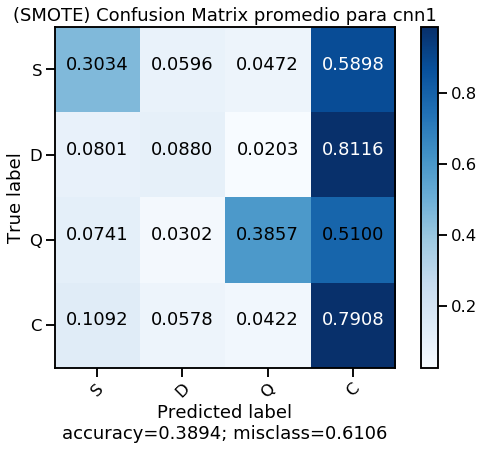

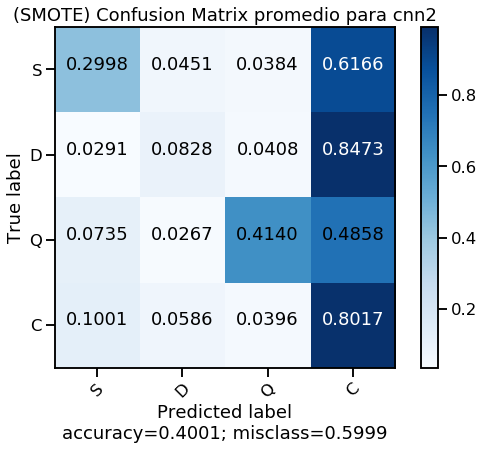

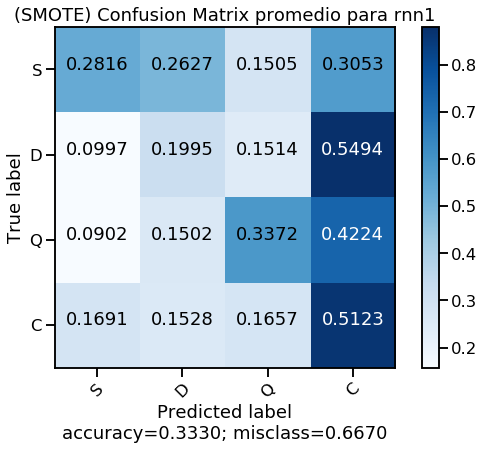

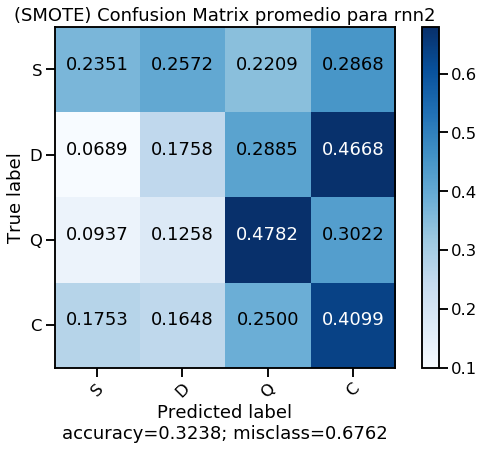

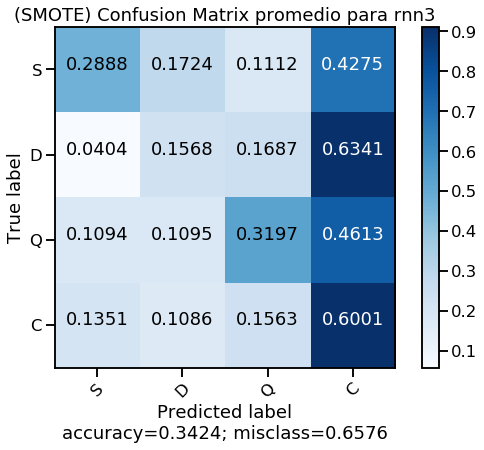

In [16]:
for key in confusions_sm.keys():
    temp=np.sum(confusions_sm[key], axis=0)/5.0
    plot_confusion_matrix(temp, ['S','D','Q','C'], "(SMOTE) Confusion Matrix promedio para "+str(key))